In [1]:
%matplotlib inline

from os import listdir, makedirs
from os.path import isfile, join, basename, splitext, isfile, exists

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook

import tensorflow as tf
import keras.backend as K
from keras import metrics

import keras
from keras.engine.input_layer import Input

import matplotlib.pyplot as plt
import seaborn as sns

import random, os, sys
from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.initializers import *
import tensorflow as tf
from keras.engine.topology import Layer

pd.set_option('precision', 30)
np.set_printoptions(precision = 30)

np.random.seed(368)
tf.set_random_seed(368)

Using TensorFlow backend.


In [2]:
%%time
train_df = pd.read_csv('input/train.csv', dtype={'acoustic_data': np.int8, 'time_to_failure': np.float32})

Wall time: 1min 32s


In [3]:
train_df.head()

,acoustic_data,time_to_failure
0,12,1.46909999847412109375
1,6,1.46909999847412109375
2,8,1.46909999847412109375
3,5,1.46909999847412109375
4,8,1.46909999847412109375


In [4]:
X_train = train_df.acoustic_data.values
y_train = train_df.time_to_failure.values

Find complete segments in the training data (time to failure goes to zero)

In [5]:
ends_mask = np.less(y_train[:-1], y_train[1:])
segment_ends = np.nonzero(ends_mask)

train_segments = []
start = 0
for end in segment_ends[0]:
    train_segments.append((start, end))
    start = end
    
print(train_segments)

[(0, 5656573), (5656573, 50085877), (50085877, 104677355), (104677355, 138772452), (138772452, 187641819), (187641819, 218652629), (218652629, 245829584), (245829584, 307838916), (307838916, 338276286), (338276286, 375377847), (375377847, 419368879), (419368879, 461811622), (461811622, 495800224), (495800224, 528777114), (528777114, 585568143), (585568143, 621985672)]


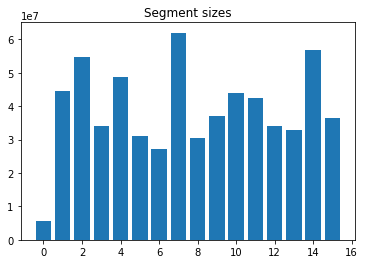

In [6]:
plt.title('Segment sizes')
_ = plt.bar(np.arange(len(train_segments)), [ s[1] - s[0] for s in train_segments])

The generator samples randomly from the segmens without crossing the boundaries

In [7]:
class EarthQuakeRandom(keras.utils.Sequence):

    def __init__(self, x, y, x_mean, x_std, segments, ts_length, batch_size, steps_per_epoch):
        self.x = x
        self.y = y
        self.segments = segments
        self.ts_length = ts_length
        self.batch_size = batch_size
        self.steps_per_epoch = steps_per_epoch
        self.segments_size = np.array([s[1] - s[0] for s in segments])
        self.segments_p = self.segments_size / self.segments_size.sum()
        self.x_mean = x_mean
        self.x_std = x_std

    def get_batch_size(self):
        return self.batch_size

    def get_ts_length(self):
        return self.ts_length

    def get_segments(self):
        return self.segments

    def get_segments_p(self):
        return self.segments_p

    def get_segments_size(self):
        return self.segments_size

    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        segment_index = np.random.choice(range(len(self.segments)), p=self.segments_p)
        segment = self.segments[segment_index]
        end_indexes = np.random.randint(segment[0] + self.ts_length, segment[1], size=self.batch_size)

        x_batch = np.empty((self.batch_size, self.ts_length))
        y_batch = np.empty(self.batch_size, )

        for i, end in enumerate(end_indexes):
            x_batch[i, :] = self.x[end - self.ts_length: end]
            y_batch[i] = self.y[end - 1]
            
        #x_batch = (x_batch - self.x_mean)/self.x_std

        return np.expand_dims(x_batch, axis=2), y_batch

We could use any segments for training / validation

In [8]:
t_segments = [train_segments[i] for i in [ 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]
v_segments = [train_segments[i] for i in [ 0, 1, 2, 3]]

I think it does not make big difference but lets not leak into the validation data and calculate mean and standrad deviation on the training data only.

In [9]:
x_sum = 0.
count = 0

for s in t_segments:
    x_sum += X_train[s[0]:s[1]].sum()
    count += (s[1] - s[0])

X_train_mean = x_sum/count

x2_sum = 0.
for s in t_segments:
    x2_sum += np.power(X_train[s[0]:s[1]] - X_train_mean, 2).sum()

X_train_std =  np.sqrt(x2_sum/count)

print(X_train_mean, X_train_std)

4.472289301190891 6.189013535612676


In [10]:
train_gen = EarthQuakeRandom(
    x = X_train, 
    y = y_train,
    x_mean = X_train_mean, 
    x_std = X_train_std,
    segments = t_segments,
    ts_length = 150000,
    batch_size = 64,
    steps_per_epoch = 400
)

valid_gen = EarthQuakeRandom(
    x = X_train, 
    y = y_train,
    x_mean = X_train_mean, 
    x_std = X_train_std,
    segments = v_segments,
    ts_length = 150000,
    batch_size = 64,
    steps_per_epoch = 400
)

In [11]:
print(train_gen)

Use convolutional layers to learn the features and reduce the time sequence length 

In [12]:
# https://www.kaggle.com/shujian/transformer-with-lstm

try:
    from dataloader import TokenList, pad_to_longest
    # for transformer
except: pass



embed_size = 60

class LayerNormalization(Layer):
    def __init__(self, eps=1e-6, **kwargs):
        self.eps = eps
        super(LayerNormalization, self).__init__(**kwargs)
    def build(self, input_shape):
        self.gamma = self.add_weight(name='gamma', shape=input_shape[-1:],
                                     initializer=Ones(), trainable=True)
        self.beta = self.add_weight(name='beta', shape=input_shape[-1:],
                                    initializer=Zeros(), trainable=True)
        super(LayerNormalization, self).build(input_shape)
    def call(self, x):
        mean = K.mean(x, axis=-1, keepdims=True)
        std = K.std(x, axis=-1, keepdims=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta
    def compute_output_shape(self, input_shape):
        return input_shape

class ScaledDotProductAttention():
    def __init__(self, d_model, attn_dropout=0.1):
        self.temper = np.sqrt(d_model)
        self.dropout = Dropout(attn_dropout)
    def __call__(self, q, k, v, mask):
        attn = Lambda(lambda x:K.batch_dot(x[0],x[1],axes=[2,2])/self.temper)([q, k])
        if mask is not None:
            mmask = Lambda(lambda x:(-1e+10)*(1-x))(mask)
            attn = Add()([attn, mmask])
        attn = Activation('softmax')(attn)
        attn = self.dropout(attn)
        output = Lambda(lambda x:K.batch_dot(x[0], x[1]))([attn, v])
        return output, attn

class MultiHeadAttention():
    # mode 0 - big martixes, faster; mode 1 - more clear implementation
    def __init__(self, n_head, d_model, d_k, d_v, dropout, mode=0, use_norm=True):
        self.mode = mode
        self.n_head = n_head
        self.d_k = d_k
        self.d_v = d_v
        self.dropout = dropout
        if mode == 0:
            self.qs_layer = Dense(n_head*d_k, use_bias=False)
            self.ks_layer = Dense(n_head*d_k, use_bias=False)
            self.vs_layer = Dense(n_head*d_v, use_bias=False)
        elif mode == 1:
            self.qs_layers = []
            self.ks_layers = []
            self.vs_layers = []
            for _ in range(n_head):
                self.qs_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.ks_layers.append(TimeDistributed(Dense(d_k, use_bias=False)))
                self.vs_layers.append(TimeDistributed(Dense(d_v, use_bias=False)))
        self.attention = ScaledDotProductAttention(d_model)
        self.layer_norm = LayerNormalization() if use_norm else None
        self.w_o = TimeDistributed(Dense(d_model))

    def __call__(self, q, k, v, mask=None):
        d_k, d_v = self.d_k, self.d_v
        n_head = self.n_head

        if self.mode == 0:
            qs = self.qs_layer(q)  # [batch_size, len_q, n_head*d_k]
            ks = self.ks_layer(k)
            vs = self.vs_layer(v)

            def reshape1(x):
                s = tf.shape(x)   # [batch_size, len_q, n_head * d_k]
                x = tf.reshape(x, [s[0], s[1], n_head, d_k])
                x = tf.transpose(x, [2, 0, 1, 3])  
                x = tf.reshape(x, [-1, s[1], d_k])  # [n_head * batch_size, len_q, d_k]
                return x
            qs = Lambda(reshape1)(qs)
            ks = Lambda(reshape1)(ks)
            vs = Lambda(reshape1)(vs)

            if mask is not None:
                mask = Lambda(lambda x:K.repeat_elements(x, n_head, 0))(mask)
            head, attn = self.attention(qs, ks, vs, mask=mask)  
                
            def reshape2(x):
                s = tf.shape(x)   # [n_head * batch_size, len_v, d_v]
                x = tf.reshape(x, [n_head, -1, s[1], s[2]]) 
                x = tf.transpose(x, [1, 2, 0, 3])
                x = tf.reshape(x, [-1, s[1], n_head*d_v])  # [batch_size, len_v, n_head * d_v]
                return x
            head = Lambda(reshape2)(head)
        elif self.mode == 1:
            heads = []; attns = []
            for i in range(n_head):
                qs = self.qs_layers[i](q)   
                ks = self.ks_layers[i](k) 
                vs = self.vs_layers[i](v) 
                head, attn = self.attention(qs, ks, vs, mask)
                heads.append(head); attns.append(attn)
            head = Concatenate()(heads) if n_head > 1 else heads[0]
            attn = Concatenate()(attns) if n_head > 1 else attns[0]

        outputs = self.w_o(head)
        outputs = Dropout(self.dropout)(outputs)
        if not self.layer_norm: return outputs, attn
        # outputs = Add()([outputs, q]) # sl: fix
        return self.layer_norm(outputs), attn

class PositionwiseFeedForward():
    def __init__(self, d_hid, d_inner_hid, dropout=0.1):
        self.w_1 = Conv1D(d_inner_hid, 1, activation='relu')
        self.w_2 = Conv1D(d_hid, 1)
        self.layer_norm = LayerNormalization()
        self.dropout = Dropout(dropout)
    def __call__(self, x):
        output = self.w_1(x) 
        output = self.w_2(output)
        output = self.dropout(output)
        output = Add()([output, x])
        return self.layer_norm(output)

class EncoderLayer():
    def __init__(self, d_model, d_inner_hid, n_head, d_k, d_v, dropout=0.1):
        self.self_att_layer = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout=dropout)
        self.pos_ffn_layer  = PositionwiseFeedForward(d_model, d_inner_hid, dropout=dropout)
    def __call__(self, enc_input, mask=None):
        output, slf_attn = self.self_att_layer(enc_input, enc_input, enc_input, mask=mask)
        output = self.pos_ffn_layer(output)
        return output, slf_attn


def GetPosEncodingMatrix(max_len, d_emb):
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / d_emb) for j in range(d_emb)] 
        if pos != 0 else np.zeros(d_emb) 
            for pos in range(max_len)
            ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2]) # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2]) # dim 2i+1
    return pos_enc

def GetPadMask(q, k):
    ones = K.expand_dims(K.ones_like(q, 'float32'), -1)
    mask = K.cast(K.expand_dims(K.not_equal(k, 0), 1), 'float32')
    mask = K.batch_dot(ones, mask, axes=[2,1])
    return mask

def GetSubMask(s):
    len_s = tf.shape(s)[1]
    bs = tf.shape(s)[:1]
    mask = K.cumsum(tf.eye(len_s, batch_shape=bs), 1)
    return mask



In [13]:
def CnnTransformerModel():
    i = Input(shape = (150000, 1))
    
    x = Convolution1D(16, kernel_size = 10, strides = 5, activation='relu')(i)
    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(x)
    x = Convolution1D(16, kernel_size = 10, strides = 10, activation='relu')(x)
    ## x = (CuDNNLSTM(16, return_sequences = True, return_state = False))(x)
    x, slf_attn = MultiHeadAttention(n_head=5, d_model=300, d_k=64, d_v=64, dropout=0.3)(x, x, x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    concat = concatenate([avg_pool, max_pool])
    y = Dense(1,activation = 'relu')(concat)
    

    return Model(inputs = [i], outputs = [y])

In [14]:
model = CnnTransformerModel()
model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mean_absolute_error'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150000, 1)    0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 29999, 16)    176         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 2999, 16)     2576        conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_3 (Conv1D)    

**Visualizing The Model Architecture**

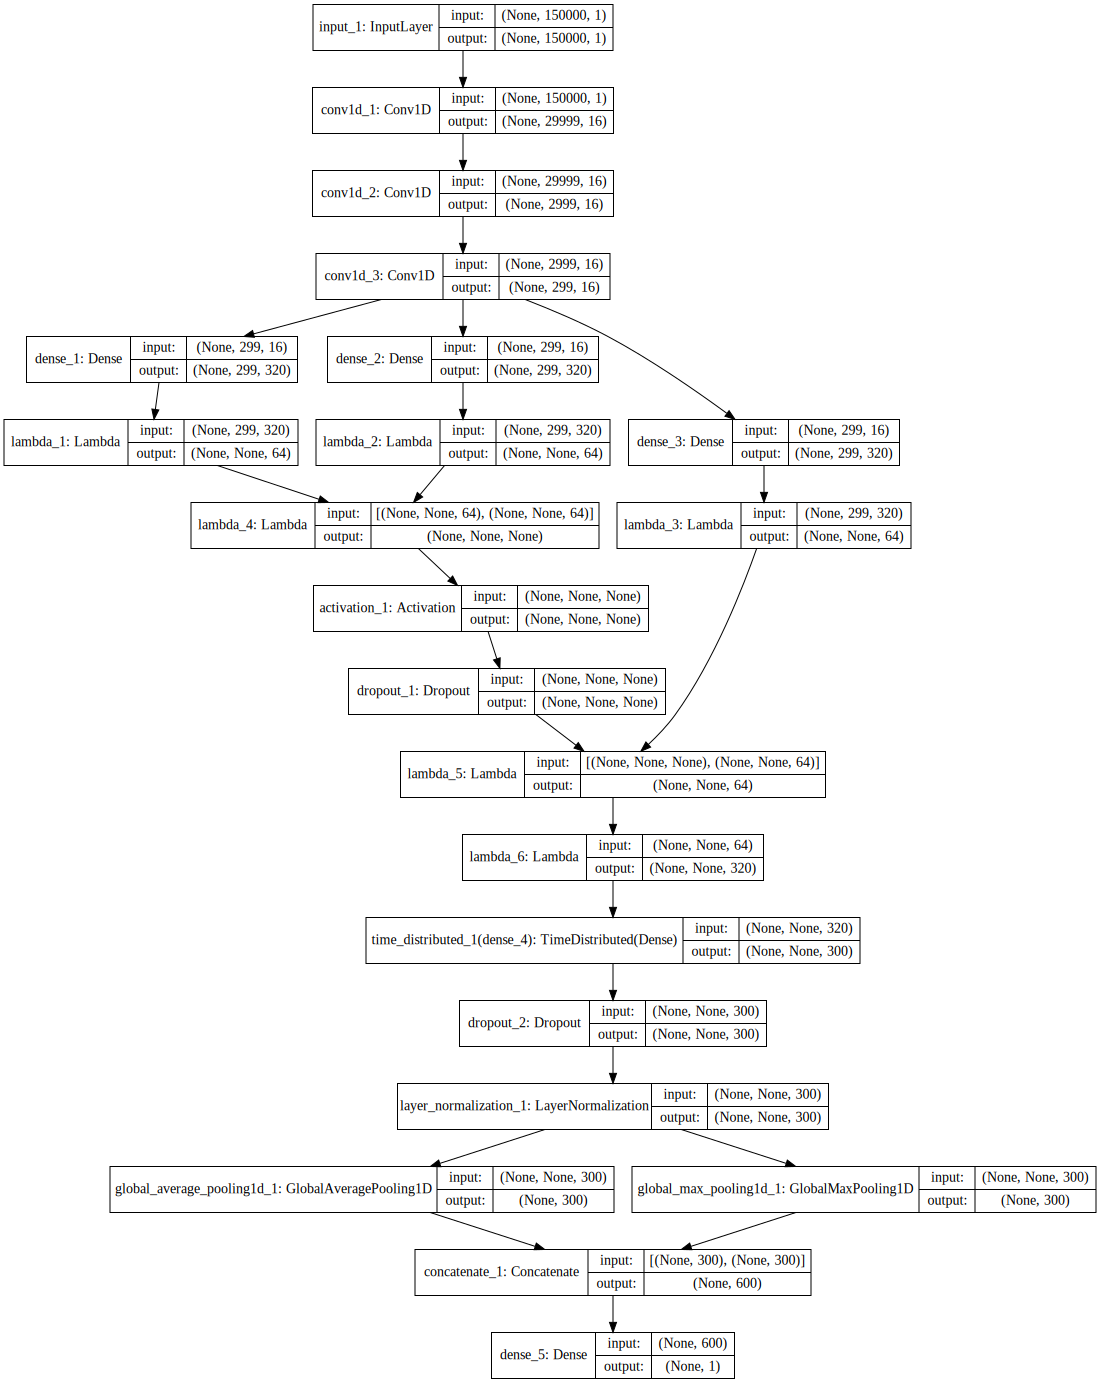

In [15]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model,show_shapes = True).create(prog='dot', format='svg'))

Train the model with early stopping

In [16]:
import time
start_time = time.time()
hist = model.fit_generator(
    generator =  train_gen,
    epochs = 150, 
    verbose = 1, 
    validation_data = valid_gen,
)
print("--- %s seconds ---" % (time.time() - start_time))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/150


146/400 [=========>....................] - ETA: 31:07 - loss: 18.8175 - mean_absolute_error: 3.669 - ETA: 15:48 - loss: 19.4596 - mean_absolute_error: 3.764 - ETA: 10:41 - loss: 20.4807 - mean_absolute_error: 3.806 - ETA: 8:08 - loss: 21.2485 - mean_absolute_error: 3.897 - ETA: 6:37 - loss: 19.9250 - mean_absolute_error: 3.78 - ETA: 5:35 - loss: 21.0145 - mean_absolute_error: 3.87 - ETA: 4:52 - loss: 18.8120 - mean_absolute_error: 3.61 - ETA: 4:19 - loss: 18.6524 - mean_absolute_error: 3.61 - ETA: 3:53 - loss: 17.9345 - mean_absolute_error: 3.53 - ETA: 3:33 - loss: 19.5336 - mean_absolute_error: 3.66 - ETA: 3:16 - loss: 18.7616 - mean_absolute_error: 3.59 - ETA: 3:02 - loss: 18.0457 - mean_absolute_error: 3.50 - ETA: 2:50 - loss: 17.9607 - mean_absolute_error: 3.51 - ETA: 2:40 - loss: 17.5527 - mean_absolute_error: 3.47 - ETA: 2:31 - loss: 17.3441 - mean_absolute_error: 3.46 - ETA: 2:23 - loss: 17.1560 - mean_absolute_error: 3.45 - ETA: 2:16 - loss: 16.6047 - mean_absolute_error: 3.39 

292/400 [====================>.........] - ETA: 30s - loss: 12.6997 - mean_absolute_error: 2.837 - ETA: 30s - loss: 12.6746 - mean_absolute_error: 2.833 - ETA: 29s - loss: 12.6506 - mean_absolute_error: 2.830 - ETA: 29s - loss: 12.7249 - mean_absolute_error: 2.839 - ETA: 29s - loss: 12.7385 - mean_absolute_error: 2.841 - ETA: 29s - loss: 12.6900 - mean_absolute_error: 2.835 - ETA: 29s - loss: 12.6669 - mean_absolute_error: 2.832 - ETA: 29s - loss: 12.6927 - mean_absolute_error: 2.837 - ETA: 28s - loss: 12.6944 - mean_absolute_error: 2.839 - ETA: 28s - loss: 12.6547 - mean_absolute_error: 2.835 - ETA: 28s - loss: 12.6263 - mean_absolute_error: 2.832 - ETA: 28s - loss: 12.5826 - mean_absolute_error: 2.826 - ETA: 28s - loss: 12.5457 - mean_absolute_error: 2.821 - ETA: 28s - loss: 12.4878 - mean_absolute_error: 2.812 - ETA: 27s - loss: 12.4340 - mean_absolute_error: 2.804 - ETA: 27s - loss: 12.4440 - mean_absolute_error: 2.808 - ETA: 27s - loss: 12.3857 - mean_absolute_error: 2.798 - ETA: 

400/400 [==============================] - ETA: 11s - loss: 11.8564 - mean_absolute_error: 2.719 - ETA: 10s - loss: 11.8882 - mean_absolute_error: 2.724 - ETA: 10s - loss: 11.9071 - mean_absolute_error: 2.727 - ETA: 10s - loss: 11.8883 - mean_absolute_error: 2.725 - ETA: 10s - loss: 11.9073 - mean_absolute_error: 2.728 - ETA: 10s - loss: 11.8800 - mean_absolute_error: 2.725 - ETA: 10s - loss: 11.8517 - mean_absolute_error: 2.720 - ETA: 10s - loss: 11.8240 - mean_absolute_error: 2.716 - ETA: 10s - loss: 11.8207 - mean_absolute_error: 2.716 - ETA: 10s - loss: 11.8100 - mean_absolute_error: 2.715 - ETA: 10s - loss: 11.8080 - mean_absolute_error: 2.716 - ETA: 9s - loss: 11.8681 - mean_absolute_error: 2.721 - ETA: 9s - loss: 11.8397 - mean_absolute_error: 2.71 - ETA: 9s - loss: 11.8141 - mean_absolute_error: 2.71 - ETA: 9s - loss: 11.8391 - mean_absolute_error: 2.71 - ETA: 9s - loss: 11.8512 - mean_absolute_error: 2.71 - ETA: 9s - loss: 11.8366 - mean_absolute_error: 2.71 - ETA: 9s - loss: 

151/400 [==========>...................] - ETA: 41s - loss: 9.2723 - mean_absolute_error: 2.70 - ETA: 39s - loss: 15.9906 - mean_absolute_error: 3.367 - ETA: 38s - loss: 19.1492 - mean_absolute_error: 3.618 - ETA: 38s - loss: 20.3353 - mean_absolute_error: 3.735 - ETA: 38s - loss: 16.9455 - mean_absolute_error: 3.299 - ETA: 37s - loss: 14.9219 - mean_absolute_error: 3.061 - ETA: 36s - loss: 14.4450 - mean_absolute_error: 3.064 - ETA: 36s - loss: 14.2161 - mean_absolute_error: 3.070 - ETA: 35s - loss: 13.3431 - mean_absolute_error: 2.931 - ETA: 35s - loss: 12.6883 - mean_absolute_error: 2.853 - ETA: 34s - loss: 12.0958 - mean_absolute_error: 2.770 - ETA: 34s - loss: 11.9487 - mean_absolute_error: 2.785 - ETA: 34s - loss: 11.4941 - mean_absolute_error: 2.724 - ETA: 34s - loss: 11.2296 - mean_absolute_error: 2.696 - ETA: 33s - loss: 11.3726 - mean_absolute_error: 2.724 - ETA: 33s - loss: 11.6806 - mean_absolute_error: 2.766 - ETA: 33s - loss: 11.3871 - mean_absolute_error: 2.719 - ETA: 33

302/400 [=====================>........] - ETA: 21s - loss: 9.0915 - mean_absolute_error: 2.36 - ETA: 21s - loss: 9.0859 - mean_absolute_error: 2.36 - ETA: 20s - loss: 9.0639 - mean_absolute_error: 2.35 - ETA: 20s - loss: 9.0224 - mean_absolute_error: 2.34 - ETA: 20s - loss: 9.0929 - mean_absolute_error: 2.35 - ETA: 20s - loss: 9.0730 - mean_absolute_error: 2.35 - ETA: 20s - loss: 9.0441 - mean_absolute_error: 2.35 - ETA: 20s - loss: 9.1312 - mean_absolute_error: 2.35 - ETA: 20s - loss: 9.1087 - mean_absolute_error: 2.35 - ETA: 20s - loss: 9.0766 - mean_absolute_error: 2.35 - ETA: 20s - loss: 9.0358 - mean_absolute_error: 2.34 - ETA: 20s - loss: 9.0277 - mean_absolute_error: 2.34 - ETA: 20s - loss: 9.0009 - mean_absolute_error: 2.33 - ETA: 20s - loss: 8.9583 - mean_absolute_error: 2.33 - ETA: 19s - loss: 8.9303 - mean_absolute_error: 2.32 - ETA: 19s - loss: 9.0544 - mean_absolute_error: 2.34 - ETA: 19s - loss: 9.0200 - mean_absolute_error: 2.33 - ETA: 19s - loss: 9.0224 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 9.3555 - mean_absolute_error: 2.381 - ETA: 8s - loss: 9.3388 - mean_absolute_error: 2.379 - ETA: 8s - loss: 9.3381 - mean_absolute_error: 2.380 - ETA: 8s - loss: 9.3507 - mean_absolute_error: 2.384 - ETA: 7s - loss: 9.3472 - mean_absolute_error: 2.384 - ETA: 7s - loss: 9.3561 - mean_absolute_error: 2.386 - ETA: 7s - loss: 9.3754 - mean_absolute_error: 2.389 - ETA: 7s - loss: 9.3805 - mean_absolute_error: 2.390 - ETA: 7s - loss: 9.3871 - mean_absolute_error: 2.392 - ETA: 7s - loss: 9.3976 - mean_absolute_error: 2.394 - ETA: 7s - loss: 9.4191 - mean_absolute_error: 2.398 - ETA: 7s - loss: 9.4132 - mean_absolute_error: 2.397 - ETA: 7s - loss: 9.4358 - mean_absolute_error: 2.402 - ETA: 7s - loss: 9.4310 - mean_absolute_error: 2.400 - ETA: 7s - loss: 9.4480 - mean_absolute_error: 2.403 - ETA: 6s - loss: 9.4570 - mean_absolute_error: 2.405 - ETA: 6s - loss: 9.4521 - mean_absolute_error: 2.404 - ETA: 6s - loss: 9.4424 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 17.1458 - mean_absolute_error: 3.964 - ETA: 36s - loss: 12.8240 - mean_absolute_error: 3.280 - ETA: 36s - loss: 11.8780 - mean_absolute_error: 3.105 - ETA: 36s - loss: 10.8390 - mean_absolute_error: 2.923 - ETA: 36s - loss: 9.5858 - mean_absolute_error: 2.684 - ETA: 35s - loss: 8.6559 - mean_absolute_error: 2.51 - ETA: 35s - loss: 9.9882 - mean_absolute_error: 2.65 - ETA: 34s - loss: 9.6793 - mean_absolute_error: 2.58 - ETA: 34s - loss: 9.9126 - mean_absolute_error: 2.65 - ETA: 34s - loss: 10.8108 - mean_absolute_error: 2.740 - ETA: 34s - loss: 10.2444 - mean_absolute_error: 2.653 - ETA: 34s - loss: 10.9357 - mean_absolute_error: 2.719 - ETA: 34s - loss: 11.4284 - mean_absolute_error: 2.793 - ETA: 33s - loss: 10.9657 - mean_absolute_error: 2.721 - ETA: 33s - loss: 10.4829 - mean_absolute_error: 2.638 - ETA: 33s - loss: 10.3584 - mean_absolute_error: 2.622 - ETA: 33s - loss: 10.0730 - mean_absolute_error: 2.594 - ETA: 33s - los

302/400 [=====================>........] - ETA: 22s - loss: 8.7688 - mean_absolute_error: 2.27 - ETA: 22s - loss: 8.7476 - mean_absolute_error: 2.27 - ETA: 21s - loss: 8.7112 - mean_absolute_error: 2.27 - ETA: 21s - loss: 8.7635 - mean_absolute_error: 2.27 - ETA: 21s - loss: 8.7551 - mean_absolute_error: 2.27 - ETA: 21s - loss: 8.7389 - mean_absolute_error: 2.27 - ETA: 21s - loss: 8.7534 - mean_absolute_error: 2.27 - ETA: 21s - loss: 8.7446 - mean_absolute_error: 2.27 - ETA: 21s - loss: 8.7194 - mean_absolute_error: 2.27 - ETA: 21s - loss: 8.6933 - mean_absolute_error: 2.27 - ETA: 21s - loss: 8.6581 - mean_absolute_error: 2.26 - ETA: 21s - loss: 8.6424 - mean_absolute_error: 2.26 - ETA: 21s - loss: 8.6037 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.5947 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.5785 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.5474 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.5466 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.5301 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 8.9662 - mean_absolute_error: 2.312 - ETA: 8s - loss: 8.9760 - mean_absolute_error: 2.315 - ETA: 8s - loss: 8.9607 - mean_absolute_error: 2.312 - ETA: 8s - loss: 8.9522 - mean_absolute_error: 2.311 - ETA: 8s - loss: 8.9482 - mean_absolute_error: 2.309 - ETA: 8s - loss: 8.9343 - mean_absolute_error: 2.306 - ETA: 8s - loss: 8.9499 - mean_absolute_error: 2.309 - ETA: 7s - loss: 8.9704 - mean_absolute_error: 2.313 - ETA: 7s - loss: 8.9620 - mean_absolute_error: 2.313 - ETA: 7s - loss: 8.9669 - mean_absolute_error: 2.314 - ETA: 7s - loss: 9.0001 - mean_absolute_error: 2.318 - ETA: 7s - loss: 8.9832 - mean_absolute_error: 2.315 - ETA: 7s - loss: 8.9691 - mean_absolute_error: 2.313 - ETA: 7s - loss: 8.9499 - mean_absolute_error: 2.310 - ETA: 7s - loss: 8.9363 - mean_absolute_error: 2.308 - ETA: 7s - loss: 8.9846 - mean_absolute_error: 2.314 - ETA: 7s - loss: 8.9684 - mean_absolute_error: 2.311 - ETA: 7s - loss: 8.9608 - mean_absolute_

149/400 [==========>...................] - ETA: 33s - loss: 6.9172 - mean_absolute_error: 2.35 - ETA: 35s - loss: 5.7375 - mean_absolute_error: 2.12 - ETA: 36s - loss: 5.2550 - mean_absolute_error: 1.94 - ETA: 36s - loss: 6.1227 - mean_absolute_error: 2.10 - ETA: 36s - loss: 6.2910 - mean_absolute_error: 2.11 - ETA: 36s - loss: 6.7330 - mean_absolute_error: 2.17 - ETA: 35s - loss: 8.5831 - mean_absolute_error: 2.42 - ETA: 35s - loss: 9.8076 - mean_absolute_error: 2.58 - ETA: 35s - loss: 9.5843 - mean_absolute_error: 2.55 - ETA: 35s - loss: 10.7223 - mean_absolute_error: 2.692 - ETA: 34s - loss: 10.4628 - mean_absolute_error: 2.652 - ETA: 34s - loss: 10.4327 - mean_absolute_error: 2.669 - ETA: 34s - loss: 11.0052 - mean_absolute_error: 2.739 - ETA: 34s - loss: 10.4799 - mean_absolute_error: 2.661 - ETA: 34s - loss: 10.0170 - mean_absolute_error: 2.588 - ETA: 34s - loss: 10.2305 - mean_absolute_error: 2.640 - ETA: 34s - loss: 10.4195 - mean_absolute_error: 2.674 - ETA: 34s - loss: 10.125

300/400 [=====================>........] - ETA: 21s - loss: 9.2953 - mean_absolute_error: 2.40 - ETA: 21s - loss: 9.2583 - mean_absolute_error: 2.40 - ETA: 21s - loss: 9.2279 - mean_absolute_error: 2.39 - ETA: 21s - loss: 9.2063 - mean_absolute_error: 2.39 - ETA: 21s - loss: 9.2157 - mean_absolute_error: 2.39 - ETA: 21s - loss: 9.1859 - mean_absolute_error: 2.39 - ETA: 21s - loss: 9.1853 - mean_absolute_error: 2.39 - ETA: 21s - loss: 9.1449 - mean_absolute_error: 2.38 - ETA: 21s - loss: 9.2570 - mean_absolute_error: 2.39 - ETA: 21s - loss: 9.3881 - mean_absolute_error: 2.41 - ETA: 21s - loss: 9.3662 - mean_absolute_error: 2.41 - ETA: 21s - loss: 9.4069 - mean_absolute_error: 2.41 - ETA: 20s - loss: 9.4500 - mean_absolute_error: 2.42 - ETA: 20s - loss: 9.4700 - mean_absolute_error: 2.42 - ETA: 20s - loss: 9.4697 - mean_absolute_error: 2.42 - ETA: 20s - loss: 9.4734 - mean_absolute_error: 2.43 - ETA: 20s - loss: 9.4686 - mean_absolute_error: 2.42 - ETA: 20s - loss: 9.4718 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 9.5128 - mean_absolute_error: 2.404 - ETA: 8s - loss: 9.4898 - mean_absolute_error: 2.400 - ETA: 8s - loss: 9.4983 - mean_absolute_error: 2.403 - ETA: 8s - loss: 9.4942 - mean_absolute_error: 2.403 - ETA: 8s - loss: 9.4714 - mean_absolute_error: 2.399 - ETA: 8s - loss: 9.5063 - mean_absolute_error: 2.403 - ETA: 8s - loss: 9.5338 - mean_absolute_error: 2.407 - ETA: 8s - loss: 9.5688 - mean_absolute_error: 2.412 - ETA: 8s - loss: 9.5853 - mean_absolute_error: 2.414 - ETA: 7s - loss: 9.5769 - mean_absolute_error: 2.414 - ETA: 7s - loss: 9.5577 - mean_absolute_error: 2.411 - ETA: 7s - loss: 9.5877 - mean_absolute_error: 2.415 - ETA: 7s - loss: 9.5999 - mean_absolute_error: 2.418 - ETA: 7s - loss: 9.5896 - mean_absolute_error: 2.416 - ETA: 7s - loss: 9.5822 - mean_absolute_error: 2.415 - ETA: 7s - loss: 9.5649 - mean_absolute_error: 2.413 - ETA: 7s - loss: 9.5631 - mean_absolute_error: 2.412 - ETA: 7s - loss: 9.5727 - mean_absolute_

151/400 [==========>...................] - ETA: 42s - loss: 5.6374 - mean_absolute_error: 1.67 - ETA: 39s - loss: 8.4395 - mean_absolute_error: 2.29 - ETA: 38s - loss: 8.2619 - mean_absolute_error: 2.27 - ETA: 37s - loss: 7.3798 - mean_absolute_error: 2.15 - ETA: 37s - loss: 7.1091 - mean_absolute_error: 2.12 - ETA: 36s - loss: 6.3847 - mean_absolute_error: 1.95 - ETA: 36s - loss: 10.0413 - mean_absolute_error: 2.378 - ETA: 36s - loss: 9.8553 - mean_absolute_error: 2.392 - ETA: 35s - loss: 10.3248 - mean_absolute_error: 2.470 - ETA: 35s - loss: 11.4656 - mean_absolute_error: 2.601 - ETA: 35s - loss: 12.3599 - mean_absolute_error: 2.705 - ETA: 35s - loss: 11.7091 - mean_absolute_error: 2.599 - ETA: 34s - loss: 11.1031 - mean_absolute_error: 2.529 - ETA: 34s - loss: 10.7336 - mean_absolute_error: 2.470 - ETA: 34s - loss: 11.1829 - mean_absolute_error: 2.538 - ETA: 34s - loss: 10.7130 - mean_absolute_error: 2.461 - ETA: 34s - loss: 10.9580 - mean_absolute_error: 2.528 - ETA: 34s - loss: 1

302/400 [=====================>........] - ETA: 21s - loss: 8.3657 - mean_absolute_error: 2.18 - ETA: 21s - loss: 8.3487 - mean_absolute_error: 2.18 - ETA: 21s - loss: 8.3180 - mean_absolute_error: 2.17 - ETA: 21s - loss: 8.2784 - mean_absolute_error: 2.17 - ETA: 21s - loss: 8.2323 - mean_absolute_error: 2.16 - ETA: 21s - loss: 8.1958 - mean_absolute_error: 2.15 - ETA: 21s - loss: 8.1575 - mean_absolute_error: 2.15 - ETA: 21s - loss: 8.1564 - mean_absolute_error: 2.15 - ETA: 21s - loss: 8.1215 - mean_absolute_error: 2.14 - ETA: 20s - loss: 8.0835 - mean_absolute_error: 2.14 - ETA: 20s - loss: 8.1884 - mean_absolute_error: 2.15 - ETA: 20s - loss: 8.2771 - mean_absolute_error: 2.16 - ETA: 20s - loss: 8.3415 - mean_absolute_error: 2.17 - ETA: 20s - loss: 8.3266 - mean_absolute_error: 2.17 - ETA: 20s - loss: 8.3024 - mean_absolute_error: 2.17 - ETA: 20s - loss: 8.2827 - mean_absolute_error: 2.17 - ETA: 20s - loss: 8.3267 - mean_absolute_error: 2.17 - ETA: 20s - loss: 8.2955 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 8.0464 - mean_absolute_error: 2.175 - ETA: 8s - loss: 8.0530 - mean_absolute_error: 2.176 - ETA: 8s - loss: 8.0469 - mean_absolute_error: 2.175 - ETA: 8s - loss: 8.0560 - mean_absolute_error: 2.177 - ETA: 8s - loss: 8.0671 - mean_absolute_error: 2.180 - ETA: 8s - loss: 8.0684 - mean_absolute_error: 2.180 - ETA: 7s - loss: 8.0912 - mean_absolute_error: 2.185 - ETA: 7s - loss: 8.0806 - mean_absolute_error: 2.183 - ETA: 7s - loss: 8.0915 - mean_absolute_error: 2.185 - ETA: 7s - loss: 8.0745 - mean_absolute_error: 2.182 - ETA: 7s - loss: 8.0557 - mean_absolute_error: 2.179 - ETA: 7s - loss: 8.0436 - mean_absolute_error: 2.178 - ETA: 7s - loss: 8.0956 - mean_absolute_error: 2.184 - ETA: 7s - loss: 8.0876 - mean_absolute_error: 2.184 - ETA: 7s - loss: 8.0775 - mean_absolute_error: 2.182 - ETA: 7s - loss: 8.0767 - mean_absolute_error: 2.183 - ETA: 7s - loss: 8.0706 - mean_absolute_error: 2.182 - ETA: 7s - loss: 8.0768 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 12.4892 - mean_absolute_error: 3.068 - ETA: 35s - loss: 11.2225 - mean_absolute_error: 2.939 - ETA: 36s - loss: 10.7982 - mean_absolute_error: 2.876 - ETA: 36s - loss: 11.9194 - mean_absolute_error: 2.981 - ETA: 36s - loss: 11.3094 - mean_absolute_error: 2.922 - ETA: 35s - loss: 10.2771 - mean_absolute_error: 2.709 - ETA: 35s - loss: 10.2249 - mean_absolute_error: 2.670 - ETA: 35s - loss: 10.2586 - mean_absolute_error: 2.704 - ETA: 35s - loss: 9.6138 - mean_absolute_error: 2.609 - ETA: 34s - loss: 9.8545 - mean_absolute_error: 2.64 - ETA: 34s - loss: 9.3859 - mean_absolute_error: 2.58 - ETA: 34s - loss: 9.2189 - mean_absolute_error: 2.58 - ETA: 34s - loss: 8.9387 - mean_absolute_error: 2.52 - ETA: 34s - loss: 9.7687 - mean_absolute_error: 2.61 - ETA: 34s - loss: 10.4211 - mean_absolute_error: 2.703 - ETA: 33s - loss: 9.9497 - mean_absolute_error: 2.625 - ETA: 33s - loss: 9.5475 - mean_absolute_error: 2.54 - ETA: 33s - loss: 9.

302/400 [=====================>........] - ETA: 21s - loss: 8.4506 - mean_absolute_error: 2.29 - ETA: 21s - loss: 8.4100 - mean_absolute_error: 2.29 - ETA: 21s - loss: 8.3660 - mean_absolute_error: 2.28 - ETA: 21s - loss: 8.3671 - mean_absolute_error: 2.28 - ETA: 21s - loss: 8.3411 - mean_absolute_error: 2.27 - ETA: 21s - loss: 8.3198 - mean_absolute_error: 2.27 - ETA: 21s - loss: 8.3787 - mean_absolute_error: 2.28 - ETA: 21s - loss: 8.3434 - mean_absolute_error: 2.27 - ETA: 21s - loss: 8.3117 - mean_absolute_error: 2.27 - ETA: 21s - loss: 8.2876 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.3225 - mean_absolute_error: 2.27 - ETA: 20s - loss: 8.3185 - mean_absolute_error: 2.27 - ETA: 20s - loss: 8.2917 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.2901 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.3601 - mean_absolute_error: 2.28 - ETA: 20s - loss: 8.3516 - mean_absolute_error: 2.28 - ETA: 20s - loss: 8.4039 - mean_absolute_error: 2.28 - ETA: 20s - loss: 8.3874 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 8.9334 - mean_absolute_error: 2.378 - ETA: 8s - loss: 8.9162 - mean_absolute_error: 2.375 - ETA: 8s - loss: 8.9423 - mean_absolute_error: 2.379 - ETA: 8s - loss: 8.9307 - mean_absolute_error: 2.376 - ETA: 8s - loss: 8.9203 - mean_absolute_error: 2.374 - ETA: 8s - loss: 8.8992 - mean_absolute_error: 2.370 - ETA: 7s - loss: 8.8988 - mean_absolute_error: 2.371 - ETA: 7s - loss: 8.8888 - mean_absolute_error: 2.370 - ETA: 7s - loss: 8.8828 - mean_absolute_error: 2.370 - ETA: 7s - loss: 8.8745 - mean_absolute_error: 2.369 - ETA: 7s - loss: 8.8689 - mean_absolute_error: 2.368 - ETA: 7s - loss: 8.9098 - mean_absolute_error: 2.374 - ETA: 7s - loss: 8.8883 - mean_absolute_error: 2.370 - ETA: 7s - loss: 8.8710 - mean_absolute_error: 2.368 - ETA: 7s - loss: 8.8496 - mean_absolute_error: 2.364 - ETA: 7s - loss: 8.8861 - mean_absolute_error: 2.369 - ETA: 7s - loss: 8.8653 - mean_absolute_error: 2.365 - ETA: 7s - loss: 8.8459 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 16.9018 - mean_absolute_error: 3.702 - ETA: 37s - loss: 10.1933 - mean_absolute_error: 2.594 - ETA: 37s - loss: 7.7037 - mean_absolute_error: 2.081 - ETA: 37s - loss: 12.0881 - mean_absolute_error: 2.602 - ETA: 36s - loss: 10.7220 - mean_absolute_error: 2.417 - ETA: 36s - loss: 9.2341 - mean_absolute_error: 2.208 - ETA: 35s - loss: 8.2124 - mean_absolute_error: 2.06 - ETA: 35s - loss: 7.7034 - mean_absolute_error: 2.02 - ETA: 35s - loss: 7.5077 - mean_absolute_error: 2.03 - ETA: 35s - loss: 7.1850 - mean_absolute_error: 1.96 - ETA: 35s - loss: 6.8300 - mean_absolute_error: 1.89 - ETA: 35s - loss: 6.6405 - mean_absolute_error: 1.89 - ETA: 35s - loss: 6.3133 - mean_absolute_error: 1.83 - ETA: 34s - loss: 6.2861 - mean_absolute_error: 1.83 - ETA: 34s - loss: 6.2216 - mean_absolute_error: 1.84 - ETA: 34s - loss: 6.2600 - mean_absolute_error: 1.87 - ETA: 34s - loss: 6.0719 - mean_absolute_error: 1.82 - ETA: 34s - loss: 5.9826 - mea

302/400 [=====================>........] - ETA: 21s - loss: 7.8333 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.7979 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.7627 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.8366 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.9287 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.9131 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.8736 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.8880 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.9048 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.8791 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.8576 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.8580 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.8321 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.8179 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.7783 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.7482 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.7326 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.8572 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 8.1571 - mean_absolute_error: 2.209 - ETA: 8s - loss: 8.1444 - mean_absolute_error: 2.206 - ETA: 8s - loss: 8.1694 - mean_absolute_error: 2.211 - ETA: 8s - loss: 8.1583 - mean_absolute_error: 2.209 - ETA: 8s - loss: 8.1500 - mean_absolute_error: 2.209 - ETA: 8s - loss: 8.1485 - mean_absolute_error: 2.210 - ETA: 8s - loss: 8.1561 - mean_absolute_error: 2.212 - ETA: 7s - loss: 8.1397 - mean_absolute_error: 2.209 - ETA: 7s - loss: 8.1724 - mean_absolute_error: 2.213 - ETA: 7s - loss: 8.2109 - mean_absolute_error: 2.218 - ETA: 7s - loss: 8.2493 - mean_absolute_error: 2.223 - ETA: 7s - loss: 8.2934 - mean_absolute_error: 2.228 - ETA: 7s - loss: 8.2826 - mean_absolute_error: 2.226 - ETA: 7s - loss: 8.2911 - mean_absolute_error: 2.229 - ETA: 7s - loss: 8.2990 - mean_absolute_error: 2.231 - ETA: 7s - loss: 8.3111 - mean_absolute_error: 2.234 - ETA: 7s - loss: 8.3196 - mean_absolute_error: 2.235 - ETA: 7s - loss: 8.3472 - mean_absolute_

151/400 [==========>...................] - ETA: 38s - loss: 13.0582 - mean_absolute_error: 3.146 - ETA: 39s - loss: 7.5795 - mean_absolute_error: 2.193 - ETA: 38s - loss: 6.4215 - mean_absolute_error: 2.00 - ETA: 39s - loss: 8.0874 - mean_absolute_error: 2.28 - ETA: 38s - loss: 9.8584 - mean_absolute_error: 2.50 - ETA: 38s - loss: 9.5586 - mean_absolute_error: 2.51 - ETA: 37s - loss: 9.1310 - mean_absolute_error: 2.47 - ETA: 37s - loss: 9.9716 - mean_absolute_error: 2.58 - ETA: 36s - loss: 9.9961 - mean_absolute_error: 2.62 - ETA: 36s - loss: 9.2443 - mean_absolute_error: 2.48 - ETA: 36s - loss: 8.7237 - mean_absolute_error: 2.37 - ETA: 36s - loss: 8.8104 - mean_absolute_error: 2.39 - ETA: 36s - loss: 9.5116 - mean_absolute_error: 2.48 - ETA: 35s - loss: 9.5074 - mean_absolute_error: 2.51 - ETA: 35s - loss: 9.2405 - mean_absolute_error: 2.43 - ETA: 35s - loss: 9.2701 - mean_absolute_error: 2.46 - ETA: 35s - loss: 9.6437 - mean_absolute_error: 2.53 - ETA: 35s - loss: 9.4093 - mean_absol

302/400 [=====================>........] - ETA: 21s - loss: 8.2426 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.2796 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.2624 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.2980 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.3091 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.2710 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.2587 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.2366 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.2503 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.2185 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.2179 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.1965 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.1667 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.1406 - mean_absolute_error: 2.20 - ETA: 20s - loss: 8.1173 - mean_absolute_error: 2.20 - ETA: 20s - loss: 8.2778 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.2489 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.2185 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 8.5384 - mean_absolute_error: 2.268 - ETA: 8s - loss: 8.5294 - mean_absolute_error: 2.266 - ETA: 8s - loss: 8.5166 - mean_absolute_error: 2.264 - ETA: 8s - loss: 8.5398 - mean_absolute_error: 2.268 - ETA: 8s - loss: 8.5603 - mean_absolute_error: 2.272 - ETA: 8s - loss: 8.5393 - mean_absolute_error: 2.268 - ETA: 8s - loss: 8.5295 - mean_absolute_error: 2.267 - ETA: 7s - loss: 8.5160 - mean_absolute_error: 2.265 - ETA: 7s - loss: 8.5391 - mean_absolute_error: 2.269 - ETA: 7s - loss: 8.5320 - mean_absolute_error: 2.269 - ETA: 7s - loss: 8.5112 - mean_absolute_error: 2.265 - ETA: 7s - loss: 8.4981 - mean_absolute_error: 2.262 - ETA: 7s - loss: 8.4968 - mean_absolute_error: 2.262 - ETA: 7s - loss: 8.5367 - mean_absolute_error: 2.267 - ETA: 7s - loss: 8.5276 - mean_absolute_error: 2.266 - ETA: 7s - loss: 8.5180 - mean_absolute_error: 2.266 - ETA: 7s - loss: 8.5099 - mean_absolute_error: 2.264 - ETA: 7s - loss: 8.5287 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 6.4788 - mean_absolute_error: 2.28 - ETA: 37s - loss: 5.7211 - mean_absolute_error: 1.82 - ETA: 37s - loss: 4.4795 - mean_absolute_error: 1.57 - ETA: 37s - loss: 8.5082 - mean_absolute_error: 2.13 - ETA: 36s - loss: 9.9966 - mean_absolute_error: 2.40 - ETA: 36s - loss: 11.1081 - mean_absolute_error: 2.606 - ETA: 36s - loss: 12.6788 - mean_absolute_error: 2.805 - ETA: 35s - loss: 11.4051 - mean_absolute_error: 2.624 - ETA: 35s - loss: 10.5933 - mean_absolute_error: 2.522 - ETA: 35s - loss: 9.8462 - mean_absolute_error: 2.409 - ETA: 35s - loss: 9.5257 - mean_absolute_error: 2.34 - ETA: 35s - loss: 9.0145 - mean_absolute_error: 2.25 - ETA: 35s - loss: 8.6918 - mean_absolute_error: 2.21 - ETA: 34s - loss: 8.3808 - mean_absolute_error: 2.19 - ETA: 34s - loss: 8.3165 - mean_absolute_error: 2.20 - ETA: 34s - loss: 8.1297 - mean_absolute_error: 2.19 - ETA: 34s - loss: 8.7244 - mean_absolute_error: 2.27 - ETA: 34s - loss: 8.5964 - mean

302/400 [=====================>........] - ETA: 21s - loss: 9.2635 - mean_absolute_error: 2.33 - ETA: 21s - loss: 9.2721 - mean_absolute_error: 2.34 - ETA: 21s - loss: 9.2391 - mean_absolute_error: 2.33 - ETA: 21s - loss: 9.2285 - mean_absolute_error: 2.33 - ETA: 21s - loss: 9.2130 - mean_absolute_error: 2.32 - ETA: 21s - loss: 9.1960 - mean_absolute_error: 2.32 - ETA: 20s - loss: 9.1903 - mean_absolute_error: 2.32 - ETA: 20s - loss: 9.2055 - mean_absolute_error: 2.32 - ETA: 20s - loss: 9.1870 - mean_absolute_error: 2.32 - ETA: 20s - loss: 9.1732 - mean_absolute_error: 2.32 - ETA: 20s - loss: 9.2175 - mean_absolute_error: 2.33 - ETA: 20s - loss: 9.1763 - mean_absolute_error: 2.32 - ETA: 20s - loss: 9.1386 - mean_absolute_error: 2.32 - ETA: 20s - loss: 9.1121 - mean_absolute_error: 2.31 - ETA: 20s - loss: 9.0711 - mean_absolute_error: 2.31 - ETA: 20s - loss: 9.0266 - mean_absolute_error: 2.30 - ETA: 20s - loss: 8.9984 - mean_absolute_error: 2.29 - ETA: 19s - loss: 8.9572 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 8.9307 - mean_absolute_error: 2.291 - ETA: 8s - loss: 8.9379 - mean_absolute_error: 2.293 - ETA: 8s - loss: 8.9498 - mean_absolute_error: 2.297 - ETA: 8s - loss: 8.9348 - mean_absolute_error: 2.294 - ETA: 8s - loss: 8.9333 - mean_absolute_error: 2.295 - ETA: 7s - loss: 8.9182 - mean_absolute_error: 2.292 - ETA: 7s - loss: 8.9554 - mean_absolute_error: 2.297 - ETA: 7s - loss: 8.9507 - mean_absolute_error: 2.297 - ETA: 7s - loss: 8.9274 - mean_absolute_error: 2.293 - ETA: 7s - loss: 8.9230 - mean_absolute_error: 2.294 - ETA: 7s - loss: 8.9479 - mean_absolute_error: 2.298 - ETA: 7s - loss: 8.9409 - mean_absolute_error: 2.297 - ETA: 7s - loss: 8.9321 - mean_absolute_error: 2.296 - ETA: 7s - loss: 8.9194 - mean_absolute_error: 2.294 - ETA: 7s - loss: 8.9073 - mean_absolute_error: 2.293 - ETA: 7s - loss: 8.8858 - mean_absolute_error: 2.289 - ETA: 6s - loss: 8.8681 - mean_absolute_error: 2.286 - ETA: 6s - loss: 8.8518 - mean_absolute_

151/400 [==========>...................] - ETA: 32s - loss: 6.1877 - mean_absolute_error: 2.30 - ETA: 34s - loss: 3.6694 - mean_absolute_error: 1.56 - ETA: 34s - loss: 11.4271 - mean_absolute_error: 2.542 - ETA: 35s - loss: 9.5876 - mean_absolute_error: 2.267 - ETA: 35s - loss: 8.0881 - mean_absolute_error: 2.06 - ETA: 35s - loss: 7.7954 - mean_absolute_error: 2.08 - ETA: 34s - loss: 9.4741 - mean_absolute_error: 2.30 - ETA: 34s - loss: 8.9481 - mean_absolute_error: 2.25 - ETA: 34s - loss: 8.2682 - mean_absolute_error: 2.13 - ETA: 34s - loss: 8.7169 - mean_absolute_error: 2.22 - ETA: 34s - loss: 9.2947 - mean_absolute_error: 2.34 - ETA: 34s - loss: 8.7775 - mean_absolute_error: 2.24 - ETA: 34s - loss: 9.1291 - mean_absolute_error: 2.32 - ETA: 34s - loss: 9.4178 - mean_absolute_error: 2.39 - ETA: 34s - loss: 8.9875 - mean_absolute_error: 2.32 - ETA: 33s - loss: 9.3154 - mean_absolute_error: 2.39 - ETA: 33s - loss: 9.4953 - mean_absolute_error: 2.43 - ETA: 33s - loss: 9.3755 - mean_absol

302/400 [=====================>........] - ETA: 21s - loss: 8.0931 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.0776 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.1612 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.2574 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.3350 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.3202 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.3010 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.2768 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.3041 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.2999 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.3438 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.3659 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.3625 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.3430 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.3908 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.4367 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.4432 - mean_absolute_error: 2.27 - ETA: 19s - loss: 8.4827 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 8.7856 - mean_absolute_error: 2.321 - ETA: 8s - loss: 8.7640 - mean_absolute_error: 2.316 - ETA: 8s - loss: 8.7428 - mean_absolute_error: 2.313 - ETA: 8s - loss: 8.7297 - mean_absolute_error: 2.311 - ETA: 8s - loss: 8.7088 - mean_absolute_error: 2.307 - ETA: 7s - loss: 8.6972 - mean_absolute_error: 2.306 - ETA: 7s - loss: 8.6825 - mean_absolute_error: 2.304 - ETA: 7s - loss: 8.6634 - mean_absolute_error: 2.301 - ETA: 7s - loss: 8.6499 - mean_absolute_error: 2.299 - ETA: 7s - loss: 8.6308 - mean_absolute_error: 2.296 - ETA: 7s - loss: 8.6125 - mean_absolute_error: 2.292 - ETA: 7s - loss: 8.6075 - mean_absolute_error: 2.291 - ETA: 7s - loss: 8.5950 - mean_absolute_error: 2.290 - ETA: 7s - loss: 8.5719 - mean_absolute_error: 2.285 - ETA: 7s - loss: 8.5561 - mean_absolute_error: 2.282 - ETA: 7s - loss: 8.5401 - mean_absolute_error: 2.280 - ETA: 6s - loss: 8.5329 - mean_absolute_error: 2.279 - ETA: 6s - loss: 8.5095 - mean_absolute_

151/400 [==========>...................] - ETA: 33s - loss: 12.2706 - mean_absolute_error: 3.008 - ETA: 34s - loss: 11.8709 - mean_absolute_error: 3.048 - ETA: 35s - loss: 9.7015 - mean_absolute_error: 2.605 - ETA: 35s - loss: 9.2315 - mean_absolute_error: 2.44 - ETA: 35s - loss: 9.0387 - mean_absolute_error: 2.48 - ETA: 35s - loss: 8.3266 - mean_absolute_error: 2.38 - ETA: 34s - loss: 7.8484 - mean_absolute_error: 2.32 - ETA: 34s - loss: 7.2546 - mean_absolute_error: 2.19 - ETA: 33s - loss: 6.9303 - mean_absolute_error: 2.10 - ETA: 33s - loss: 6.9159 - mean_absolute_error: 2.11 - ETA: 33s - loss: 8.5289 - mean_absolute_error: 2.30 - ETA: 33s - loss: 8.0804 - mean_absolute_error: 2.23 - ETA: 33s - loss: 7.7688 - mean_absolute_error: 2.18 - ETA: 33s - loss: 8.4438 - mean_absolute_error: 2.27 - ETA: 33s - loss: 9.2673 - mean_absolute_error: 2.38 - ETA: 33s - loss: 8.8671 - mean_absolute_error: 2.30 - ETA: 33s - loss: 8.5242 - mean_absolute_error: 2.25 - ETA: 33s - loss: 9.2093 - mean_abs

302/400 [=====================>........] - ETA: 21s - loss: 9.4572 - mean_absolute_error: 2.42 - ETA: 21s - loss: 9.4111 - mean_absolute_error: 2.41 - ETA: 21s - loss: 9.3788 - mean_absolute_error: 2.41 - ETA: 21s - loss: 9.3628 - mean_absolute_error: 2.40 - ETA: 20s - loss: 9.4708 - mean_absolute_error: 2.42 - ETA: 20s - loss: 9.5352 - mean_absolute_error: 2.43 - ETA: 20s - loss: 9.5732 - mean_absolute_error: 2.44 - ETA: 20s - loss: 9.5513 - mean_absolute_error: 2.43 - ETA: 20s - loss: 9.5941 - mean_absolute_error: 2.44 - ETA: 20s - loss: 9.6871 - mean_absolute_error: 2.45 - ETA: 20s - loss: 9.6502 - mean_absolute_error: 2.44 - ETA: 20s - loss: 9.6731 - mean_absolute_error: 2.45 - ETA: 20s - loss: 9.6421 - mean_absolute_error: 2.44 - ETA: 20s - loss: 9.6616 - mean_absolute_error: 2.44 - ETA: 20s - loss: 9.6443 - mean_absolute_error: 2.44 - ETA: 19s - loss: 9.6482 - mean_absolute_error: 2.44 - ETA: 19s - loss: 9.6793 - mean_absolute_error: 2.45 - ETA: 19s - loss: 9.6959 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 9.2735 - mean_absolute_error: 2.398 - ETA: 8s - loss: 9.2543 - mean_absolute_error: 2.395 - ETA: 8s - loss: 9.2356 - mean_absolute_error: 2.392 - ETA: 8s - loss: 9.2120 - mean_absolute_error: 2.387 - ETA: 7s - loss: 9.1868 - mean_absolute_error: 2.382 - ETA: 7s - loss: 9.1619 - mean_absolute_error: 2.378 - ETA: 7s - loss: 9.1412 - mean_absolute_error: 2.373 - ETA: 7s - loss: 9.1213 - mean_absolute_error: 2.370 - ETA: 7s - loss: 9.1007 - mean_absolute_error: 2.366 - ETA: 7s - loss: 9.1658 - mean_absolute_error: 2.374 - ETA: 7s - loss: 9.1432 - mean_absolute_error: 2.369 - ETA: 7s - loss: 9.1207 - mean_absolute_error: 2.365 - ETA: 7s - loss: 9.1342 - mean_absolute_error: 2.368 - ETA: 7s - loss: 9.1836 - mean_absolute_error: 2.374 - ETA: 7s - loss: 9.1622 - mean_absolute_error: 2.370 - ETA: 7s - loss: 9.2125 - mean_absolute_error: 2.375 - ETA: 6s - loss: 9.1966 - mean_absolute_error: 2.372 - ETA: 6s - loss: 9.1784 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 2.5089 - mean_absolute_error: 0.98 - ETA: 36s - loss: 5.0293 - mean_absolute_error: 1.73 - ETA: 36s - loss: 14.2035 - mean_absolute_error: 2.803 - ETA: 36s - loss: 11.7839 - mean_absolute_error: 2.553 - ETA: 35s - loss: 10.9070 - mean_absolute_error: 2.496 - ETA: 35s - loss: 9.9085 - mean_absolute_error: 2.373 - ETA: 35s - loss: 9.4516 - mean_absolute_error: 2.34 - ETA: 34s - loss: 8.6278 - mean_absolute_error: 2.18 - ETA: 34s - loss: 9.5021 - mean_absolute_error: 2.32 - ETA: 34s - loss: 8.9090 - mean_absolute_error: 2.22 - ETA: 34s - loss: 8.6546 - mean_absolute_error: 2.19 - ETA: 34s - loss: 9.5378 - mean_absolute_error: 2.32 - ETA: 34s - loss: 9.1262 - mean_absolute_error: 2.25 - ETA: 33s - loss: 8.7835 - mean_absolute_error: 2.18 - ETA: 33s - loss: 8.4063 - mean_absolute_error: 2.12 - ETA: 33s - loss: 8.4523 - mean_absolute_error: 2.16 - ETA: 33s - loss: 8.8529 - mean_absolute_error: 2.24 - ETA: 33s - loss: 9.3941 - mean_a

302/400 [=====================>........] - ETA: 21s - loss: 8.9558 - mean_absolute_error: 2.37 - ETA: 21s - loss: 8.9368 - mean_absolute_error: 2.37 - ETA: 21s - loss: 8.8955 - mean_absolute_error: 2.36 - ETA: 21s - loss: 8.9648 - mean_absolute_error: 2.37 - ETA: 21s - loss: 9.0732 - mean_absolute_error: 2.39 - ETA: 20s - loss: 9.0365 - mean_absolute_error: 2.38 - ETA: 20s - loss: 9.1294 - mean_absolute_error: 2.39 - ETA: 20s - loss: 9.0875 - mean_absolute_error: 2.38 - ETA: 20s - loss: 9.0413 - mean_absolute_error: 2.38 - ETA: 20s - loss: 8.9984 - mean_absolute_error: 2.37 - ETA: 20s - loss: 8.9701 - mean_absolute_error: 2.36 - ETA: 20s - loss: 9.0246 - mean_absolute_error: 2.37 - ETA: 20s - loss: 9.0088 - mean_absolute_error: 2.37 - ETA: 20s - loss: 9.0486 - mean_absolute_error: 2.37 - ETA: 20s - loss: 9.0233 - mean_absolute_error: 2.37 - ETA: 20s - loss: 8.9922 - mean_absolute_error: 2.36 - ETA: 19s - loss: 8.9938 - mean_absolute_error: 2.37 - ETA: 19s - loss: 8.9792 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 8.4648 - mean_absolute_error: 2.274 - ETA: 8s - loss: 8.4912 - mean_absolute_error: 2.277 - ETA: 8s - loss: 8.4719 - mean_absolute_error: 2.274 - ETA: 8s - loss: 8.4655 - mean_absolute_error: 2.273 - ETA: 7s - loss: 8.4463 - mean_absolute_error: 2.270 - ETA: 7s - loss: 8.4383 - mean_absolute_error: 2.268 - ETA: 7s - loss: 8.4150 - mean_absolute_error: 2.263 - ETA: 7s - loss: 8.4074 - mean_absolute_error: 2.263 - ETA: 7s - loss: 8.4556 - mean_absolute_error: 2.269 - ETA: 7s - loss: 8.4403 - mean_absolute_error: 2.267 - ETA: 7s - loss: 8.4281 - mean_absolute_error: 2.264 - ETA: 7s - loss: 8.4767 - mean_absolute_error: 2.270 - ETA: 7s - loss: 8.4657 - mean_absolute_error: 2.268 - ETA: 7s - loss: 8.4437 - mean_absolute_error: 2.264 - ETA: 7s - loss: 8.4926 - mean_absolute_error: 2.270 - ETA: 7s - loss: 8.4736 - mean_absolute_error: 2.266 - ETA: 6s - loss: 8.4543 - mean_absolute_error: 2.262 - ETA: 6s - loss: 8.4764 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 3.7680 - mean_absolute_error: 1.65 - ETA: 36s - loss: 3.6412 - mean_absolute_error: 1.58 - ETA: 35s - loss: 3.2600 - mean_absolute_error: 1.43 - ETA: 35s - loss: 5.3453 - mean_absolute_error: 1.87 - ETA: 35s - loss: 4.9462 - mean_absolute_error: 1.79 - ETA: 34s - loss: 5.8235 - mean_absolute_error: 1.94 - ETA: 34s - loss: 5.6492 - mean_absolute_error: 1.93 - ETA: 34s - loss: 7.0481 - mean_absolute_error: 2.14 - ETA: 34s - loss: 7.1385 - mean_absolute_error: 2.17 - ETA: 34s - loss: 6.5384 - mean_absolute_error: 2.03 - ETA: 34s - loss: 8.1792 - mean_absolute_error: 2.24 - ETA: 34s - loss: 7.9318 - mean_absolute_error: 2.20 - ETA: 34s - loss: 7.9186 - mean_absolute_error: 2.22 - ETA: 34s - loss: 7.9877 - mean_absolute_error: 2.24 - ETA: 33s - loss: 7.7681 - mean_absolute_error: 2.20 - ETA: 33s - loss: 9.0562 - mean_absolute_error: 2.35 - ETA: 33s - loss: 8.6722 - mean_absolute_error: 2.28 - ETA: 33s - loss: 9.3560 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 8.8200 - mean_absolute_error: 2.32 - ETA: 21s - loss: 8.8610 - mean_absolute_error: 2.33 - ETA: 21s - loss: 8.8275 - mean_absolute_error: 2.33 - ETA: 21s - loss: 8.7836 - mean_absolute_error: 2.32 - ETA: 20s - loss: 8.7652 - mean_absolute_error: 2.32 - ETA: 20s - loss: 8.7687 - mean_absolute_error: 2.32 - ETA: 20s - loss: 8.7270 - mean_absolute_error: 2.31 - ETA: 20s - loss: 8.7880 - mean_absolute_error: 2.32 - ETA: 20s - loss: 8.8124 - mean_absolute_error: 2.33 - ETA: 20s - loss: 8.7684 - mean_absolute_error: 2.32 - ETA: 20s - loss: 8.7680 - mean_absolute_error: 2.32 - ETA: 20s - loss: 8.7398 - mean_absolute_error: 2.32 - ETA: 20s - loss: 8.7095 - mean_absolute_error: 2.31 - ETA: 20s - loss: 8.7470 - mean_absolute_error: 2.32 - ETA: 20s - loss: 8.7195 - mean_absolute_error: 2.31 - ETA: 20s - loss: 8.6872 - mean_absolute_error: 2.31 - ETA: 19s - loss: 8.6494 - mean_absolute_error: 2.30 - ETA: 19s - loss: 8.6196 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 8.5210 - mean_absolute_error: 2.283 - ETA: 8s - loss: 8.5122 - mean_absolute_error: 2.282 - ETA: 8s - loss: 8.4933 - mean_absolute_error: 2.279 - ETA: 8s - loss: 8.4887 - mean_absolute_error: 2.280 - ETA: 8s - loss: 8.5352 - mean_absolute_error: 2.285 - ETA: 7s - loss: 8.5703 - mean_absolute_error: 2.290 - ETA: 7s - loss: 8.5495 - mean_absolute_error: 2.287 - ETA: 7s - loss: 8.5854 - mean_absolute_error: 2.291 - ETA: 7s - loss: 8.5713 - mean_absolute_error: 2.288 - ETA: 7s - loss: 8.5793 - mean_absolute_error: 2.290 - ETA: 7s - loss: 8.5681 - mean_absolute_error: 2.288 - ETA: 7s - loss: 8.5722 - mean_absolute_error: 2.289 - ETA: 7s - loss: 8.5556 - mean_absolute_error: 2.286 - ETA: 7s - loss: 8.5358 - mean_absolute_error: 2.283 - ETA: 7s - loss: 8.5236 - mean_absolute_error: 2.281 - ETA: 7s - loss: 8.5108 - mean_absolute_error: 2.279 - ETA: 6s - loss: 8.5092 - mean_absolute_error: 2.280 - ETA: 6s - loss: 8.5409 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 2.7529 - mean_absolute_error: 1.23 - ETA: 36s - loss: 2.6748 - mean_absolute_error: 1.31 - ETA: 36s - loss: 3.9631 - mean_absolute_error: 1.64 - ETA: 35s - loss: 7.4963 - mean_absolute_error: 2.18 - ETA: 36s - loss: 6.3155 - mean_absolute_error: 1.95 - ETA: 35s - loss: 8.8656 - mean_absolute_error: 2.27 - ETA: 35s - loss: 8.5421 - mean_absolute_error: 2.24 - ETA: 35s - loss: 8.0436 - mean_absolute_error: 2.17 - ETA: 34s - loss: 7.3940 - mean_absolute_error: 2.07 - ETA: 34s - loss: 7.0156 - mean_absolute_error: 2.00 - ETA: 34s - loss: 6.7883 - mean_absolute_error: 1.99 - ETA: 34s - loss: 7.6140 - mean_absolute_error: 2.10 - ETA: 34s - loss: 7.5567 - mean_absolute_error: 2.13 - ETA: 34s - loss: 7.7406 - mean_absolute_error: 2.19 - ETA: 34s - loss: 7.6495 - mean_absolute_error: 2.19 - ETA: 33s - loss: 7.5549 - mean_absolute_error: 2.18 - ETA: 33s - loss: 7.5338 - mean_absolute_error: 2.20 - ETA: 33s - loss: 7.2723 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 7.3633 - mean_absolute_error: 2.06 - ETA: 21s - loss: 7.3517 - mean_absolute_error: 2.06 - ETA: 21s - loss: 7.3343 - mean_absolute_error: 2.05 - ETA: 21s - loss: 7.3240 - mean_absolute_error: 2.05 - ETA: 21s - loss: 7.2914 - mean_absolute_error: 2.05 - ETA: 20s - loss: 7.2854 - mean_absolute_error: 2.05 - ETA: 20s - loss: 7.3554 - mean_absolute_error: 2.06 - ETA: 20s - loss: 7.3313 - mean_absolute_error: 2.05 - ETA: 20s - loss: 7.3009 - mean_absolute_error: 2.05 - ETA: 20s - loss: 7.3031 - mean_absolute_error: 2.05 - ETA: 20s - loss: 7.2758 - mean_absolute_error: 2.05 - ETA: 20s - loss: 7.2582 - mean_absolute_error: 2.04 - ETA: 20s - loss: 7.2347 - mean_absolute_error: 2.04 - ETA: 20s - loss: 7.2299 - mean_absolute_error: 2.04 - ETA: 20s - loss: 7.1949 - mean_absolute_error: 2.04 - ETA: 20s - loss: 7.2720 - mean_absolute_error: 2.05 - ETA: 20s - loss: 7.3167 - mean_absolute_error: 2.05 - ETA: 19s - loss: 7.3048 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5361 - mean_absolute_error: 2.114 - ETA: 8s - loss: 7.5307 - mean_absolute_error: 2.113 - ETA: 8s - loss: 7.5143 - mean_absolute_error: 2.110 - ETA: 8s - loss: 7.5055 - mean_absolute_error: 2.108 - ETA: 8s - loss: 7.5618 - mean_absolute_error: 2.115 - ETA: 7s - loss: 7.5992 - mean_absolute_error: 2.121 - ETA: 7s - loss: 7.6220 - mean_absolute_error: 2.124 - ETA: 7s - loss: 7.6504 - mean_absolute_error: 2.129 - ETA: 7s - loss: 7.6346 - mean_absolute_error: 2.127 - ETA: 7s - loss: 7.6291 - mean_absolute_error: 2.126 - ETA: 7s - loss: 7.6097 - mean_absolute_error: 2.122 - ETA: 7s - loss: 7.6521 - mean_absolute_error: 2.128 - ETA: 7s - loss: 7.6386 - mean_absolute_error: 2.127 - ETA: 7s - loss: 7.6181 - mean_absolute_error: 2.123 - ETA: 7s - loss: 7.6124 - mean_absolute_error: 2.122 - ETA: 7s - loss: 7.6195 - mean_absolute_error: 2.125 - ETA: 6s - loss: 7.6231 - mean_absolute_error: 2.127 - ETA: 6s - loss: 7.6268 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 5.4356 - mean_absolute_error: 2.08 - ETA: 36s - loss: 11.6959 - mean_absolute_error: 2.906 - ETA: 36s - loss: 10.6469 - mean_absolute_error: 2.876 - ETA: 36s - loss: 9.1451 - mean_absolute_error: 2.600 - ETA: 36s - loss: 8.2536 - mean_absolute_error: 2.41 - ETA: 35s - loss: 9.8734 - mean_absolute_error: 2.61 - ETA: 35s - loss: 11.1597 - mean_absolute_error: 2.772 - ETA: 35s - loss: 10.2296 - mean_absolute_error: 2.623 - ETA: 35s - loss: 9.7735 - mean_absolute_error: 2.527 - ETA: 34s - loss: 9.4424 - mean_absolute_error: 2.45 - ETA: 34s - loss: 9.9281 - mean_absolute_error: 2.52 - ETA: 34s - loss: 9.4360 - mean_absolute_error: 2.45 - ETA: 34s - loss: 9.4959 - mean_absolute_error: 2.48 - ETA: 34s - loss: 9.8080 - mean_absolute_error: 2.54 - ETA: 34s - loss: 10.2512 - mean_absolute_error: 2.612 - ETA: 34s - loss: 9.9998 - mean_absolute_error: 2.566 - ETA: 34s - loss: 9.5900 - mean_absolute_error: 2.50 - ETA: 34s - loss: 9.3469 - 

302/400 [=====================>........] - ETA: 21s - loss: 8.5722 - mean_absolute_error: 2.26 - ETA: 21s - loss: 8.5335 - mean_absolute_error: 2.25 - ETA: 21s - loss: 8.5252 - mean_absolute_error: 2.25 - ETA: 21s - loss: 8.5929 - mean_absolute_error: 2.26 - ETA: 21s - loss: 8.5872 - mean_absolute_error: 2.26 - ETA: 21s - loss: 8.5499 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.5142 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.4956 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.4706 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.4421 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.4099 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.4485 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.4234 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.4573 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.4887 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.4506 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.4993 - mean_absolute_error: 2.25 - ETA: 19s - loss: 8.4653 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 8.4759 - mean_absolute_error: 2.261 - ETA: 8s - loss: 8.5006 - mean_absolute_error: 2.264 - ETA: 8s - loss: 8.4946 - mean_absolute_error: 2.262 - ETA: 8s - loss: 8.4777 - mean_absolute_error: 2.260 - ETA: 8s - loss: 8.4754 - mean_absolute_error: 2.260 - ETA: 7s - loss: 8.5001 - mean_absolute_error: 2.265 - ETA: 7s - loss: 8.5380 - mean_absolute_error: 2.270 - ETA: 7s - loss: 8.5312 - mean_absolute_error: 2.270 - ETA: 7s - loss: 8.5167 - mean_absolute_error: 2.269 - ETA: 7s - loss: 8.5087 - mean_absolute_error: 2.268 - ETA: 7s - loss: 8.4913 - mean_absolute_error: 2.264 - ETA: 7s - loss: 8.5237 - mean_absolute_error: 2.268 - ETA: 7s - loss: 8.5061 - mean_absolute_error: 2.266 - ETA: 7s - loss: 8.4977 - mean_absolute_error: 2.264 - ETA: 7s - loss: 8.4775 - mean_absolute_error: 2.260 - ETA: 7s - loss: 8.4667 - mean_absolute_error: 2.260 - ETA: 7s - loss: 8.4591 - mean_absolute_error: 2.258 - ETA: 6s - loss: 8.4767 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 3.3564 - mean_absolute_error: 1.34 - ETA: 35s - loss: 4.3266 - mean_absolute_error: 1.70 - ETA: 35s - loss: 5.3561 - mean_absolute_error: 1.87 - ETA: 35s - loss: 6.2488 - mean_absolute_error: 1.98 - ETA: 35s - loss: 6.3918 - mean_absolute_error: 2.08 - ETA: 35s - loss: 9.2854 - mean_absolute_error: 2.43 - ETA: 35s - loss: 8.4632 - mean_absolute_error: 2.32 - ETA: 35s - loss: 7.8729 - mean_absolute_error: 2.24 - ETA: 35s - loss: 7.5525 - mean_absolute_error: 2.19 - ETA: 35s - loss: 8.3247 - mean_absolute_error: 2.31 - ETA: 34s - loss: 7.9180 - mean_absolute_error: 2.23 - ETA: 34s - loss: 7.6103 - mean_absolute_error: 2.19 - ETA: 34s - loss: 8.2356 - mean_absolute_error: 2.30 - ETA: 34s - loss: 7.8494 - mean_absolute_error: 2.21 - ETA: 34s - loss: 7.7213 - mean_absolute_error: 2.21 - ETA: 34s - loss: 7.5024 - mean_absolute_error: 2.18 - ETA: 34s - loss: 7.3326 - mean_absolute_error: 2.13 - ETA: 33s - loss: 7.0273 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 8.2467 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.2415 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.2104 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.2435 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.2113 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.2089 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.2184 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.2217 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.2388 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.3043 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.3479 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.3553 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.3880 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.3530 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.3417 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.3477 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.3695 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.3332 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 8.2923 - mean_absolute_error: 2.241 - ETA: 8s - loss: 8.3013 - mean_absolute_error: 2.242 - ETA: 8s - loss: 8.2825 - mean_absolute_error: 2.239 - ETA: 8s - loss: 8.2858 - mean_absolute_error: 2.241 - ETA: 8s - loss: 8.2851 - mean_absolute_error: 2.242 - ETA: 7s - loss: 8.2688 - mean_absolute_error: 2.239 - ETA: 7s - loss: 8.2635 - mean_absolute_error: 2.239 - ETA: 7s - loss: 8.3000 - mean_absolute_error: 2.246 - ETA: 7s - loss: 8.2941 - mean_absolute_error: 2.244 - ETA: 7s - loss: 8.3193 - mean_absolute_error: 2.249 - ETA: 7s - loss: 8.3267 - mean_absolute_error: 2.251 - ETA: 7s - loss: 8.3113 - mean_absolute_error: 2.247 - ETA: 7s - loss: 8.3428 - mean_absolute_error: 2.252 - ETA: 7s - loss: 8.3495 - mean_absolute_error: 2.254 - ETA: 7s - loss: 8.3748 - mean_absolute_error: 2.258 - ETA: 7s - loss: 8.3692 - mean_absolute_error: 2.257 - ETA: 7s - loss: 8.3825 - mean_absolute_error: 2.261 - ETA: 6s - loss: 8.3818 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 3.8964 - mean_absolute_error: 1.56 - ETA: 35s - loss: 3.4194 - mean_absolute_error: 1.31 - ETA: 35s - loss: 6.8487 - mean_absolute_error: 1.93 - ETA: 36s - loss: 8.5811 - mean_absolute_error: 2.28 - ETA: 35s - loss: 7.4207 - mean_absolute_error: 2.05 - ETA: 35s - loss: 8.1490 - mean_absolute_error: 2.20 - ETA: 35s - loss: 8.0807 - mean_absolute_error: 2.24 - ETA: 35s - loss: 7.9979 - mean_absolute_error: 2.22 - ETA: 35s - loss: 8.6365 - mean_absolute_error: 2.31 - ETA: 34s - loss: 8.0740 - mean_absolute_error: 2.22 - ETA: 34s - loss: 8.3769 - mean_absolute_error: 2.29 - ETA: 34s - loss: 8.0614 - mean_absolute_error: 2.23 - ETA: 34s - loss: 8.4223 - mean_absolute_error: 2.28 - ETA: 34s - loss: 8.2405 - mean_absolute_error: 2.25 - ETA: 34s - loss: 7.8415 - mean_absolute_error: 2.18 - ETA: 33s - loss: 7.5375 - mean_absolute_error: 2.13 - ETA: 33s - loss: 7.7706 - mean_absolute_error: 2.19 - ETA: 33s - loss: 7.5597 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 8.5070 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.6099 - mean_absolute_error: 2.25 - ETA: 21s - loss: 8.5743 - mean_absolute_error: 2.25 - ETA: 21s - loss: 8.5387 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.5065 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.5091 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.4871 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.5731 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.6471 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.7039 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.7177 - mean_absolute_error: 2.27 - ETA: 20s - loss: 8.6924 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.7285 - mean_absolute_error: 2.27 - ETA: 20s - loss: 8.6937 - mean_absolute_error: 2.27 - ETA: 20s - loss: 8.6708 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.7022 - mean_absolute_error: 2.27 - ETA: 20s - loss: 8.6870 - mean_absolute_error: 2.27 - ETA: 20s - loss: 8.7219 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 8.3769 - mean_absolute_error: 2.221 - ETA: 8s - loss: 8.3552 - mean_absolute_error: 2.217 - ETA: 8s - loss: 8.4105 - mean_absolute_error: 2.224 - ETA: 8s - loss: 8.3960 - mean_absolute_error: 2.222 - ETA: 8s - loss: 8.3762 - mean_absolute_error: 2.219 - ETA: 7s - loss: 8.3970 - mean_absolute_error: 2.223 - ETA: 7s - loss: 8.3851 - mean_absolute_error: 2.221 - ETA: 7s - loss: 8.3726 - mean_absolute_error: 2.218 - ETA: 7s - loss: 8.3658 - mean_absolute_error: 2.218 - ETA: 7s - loss: 8.3611 - mean_absolute_error: 2.218 - ETA: 7s - loss: 8.3607 - mean_absolute_error: 2.219 - ETA: 7s - loss: 8.3460 - mean_absolute_error: 2.216 - ETA: 7s - loss: 8.3299 - mean_absolute_error: 2.213 - ETA: 7s - loss: 8.3154 - mean_absolute_error: 2.210 - ETA: 7s - loss: 8.2982 - mean_absolute_error: 2.208 - ETA: 7s - loss: 8.3253 - mean_absolute_error: 2.213 - ETA: 7s - loss: 8.3097 - mean_absolute_error: 2.210 - ETA: 6s - loss: 8.2997 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 8.4087 - mean_absolute_error: 1.99 - ETA: 36s - loss: 6.2104 - mean_absolute_error: 1.83 - ETA: 36s - loss: 7.6927 - mean_absolute_error: 2.20 - ETA: 35s - loss: 9.7242 - mean_absolute_error: 2.52 - ETA: 35s - loss: 8.7004 - mean_absolute_error: 2.33 - ETA: 35s - loss: 7.6170 - mean_absolute_error: 2.12 - ETA: 35s - loss: 7.6447 - mean_absolute_error: 2.18 - ETA: 35s - loss: 7.3045 - mean_absolute_error: 2.12 - ETA: 34s - loss: 6.7405 - mean_absolute_error: 2.03 - ETA: 34s - loss: 6.5327 - mean_absolute_error: 2.02 - ETA: 34s - loss: 6.2622 - mean_absolute_error: 1.98 - ETA: 34s - loss: 5.9126 - mean_absolute_error: 1.90 - ETA: 34s - loss: 5.7224 - mean_absolute_error: 1.86 - ETA: 34s - loss: 7.3143 - mean_absolute_error: 2.05 - ETA: 34s - loss: 7.0824 - mean_absolute_error: 2.01 - ETA: 34s - loss: 7.0406 - mean_absolute_error: 2.02 - ETA: 34s - loss: 6.7527 - mean_absolute_error: 1.96 - ETA: 34s - loss: 6.4517 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 8.2907 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.2586 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.2440 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.2492 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.2240 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.1959 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.2399 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.2182 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.1802 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.1818 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.1596 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.1612 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.1373 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.0991 - mean_absolute_error: 2.20 - ETA: 20s - loss: 8.1700 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.1412 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.1301 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.2242 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 8.5165 - mean_absolute_error: 2.271 - ETA: 8s - loss: 8.4958 - mean_absolute_error: 2.268 - ETA: 8s - loss: 8.4906 - mean_absolute_error: 2.267 - ETA: 8s - loss: 8.4724 - mean_absolute_error: 2.264 - ETA: 8s - loss: 8.4638 - mean_absolute_error: 2.264 - ETA: 8s - loss: 8.4506 - mean_absolute_error: 2.262 - ETA: 7s - loss: 8.4905 - mean_absolute_error: 2.266 - ETA: 7s - loss: 8.4726 - mean_absolute_error: 2.264 - ETA: 7s - loss: 8.4524 - mean_absolute_error: 2.259 - ETA: 7s - loss: 8.4309 - mean_absolute_error: 2.255 - ETA: 7s - loss: 8.4167 - mean_absolute_error: 2.253 - ETA: 7s - loss: 8.4455 - mean_absolute_error: 2.257 - ETA: 7s - loss: 8.4305 - mean_absolute_error: 2.255 - ETA: 7s - loss: 8.4659 - mean_absolute_error: 2.260 - ETA: 7s - loss: 8.4495 - mean_absolute_error: 2.257 - ETA: 7s - loss: 8.4337 - mean_absolute_error: 2.254 - ETA: 7s - loss: 8.4233 - mean_absolute_error: 2.252 - ETA: 7s - loss: 8.4600 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 4.3580 - mean_absolute_error: 1.83 - ETA: 36s - loss: 4.1203 - mean_absolute_error: 1.81 - ETA: 35s - loss: 8.2676 - mean_absolute_error: 2.46 - ETA: 35s - loss: 7.4699 - mean_absolute_error: 2.37 - ETA: 35s - loss: 6.8704 - mean_absolute_error: 2.25 - ETA: 35s - loss: 6.3200 - mean_absolute_error: 2.15 - ETA: 35s - loss: 5.8356 - mean_absolute_error: 2.04 - ETA: 34s - loss: 5.7324 - mean_absolute_error: 2.04 - ETA: 34s - loss: 5.6115 - mean_absolute_error: 2.01 - ETA: 34s - loss: 7.3740 - mean_absolute_error: 2.22 - ETA: 34s - loss: 8.6625 - mean_absolute_error: 2.37 - ETA: 34s - loss: 8.3784 - mean_absolute_error: 2.33 - ETA: 34s - loss: 7.9634 - mean_absolute_error: 2.27 - ETA: 33s - loss: 8.4228 - mean_absolute_error: 2.34 - ETA: 33s - loss: 8.2607 - mean_absolute_error: 2.33 - ETA: 33s - loss: 8.5025 - mean_absolute_error: 2.36 - ETA: 33s - loss: 8.3306 - mean_absolute_error: 2.33 - ETA: 33s - loss: 8.1579 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 8.6422 - mean_absolute_error: 2.30 - ETA: 21s - loss: 8.6302 - mean_absolute_error: 2.30 - ETA: 21s - loss: 8.6031 - mean_absolute_error: 2.29 - ETA: 21s - loss: 8.5769 - mean_absolute_error: 2.29 - ETA: 21s - loss: 8.5390 - mean_absolute_error: 2.28 - ETA: 21s - loss: 8.5075 - mean_absolute_error: 2.27 - ETA: 20s - loss: 8.5082 - mean_absolute_error: 2.28 - ETA: 20s - loss: 8.4823 - mean_absolute_error: 2.27 - ETA: 20s - loss: 8.5746 - mean_absolute_error: 2.28 - ETA: 20s - loss: 8.5538 - mean_absolute_error: 2.28 - ETA: 20s - loss: 8.5151 - mean_absolute_error: 2.27 - ETA: 20s - loss: 8.4809 - mean_absolute_error: 2.27 - ETA: 20s - loss: 8.4556 - mean_absolute_error: 2.27 - ETA: 20s - loss: 8.4234 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.4058 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.3902 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.3563 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.4581 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 8.4877 - mean_absolute_error: 2.259 - ETA: 8s - loss: 8.4878 - mean_absolute_error: 2.261 - ETA: 8s - loss: 8.5235 - mean_absolute_error: 2.265 - ETA: 8s - loss: 8.5110 - mean_absolute_error: 2.264 - ETA: 8s - loss: 8.5001 - mean_absolute_error: 2.262 - ETA: 7s - loss: 8.4821 - mean_absolute_error: 2.259 - ETA: 7s - loss: 8.4741 - mean_absolute_error: 2.258 - ETA: 7s - loss: 8.4864 - mean_absolute_error: 2.260 - ETA: 7s - loss: 8.4751 - mean_absolute_error: 2.259 - ETA: 7s - loss: 8.4669 - mean_absolute_error: 2.258 - ETA: 7s - loss: 8.4583 - mean_absolute_error: 2.257 - ETA: 7s - loss: 8.4451 - mean_absolute_error: 2.256 - ETA: 7s - loss: 8.4367 - mean_absolute_error: 2.255 - ETA: 7s - loss: 8.4279 - mean_absolute_error: 2.254 - ETA: 7s - loss: 8.4144 - mean_absolute_error: 2.251 - ETA: 7s - loss: 8.4455 - mean_absolute_error: 2.256 - ETA: 7s - loss: 8.4702 - mean_absolute_error: 2.260 - ETA: 6s - loss: 8.4906 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 14.8850 - mean_absolute_error: 3.606 - ETA: 36s - loss: 10.0771 - mean_absolute_error: 2.640 - ETA: 36s - loss: 8.8894 - mean_absolute_error: 2.544 - ETA: 35s - loss: 9.4254 - mean_absolute_error: 2.69 - ETA: 35s - loss: 11.2659 - mean_absolute_error: 2.880 - ETA: 35s - loss: 10.3916 - mean_absolute_error: 2.754 - ETA: 35s - loss: 9.3297 - mean_absolute_error: 2.554 - ETA: 35s - loss: 9.2108 - mean_absolute_error: 2.56 - ETA: 35s - loss: 9.9840 - mean_absolute_error: 2.67 - ETA: 35s - loss: 9.4615 - mean_absolute_error: 2.56 - ETA: 35s - loss: 9.1889 - mean_absolute_error: 2.53 - ETA: 35s - loss: 8.8058 - mean_absolute_error: 2.46 - ETA: 34s - loss: 8.4290 - mean_absolute_error: 2.41 - ETA: 34s - loss: 8.2074 - mean_absolute_error: 2.33 - ETA: 34s - loss: 7.7447 - mean_absolute_error: 2.24 - ETA: 34s - loss: 7.7062 - mean_absolute_error: 2.24 - ETA: 34s - loss: 7.3739 - mean_absolute_error: 2.17 - ETA: 34s - loss: 7.1118 - mea

302/400 [=====================>........] - ETA: 21s - loss: 7.5299 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.5050 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.5166 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.5974 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.5976 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.5897 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.5586 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.5992 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.6344 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.6015 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.5996 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.6635 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.6657 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.6306 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.6228 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.6721 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.6618 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7305 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.7428 - mean_absolute_error: 2.177 - ETA: 8s - loss: 7.7322 - mean_absolute_error: 2.176 - ETA: 8s - loss: 7.7808 - mean_absolute_error: 2.182 - ETA: 8s - loss: 7.7696 - mean_absolute_error: 2.181 - ETA: 8s - loss: 7.7595 - mean_absolute_error: 2.180 - ETA: 7s - loss: 7.7985 - mean_absolute_error: 2.186 - ETA: 7s - loss: 7.7940 - mean_absolute_error: 2.184 - ETA: 7s - loss: 7.8208 - mean_absolute_error: 2.188 - ETA: 7s - loss: 7.8135 - mean_absolute_error: 2.185 - ETA: 7s - loss: 7.7979 - mean_absolute_error: 2.182 - ETA: 7s - loss: 7.7903 - mean_absolute_error: 2.180 - ETA: 7s - loss: 7.7759 - mean_absolute_error: 2.178 - ETA: 7s - loss: 7.8070 - mean_absolute_error: 2.183 - ETA: 7s - loss: 7.8255 - mean_absolute_error: 2.185 - ETA: 7s - loss: 7.8137 - mean_absolute_error: 2.183 - ETA: 7s - loss: 7.8302 - mean_absolute_error: 2.187 - ETA: 7s - loss: 7.8155 - mean_absolute_error: 2.184 - ETA: 6s - loss: 7.7989 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 9.7415 - mean_absolute_error: 2.71 - ETA: 36s - loss: 8.4670 - mean_absolute_error: 2.30 - ETA: 36s - loss: 9.6642 - mean_absolute_error: 2.59 - ETA: 36s - loss: 9.9892 - mean_absolute_error: 2.67 - ETA: 35s - loss: 10.0006 - mean_absolute_error: 2.715 - ETA: 35s - loss: 9.5267 - mean_absolute_error: 2.660 - ETA: 35s - loss: 8.4895 - mean_absolute_error: 2.44 - ETA: 34s - loss: 8.3848 - mean_absolute_error: 2.43 - ETA: 34s - loss: 7.8550 - mean_absolute_error: 2.33 - ETA: 34s - loss: 7.8116 - mean_absolute_error: 2.31 - ETA: 33s - loss: 8.8283 - mean_absolute_error: 2.45 - ETA: 33s - loss: 8.3068 - mean_absolute_error: 2.35 - ETA: 33s - loss: 7.9828 - mean_absolute_error: 2.30 - ETA: 33s - loss: 7.6115 - mean_absolute_error: 2.20 - ETA: 33s - loss: 8.9241 - mean_absolute_error: 2.35 - ETA: 33s - loss: 8.5137 - mean_absolute_error: 2.26 - ETA: 33s - loss: 8.0877 - mean_absolute_error: 2.18 - ETA: 32s - loss: 7.7599 - mean_absol

302/400 [=====================>........] - ETA: 20s - loss: 8.6670 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.6306 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.5881 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.5712 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.5429 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.5172 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.4935 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.4727 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.4545 - mean_absolute_error: 2.23 - ETA: 19s - loss: 8.4153 - mean_absolute_error: 2.23 - ETA: 19s - loss: 8.3744 - mean_absolute_error: 2.22 - ETA: 19s - loss: 8.3590 - mean_absolute_error: 2.22 - ETA: 19s - loss: 8.4640 - mean_absolute_error: 2.23 - ETA: 19s - loss: 8.4278 - mean_absolute_error: 2.22 - ETA: 19s - loss: 8.4706 - mean_absolute_error: 2.23 - ETA: 19s - loss: 8.4585 - mean_absolute_error: 2.23 - ETA: 19s - loss: 8.4295 - mean_absolute_error: 2.22 - ETA: 19s - loss: 8.4007 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 8.1092 - mean_absolute_error: 2.183 - ETA: 8s - loss: 8.1343 - mean_absolute_error: 2.187 - ETA: 7s - loss: 8.1292 - mean_absolute_error: 2.187 - ETA: 7s - loss: 8.1170 - mean_absolute_error: 2.186 - ETA: 7s - loss: 8.1125 - mean_absolute_error: 2.186 - ETA: 7s - loss: 8.0902 - mean_absolute_error: 2.181 - ETA: 7s - loss: 8.1307 - mean_absolute_error: 2.188 - ETA: 7s - loss: 8.1211 - mean_absolute_error: 2.187 - ETA: 7s - loss: 8.0993 - mean_absolute_error: 2.183 - ETA: 7s - loss: 8.0940 - mean_absolute_error: 2.182 - ETA: 7s - loss: 8.0784 - mean_absolute_error: 2.179 - ETA: 7s - loss: 8.0606 - mean_absolute_error: 2.175 - ETA: 7s - loss: 8.0414 - mean_absolute_error: 2.172 - ETA: 7s - loss: 8.0241 - mean_absolute_error: 2.170 - ETA: 6s - loss: 8.0168 - mean_absolute_error: 2.169 - ETA: 6s - loss: 8.0599 - mean_absolute_error: 2.175 - ETA: 6s - loss: 8.1135 - mean_absolute_error: 2.181 - ETA: 6s - loss: 8.1037 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 5.0712 - mean_absolute_error: 1.38 - ETA: 35s - loss: 10.1616 - mean_absolute_error: 2.447 - ETA: 35s - loss: 14.7190 - mean_absolute_error: 3.053 - ETA: 35s - loss: 15.2740 - mean_absolute_error: 3.217 - ETA: 35s - loss: 12.6071 - mean_absolute_error: 2.805 - ETA: 34s - loss: 11.5378 - mean_absolute_error: 2.696 - ETA: 34s - loss: 10.6899 - mean_absolute_error: 2.590 - ETA: 34s - loss: 10.2048 - mean_absolute_error: 2.542 - ETA: 33s - loss: 9.5189 - mean_absolute_error: 2.421 - ETA: 33s - loss: 10.3127 - mean_absolute_error: 2.527 - ETA: 33s - loss: 10.3176 - mean_absolute_error: 2.555 - ETA: 33s - loss: 9.6608 - mean_absolute_error: 2.438 - ETA: 33s - loss: 9.1132 - mean_absolute_error: 2.34 - ETA: 32s - loss: 9.4078 - mean_absolute_error: 2.41 - ETA: 32s - loss: 9.5004 - mean_absolute_error: 2.45 - ETA: 32s - loss: 9.1794 - mean_absolute_error: 2.39 - ETA: 32s - loss: 8.8494 - mean_absolute_error: 2.33 - ETA: 32s - loss: 8.

302/400 [=====================>........] - ETA: 20s - loss: 7.2851 - mean_absolute_error: 2.04 - ETA: 20s - loss: 7.2831 - mean_absolute_error: 2.04 - ETA: 20s - loss: 7.2627 - mean_absolute_error: 2.04 - ETA: 20s - loss: 7.2379 - mean_absolute_error: 2.03 - ETA: 20s - loss: 7.3318 - mean_absolute_error: 2.05 - ETA: 20s - loss: 7.3181 - mean_absolute_error: 2.04 - ETA: 20s - loss: 7.3905 - mean_absolute_error: 2.05 - ETA: 20s - loss: 7.3617 - mean_absolute_error: 2.05 - ETA: 20s - loss: 7.3350 - mean_absolute_error: 2.04 - ETA: 20s - loss: 7.3033 - mean_absolute_error: 2.04 - ETA: 19s - loss: 7.2850 - mean_absolute_error: 2.04 - ETA: 19s - loss: 7.2774 - mean_absolute_error: 2.04 - ETA: 19s - loss: 7.2540 - mean_absolute_error: 2.03 - ETA: 19s - loss: 7.2329 - mean_absolute_error: 2.03 - ETA: 19s - loss: 7.2047 - mean_absolute_error: 2.02 - ETA: 19s - loss: 7.1787 - mean_absolute_error: 2.02 - ETA: 19s - loss: 7.1551 - mean_absolute_error: 2.01 - ETA: 19s - loss: 7.1335 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.8635 - mean_absolute_error: 2.146 - ETA: 8s - loss: 7.8738 - mean_absolute_error: 2.148 - ETA: 7s - loss: 7.8645 - mean_absolute_error: 2.147 - ETA: 7s - loss: 7.8522 - mean_absolute_error: 2.145 - ETA: 7s - loss: 7.8386 - mean_absolute_error: 2.142 - ETA: 7s - loss: 7.8244 - mean_absolute_error: 2.141 - ETA: 7s - loss: 7.8039 - mean_absolute_error: 2.137 - ETA: 7s - loss: 7.7996 - mean_absolute_error: 2.137 - ETA: 7s - loss: 7.8024 - mean_absolute_error: 2.138 - ETA: 7s - loss: 7.8346 - mean_absolute_error: 2.142 - ETA: 7s - loss: 7.8398 - mean_absolute_error: 2.144 - ETA: 7s - loss: 7.8566 - mean_absolute_error: 2.147 - ETA: 7s - loss: 7.8427 - mean_absolute_error: 2.145 - ETA: 7s - loss: 7.8801 - mean_absolute_error: 2.150 - ETA: 6s - loss: 7.8710 - mean_absolute_error: 2.150 - ETA: 6s - loss: 7.8663 - mean_absolute_error: 2.150 - ETA: 6s - loss: 7.8779 - mean_absolute_error: 2.153 - ETA: 6s - loss: 7.8656 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 1.7347 - mean_absolute_error: 1.11 - ETA: 36s - loss: 3.3195 - mean_absolute_error: 1.47 - ETA: 36s - loss: 10.0547 - mean_absolute_error: 2.376 - ETA: 35s - loss: 8.3023 - mean_absolute_error: 2.098 - ETA: 35s - loss: 7.2403 - mean_absolute_error: 1.97 - ETA: 35s - loss: 6.7517 - mean_absolute_error: 1.89 - ETA: 35s - loss: 6.4309 - mean_absolute_error: 1.89 - ETA: 34s - loss: 6.3364 - mean_absolute_error: 1.86 - ETA: 34s - loss: 7.4158 - mean_absolute_error: 2.05 - ETA: 34s - loss: 8.7595 - mean_absolute_error: 2.23 - ETA: 34s - loss: 8.4468 - mean_absolute_error: 2.20 - ETA: 33s - loss: 8.0845 - mean_absolute_error: 2.13 - ETA: 33s - loss: 7.6856 - mean_absolute_error: 2.05 - ETA: 33s - loss: 7.4951 - mean_absolute_error: 2.00 - ETA: 33s - loss: 7.9764 - mean_absolute_error: 2.09 - ETA: 33s - loss: 7.9289 - mean_absolute_error: 2.11 - ETA: 33s - loss: 7.6535 - mean_absolute_error: 2.06 - ETA: 32s - loss: 7.5476 - mean_absol

302/400 [=====================>........] - ETA: 20s - loss: 7.6854 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.6494 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.6266 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.7934 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.7636 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.7333 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.8032 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.7740 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.7717 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.8221 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.8100 - mean_absolute_error: 2.12 - ETA: 19s - loss: 7.7869 - mean_absolute_error: 2.12 - ETA: 19s - loss: 7.7706 - mean_absolute_error: 2.12 - ETA: 19s - loss: 7.7360 - mean_absolute_error: 2.11 - ETA: 19s - loss: 7.7301 - mean_absolute_error: 2.11 - ETA: 19s - loss: 7.7298 - mean_absolute_error: 2.11 - ETA: 19s - loss: 7.7239 - mean_absolute_error: 2.11 - ETA: 19s - loss: 7.7072 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.7572 - mean_absolute_error: 2.139 - ETA: 8s - loss: 7.7985 - mean_absolute_error: 2.144 - ETA: 7s - loss: 7.8178 - mean_absolute_error: 2.147 - ETA: 7s - loss: 7.8082 - mean_absolute_error: 2.147 - ETA: 7s - loss: 7.7957 - mean_absolute_error: 2.145 - ETA: 7s - loss: 7.7754 - mean_absolute_error: 2.141 - ETA: 7s - loss: 7.7768 - mean_absolute_error: 2.141 - ETA: 7s - loss: 7.7635 - mean_absolute_error: 2.139 - ETA: 7s - loss: 7.7520 - mean_absolute_error: 2.136 - ETA: 7s - loss: 7.7478 - mean_absolute_error: 2.137 - ETA: 7s - loss: 7.7307 - mean_absolute_error: 2.134 - ETA: 7s - loss: 7.7679 - mean_absolute_error: 2.139 - ETA: 7s - loss: 7.7584 - mean_absolute_error: 2.138 - ETA: 7s - loss: 7.7428 - mean_absolute_error: 2.135 - ETA: 6s - loss: 7.7379 - mean_absolute_error: 2.136 - ETA: 6s - loss: 7.7748 - mean_absolute_error: 2.141 - ETA: 6s - loss: 7.7594 - mean_absolute_error: 2.137 - ETA: 6s - loss: 7.7753 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 3.5501 - mean_absolute_error: 1.60 - ETA: 37s - loss: 9.1313 - mean_absolute_error: 2.49 - ETA: 36s - loss: 10.2170 - mean_absolute_error: 2.703 - ETA: 36s - loss: 10.2108 - mean_absolute_error: 2.773 - ETA: 36s - loss: 9.2356 - mean_absolute_error: 2.536 - ETA: 35s - loss: 9.4286 - mean_absolute_error: 2.59 - ETA: 35s - loss: 9.3069 - mean_absolute_error: 2.59 - ETA: 35s - loss: 8.5010 - mean_absolute_error: 2.43 - ETA: 34s - loss: 9.6758 - mean_absolute_error: 2.56 - ETA: 34s - loss: 8.9213 - mean_absolute_error: 2.42 - ETA: 34s - loss: 8.4519 - mean_absolute_error: 2.34 - ETA: 34s - loss: 9.5743 - mean_absolute_error: 2.48 - ETA: 33s - loss: 9.2391 - mean_absolute_error: 2.43 - ETA: 33s - loss: 8.7686 - mean_absolute_error: 2.33 - ETA: 33s - loss: 8.7151 - mean_absolute_error: 2.34 - ETA: 33s - loss: 8.3977 - mean_absolute_error: 2.30 - ETA: 33s - loss: 8.2504 - mean_absolute_error: 2.29 - ETA: 32s - loss: 7.9509 - mean_abs

302/400 [=====================>........] - ETA: 20s - loss: 7.8772 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.8408 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.8061 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.7780 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.7501 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.8674 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.8279 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.9234 - mean_absolute_error: 2.17 - ETA: 20s - loss: 8.0182 - mean_absolute_error: 2.18 - ETA: 20s - loss: 8.0149 - mean_absolute_error: 2.18 - ETA: 20s - loss: 8.0031 - mean_absolute_error: 2.18 - ETA: 20s - loss: 7.9650 - mean_absolute_error: 2.17 - ETA: 19s - loss: 8.0111 - mean_absolute_error: 2.18 - ETA: 19s - loss: 7.9927 - mean_absolute_error: 2.18 - ETA: 19s - loss: 7.9778 - mean_absolute_error: 2.18 - ETA: 19s - loss: 7.9445 - mean_absolute_error: 2.17 - ETA: 19s - loss: 7.9136 - mean_absolute_error: 2.17 - ETA: 19s - loss: 7.8999 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.7957 - mean_absolute_error: 2.143 - ETA: 8s - loss: 7.7940 - mean_absolute_error: 2.144 - ETA: 7s - loss: 7.8433 - mean_absolute_error: 2.150 - ETA: 7s - loss: 7.8705 - mean_absolute_error: 2.155 - ETA: 7s - loss: 7.8546 - mean_absolute_error: 2.153 - ETA: 7s - loss: 7.8358 - mean_absolute_error: 2.150 - ETA: 7s - loss: 7.8217 - mean_absolute_error: 2.148 - ETA: 7s - loss: 7.8095 - mean_absolute_error: 2.146 - ETA: 7s - loss: 7.8032 - mean_absolute_error: 2.145 - ETA: 7s - loss: 7.7922 - mean_absolute_error: 2.144 - ETA: 7s - loss: 7.8268 - mean_absolute_error: 2.149 - ETA: 7s - loss: 7.8119 - mean_absolute_error: 2.147 - ETA: 7s - loss: 7.8060 - mean_absolute_error: 2.147 - ETA: 7s - loss: 7.7951 - mean_absolute_error: 2.145 - ETA: 6s - loss: 7.7887 - mean_absolute_error: 2.145 - ETA: 6s - loss: 7.8301 - mean_absolute_error: 2.150 - ETA: 6s - loss: 7.8605 - mean_absolute_error: 2.155 - ETA: 6s - loss: 7.8490 - mean_absolute_

151/400 [==========>...................] - ETA: 40s - loss: 4.6041 - mean_absolute_error: 1.73 - ETA: 38s - loss: 3.6918 - mean_absolute_error: 1.61 - ETA: 37s - loss: 3.1321 - mean_absolute_error: 1.46 - ETA: 37s - loss: 8.4242 - mean_absolute_error: 2.16 - ETA: 36s - loss: 7.4464 - mean_absolute_error: 2.04 - ETA: 36s - loss: 6.9280 - mean_absolute_error: 1.94 - ETA: 35s - loss: 6.3645 - mean_absolute_error: 1.82 - ETA: 35s - loss: 6.2536 - mean_absolute_error: 1.85 - ETA: 35s - loss: 5.8933 - mean_absolute_error: 1.81 - ETA: 34s - loss: 5.4406 - mean_absolute_error: 1.71 - ETA: 34s - loss: 5.2536 - mean_absolute_error: 1.68 - ETA: 34s - loss: 5.2079 - mean_absolute_error: 1.69 - ETA: 34s - loss: 5.1658 - mean_absolute_error: 1.70 - ETA: 34s - loss: 5.2119 - mean_absolute_error: 1.73 - ETA: 34s - loss: 6.3799 - mean_absolute_error: 1.88 - ETA: 33s - loss: 6.3463 - mean_absolute_error: 1.88 - ETA: 33s - loss: 6.0530 - mean_absolute_error: 1.82 - ETA: 33s - loss: 5.9041 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 8.5129 - mean_absolute_error: 2.25 - ETA: 21s - loss: 8.5509 - mean_absolute_error: 2.26 - ETA: 21s - loss: 8.5998 - mean_absolute_error: 2.27 - ETA: 21s - loss: 8.6177 - mean_absolute_error: 2.27 - ETA: 21s - loss: 8.6181 - mean_absolute_error: 2.28 - ETA: 21s - loss: 8.6660 - mean_absolute_error: 2.28 - ETA: 20s - loss: 8.6386 - mean_absolute_error: 2.28 - ETA: 20s - loss: 8.6723 - mean_absolute_error: 2.28 - ETA: 20s - loss: 8.6776 - mean_absolute_error: 2.29 - ETA: 20s - loss: 8.6943 - mean_absolute_error: 2.29 - ETA: 20s - loss: 8.7246 - mean_absolute_error: 2.30 - ETA: 20s - loss: 8.7395 - mean_absolute_error: 2.30 - ETA: 20s - loss: 8.7366 - mean_absolute_error: 2.31 - ETA: 20s - loss: 8.7287 - mean_absolute_error: 2.31 - ETA: 20s - loss: 8.7362 - mean_absolute_error: 2.31 - ETA: 20s - loss: 8.7335 - mean_absolute_error: 2.31 - ETA: 20s - loss: 8.7116 - mean_absolute_error: 2.31 - ETA: 20s - loss: 8.7795 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 8.4770 - mean_absolute_error: 2.277 - ETA: 8s - loss: 8.4991 - mean_absolute_error: 2.280 - ETA: 8s - loss: 8.5322 - mean_absolute_error: 2.286 - ETA: 8s - loss: 8.5198 - mean_absolute_error: 2.285 - ETA: 8s - loss: 8.5201 - mean_absolute_error: 2.286 - ETA: 7s - loss: 8.5025 - mean_absolute_error: 2.283 - ETA: 7s - loss: 8.4841 - mean_absolute_error: 2.279 - ETA: 7s - loss: 8.4649 - mean_absolute_error: 2.276 - ETA: 7s - loss: 8.4622 - mean_absolute_error: 2.276 - ETA: 7s - loss: 8.4533 - mean_absolute_error: 2.275 - ETA: 7s - loss: 8.4865 - mean_absolute_error: 2.280 - ETA: 7s - loss: 8.5097 - mean_absolute_error: 2.282 - ETA: 7s - loss: 8.5039 - mean_absolute_error: 2.282 - ETA: 7s - loss: 8.5198 - mean_absolute_error: 2.285 - ETA: 7s - loss: 8.5007 - mean_absolute_error: 2.282 - ETA: 7s - loss: 8.4895 - mean_absolute_error: 2.280 - ETA: 6s - loss: 8.4775 - mean_absolute_error: 2.278 - ETA: 6s - loss: 8.4648 - mean_absolute_

151/400 [==========>...................] - ETA: 33s - loss: 3.4515 - mean_absolute_error: 1.40 - ETA: 35s - loss: 4.7265 - mean_absolute_error: 1.77 - ETA: 35s - loss: 4.7786 - mean_absolute_error: 1.71 - ETA: 35s - loss: 3.9959 - mean_absolute_error: 1.51 - ETA: 35s - loss: 6.0738 - mean_absolute_error: 1.87 - ETA: 35s - loss: 6.2150 - mean_absolute_error: 1.94 - ETA: 35s - loss: 6.3528 - mean_absolute_error: 1.98 - ETA: 35s - loss: 7.6078 - mean_absolute_error: 2.19 - ETA: 35s - loss: 7.0605 - mean_absolute_error: 2.10 - ETA: 34s - loss: 6.7197 - mean_absolute_error: 2.01 - ETA: 34s - loss: 6.5173 - mean_absolute_error: 2.00 - ETA: 34s - loss: 6.3126 - mean_absolute_error: 1.94 - ETA: 34s - loss: 6.2281 - mean_absolute_error: 1.93 - ETA: 34s - loss: 7.1303 - mean_absolute_error: 2.06 - ETA: 33s - loss: 6.9235 - mean_absolute_error: 2.01 - ETA: 33s - loss: 6.7970 - mean_absolute_error: 1.98 - ETA: 33s - loss: 6.8158 - mean_absolute_error: 1.99 - ETA: 33s - loss: 6.9796 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 7.9632 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.9369 - mean_absolute_error: 2.16 - ETA: 21s - loss: 8.0352 - mean_absolute_error: 2.18 - ETA: 21s - loss: 8.1273 - mean_absolute_error: 2.19 - ETA: 21s - loss: 8.2183 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.2769 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.3132 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.3618 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.4024 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.4437 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.4834 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.4699 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.4355 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.4090 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.3845 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.3905 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.3856 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.3630 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 8.2866 - mean_absolute_error: 2.226 - ETA: 8s - loss: 8.2663 - mean_absolute_error: 2.223 - ETA: 8s - loss: 8.2549 - mean_absolute_error: 2.222 - ETA: 8s - loss: 8.2413 - mean_absolute_error: 2.219 - ETA: 8s - loss: 8.2404 - mean_absolute_error: 2.220 - ETA: 7s - loss: 8.2261 - mean_absolute_error: 2.218 - ETA: 7s - loss: 8.2072 - mean_absolute_error: 2.215 - ETA: 7s - loss: 8.1997 - mean_absolute_error: 2.214 - ETA: 7s - loss: 8.1989 - mean_absolute_error: 2.215 - ETA: 7s - loss: 8.1878 - mean_absolute_error: 2.213 - ETA: 7s - loss: 8.2249 - mean_absolute_error: 2.219 - ETA: 7s - loss: 8.2133 - mean_absolute_error: 2.218 - ETA: 7s - loss: 8.1898 - mean_absolute_error: 2.213 - ETA: 7s - loss: 8.2616 - mean_absolute_error: 2.221 - ETA: 7s - loss: 8.2536 - mean_absolute_error: 2.220 - ETA: 7s - loss: 8.2413 - mean_absolute_error: 2.219 - ETA: 7s - loss: 8.2281 - mean_absolute_error: 2.217 - ETA: 6s - loss: 8.2550 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 9.3741 - mean_absolute_error: 2.91 - ETA: 36s - loss: 7.6089 - mean_absolute_error: 2.44 - ETA: 36s - loss: 5.5289 - mean_absolute_error: 1.94 - ETA: 36s - loss: 5.6498 - mean_absolute_error: 1.95 - ETA: 35s - loss: 4.8960 - mean_absolute_error: 1.78 - ETA: 35s - loss: 4.5399 - mean_absolute_error: 1.68 - ETA: 35s - loss: 4.6018 - mean_absolute_error: 1.71 - ETA: 35s - loss: 4.2898 - mean_absolute_error: 1.65 - ETA: 35s - loss: 4.1955 - mean_absolute_error: 1.60 - ETA: 34s - loss: 4.2931 - mean_absolute_error: 1.63 - ETA: 34s - loss: 4.0681 - mean_absolute_error: 1.57 - ETA: 34s - loss: 3.8487 - mean_absolute_error: 1.52 - ETA: 34s - loss: 3.6957 - mean_absolute_error: 1.50 - ETA: 34s - loss: 3.6373 - mean_absolute_error: 1.49 - ETA: 33s - loss: 5.1423 - mean_absolute_error: 1.68 - ETA: 33s - loss: 4.9885 - mean_absolute_error: 1.65 - ETA: 33s - loss: 6.5970 - mean_absolute_error: 1.84 - ETA: 33s - loss: 6.3012 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 8.0178 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.9972 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.9928 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.9816 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.9882 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.9600 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.9281 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.9099 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.8943 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.8702 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.8580 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.8391 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.8033 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.7658 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.8260 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.8041 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.7729 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.7620 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.8568 - mean_absolute_error: 2.139 - ETA: 8s - loss: 7.8536 - mean_absolute_error: 2.140 - ETA: 8s - loss: 7.8494 - mean_absolute_error: 2.140 - ETA: 8s - loss: 7.8827 - mean_absolute_error: 2.145 - ETA: 8s - loss: 7.9040 - mean_absolute_error: 2.148 - ETA: 7s - loss: 7.9360 - mean_absolute_error: 2.153 - ETA: 7s - loss: 7.9725 - mean_absolute_error: 2.157 - ETA: 7s - loss: 8.0050 - mean_absolute_error: 2.162 - ETA: 7s - loss: 7.9854 - mean_absolute_error: 2.158 - ETA: 7s - loss: 7.9808 - mean_absolute_error: 2.157 - ETA: 7s - loss: 7.9681 - mean_absolute_error: 2.154 - ETA: 7s - loss: 7.9537 - mean_absolute_error: 2.153 - ETA: 7s - loss: 7.9498 - mean_absolute_error: 2.153 - ETA: 7s - loss: 7.9614 - mean_absolute_error: 2.156 - ETA: 7s - loss: 7.9711 - mean_absolute_error: 2.158 - ETA: 7s - loss: 7.9676 - mean_absolute_error: 2.158 - ETA: 7s - loss: 7.9947 - mean_absolute_error: 2.162 - ETA: 6s - loss: 7.9773 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 23.0007 - mean_absolute_error: 4.205 - ETA: 36s - loss: 12.3352 - mean_absolute_error: 2.559 - ETA: 35s - loss: 9.2166 - mean_absolute_error: 2.224 - ETA: 36s - loss: 9.2700 - mean_absolute_error: 2.35 - ETA: 35s - loss: 12.2062 - mean_absolute_error: 2.746 - ETA: 35s - loss: 12.1876 - mean_absolute_error: 2.782 - ETA: 35s - loss: 11.4579 - mean_absolute_error: 2.679 - ETA: 35s - loss: 10.7246 - mean_absolute_error: 2.543 - ETA: 34s - loss: 9.7516 - mean_absolute_error: 2.393 - ETA: 34s - loss: 8.9546 - mean_absolute_error: 2.26 - ETA: 34s - loss: 9.8849 - mean_absolute_error: 2.39 - ETA: 34s - loss: 9.5340 - mean_absolute_error: 2.36 - ETA: 34s - loss: 9.7883 - mean_absolute_error: 2.42 - ETA: 34s - loss: 9.2531 - mean_absolute_error: 2.33 - ETA: 34s - loss: 9.4004 - mean_absolute_error: 2.37 - ETA: 34s - loss: 9.4269 - mean_absolute_error: 2.40 - ETA: 33s - loss: 9.0493 - mean_absolute_error: 2.33 - ETA: 33s - loss: 8.8011 -

302/400 [=====================>........] - ETA: 21s - loss: 7.8438 - mean_absolute_error: 2.18 - ETA: 21s - loss: 7.8092 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.7920 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.9139 - mean_absolute_error: 2.18 - ETA: 21s - loss: 7.8708 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.8669 - mean_absolute_error: 2.18 - ETA: 21s - loss: 7.8278 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.8070 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7769 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.7476 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.7305 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.6917 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.6775 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.6551 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.6156 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.6970 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.6760 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.6554 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.9226 - mean_absolute_error: 2.166 - ETA: 8s - loss: 7.9043 - mean_absolute_error: 2.163 - ETA: 8s - loss: 7.9052 - mean_absolute_error: 2.164 - ETA: 8s - loss: 7.8863 - mean_absolute_error: 2.161 - ETA: 8s - loss: 7.8680 - mean_absolute_error: 2.158 - ETA: 7s - loss: 7.8498 - mean_absolute_error: 2.154 - ETA: 7s - loss: 7.8889 - mean_absolute_error: 2.159 - ETA: 7s - loss: 7.9282 - mean_absolute_error: 2.164 - ETA: 7s - loss: 7.9062 - mean_absolute_error: 2.160 - ETA: 7s - loss: 7.9005 - mean_absolute_error: 2.160 - ETA: 7s - loss: 7.8876 - mean_absolute_error: 2.159 - ETA: 7s - loss: 7.9225 - mean_absolute_error: 2.164 - ETA: 7s - loss: 7.9110 - mean_absolute_error: 2.162 - ETA: 7s - loss: 7.8994 - mean_absolute_error: 2.159 - ETA: 7s - loss: 7.9296 - mean_absolute_error: 2.164 - ETA: 7s - loss: 7.9172 - mean_absolute_error: 2.162 - ETA: 7s - loss: 7.9438 - mean_absolute_error: 2.166 - ETA: 6s - loss: 7.9361 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 4.3501 - mean_absolute_error: 1.78 - ETA: 36s - loss: 4.2593 - mean_absolute_error: 1.64 - ETA: 36s - loss: 3.6852 - mean_absolute_error: 1.45 - ETA: 35s - loss: 4.3299 - mean_absolute_error: 1.65 - ETA: 35s - loss: 4.1311 - mean_absolute_error: 1.60 - ETA: 35s - loss: 6.2463 - mean_absolute_error: 1.90 - ETA: 35s - loss: 6.0596 - mean_absolute_error: 1.90 - ETA: 34s - loss: 5.6286 - mean_absolute_error: 1.80 - ETA: 34s - loss: 5.4016 - mean_absolute_error: 1.75 - ETA: 34s - loss: 5.5937 - mean_absolute_error: 1.81 - ETA: 34s - loss: 5.6870 - mean_absolute_error: 1.86 - ETA: 34s - loss: 5.6159 - mean_absolute_error: 1.84 - ETA: 34s - loss: 5.7102 - mean_absolute_error: 1.86 - ETA: 34s - loss: 6.3004 - mean_absolute_error: 1.95 - ETA: 34s - loss: 6.2890 - mean_absolute_error: 1.97 - ETA: 33s - loss: 6.1629 - mean_absolute_error: 1.93 - ETA: 33s - loss: 6.1097 - mean_absolute_error: 1.92 - ETA: 33s - loss: 6.9773 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 8.4119 - mean_absolute_error: 2.26 - ETA: 21s - loss: 8.3988 - mean_absolute_error: 2.26 - ETA: 21s - loss: 8.3791 - mean_absolute_error: 2.26 - ETA: 21s - loss: 8.3400 - mean_absolute_error: 2.25 - ETA: 21s - loss: 8.3777 - mean_absolute_error: 2.26 - ETA: 21s - loss: 8.3348 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.3023 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.3213 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.3264 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.2908 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.3060 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.3341 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.2936 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.3303 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.3399 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.2992 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.2748 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.2422 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 8.3357 - mean_absolute_error: 2.270 - ETA: 8s - loss: 8.3209 - mean_absolute_error: 2.268 - ETA: 8s - loss: 8.3018 - mean_absolute_error: 2.265 - ETA: 8s - loss: 8.2939 - mean_absolute_error: 2.264 - ETA: 8s - loss: 8.2710 - mean_absolute_error: 2.259 - ETA: 7s - loss: 8.2488 - mean_absolute_error: 2.255 - ETA: 7s - loss: 8.2420 - mean_absolute_error: 2.253 - ETA: 7s - loss: 8.2223 - mean_absolute_error: 2.250 - ETA: 7s - loss: 8.2011 - mean_absolute_error: 2.246 - ETA: 7s - loss: 8.1801 - mean_absolute_error: 2.242 - ETA: 7s - loss: 8.1827 - mean_absolute_error: 2.243 - ETA: 7s - loss: 8.2552 - mean_absolute_error: 2.252 - ETA: 7s - loss: 8.2490 - mean_absolute_error: 2.252 - ETA: 7s - loss: 8.2324 - mean_absolute_error: 2.248 - ETA: 7s - loss: 8.3001 - mean_absolute_error: 2.256 - ETA: 7s - loss: 8.2779 - mean_absolute_error: 2.252 - ETA: 7s - loss: 8.2632 - mean_absolute_error: 2.250 - ETA: 6s - loss: 8.2471 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 22.9339 - mean_absolute_error: 4.123 - ETA: 37s - loss: 12.6133 - mean_absolute_error: 2.724 - ETA: 37s - loss: 15.1288 - mean_absolute_error: 3.060 - ETA: 36s - loss: 12.6323 - mean_absolute_error: 2.714 - ETA: 36s - loss: 10.5663 - mean_absolute_error: 2.403 - ETA: 36s - loss: 11.4957 - mean_absolute_error: 2.541 - ETA: 35s - loss: 10.3758 - mean_absolute_error: 2.353 - ETA: 35s - loss: 11.2844 - mean_absolute_error: 2.502 - ETA: 35s - loss: 10.3665 - mean_absolute_error: 2.389 - ETA: 34s - loss: 9.6399 - mean_absolute_error: 2.290 - ETA: 34s - loss: 9.7988 - mean_absolute_error: 2.36 - ETA: 34s - loss: 9.3693 - mean_absolute_error: 2.31 - ETA: 34s - loss: 8.8254 - mean_absolute_error: 2.21 - ETA: 34s - loss: 8.5494 - mean_absolute_error: 2.17 - ETA: 34s - loss: 8.2352 - mean_absolute_error: 2.12 - ETA: 34s - loss: 8.8922 - mean_absolute_error: 2.21 - ETA: 33s - loss: 8.4369 - mean_absolute_error: 2.12 - ETA: 33s - loss: 8.7

302/400 [=====================>........] - ETA: 21s - loss: 8.2234 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.3289 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.3814 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.3792 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.3751 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.3417 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.3511 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.3270 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.2903 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.3794 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.4213 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.4171 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.3924 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.4394 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.4772 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.4444 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.4291 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.4414 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 8.3461 - mean_absolute_error: 2.219 - ETA: 8s - loss: 8.3534 - mean_absolute_error: 2.221 - ETA: 8s - loss: 8.3561 - mean_absolute_error: 2.223 - ETA: 8s - loss: 8.3434 - mean_absolute_error: 2.221 - ETA: 8s - loss: 8.3645 - mean_absolute_error: 2.225 - ETA: 7s - loss: 8.3687 - mean_absolute_error: 2.226 - ETA: 7s - loss: 8.3496 - mean_absolute_error: 2.223 - ETA: 7s - loss: 8.3333 - mean_absolute_error: 2.221 - ETA: 7s - loss: 8.3140 - mean_absolute_error: 2.218 - ETA: 7s - loss: 8.3163 - mean_absolute_error: 2.220 - ETA: 7s - loss: 8.3151 - mean_absolute_error: 2.221 - ETA: 7s - loss: 8.3297 - mean_absolute_error: 2.224 - ETA: 7s - loss: 8.3269 - mean_absolute_error: 2.223 - ETA: 7s - loss: 8.3124 - mean_absolute_error: 2.220 - ETA: 7s - loss: 8.2960 - mean_absolute_error: 2.218 - ETA: 7s - loss: 8.2921 - mean_absolute_error: 2.218 - ETA: 7s - loss: 8.2718 - mean_absolute_error: 2.214 - ETA: 6s - loss: 8.2982 - mean_absolute_

151/400 [==========>...................] - ETA: 33s - loss: 4.3252 - mean_absolute_error: 1.55 - ETA: 34s - loss: 7.9699 - mean_absolute_error: 2.29 - ETA: 35s - loss: 9.9186 - mean_absolute_error: 2.67 - ETA: 35s - loss: 8.4552 - mean_absolute_error: 2.40 - ETA: 35s - loss: 7.4010 - mean_absolute_error: 2.18 - ETA: 35s - loss: 6.4269 - mean_absolute_error: 1.99 - ETA: 35s - loss: 6.2001 - mean_absolute_error: 1.90 - ETA: 34s - loss: 5.7842 - mean_absolute_error: 1.82 - ETA: 34s - loss: 6.9379 - mean_absolute_error: 2.01 - ETA: 34s - loss: 6.5374 - mean_absolute_error: 1.93 - ETA: 34s - loss: 7.4270 - mean_absolute_error: 2.09 - ETA: 34s - loss: 7.2422 - mean_absolute_error: 2.09 - ETA: 34s - loss: 7.0924 - mean_absolute_error: 2.09 - ETA: 34s - loss: 6.7145 - mean_absolute_error: 2.00 - ETA: 33s - loss: 7.5576 - mean_absolute_error: 2.11 - ETA: 33s - loss: 7.3060 - mean_absolute_error: 2.07 - ETA: 33s - loss: 7.2231 - mean_absolute_error: 2.07 - ETA: 33s - loss: 7.8462 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 7.9636 - mean_absolute_error: 2.20 - ETA: 21s - loss: 7.9259 - mean_absolute_error: 2.19 - ETA: 21s - loss: 7.9996 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.0615 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.0268 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.0166 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.0799 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.0565 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.0526 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.0246 - mean_absolute_error: 2.20 - ETA: 20s - loss: 7.9997 - mean_absolute_error: 2.20 - ETA: 20s - loss: 8.0521 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.0281 - mean_absolute_error: 2.20 - ETA: 20s - loss: 8.0549 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.0675 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.0395 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.0581 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.0571 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.9899 - mean_absolute_error: 2.188 - ETA: 8s - loss: 7.9788 - mean_absolute_error: 2.186 - ETA: 8s - loss: 7.9667 - mean_absolute_error: 2.186 - ETA: 8s - loss: 8.0092 - mean_absolute_error: 2.191 - ETA: 8s - loss: 7.9955 - mean_absolute_error: 2.189 - ETA: 7s - loss: 8.0393 - mean_absolute_error: 2.194 - ETA: 7s - loss: 8.0200 - mean_absolute_error: 2.191 - ETA: 7s - loss: 8.0063 - mean_absolute_error: 2.189 - ETA: 7s - loss: 8.0023 - mean_absolute_error: 2.189 - ETA: 7s - loss: 7.9824 - mean_absolute_error: 2.185 - ETA: 7s - loss: 7.9698 - mean_absolute_error: 2.184 - ETA: 7s - loss: 7.9543 - mean_absolute_error: 2.182 - ETA: 7s - loss: 7.9911 - mean_absolute_error: 2.187 - ETA: 7s - loss: 7.9775 - mean_absolute_error: 2.185 - ETA: 7s - loss: 8.0271 - mean_absolute_error: 2.191 - ETA: 7s - loss: 8.0261 - mean_absolute_error: 2.191 - ETA: 7s - loss: 8.0135 - mean_absolute_error: 2.190 - ETA: 6s - loss: 8.0445 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 6.5266 - mean_absolute_error: 2.27 - ETA: 36s - loss: 6.5149 - mean_absolute_error: 2.22 - ETA: 36s - loss: 8.1887 - mean_absolute_error: 2.54 - ETA: 36s - loss: 10.7000 - mean_absolute_error: 2.817 - ETA: 35s - loss: 10.0208 - mean_absolute_error: 2.740 - ETA: 35s - loss: 9.6463 - mean_absolute_error: 2.725 - ETA: 35s - loss: 9.7283 - mean_absolute_error: 2.75 - ETA: 35s - loss: 9.4430 - mean_absolute_error: 2.72 - ETA: 34s - loss: 8.7167 - mean_absolute_error: 2.55 - ETA: 34s - loss: 8.1251 - mean_absolute_error: 2.41 - ETA: 34s - loss: 8.7488 - mean_absolute_error: 2.49 - ETA: 34s - loss: 8.5805 - mean_absolute_error: 2.47 - ETA: 34s - loss: 8.3209 - mean_absolute_error: 2.43 - ETA: 34s - loss: 9.0697 - mean_absolute_error: 2.51 - ETA: 34s - loss: 8.9276 - mean_absolute_error: 2.49 - ETA: 34s - loss: 8.5343 - mean_absolute_error: 2.40 - ETA: 34s - loss: 9.2507 - mean_absolute_error: 2.50 - ETA: 33s - loss: 9.0139 - mean_abs

302/400 [=====================>........] - ETA: 21s - loss: 7.2321 - mean_absolute_error: 2.07 - ETA: 21s - loss: 7.1947 - mean_absolute_error: 2.06 - ETA: 21s - loss: 7.1647 - mean_absolute_error: 2.06 - ETA: 21s - loss: 7.2049 - mean_absolute_error: 2.06 - ETA: 21s - loss: 7.1837 - mean_absolute_error: 2.06 - ETA: 21s - loss: 7.2332 - mean_absolute_error: 2.07 - ETA: 21s - loss: 7.2234 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.2032 - mean_absolute_error: 2.06 - ETA: 20s - loss: 7.1859 - mean_absolute_error: 2.06 - ETA: 20s - loss: 7.1598 - mean_absolute_error: 2.06 - ETA: 20s - loss: 7.1357 - mean_absolute_error: 2.05 - ETA: 20s - loss: 7.1415 - mean_absolute_error: 2.05 - ETA: 20s - loss: 7.1221 - mean_absolute_error: 2.05 - ETA: 20s - loss: 7.1466 - mean_absolute_error: 2.05 - ETA: 20s - loss: 7.1193 - mean_absolute_error: 2.05 - ETA: 20s - loss: 7.1623 - mean_absolute_error: 2.05 - ETA: 20s - loss: 7.1803 - mean_absolute_error: 2.06 - ETA: 20s - loss: 7.1675 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.2092 - mean_absolute_error: 2.077 - ETA: 8s - loss: 7.2001 - mean_absolute_error: 2.077 - ETA: 8s - loss: 7.1992 - mean_absolute_error: 2.077 - ETA: 8s - loss: 7.1887 - mean_absolute_error: 2.076 - ETA: 8s - loss: 7.1724 - mean_absolute_error: 2.072 - ETA: 7s - loss: 7.1647 - mean_absolute_error: 2.071 - ETA: 7s - loss: 7.1508 - mean_absolute_error: 2.069 - ETA: 7s - loss: 7.1391 - mean_absolute_error: 2.067 - ETA: 7s - loss: 7.1296 - mean_absolute_error: 2.065 - ETA: 7s - loss: 7.1195 - mean_absolute_error: 2.063 - ETA: 7s - loss: 7.1099 - mean_absolute_error: 2.062 - ETA: 7s - loss: 7.0932 - mean_absolute_error: 2.059 - ETA: 7s - loss: 7.0778 - mean_absolute_error: 2.057 - ETA: 7s - loss: 7.0827 - mean_absolute_error: 2.059 - ETA: 7s - loss: 7.0876 - mean_absolute_error: 2.060 - ETA: 7s - loss: 7.0802 - mean_absolute_error: 2.058 - ETA: 7s - loss: 7.0643 - mean_absolute_error: 2.055 - ETA: 6s - loss: 7.0554 - mean_absolute_

151/400 [==========>...................] - ETA: 33s - loss: 6.4515 - mean_absolute_error: 2.09 - ETA: 34s - loss: 4.2485 - mean_absolute_error: 1.63 - ETA: 35s - loss: 5.9995 - mean_absolute_error: 2.02 - ETA: 35s - loss: 6.3061 - mean_absolute_error: 2.16 - ETA: 35s - loss: 6.6252 - mean_absolute_error: 2.25 - ETA: 35s - loss: 6.4736 - mean_absolute_error: 2.21 - ETA: 34s - loss: 5.9130 - mean_absolute_error: 2.05 - ETA: 34s - loss: 5.5844 - mean_absolute_error: 1.95 - ETA: 34s - loss: 5.2720 - mean_absolute_error: 1.85 - ETA: 34s - loss: 5.2058 - mean_absolute_error: 1.80 - ETA: 34s - loss: 4.9351 - mean_absolute_error: 1.76 - ETA: 34s - loss: 5.1098 - mean_absolute_error: 1.81 - ETA: 34s - loss: 5.0849 - mean_absolute_error: 1.80 - ETA: 34s - loss: 5.2543 - mean_absolute_error: 1.84 - ETA: 34s - loss: 6.4097 - mean_absolute_error: 2.00 - ETA: 33s - loss: 6.1073 - mean_absolute_error: 1.92 - ETA: 33s - loss: 6.1123 - mean_absolute_error: 1.94 - ETA: 33s - loss: 6.5999 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 7.4901 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.4851 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.4535 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.4235 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.4782 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.4626 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.4290 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.4860 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.5792 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.5656 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.5882 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.5887 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.5629 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.5538 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.5313 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.5263 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.5080 - mean_absolute_error: 2.11 - ETA: 19s - loss: 7.4864 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5899 - mean_absolute_error: 2.108 - ETA: 8s - loss: 7.5750 - mean_absolute_error: 2.105 - ETA: 8s - loss: 7.5717 - mean_absolute_error: 2.104 - ETA: 8s - loss: 7.5689 - mean_absolute_error: 2.103 - ETA: 8s - loss: 7.5848 - mean_absolute_error: 2.106 - ETA: 7s - loss: 7.5956 - mean_absolute_error: 2.109 - ETA: 7s - loss: 7.6287 - mean_absolute_error: 2.113 - ETA: 7s - loss: 7.6196 - mean_absolute_error: 2.113 - ETA: 7s - loss: 7.6077 - mean_absolute_error: 2.110 - ETA: 7s - loss: 7.6275 - mean_absolute_error: 2.114 - ETA: 7s - loss: 7.6101 - mean_absolute_error: 2.111 - ETA: 7s - loss: 7.5970 - mean_absolute_error: 2.110 - ETA: 7s - loss: 7.5887 - mean_absolute_error: 2.108 - ETA: 7s - loss: 7.5712 - mean_absolute_error: 2.105 - ETA: 7s - loss: 7.5807 - mean_absolute_error: 2.107 - ETA: 7s - loss: 7.5671 - mean_absolute_error: 2.105 - ETA: 7s - loss: 7.5763 - mean_absolute_error: 2.107 - ETA: 6s - loss: 7.5765 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 2.6744 - mean_absolute_error: 1.25 - ETA: 35s - loss: 3.4048 - mean_absolute_error: 1.30 - ETA: 35s - loss: 3.7943 - mean_absolute_error: 1.53 - ETA: 36s - loss: 3.3313 - mean_absolute_error: 1.44 - ETA: 36s - loss: 6.4979 - mean_absolute_error: 1.89 - ETA: 35s - loss: 5.7632 - mean_absolute_error: 1.72 - ETA: 35s - loss: 7.8802 - mean_absolute_error: 2.02 - ETA: 35s - loss: 9.5527 - mean_absolute_error: 2.25 - ETA: 34s - loss: 9.2943 - mean_absolute_error: 2.24 - ETA: 34s - loss: 8.8059 - mean_absolute_error: 2.16 - ETA: 34s - loss: 9.3680 - mean_absolute_error: 2.27 - ETA: 34s - loss: 8.9832 - mean_absolute_error: 2.22 - ETA: 34s - loss: 8.9956 - mean_absolute_error: 2.26 - ETA: 34s - loss: 9.1261 - mean_absolute_error: 2.28 - ETA: 33s - loss: 9.3867 - mean_absolute_error: 2.35 - ETA: 33s - loss: 8.9750 - mean_absolute_error: 2.27 - ETA: 33s - loss: 8.8036 - mean_absolute_error: 2.25 - ETA: 33s - loss: 8.3911 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 6.8226 - mean_absolute_error: 2.00 - ETA: 21s - loss: 6.7983 - mean_absolute_error: 2.00 - ETA: 21s - loss: 6.7677 - mean_absolute_error: 1.99 - ETA: 21s - loss: 6.7673 - mean_absolute_error: 1.99 - ETA: 21s - loss: 6.8542 - mean_absolute_error: 2.01 - ETA: 21s - loss: 6.9562 - mean_absolute_error: 2.02 - ETA: 20s - loss: 6.9304 - mean_absolute_error: 2.01 - ETA: 20s - loss: 6.9080 - mean_absolute_error: 2.01 - ETA: 20s - loss: 6.9662 - mean_absolute_error: 2.02 - ETA: 20s - loss: 6.9533 - mean_absolute_error: 2.02 - ETA: 20s - loss: 6.9287 - mean_absolute_error: 2.01 - ETA: 20s - loss: 6.9967 - mean_absolute_error: 2.02 - ETA: 20s - loss: 7.0429 - mean_absolute_error: 2.03 - ETA: 20s - loss: 7.0540 - mean_absolute_error: 2.03 - ETA: 20s - loss: 7.0503 - mean_absolute_error: 2.03 - ETA: 20s - loss: 7.0438 - mean_absolute_error: 2.03 - ETA: 20s - loss: 7.0251 - mean_absolute_error: 2.03 - ETA: 19s - loss: 7.0509 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.4360 - mean_absolute_error: 2.111 - ETA: 8s - loss: 7.4224 - mean_absolute_error: 2.107 - ETA: 8s - loss: 7.4098 - mean_absolute_error: 2.105 - ETA: 8s - loss: 7.4062 - mean_absolute_error: 2.104 - ETA: 8s - loss: 7.3913 - mean_absolute_error: 2.102 - ETA: 7s - loss: 7.4361 - mean_absolute_error: 2.108 - ETA: 7s - loss: 7.4323 - mean_absolute_error: 2.108 - ETA: 7s - loss: 7.4180 - mean_absolute_error: 2.106 - ETA: 7s - loss: 7.4032 - mean_absolute_error: 2.104 - ETA: 7s - loss: 7.3897 - mean_absolute_error: 2.102 - ETA: 7s - loss: 7.3835 - mean_absolute_error: 2.101 - ETA: 7s - loss: 7.3717 - mean_absolute_error: 2.099 - ETA: 7s - loss: 7.3663 - mean_absolute_error: 2.099 - ETA: 7s - loss: 7.3976 - mean_absolute_error: 2.104 - ETA: 7s - loss: 7.3839 - mean_absolute_error: 2.100 - ETA: 7s - loss: 7.3645 - mean_absolute_error: 2.096 - ETA: 7s - loss: 7.3921 - mean_absolute_error: 2.101 - ETA: 6s - loss: 7.3821 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 11.7362 - mean_absolute_error: 3.045 - ETA: 36s - loss: 7.7067 - mean_absolute_error: 2.362 - ETA: 36s - loss: 9.8316 - mean_absolute_error: 2.60 - ETA: 36s - loss: 11.7671 - mean_absolute_error: 2.821 - ETA: 35s - loss: 10.0253 - mean_absolute_error: 2.480 - ETA: 35s - loss: 9.5820 - mean_absolute_error: 2.473 - ETA: 35s - loss: 9.9900 - mean_absolute_error: 2.50 - ETA: 35s - loss: 10.1464 - mean_absolute_error: 2.574 - ETA: 34s - loss: 9.2664 - mean_absolute_error: 2.396 - ETA: 34s - loss: 9.5852 - mean_absolute_error: 2.49 - ETA: 34s - loss: 8.9730 - mean_absolute_error: 2.36 - ETA: 34s - loss: 8.4490 - mean_absolute_error: 2.28 - ETA: 34s - loss: 7.9613 - mean_absolute_error: 2.18 - ETA: 34s - loss: 8.0147 - mean_absolute_error: 2.23 - ETA: 33s - loss: 8.5097 - mean_absolute_error: 2.29 - ETA: 33s - loss: 8.3723 - mean_absolute_error: 2.29 - ETA: 33s - loss: 8.3846 - mean_absolute_error: 2.27 - ETA: 33s - loss: 8.3684 - me

302/400 [=====================>........] - ETA: 21s - loss: 7.5415 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.6342 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.6163 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.5840 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.5483 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.5269 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.5125 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.4745 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.5372 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.5858 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.5545 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.5298 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.5102 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.4804 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.4539 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.4538 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.4461 - mean_absolute_error: 2.10 - ETA: 19s - loss: 7.4372 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.6440 - mean_absolute_error: 2.150 - ETA: 8s - loss: 7.6234 - mean_absolute_error: 2.146 - ETA: 8s - loss: 7.6162 - mean_absolute_error: 2.145 - ETA: 8s - loss: 7.6019 - mean_absolute_error: 2.142 - ETA: 8s - loss: 7.6657 - mean_absolute_error: 2.150 - ETA: 7s - loss: 7.6511 - mean_absolute_error: 2.147 - ETA: 7s - loss: 7.6866 - mean_absolute_error: 2.153 - ETA: 7s - loss: 7.6793 - mean_absolute_error: 2.152 - ETA: 7s - loss: 7.7058 - mean_absolute_error: 2.156 - ETA: 7s - loss: 7.7334 - mean_absolute_error: 2.161 - ETA: 7s - loss: 7.7275 - mean_absolute_error: 2.161 - ETA: 7s - loss: 7.7078 - mean_absolute_error: 2.158 - ETA: 7s - loss: 7.6972 - mean_absolute_error: 2.157 - ETA: 7s - loss: 7.7011 - mean_absolute_error: 2.159 - ETA: 7s - loss: 7.7153 - mean_absolute_error: 2.161 - ETA: 7s - loss: 7.7115 - mean_absolute_error: 2.161 - ETA: 6s - loss: 7.7199 - mean_absolute_error: 2.163 - ETA: 6s - loss: 7.7358 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 1.7564 - mean_absolute_error: 0.85 - ETA: 37s - loss: 11.1522 - mean_absolute_error: 2.299 - ETA: 36s - loss: 10.2588 - mean_absolute_error: 2.364 - ETA: 36s - loss: 8.2938 - mean_absolute_error: 2.015 - ETA: 36s - loss: 7.4511 - mean_absolute_error: 1.99 - ETA: 36s - loss: 6.7243 - mean_absolute_error: 1.86 - ETA: 35s - loss: 6.5513 - mean_absolute_error: 1.89 - ETA: 35s - loss: 8.8528 - mean_absolute_error: 2.20 - ETA: 35s - loss: 8.4140 - mean_absolute_error: 2.14 - ETA: 35s - loss: 8.0343 - mean_absolute_error: 2.12 - ETA: 34s - loss: 7.4758 - mean_absolute_error: 2.00 - ETA: 34s - loss: 7.1196 - mean_absolute_error: 1.96 - ETA: 34s - loss: 6.9091 - mean_absolute_error: 1.96 - ETA: 34s - loss: 6.6362 - mean_absolute_error: 1.89 - ETA: 34s - loss: 6.5072 - mean_absolute_error: 1.88 - ETA: 34s - loss: 6.4336 - mean_absolute_error: 1.89 - ETA: 34s - loss: 6.3013 - mean_absolute_error: 1.87 - ETA: 34s - loss: 6.1299 - mean_abs

302/400 [=====================>........] - ETA: 21s - loss: 7.7663 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.7217 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.7055 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.7508 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.7090 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.6959 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.6861 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.6858 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.6706 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.6511 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.6303 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.6679 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.6434 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.6399 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.6416 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.6219 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.5857 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.5599 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.2112 - mean_absolute_error: 2.039 - ETA: 8s - loss: 7.2164 - mean_absolute_error: 2.041 - ETA: 8s - loss: 7.2167 - mean_absolute_error: 2.042 - ETA: 8s - loss: 7.2086 - mean_absolute_error: 2.041 - ETA: 8s - loss: 7.2035 - mean_absolute_error: 2.041 - ETA: 8s - loss: 7.1994 - mean_absolute_error: 2.041 - ETA: 7s - loss: 7.1838 - mean_absolute_error: 2.039 - ETA: 7s - loss: 7.1836 - mean_absolute_error: 2.040 - ETA: 7s - loss: 7.2320 - mean_absolute_error: 2.046 - ETA: 7s - loss: 7.2233 - mean_absolute_error: 2.044 - ETA: 7s - loss: 7.2170 - mean_absolute_error: 2.044 - ETA: 7s - loss: 7.2144 - mean_absolute_error: 2.043 - ETA: 7s - loss: 7.2019 - mean_absolute_error: 2.041 - ETA: 7s - loss: 7.2272 - mean_absolute_error: 2.046 - ETA: 7s - loss: 7.2221 - mean_absolute_error: 2.045 - ETA: 7s - loss: 7.2176 - mean_absolute_error: 2.044 - ETA: 7s - loss: 7.2121 - mean_absolute_error: 2.044 - ETA: 6s - loss: 7.2023 - mean_absolute_

151/400 [==========>...................] - ETA: 31s - loss: 5.1619 - mean_absolute_error: 1.78 - ETA: 34s - loss: 4.5195 - mean_absolute_error: 1.47 - ETA: 34s - loss: 3.4020 - mean_absolute_error: 1.24 - ETA: 34s - loss: 3.4083 - mean_absolute_error: 1.27 - ETA: 34s - loss: 3.7570 - mean_absolute_error: 1.41 - ETA: 34s - loss: 6.3511 - mean_absolute_error: 1.82 - ETA: 34s - loss: 6.0420 - mean_absolute_error: 1.79 - ETA: 33s - loss: 6.2332 - mean_absolute_error: 1.82 - ETA: 33s - loss: 5.8520 - mean_absolute_error: 1.79 - ETA: 33s - loss: 5.6462 - mean_absolute_error: 1.76 - ETA: 33s - loss: 5.4895 - mean_absolute_error: 1.75 - ETA: 33s - loss: 5.2029 - mean_absolute_error: 1.68 - ETA: 33s - loss: 4.8707 - mean_absolute_error: 1.60 - ETA: 33s - loss: 4.9063 - mean_absolute_error: 1.64 - ETA: 33s - loss: 4.8850 - mean_absolute_error: 1.65 - ETA: 33s - loss: 5.7606 - mean_absolute_error: 1.77 - ETA: 33s - loss: 6.2230 - mean_absolute_error: 1.86 - ETA: 33s - loss: 6.2644 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 7.9545 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.9349 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.8992 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.9979 - mean_absolute_error: 2.18 - ETA: 21s - loss: 8.0700 - mean_absolute_error: 2.19 - ETA: 20s - loss: 8.0745 - mean_absolute_error: 2.19 - ETA: 20s - loss: 8.0636 - mean_absolute_error: 2.19 - ETA: 20s - loss: 8.0428 - mean_absolute_error: 2.19 - ETA: 20s - loss: 8.1278 - mean_absolute_error: 2.20 - ETA: 20s - loss: 8.0889 - mean_absolute_error: 2.19 - ETA: 20s - loss: 8.1161 - mean_absolute_error: 2.19 - ETA: 20s - loss: 8.0744 - mean_absolute_error: 2.19 - ETA: 20s - loss: 8.0919 - mean_absolute_error: 2.19 - ETA: 20s - loss: 8.0638 - mean_absolute_error: 2.18 - ETA: 20s - loss: 8.0304 - mean_absolute_error: 2.18 - ETA: 20s - loss: 8.0059 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.9769 - mean_absolute_error: 2.17 - ETA: 19s - loss: 7.9674 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.9015 - mean_absolute_error: 2.157 - ETA: 8s - loss: 7.8883 - mean_absolute_error: 2.155 - ETA: 8s - loss: 7.9057 - mean_absolute_error: 2.158 - ETA: 8s - loss: 7.9205 - mean_absolute_error: 2.161 - ETA: 8s - loss: 7.9345 - mean_absolute_error: 2.164 - ETA: 7s - loss: 7.9508 - mean_absolute_error: 2.167 - ETA: 7s - loss: 7.9342 - mean_absolute_error: 2.164 - ETA: 7s - loss: 7.9486 - mean_absolute_error: 2.167 - ETA: 7s - loss: 7.9493 - mean_absolute_error: 2.169 - ETA: 7s - loss: 7.9352 - mean_absolute_error: 2.166 - ETA: 7s - loss: 7.9327 - mean_absolute_error: 2.167 - ETA: 7s - loss: 7.9260 - mean_absolute_error: 2.166 - ETA: 7s - loss: 7.9236 - mean_absolute_error: 2.167 - ETA: 7s - loss: 7.9351 - mean_absolute_error: 2.170 - ETA: 7s - loss: 7.9355 - mean_absolute_error: 2.172 - ETA: 7s - loss: 7.9548 - mean_absolute_error: 2.175 - ETA: 6s - loss: 7.9414 - mean_absolute_error: 2.173 - ETA: 6s - loss: 7.9450 - mean_absolute_

151/400 [==========>...................] - ETA: 33s - loss: 24.6648 - mean_absolute_error: 4.100 - ETA: 34s - loss: 12.8411 - mean_absolute_error: 2.432 - ETA: 34s - loss: 9.6084 - mean_absolute_error: 2.005 - ETA: 34s - loss: 8.0499 - mean_absolute_error: 1.90 - ETA: 35s - loss: 7.0991 - mean_absolute_error: 1.76 - ETA: 34s - loss: 6.4787 - mean_absolute_error: 1.69 - ETA: 34s - loss: 6.7449 - mean_absolute_error: 1.79 - ETA: 34s - loss: 6.1749 - mean_absolute_error: 1.67 - ETA: 33s - loss: 5.6155 - mean_absolute_error: 1.59 - ETA: 33s - loss: 5.1016 - mean_absolute_error: 1.48 - ETA: 33s - loss: 4.7372 - mean_absolute_error: 1.42 - ETA: 33s - loss: 6.8636 - mean_absolute_error: 1.69 - ETA: 33s - loss: 6.6864 - mean_absolute_error: 1.71 - ETA: 33s - loss: 6.4495 - mean_absolute_error: 1.65 - ETA: 33s - loss: 6.1797 - mean_absolute_error: 1.61 - ETA: 33s - loss: 5.9019 - mean_absolute_error: 1.58 - ETA: 33s - loss: 6.7981 - mean_absolute_error: 1.72 - ETA: 32s - loss: 6.4818 - mean_abs

302/400 [=====================>........] - ETA: 21s - loss: 7.9708 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.9320 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.9024 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.8829 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.9223 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.8905 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.8978 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.8871 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.8597 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.8337 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.8927 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.8860 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.8900 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.9361 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.9341 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.9057 - mean_absolute_error: 2.14 - ETA: 19s - loss: 7.8894 - mean_absolute_error: 2.14 - ETA: 19s - loss: 7.9768 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.6543 - mean_absolute_error: 2.109 - ETA: 8s - loss: 7.6429 - mean_absolute_error: 2.106 - ETA: 8s - loss: 7.6772 - mean_absolute_error: 2.111 - ETA: 8s - loss: 7.6779 - mean_absolute_error: 2.113 - ETA: 8s - loss: 7.6718 - mean_absolute_error: 2.112 - ETA: 7s - loss: 7.7034 - mean_absolute_error: 2.117 - ETA: 7s - loss: 7.6953 - mean_absolute_error: 2.116 - ETA: 7s - loss: 7.7036 - mean_absolute_error: 2.119 - ETA: 7s - loss: 7.7274 - mean_absolute_error: 2.123 - ETA: 7s - loss: 7.7431 - mean_absolute_error: 2.126 - ETA: 7s - loss: 7.7375 - mean_absolute_error: 2.126 - ETA: 7s - loss: 7.7267 - mean_absolute_error: 2.123 - ETA: 7s - loss: 7.7174 - mean_absolute_error: 2.122 - ETA: 7s - loss: 7.7077 - mean_absolute_error: 2.122 - ETA: 7s - loss: 7.6949 - mean_absolute_error: 2.120 - ETA: 7s - loss: 7.7162 - mean_absolute_error: 2.123 - ETA: 6s - loss: 7.7077 - mean_absolute_error: 2.123 - ETA: 6s - loss: 7.7236 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 4.9770 - mean_absolute_error: 1.50 - ETA: 35s - loss: 4.4543 - mean_absolute_error: 1.38 - ETA: 35s - loss: 5.0274 - mean_absolute_error: 1.62 - ETA: 35s - loss: 5.3923 - mean_absolute_error: 1.79 - ETA: 35s - loss: 4.9244 - mean_absolute_error: 1.68 - ETA: 35s - loss: 7.6918 - mean_absolute_error: 2.06 - ETA: 35s - loss: 7.1209 - mean_absolute_error: 1.98 - ETA: 34s - loss: 6.6952 - mean_absolute_error: 1.93 - ETA: 34s - loss: 6.4816 - mean_absolute_error: 1.88 - ETA: 34s - loss: 6.3821 - mean_absolute_error: 1.90 - ETA: 34s - loss: 6.1264 - mean_absolute_error: 1.88 - ETA: 34s - loss: 7.1100 - mean_absolute_error: 2.04 - ETA: 34s - loss: 7.6282 - mean_absolute_error: 2.12 - ETA: 33s - loss: 7.1832 - mean_absolute_error: 2.04 - ETA: 33s - loss: 6.8187 - mean_absolute_error: 1.98 - ETA: 33s - loss: 6.6919 - mean_absolute_error: 1.94 - ETA: 33s - loss: 6.5704 - mean_absolute_error: 1.93 - ETA: 33s - loss: 6.3124 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 8.1890 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.1703 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.1463 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.1241 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.2070 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.1744 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.1390 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.1192 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.0867 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.0650 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.0292 - mean_absolute_error: 2.20 - ETA: 20s - loss: 8.0189 - mean_absolute_error: 2.20 - ETA: 20s - loss: 8.0032 - mean_absolute_error: 2.20 - ETA: 20s - loss: 7.9787 - mean_absolute_error: 2.19 - ETA: 20s - loss: 8.0489 - mean_absolute_error: 2.20 - ETA: 20s - loss: 8.1650 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.1254 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.1854 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.7982 - mean_absolute_error: 2.152 - ETA: 8s - loss: 7.7911 - mean_absolute_error: 2.151 - ETA: 8s - loss: 7.7944 - mean_absolute_error: 2.153 - ETA: 8s - loss: 7.7769 - mean_absolute_error: 2.149 - ETA: 8s - loss: 7.7591 - mean_absolute_error: 2.146 - ETA: 8s - loss: 7.7409 - mean_absolute_error: 2.142 - ETA: 8s - loss: 7.7211 - mean_absolute_error: 2.138 - ETA: 8s - loss: 7.7061 - mean_absolute_error: 2.135 - ETA: 8s - loss: 7.7485 - mean_absolute_error: 2.141 - ETA: 7s - loss: 7.7387 - mean_absolute_error: 2.140 - ETA: 7s - loss: 7.7282 - mean_absolute_error: 2.139 - ETA: 7s - loss: 7.7156 - mean_absolute_error: 2.137 - ETA: 7s - loss: 7.6945 - mean_absolute_error: 2.133 - ETA: 7s - loss: 7.6776 - mean_absolute_error: 2.130 - ETA: 7s - loss: 7.6585 - mean_absolute_error: 2.126 - ETA: 7s - loss: 7.6518 - mean_absolute_error: 2.124 - ETA: 7s - loss: 7.6366 - mean_absolute_error: 2.122 - ETA: 7s - loss: 7.6273 - mean_absolute_

151/400 [==========>...................] - ETA: 38s - loss: 6.1517 - mean_absolute_error: 1.98 - ETA: 38s - loss: 4.8663 - mean_absolute_error: 1.62 - ETA: 38s - loss: 4.3538 - mean_absolute_error: 1.63 - ETA: 39s - loss: 4.1035 - mean_absolute_error: 1.58 - ETA: 39s - loss: 4.1593 - mean_absolute_error: 1.61 - ETA: 38s - loss: 6.6838 - mean_absolute_error: 2.00 - ETA: 38s - loss: 6.3048 - mean_absolute_error: 1.96 - ETA: 38s - loss: 5.9058 - mean_absolute_error: 1.89 - ETA: 37s - loss: 7.5458 - mean_absolute_error: 2.13 - ETA: 37s - loss: 7.0697 - mean_absolute_error: 2.02 - ETA: 37s - loss: 8.0989 - mean_absolute_error: 2.19 - ETA: 37s - loss: 9.3191 - mean_absolute_error: 2.34 - ETA: 37s - loss: 8.8597 - mean_absolute_error: 2.24 - ETA: 37s - loss: 8.6965 - mean_absolute_error: 2.21 - ETA: 37s - loss: 9.3165 - mean_absolute_error: 2.32 - ETA: 36s - loss: 9.6142 - mean_absolute_error: 2.38 - ETA: 36s - loss: 9.3372 - mean_absolute_error: 2.36 - ETA: 36s - loss: 9.6607 - mean_absolute

302/400 [=====================>........] - ETA: 23s - loss: 7.0679 - mean_absolute_error: 2.01 - ETA: 23s - loss: 7.1617 - mean_absolute_error: 2.03 - ETA: 23s - loss: 7.1355 - mean_absolute_error: 2.02 - ETA: 22s - loss: 7.1238 - mean_absolute_error: 2.02 - ETA: 22s - loss: 7.0902 - mean_absolute_error: 2.01 - ETA: 22s - loss: 7.2176 - mean_absolute_error: 2.03 - ETA: 22s - loss: 7.1885 - mean_absolute_error: 2.02 - ETA: 22s - loss: 7.1611 - mean_absolute_error: 2.02 - ETA: 22s - loss: 7.1438 - mean_absolute_error: 2.02 - ETA: 22s - loss: 7.1179 - mean_absolute_error: 2.01 - ETA: 22s - loss: 7.2054 - mean_absolute_error: 2.02 - ETA: 22s - loss: 7.1923 - mean_absolute_error: 2.02 - ETA: 22s - loss: 7.1725 - mean_absolute_error: 2.02 - ETA: 21s - loss: 7.1609 - mean_absolute_error: 2.02 - ETA: 21s - loss: 7.1315 - mean_absolute_error: 2.02 - ETA: 21s - loss: 7.1008 - mean_absolute_error: 2.01 - ETA: 21s - loss: 7.1507 - mean_absolute_error: 2.02 - ETA: 21s - loss: 7.1270 - mean_absolute

400/400 [==============================] - ETA: 9s - loss: 6.9795 - mean_absolute_error: 1.987 - ETA: 8s - loss: 6.9737 - mean_absolute_error: 1.986 - ETA: 8s - loss: 7.0029 - mean_absolute_error: 1.990 - ETA: 8s - loss: 7.0025 - mean_absolute_error: 1.990 - ETA: 8s - loss: 7.0431 - mean_absolute_error: 1.996 - ETA: 8s - loss: 7.0644 - mean_absolute_error: 2.000 - ETA: 8s - loss: 7.0597 - mean_absolute_error: 2.000 - ETA: 8s - loss: 7.0538 - mean_absolute_error: 1.998 - ETA: 8s - loss: 7.0487 - mean_absolute_error: 1.997 - ETA: 8s - loss: 7.0867 - mean_absolute_error: 2.002 - ETA: 8s - loss: 7.0730 - mean_absolute_error: 2.000 - ETA: 8s - loss: 7.1127 - mean_absolute_error: 2.005 - ETA: 7s - loss: 7.1144 - mean_absolute_error: 2.007 - ETA: 7s - loss: 7.1051 - mean_absolute_error: 2.006 - ETA: 7s - loss: 7.1146 - mean_absolute_error: 2.009 - ETA: 7s - loss: 7.1146 - mean_absolute_error: 2.009 - ETA: 7s - loss: 7.1131 - mean_absolute_error: 2.009 - ETA: 7s - loss: 7.1000 - mean_absolute_

151/400 [==========>...................] - ETA: 38s - loss: 16.7787 - mean_absolute_error: 3.345 - ETA: 38s - loss: 10.1290 - mean_absolute_error: 2.330 - ETA: 37s - loss: 8.2961 - mean_absolute_error: 2.044 - ETA: 37s - loss: 7.4680 - mean_absolute_error: 2.04 - ETA: 38s - loss: 10.5925 - mean_absolute_error: 2.463 - ETA: 37s - loss: 11.7462 - mean_absolute_error: 2.634 - ETA: 37s - loss: 11.0263 - mean_absolute_error: 2.613 - ETA: 37s - loss: 12.0273 - mean_absolute_error: 2.743 - ETA: 37s - loss: 10.9915 - mean_absolute_error: 2.560 - ETA: 37s - loss: 10.2502 - mean_absolute_error: 2.440 - ETA: 37s - loss: 10.6424 - mean_absolute_error: 2.493 - ETA: 36s - loss: 10.3614 - mean_absolute_error: 2.465 - ETA: 36s - loss: 10.3121 - mean_absolute_error: 2.495 - ETA: 36s - loss: 9.9511 - mean_absolute_error: 2.467 - ETA: 36s - loss: 9.8785 - mean_absolute_error: 2.48 - ETA: 36s - loss: 9.6121 - mean_absolute_error: 2.45 - ETA: 36s - loss: 9.2969 - mean_absolute_error: 2.41 - ETA: 35s - loss

302/400 [=====================>........] - ETA: 22s - loss: 7.9329 - mean_absolute_error: 2.18 - ETA: 22s - loss: 7.9916 - mean_absolute_error: 2.19 - ETA: 22s - loss: 8.0404 - mean_absolute_error: 2.19 - ETA: 22s - loss: 8.0263 - mean_absolute_error: 2.19 - ETA: 22s - loss: 8.0326 - mean_absolute_error: 2.19 - ETA: 22s - loss: 8.0083 - mean_absolute_error: 2.19 - ETA: 22s - loss: 8.0109 - mean_absolute_error: 2.19 - ETA: 22s - loss: 8.0256 - mean_absolute_error: 2.19 - ETA: 22s - loss: 7.9929 - mean_absolute_error: 2.19 - ETA: 22s - loss: 8.0618 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.0950 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.0762 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.0450 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.0527 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.0102 - mean_absolute_error: 2.19 - ETA: 21s - loss: 7.9955 - mean_absolute_error: 2.19 - ETA: 21s - loss: 8.0614 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.0576 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 8.2651 - mean_absolute_error: 2.230 - ETA: 8s - loss: 8.2624 - mean_absolute_error: 2.229 - ETA: 8s - loss: 8.2441 - mean_absolute_error: 2.225 - ETA: 8s - loss: 8.2244 - mean_absolute_error: 2.222 - ETA: 8s - loss: 8.2014 - mean_absolute_error: 2.217 - ETA: 8s - loss: 8.1979 - mean_absolute_error: 2.218 - ETA: 8s - loss: 8.2101 - mean_absolute_error: 2.221 - ETA: 8s - loss: 8.1891 - mean_absolute_error: 2.217 - ETA: 8s - loss: 8.2059 - mean_absolute_error: 2.219 - ETA: 8s - loss: 8.1860 - mean_absolute_error: 2.216 - ETA: 7s - loss: 8.2004 - mean_absolute_error: 2.219 - ETA: 7s - loss: 8.1785 - mean_absolute_error: 2.214 - ETA: 7s - loss: 8.1613 - mean_absolute_error: 2.212 - ETA: 7s - loss: 8.1501 - mean_absolute_error: 2.210 - ETA: 7s - loss: 8.1712 - mean_absolute_error: 2.213 - ETA: 7s - loss: 8.1743 - mean_absolute_error: 2.214 - ETA: 7s - loss: 8.2199 - mean_absolute_error: 2.220 - ETA: 7s - loss: 8.2455 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 14.1196 - mean_absolute_error: 3.460 - ETA: 37s - loss: 7.8618 - mean_absolute_error: 2.232 - ETA: 37s - loss: 6.1043 - mean_absolute_error: 1.90 - ETA: 37s - loss: 5.3352 - mean_absolute_error: 1.73 - ETA: 37s - loss: 5.6356 - mean_absolute_error: 1.84 - ETA: 37s - loss: 5.8957 - mean_absolute_error: 1.88 - ETA: 37s - loss: 6.9201 - mean_absolute_error: 2.05 - ETA: 36s - loss: 6.7493 - mean_absolute_error: 2.00 - ETA: 36s - loss: 7.4510 - mean_absolute_error: 2.10 - ETA: 36s - loss: 7.7396 - mean_absolute_error: 2.17 - ETA: 36s - loss: 7.2621 - mean_absolute_error: 2.09 - ETA: 35s - loss: 7.8688 - mean_absolute_error: 2.20 - ETA: 35s - loss: 7.6073 - mean_absolute_error: 2.16 - ETA: 35s - loss: 7.7942 - mean_absolute_error: 2.23 - ETA: 35s - loss: 7.5231 - mean_absolute_error: 2.19 - ETA: 35s - loss: 7.3346 - mean_absolute_error: 2.16 - ETA: 35s - loss: 6.9996 - mean_absolute_error: 2.10 - ETA: 35s - loss: 6.8133 - mean_absol

302/400 [=====================>........] - ETA: 22s - loss: 7.1860 - mean_absolute_error: 2.08 - ETA: 22s - loss: 7.1655 - mean_absolute_error: 2.08 - ETA: 22s - loss: 7.1411 - mean_absolute_error: 2.07 - ETA: 22s - loss: 7.1239 - mean_absolute_error: 2.07 - ETA: 22s - loss: 7.1773 - mean_absolute_error: 2.08 - ETA: 22s - loss: 7.1578 - mean_absolute_error: 2.07 - ETA: 22s - loss: 7.2107 - mean_absolute_error: 2.08 - ETA: 22s - loss: 7.2002 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.1817 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.1558 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.1382 - mean_absolute_error: 2.07 - ETA: 21s - loss: 7.1244 - mean_absolute_error: 2.07 - ETA: 21s - loss: 7.2000 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.1727 - mean_absolute_error: 2.07 - ETA: 21s - loss: 7.1598 - mean_absolute_error: 2.07 - ETA: 21s - loss: 7.1349 - mean_absolute_error: 2.07 - ETA: 21s - loss: 7.1070 - mean_absolute_error: 2.06 - ETA: 21s - loss: 7.0935 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 6.9081 - mean_absolute_error: 2.001 - ETA: 8s - loss: 6.8996 - mean_absolute_error: 1.999 - ETA: 8s - loss: 6.8806 - mean_absolute_error: 1.995 - ETA: 8s - loss: 6.8835 - mean_absolute_error: 1.996 - ETA: 8s - loss: 6.8771 - mean_absolute_error: 1.995 - ETA: 8s - loss: 6.8729 - mean_absolute_error: 1.995 - ETA: 8s - loss: 6.8563 - mean_absolute_error: 1.992 - ETA: 8s - loss: 6.8386 - mean_absolute_error: 1.989 - ETA: 7s - loss: 6.8376 - mean_absolute_error: 1.988 - ETA: 7s - loss: 6.8178 - mean_absolute_error: 1.984 - ETA: 7s - loss: 6.8054 - mean_absolute_error: 1.982 - ETA: 7s - loss: 6.7901 - mean_absolute_error: 1.979 - ETA: 7s - loss: 6.7786 - mean_absolute_error: 1.978 - ETA: 7s - loss: 6.7635 - mean_absolute_error: 1.975 - ETA: 7s - loss: 6.7489 - mean_absolute_error: 1.972 - ETA: 7s - loss: 6.7415 - mean_absolute_error: 1.971 - ETA: 7s - loss: 6.7314 - mean_absolute_error: 1.969 - ETA: 7s - loss: 6.7181 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 1.7322 - mean_absolute_error: 1.04 - ETA: 35s - loss: 3.0876 - mean_absolute_error: 1.21 - ETA: 35s - loss: 3.5262 - mean_absolute_error: 1.36 - ETA: 35s - loss: 4.0862 - mean_absolute_error: 1.52 - ETA: 35s - loss: 4.6481 - mean_absolute_error: 1.68 - ETA: 34s - loss: 7.7198 - mean_absolute_error: 2.07 - ETA: 34s - loss: 7.2839 - mean_absolute_error: 2.04 - ETA: 34s - loss: 8.3322 - mean_absolute_error: 2.22 - ETA: 34s - loss: 8.0053 - mean_absolute_error: 2.21 - ETA: 34s - loss: 8.5096 - mean_absolute_error: 2.30 - ETA: 34s - loss: 9.4862 - mean_absolute_error: 2.42 - ETA: 33s - loss: 9.1043 - mean_absolute_error: 2.36 - ETA: 33s - loss: 9.6555 - mean_absolute_error: 2.43 - ETA: 33s - loss: 9.5276 - mean_absolute_error: 2.44 - ETA: 33s - loss: 9.2263 - mean_absolute_error: 2.38 - ETA: 33s - loss: 9.0966 - mean_absolute_error: 2.39 - ETA: 33s - loss: 9.4132 - mean_absolute_error: 2.45 - ETA: 33s - loss: 9.1406 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 6.9161 - mean_absolute_error: 2.02 - ETA: 21s - loss: 6.9113 - mean_absolute_error: 2.02 - ETA: 21s - loss: 6.8993 - mean_absolute_error: 2.02 - ETA: 21s - loss: 6.8852 - mean_absolute_error: 2.02 - ETA: 21s - loss: 6.8673 - mean_absolute_error: 2.02 - ETA: 21s - loss: 6.8442 - mean_absolute_error: 2.01 - ETA: 21s - loss: 6.8435 - mean_absolute_error: 2.01 - ETA: 20s - loss: 6.8165 - mean_absolute_error: 2.01 - ETA: 20s - loss: 6.7989 - mean_absolute_error: 2.00 - ETA: 20s - loss: 6.7736 - mean_absolute_error: 2.00 - ETA: 20s - loss: 6.7430 - mean_absolute_error: 1.99 - ETA: 20s - loss: 6.7280 - mean_absolute_error: 1.99 - ETA: 20s - loss: 6.7018 - mean_absolute_error: 1.99 - ETA: 20s - loss: 6.6736 - mean_absolute_error: 1.98 - ETA: 20s - loss: 6.6635 - mean_absolute_error: 1.98 - ETA: 20s - loss: 6.6363 - mean_absolute_error: 1.98 - ETA: 20s - loss: 6.6061 - mean_absolute_error: 1.97 - ETA: 20s - loss: 6.6173 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.3237 - mean_absolute_error: 2.088 - ETA: 8s - loss: 7.3447 - mean_absolute_error: 2.092 - ETA: 8s - loss: 7.3712 - mean_absolute_error: 2.096 - ETA: 8s - loss: 7.3627 - mean_absolute_error: 2.093 - ETA: 8s - loss: 7.3701 - mean_absolute_error: 2.095 - ETA: 7s - loss: 7.3625 - mean_absolute_error: 2.095 - ETA: 7s - loss: 7.4127 - mean_absolute_error: 2.102 - ETA: 7s - loss: 7.4059 - mean_absolute_error: 2.100 - ETA: 7s - loss: 7.4031 - mean_absolute_error: 2.100 - ETA: 7s - loss: 7.3961 - mean_absolute_error: 2.100 - ETA: 7s - loss: 7.4156 - mean_absolute_error: 2.104 - ETA: 7s - loss: 7.3992 - mean_absolute_error: 2.100 - ETA: 7s - loss: 7.4181 - mean_absolute_error: 2.103 - ETA: 7s - loss: 7.4059 - mean_absolute_error: 2.102 - ETA: 7s - loss: 7.4350 - mean_absolute_error: 2.107 - ETA: 7s - loss: 7.4272 - mean_absolute_error: 2.106 - ETA: 7s - loss: 7.4247 - mean_absolute_error: 2.107 - ETA: 6s - loss: 7.4722 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 8.5257 - mean_absolute_error: 2.67 - ETA: 36s - loss: 10.7775 - mean_absolute_error: 2.884 - ETA: 36s - loss: 11.4202 - mean_absolute_error: 2.961 - ETA: 36s - loss: 9.4411 - mean_absolute_error: 2.645 - ETA: 36s - loss: 8.0737 - mean_absolute_error: 2.36 - ETA: 36s - loss: 7.5844 - mean_absolute_error: 2.23 - ETA: 36s - loss: 9.3899 - mean_absolute_error: 2.44 - ETA: 35s - loss: 10.5695 - mean_absolute_error: 2.620 - ETA: 35s - loss: 9.8800 - mean_absolute_error: 2.536 - ETA: 35s - loss: 9.4036 - mean_absolute_error: 2.48 - ETA: 35s - loss: 10.8018 - mean_absolute_error: 2.649 - ETA: 35s - loss: 10.1583 - mean_absolute_error: 2.521 - ETA: 35s - loss: 9.7859 - mean_absolute_error: 2.486 - ETA: 35s - loss: 9.3400 - mean_absolute_error: 2.41 - ETA: 35s - loss: 9.1093 - mean_absolute_error: 2.40 - ETA: 35s - loss: 8.9876 - mean_absolute_error: 2.39 - ETA: 35s - loss: 8.6943 - mean_absolute_error: 2.34 - ETA: 34s - loss: 8.4435 - 

302/400 [=====================>........] - ETA: 22s - loss: 7.5429 - mean_absolute_error: 2.08 - ETA: 22s - loss: 7.5173 - mean_absolute_error: 2.08 - ETA: 22s - loss: 7.4865 - mean_absolute_error: 2.08 - ETA: 22s - loss: 7.5134 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.5760 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.5972 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.5733 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.5477 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.5391 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.5242 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.5068 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.5523 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.5303 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.5794 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.5779 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.5623 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.5432 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.5084 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.9194 - mean_absolute_error: 2.168 - ETA: 8s - loss: 7.9544 - mean_absolute_error: 2.174 - ETA: 8s - loss: 7.9369 - mean_absolute_error: 2.170 - ETA: 8s - loss: 7.9195 - mean_absolute_error: 2.168 - ETA: 8s - loss: 7.9000 - mean_absolute_error: 2.165 - ETA: 8s - loss: 7.9277 - mean_absolute_error: 2.169 - ETA: 8s - loss: 7.9481 - mean_absolute_error: 2.173 - ETA: 8s - loss: 7.9434 - mean_absolute_error: 2.173 - ETA: 8s - loss: 7.9388 - mean_absolute_error: 2.173 - ETA: 8s - loss: 7.9228 - mean_absolute_error: 2.170 - ETA: 7s - loss: 7.9432 - mean_absolute_error: 2.174 - ETA: 7s - loss: 7.9482 - mean_absolute_error: 2.176 - ETA: 7s - loss: 7.9374 - mean_absolute_error: 2.174 - ETA: 7s - loss: 7.9601 - mean_absolute_error: 2.178 - ETA: 7s - loss: 7.9432 - mean_absolute_error: 2.175 - ETA: 7s - loss: 7.9365 - mean_absolute_error: 2.175 - ETA: 7s - loss: 7.9501 - mean_absolute_error: 2.178 - ETA: 7s - loss: 7.9494 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 12.2534 - mean_absolute_error: 3.087 - ETA: 37s - loss: 12.0357 - mean_absolute_error: 3.055 - ETA: 38s - loss: 9.3091 - mean_absolute_error: 2.607 - ETA: 38s - loss: 7.8751 - mean_absolute_error: 2.27 - ETA: 38s - loss: 9.3954 - mean_absolute_error: 2.44 - ETA: 38s - loss: 9.5863 - mean_absolute_error: 2.52 - ETA: 37s - loss: 9.2445 - mean_absolute_error: 2.53 - ETA: 37s - loss: 9.2266 - mean_absolute_error: 2.57 - ETA: 37s - loss: 8.8939 - mean_absolute_error: 2.46 - ETA: 37s - loss: 9.3375 - mean_absolute_error: 2.54 - ETA: 36s - loss: 10.2483 - mean_absolute_error: 2.656 - ETA: 36s - loss: 9.8972 - mean_absolute_error: 2.587 - ETA: 36s - loss: 10.4548 - mean_absolute_error: 2.660 - ETA: 36s - loss: 10.0554 - mean_absolute_error: 2.621 - ETA: 36s - loss: 9.5475 - mean_absolute_error: 2.524 - ETA: 36s - loss: 9.2640 - mean_absolute_error: 2.48 - ETA: 35s - loss: 8.9274 - mean_absolute_error: 2.42 - ETA: 35s - loss: 8.5461 - 

302/400 [=====================>........] - ETA: 22s - loss: 8.2099 - mean_absolute_error: 2.21 - ETA: 22s - loss: 8.2099 - mean_absolute_error: 2.22 - ETA: 22s - loss: 8.2195 - mean_absolute_error: 2.22 - ETA: 22s - loss: 8.1754 - mean_absolute_error: 2.21 - ETA: 22s - loss: 8.1562 - mean_absolute_error: 2.21 - ETA: 22s - loss: 8.1294 - mean_absolute_error: 2.21 - ETA: 22s - loss: 8.1215 - mean_absolute_error: 2.21 - ETA: 22s - loss: 8.1437 - mean_absolute_error: 2.21 - ETA: 22s - loss: 8.1171 - mean_absolute_error: 2.21 - ETA: 22s - loss: 8.0772 - mean_absolute_error: 2.20 - ETA: 22s - loss: 8.0578 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.0278 - mean_absolute_error: 2.19 - ETA: 21s - loss: 8.0036 - mean_absolute_error: 2.19 - ETA: 21s - loss: 7.9939 - mean_absolute_error: 2.19 - ETA: 21s - loss: 7.9767 - mean_absolute_error: 2.19 - ETA: 21s - loss: 8.0360 - mean_absolute_error: 2.19 - ETA: 21s - loss: 8.0159 - mean_absolute_error: 2.19 - ETA: 21s - loss: 7.9841 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.7382 - mean_absolute_error: 2.148 - ETA: 8s - loss: 7.7273 - mean_absolute_error: 2.147 - ETA: 8s - loss: 7.7076 - mean_absolute_error: 2.143 - ETA: 8s - loss: 7.6938 - mean_absolute_error: 2.140 - ETA: 8s - loss: 7.7002 - mean_absolute_error: 2.143 - ETA: 8s - loss: 7.7255 - mean_absolute_error: 2.147 - ETA: 8s - loss: 7.7245 - mean_absolute_error: 2.148 - ETA: 8s - loss: 7.7186 - mean_absolute_error: 2.148 - ETA: 8s - loss: 7.7076 - mean_absolute_error: 2.146 - ETA: 8s - loss: 7.6933 - mean_absolute_error: 2.144 - ETA: 8s - loss: 7.6733 - mean_absolute_error: 2.141 - ETA: 7s - loss: 7.7070 - mean_absolute_error: 2.146 - ETA: 7s - loss: 7.6926 - mean_absolute_error: 2.143 - ETA: 7s - loss: 7.6837 - mean_absolute_error: 2.142 - ETA: 7s - loss: 7.7402 - mean_absolute_error: 2.149 - ETA: 7s - loss: 7.7272 - mean_absolute_error: 2.147 - ETA: 7s - loss: 7.7134 - mean_absolute_error: 2.144 - ETA: 7s - loss: 7.6951 - mean_absolute_

151/400 [==========>...................] - ETA: 38s - loss: 9.1673 - mean_absolute_error: 2.91 - ETA: 37s - loss: 8.7484 - mean_absolute_error: 2.76 - ETA: 37s - loss: 8.3897 - mean_absolute_error: 2.68 - ETA: 37s - loss: 10.2318 - mean_absolute_error: 2.825 - ETA: 37s - loss: 10.7166 - mean_absolute_error: 2.885 - ETA: 37s - loss: 9.6558 - mean_absolute_error: 2.634 - ETA: 36s - loss: 10.6423 - mean_absolute_error: 2.730 - ETA: 36s - loss: 10.2680 - mean_absolute_error: 2.707 - ETA: 36s - loss: 10.2597 - mean_absolute_error: 2.725 - ETA: 36s - loss: 10.0743 - mean_absolute_error: 2.710 - ETA: 36s - loss: 9.6020 - mean_absolute_error: 2.632 - ETA: 35s - loss: 8.9309 - mean_absolute_error: 2.49 - ETA: 35s - loss: 8.5650 - mean_absolute_error: 2.44 - ETA: 35s - loss: 8.1416 - mean_absolute_error: 2.35 - ETA: 35s - loss: 8.7024 - mean_absolute_error: 2.43 - ETA: 35s - loss: 8.5367 - mean_absolute_error: 2.37 - ETA: 35s - loss: 8.2865 - mean_absolute_error: 2.35 - ETA: 34s - loss: 8.1468 -

302/400 [=====================>........] - ETA: 22s - loss: 8.3239 - mean_absolute_error: 2.23 - ETA: 22s - loss: 8.3066 - mean_absolute_error: 2.23 - ETA: 22s - loss: 8.3037 - mean_absolute_error: 2.23 - ETA: 22s - loss: 8.2678 - mean_absolute_error: 2.22 - ETA: 22s - loss: 8.2235 - mean_absolute_error: 2.21 - ETA: 22s - loss: 8.1888 - mean_absolute_error: 2.21 - ETA: 22s - loss: 8.1681 - mean_absolute_error: 2.20 - ETA: 22s - loss: 8.2160 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.2308 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.1901 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.1500 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.1600 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.1727 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.1544 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.1502 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.1374 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.1039 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.1723 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.8950 - mean_absolute_error: 2.172 - ETA: 8s - loss: 7.9461 - mean_absolute_error: 2.179 - ETA: 8s - loss: 7.9861 - mean_absolute_error: 2.184 - ETA: 8s - loss: 7.9653 - mean_absolute_error: 2.181 - ETA: 8s - loss: 7.9511 - mean_absolute_error: 2.177 - ETA: 8s - loss: 7.9439 - mean_absolute_error: 2.177 - ETA: 8s - loss: 7.9484 - mean_absolute_error: 2.178 - ETA: 8s - loss: 7.9877 - mean_absolute_error: 2.183 - ETA: 8s - loss: 7.9698 - mean_absolute_error: 2.179 - ETA: 8s - loss: 7.9536 - mean_absolute_error: 2.175 - ETA: 7s - loss: 7.9948 - mean_absolute_error: 2.180 - ETA: 7s - loss: 8.0148 - mean_absolute_error: 2.184 - ETA: 7s - loss: 8.0028 - mean_absolute_error: 2.182 - ETA: 7s - loss: 8.0024 - mean_absolute_error: 2.182 - ETA: 7s - loss: 7.9987 - mean_absolute_error: 2.182 - ETA: 7s - loss: 7.9958 - mean_absolute_error: 2.183 - ETA: 7s - loss: 7.9914 - mean_absolute_error: 2.182 - ETA: 7s - loss: 7.9880 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 7.5937 - mean_absolute_error: 2.45 - ETA: 36s - loss: 14.4297 - mean_absolute_error: 3.182 - ETA: 36s - loss: 15.8578 - mean_absolute_error: 3.325 - ETA: 36s - loss: 12.8397 - mean_absolute_error: 2.810 - ETA: 36s - loss: 13.9900 - mean_absolute_error: 2.967 - ETA: 36s - loss: 14.1208 - mean_absolute_error: 2.973 - ETA: 35s - loss: 12.6394 - mean_absolute_error: 2.735 - ETA: 35s - loss: 12.0933 - mean_absolute_error: 2.734 - ETA: 35s - loss: 11.2878 - mean_absolute_error: 2.618 - ETA: 35s - loss: 11.0508 - mean_absolute_error: 2.625 - ETA: 34s - loss: 10.4463 - mean_absolute_error: 2.514 - ETA: 34s - loss: 10.3886 - mean_absolute_error: 2.539 - ETA: 34s - loss: 10.3337 - mean_absolute_error: 2.531 - ETA: 34s - loss: 10.0318 - mean_absolute_error: 2.510 - ETA: 34s - loss: 9.7969 - mean_absolute_error: 2.483 - ETA: 34s - loss: 9.4153 - mean_absolute_error: 2.43 - ETA: 34s - loss: 8.9687 - mean_absolute_error: 2.35 - ETA: 34s - l

302/400 [=====================>........] - ETA: 22s - loss: 8.1197 - mean_absolute_error: 2.21 - ETA: 22s - loss: 8.0895 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.1157 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.0766 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.0453 - mean_absolute_error: 2.19 - ETA: 21s - loss: 8.0331 - mean_absolute_error: 2.19 - ETA: 21s - loss: 8.0572 - mean_absolute_error: 2.19 - ETA: 21s - loss: 8.0702 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.0513 - mean_absolute_error: 2.19 - ETA: 21s - loss: 8.0209 - mean_absolute_error: 2.19 - ETA: 21s - loss: 8.0289 - mean_absolute_error: 2.19 - ETA: 21s - loss: 8.0580 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.0243 - mean_absolute_error: 2.19 - ETA: 21s - loss: 8.0011 - mean_absolute_error: 2.19 - ETA: 20s - loss: 7.9808 - mean_absolute_error: 2.19 - ETA: 20s - loss: 7.9715 - mean_absolute_error: 2.19 - ETA: 20s - loss: 7.9442 - mean_absolute_error: 2.18 - ETA: 20s - loss: 7.9074 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.8099 - mean_absolute_error: 2.161 - ETA: 8s - loss: 7.8068 - mean_absolute_error: 2.162 - ETA: 8s - loss: 7.8387 - mean_absolute_error: 2.166 - ETA: 8s - loss: 7.8309 - mean_absolute_error: 2.165 - ETA: 8s - loss: 7.8713 - mean_absolute_error: 2.171 - ETA: 8s - loss: 7.8721 - mean_absolute_error: 2.172 - ETA: 8s - loss: 7.8562 - mean_absolute_error: 2.168 - ETA: 7s - loss: 7.8630 - mean_absolute_error: 2.170 - ETA: 7s - loss: 7.8572 - mean_absolute_error: 2.170 - ETA: 7s - loss: 7.8436 - mean_absolute_error: 2.168 - ETA: 7s - loss: 7.8510 - mean_absolute_error: 2.170 - ETA: 7s - loss: 7.8547 - mean_absolute_error: 2.171 - ETA: 7s - loss: 7.8607 - mean_absolute_error: 2.173 - ETA: 7s - loss: 7.8675 - mean_absolute_error: 2.175 - ETA: 7s - loss: 7.8507 - mean_absolute_error: 2.171 - ETA: 7s - loss: 7.8324 - mean_absolute_error: 2.168 - ETA: 7s - loss: 7.8375 - mean_absolute_error: 2.170 - ETA: 7s - loss: 7.8270 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 3.8777 - mean_absolute_error: 1.55 - ETA: 35s - loss: 4.0260 - mean_absolute_error: 1.60 - ETA: 35s - loss: 4.0463 - mean_absolute_error: 1.47 - ETA: 35s - loss: 3.9860 - mean_absolute_error: 1.52 - ETA: 35s - loss: 4.2200 - mean_absolute_error: 1.57 - ETA: 35s - loss: 4.3735 - mean_absolute_error: 1.63 - ETA: 34s - loss: 7.2129 - mean_absolute_error: 2.01 - ETA: 34s - loss: 7.2890 - mean_absolute_error: 2.06 - ETA: 34s - loss: 6.7621 - mean_absolute_error: 1.96 - ETA: 34s - loss: 6.4114 - mean_absolute_error: 1.89 - ETA: 34s - loss: 7.6061 - mean_absolute_error: 2.07 - ETA: 34s - loss: 7.1399 - mean_absolute_error: 1.99 - ETA: 34s - loss: 6.7245 - mean_absolute_error: 1.90 - ETA: 34s - loss: 6.4501 - mean_absolute_error: 1.87 - ETA: 34s - loss: 7.6656 - mean_absolute_error: 2.03 - ETA: 34s - loss: 7.4062 - mean_absolute_error: 2.00 - ETA: 33s - loss: 8.0680 - mean_absolute_error: 2.09 - ETA: 33s - loss: 7.8967 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 8.5183 - mean_absolute_error: 2.28 - ETA: 21s - loss: 8.4810 - mean_absolute_error: 2.28 - ETA: 21s - loss: 8.5186 - mean_absolute_error: 2.28 - ETA: 21s - loss: 8.5456 - mean_absolute_error: 2.29 - ETA: 21s - loss: 8.4986 - mean_absolute_error: 2.28 - ETA: 21s - loss: 8.4609 - mean_absolute_error: 2.27 - ETA: 20s - loss: 8.4402 - mean_absolute_error: 2.27 - ETA: 20s - loss: 8.4224 - mean_absolute_error: 2.27 - ETA: 20s - loss: 8.4256 - mean_absolute_error: 2.27 - ETA: 20s - loss: 8.4113 - mean_absolute_error: 2.27 - ETA: 20s - loss: 8.4158 - mean_absolute_error: 2.27 - ETA: 20s - loss: 8.3856 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.3859 - mean_absolute_error: 2.27 - ETA: 20s - loss: 8.3680 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.4191 - mean_absolute_error: 2.27 - ETA: 20s - loss: 8.4764 - mean_absolute_error: 2.28 - ETA: 20s - loss: 8.5188 - mean_absolute_error: 2.28 - ETA: 19s - loss: 8.4919 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.8540 - mean_absolute_error: 2.183 - ETA: 8s - loss: 7.8939 - mean_absolute_error: 2.188 - ETA: 8s - loss: 7.8784 - mean_absolute_error: 2.186 - ETA: 8s - loss: 7.9111 - mean_absolute_error: 2.190 - ETA: 8s - loss: 7.8985 - mean_absolute_error: 2.187 - ETA: 7s - loss: 7.9196 - mean_absolute_error: 2.191 - ETA: 7s - loss: 7.9058 - mean_absolute_error: 2.188 - ETA: 7s - loss: 7.9445 - mean_absolute_error: 2.194 - ETA: 7s - loss: 7.9297 - mean_absolute_error: 2.192 - ETA: 7s - loss: 7.9126 - mean_absolute_error: 2.188 - ETA: 7s - loss: 7.9301 - mean_absolute_error: 2.191 - ETA: 7s - loss: 7.9152 - mean_absolute_error: 2.189 - ETA: 7s - loss: 7.9157 - mean_absolute_error: 2.190 - ETA: 7s - loss: 7.8976 - mean_absolute_error: 2.187 - ETA: 7s - loss: 7.9111 - mean_absolute_error: 2.190 - ETA: 7s - loss: 7.9251 - mean_absolute_error: 2.194 - ETA: 6s - loss: 7.9471 - mean_absolute_error: 2.197 - ETA: 6s - loss: 7.9390 - mean_absolute_

151/400 [==========>...................] - ETA: 34s - loss: 6.7103 - mean_absolute_error: 2.45 - ETA: 35s - loss: 6.7253 - mean_absolute_error: 2.47 - ETA: 35s - loss: 5.7685 - mean_absolute_error: 2.10 - ETA: 35s - loss: 5.6667 - mean_absolute_error: 2.05 - ETA: 35s - loss: 4.9855 - mean_absolute_error: 1.90 - ETA: 35s - loss: 4.6220 - mean_absolute_error: 1.80 - ETA: 34s - loss: 7.2965 - mean_absolute_error: 2.13 - ETA: 34s - loss: 6.9061 - mean_absolute_error: 2.07 - ETA: 34s - loss: 6.3543 - mean_absolute_error: 1.95 - ETA: 34s - loss: 5.9848 - mean_absolute_error: 1.85 - ETA: 34s - loss: 7.0403 - mean_absolute_error: 2.02 - ETA: 33s - loss: 7.8826 - mean_absolute_error: 2.16 - ETA: 33s - loss: 7.6311 - mean_absolute_error: 2.13 - ETA: 33s - loss: 7.4643 - mean_absolute_error: 2.12 - ETA: 33s - loss: 7.1638 - mean_absolute_error: 2.07 - ETA: 33s - loss: 8.0085 - mean_absolute_error: 2.17 - ETA: 33s - loss: 7.9542 - mean_absolute_error: 2.19 - ETA: 33s - loss: 7.7656 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 8.1248 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.0936 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.0738 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.0541 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.1226 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.1050 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.0905 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.0552 - mean_absolute_error: 2.20 - ETA: 20s - loss: 8.0129 - mean_absolute_error: 2.19 - ETA: 20s - loss: 8.1037 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.0720 - mean_absolute_error: 2.20 - ETA: 20s - loss: 8.0606 - mean_absolute_error: 2.20 - ETA: 20s - loss: 8.0299 - mean_absolute_error: 2.20 - ETA: 20s - loss: 7.9998 - mean_absolute_error: 2.19 - ETA: 20s - loss: 8.0581 - mean_absolute_error: 2.20 - ETA: 20s - loss: 8.0275 - mean_absolute_error: 2.19 - ETA: 19s - loss: 8.0049 - mean_absolute_error: 2.19 - ETA: 19s - loss: 8.0023 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 8.0943 - mean_absolute_error: 2.220 - ETA: 8s - loss: 8.0803 - mean_absolute_error: 2.218 - ETA: 8s - loss: 8.1111 - mean_absolute_error: 2.222 - ETA: 8s - loss: 8.0928 - mean_absolute_error: 2.220 - ETA: 8s - loss: 8.0789 - mean_absolute_error: 2.216 - ETA: 7s - loss: 8.0718 - mean_absolute_error: 2.215 - ETA: 7s - loss: 8.1090 - mean_absolute_error: 2.220 - ETA: 7s - loss: 8.1731 - mean_absolute_error: 2.228 - ETA: 7s - loss: 8.1646 - mean_absolute_error: 2.228 - ETA: 7s - loss: 8.1412 - mean_absolute_error: 2.223 - ETA: 7s - loss: 8.1809 - mean_absolute_error: 2.228 - ETA: 7s - loss: 8.2163 - mean_absolute_error: 2.233 - ETA: 7s - loss: 8.2350 - mean_absolute_error: 2.236 - ETA: 7s - loss: 8.2264 - mean_absolute_error: 2.235 - ETA: 7s - loss: 8.2355 - mean_absolute_error: 2.237 - ETA: 7s - loss: 8.2215 - mean_absolute_error: 2.235 - ETA: 6s - loss: 8.2089 - mean_absolute_error: 2.234 - ETA: 6s - loss: 8.1897 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 22.5089 - mean_absolute_error: 3.992 - ETA: 35s - loss: 20.6840 - mean_absolute_error: 3.912 - ETA: 35s - loss: 14.6735 - mean_absolute_error: 2.939 - ETA: 35s - loss: 11.3277 - mean_absolute_error: 2.423 - ETA: 35s - loss: 9.9177 - mean_absolute_error: 2.228 - ETA: 35s - loss: 8.9642 - mean_absolute_error: 2.09 - ETA: 34s - loss: 8.2227 - mean_absolute_error: 2.02 - ETA: 34s - loss: 7.6329 - mean_absolute_error: 1.92 - ETA: 34s - loss: 7.0727 - mean_absolute_error: 1.81 - ETA: 34s - loss: 7.0604 - mean_absolute_error: 1.86 - ETA: 34s - loss: 6.8676 - mean_absolute_error: 1.87 - ETA: 33s - loss: 7.5775 - mean_absolute_error: 2.00 - ETA: 33s - loss: 8.1101 - mean_absolute_error: 2.10 - ETA: 33s - loss: 7.8666 - mean_absolute_error: 2.08 - ETA: 33s - loss: 7.4968 - mean_absolute_error: 2.02 - ETA: 33s - loss: 7.9272 - mean_absolute_error: 2.10 - ETA: 33s - loss: 7.7509 - mean_absolute_error: 2.09 - ETA: 33s - loss: 7.7311 - mean

302/400 [=====================>........] - ETA: 22s - loss: 8.0654 - mean_absolute_error: 2.24 - ETA: 22s - loss: 8.0576 - mean_absolute_error: 2.24 - ETA: 22s - loss: 8.0431 - mean_absolute_error: 2.24 - ETA: 22s - loss: 8.0251 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.0113 - mean_absolute_error: 2.24 - ETA: 21s - loss: 7.9770 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.0576 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.0314 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.1222 - mean_absolute_error: 2.25 - ETA: 21s - loss: 8.2186 - mean_absolute_error: 2.26 - ETA: 21s - loss: 8.2562 - mean_absolute_error: 2.27 - ETA: 21s - loss: 8.2200 - mean_absolute_error: 2.26 - ETA: 21s - loss: 8.1978 - mean_absolute_error: 2.25 - ETA: 21s - loss: 8.1590 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.2091 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.1772 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.1980 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.2450 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5850 - mean_absolute_error: 2.138 - ETA: 8s - loss: 7.5727 - mean_absolute_error: 2.136 - ETA: 8s - loss: 7.5581 - mean_absolute_error: 2.134 - ETA: 8s - loss: 7.5820 - mean_absolute_error: 2.137 - ETA: 8s - loss: 7.5657 - mean_absolute_error: 2.134 - ETA: 8s - loss: 7.5587 - mean_absolute_error: 2.134 - ETA: 8s - loss: 7.5542 - mean_absolute_error: 2.133 - ETA: 8s - loss: 7.5333 - mean_absolute_error: 2.129 - ETA: 8s - loss: 7.5826 - mean_absolute_error: 2.136 - ETA: 7s - loss: 7.5700 - mean_absolute_error: 2.133 - ETA: 7s - loss: 7.6008 - mean_absolute_error: 2.138 - ETA: 7s - loss: 7.5900 - mean_absolute_error: 2.136 - ETA: 7s - loss: 7.6339 - mean_absolute_error: 2.142 - ETA: 7s - loss: 7.6540 - mean_absolute_error: 2.145 - ETA: 7s - loss: 7.6463 - mean_absolute_error: 2.143 - ETA: 7s - loss: 7.6352 - mean_absolute_error: 2.140 - ETA: 7s - loss: 7.6281 - mean_absolute_error: 2.138 - ETA: 7s - loss: 7.6270 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 6.3673 - mean_absolute_error: 2.06 - ETA: 38s - loss: 15.8850 - mean_absolute_error: 3.226 - ETA: 38s - loss: 17.2120 - mean_absolute_error: 3.337 - ETA: 38s - loss: 14.1249 - mean_absolute_error: 2.984 - ETA: 37s - loss: 12.5576 - mean_absolute_error: 2.830 - ETA: 37s - loss: 11.0181 - mean_absolute_error: 2.586 - ETA: 36s - loss: 9.8582 - mean_absolute_error: 2.362 - ETA: 36s - loss: 8.9475 - mean_absolute_error: 2.19 - ETA: 36s - loss: 9.4107 - mean_absolute_error: 2.28 - ETA: 36s - loss: 8.9559 - mean_absolute_error: 2.21 - ETA: 36s - loss: 8.6654 - mean_absolute_error: 2.22 - ETA: 36s - loss: 8.3013 - mean_absolute_error: 2.18 - ETA: 36s - loss: 8.6320 - mean_absolute_error: 2.25 - ETA: 36s - loss: 9.4620 - mean_absolute_error: 2.36 - ETA: 36s - loss: 9.0322 - mean_absolute_error: 2.31 - ETA: 35s - loss: 9.6708 - mean_absolute_error: 2.40 - ETA: 35s - loss: 9.8453 - mean_absolute_error: 2.44 - ETA: 35s - loss: 9.7070 - me

302/400 [=====================>........] - ETA: 22s - loss: 7.4026 - mean_absolute_error: 2.08 - ETA: 22s - loss: 7.3768 - mean_absolute_error: 2.07 - ETA: 22s - loss: 7.4004 - mean_absolute_error: 2.08 - ETA: 22s - loss: 7.4530 - mean_absolute_error: 2.09 - ETA: 22s - loss: 7.4927 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.4910 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.5040 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.5295 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.5787 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.5795 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.5988 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.6016 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.6335 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.6107 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.5932 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.5888 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.5849 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.6272 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.2626 - mean_absolute_error: 2.065 - ETA: 8s - loss: 7.2500 - mean_absolute_error: 2.063 - ETA: 8s - loss: 7.2796 - mean_absolute_error: 2.068 - ETA: 8s - loss: 7.3146 - mean_absolute_error: 2.072 - ETA: 8s - loss: 7.3085 - mean_absolute_error: 2.072 - ETA: 8s - loss: 7.2897 - mean_absolute_error: 2.068 - ETA: 8s - loss: 7.3233 - mean_absolute_error: 2.073 - ETA: 7s - loss: 7.3042 - mean_absolute_error: 2.069 - ETA: 7s - loss: 7.3457 - mean_absolute_error: 2.075 - ETA: 7s - loss: 7.3394 - mean_absolute_error: 2.074 - ETA: 7s - loss: 7.3462 - mean_absolute_error: 2.076 - ETA: 7s - loss: 7.3584 - mean_absolute_error: 2.080 - ETA: 7s - loss: 7.3501 - mean_absolute_error: 2.079 - ETA: 7s - loss: 7.3775 - mean_absolute_error: 2.082 - ETA: 7s - loss: 7.3668 - mean_absolute_error: 2.080 - ETA: 7s - loss: 7.3785 - mean_absolute_error: 2.084 - ETA: 7s - loss: 7.3877 - mean_absolute_error: 2.086 - ETA: 7s - loss: 7.3795 - mean_absolute_

151/400 [==========>...................] - ETA: 43s - loss: 6.5939 - mean_absolute_error: 2.28 - ETA: 41s - loss: 5.0712 - mean_absolute_error: 1.87 - ETA: 41s - loss: 4.5638 - mean_absolute_error: 1.73 - ETA: 40s - loss: 8.1186 - mean_absolute_error: 2.19 - ETA: 40s - loss: 7.2306 - mean_absolute_error: 2.05 - ETA: 39s - loss: 6.5092 - mean_absolute_error: 1.91 - ETA: 39s - loss: 6.5589 - mean_absolute_error: 1.97 - ETA: 38s - loss: 6.1303 - mean_absolute_error: 1.89 - ETA: 38s - loss: 6.3470 - mean_absolute_error: 1.96 - ETA: 38s - loss: 6.1656 - mean_absolute_error: 1.91 - ETA: 38s - loss: 6.1897 - mean_absolute_error: 1.93 - ETA: 38s - loss: 6.0126 - mean_absolute_error: 1.91 - ETA: 37s - loss: 5.8693 - mean_absolute_error: 1.87 - ETA: 37s - loss: 5.6371 - mean_absolute_error: 1.84 - ETA: 37s - loss: 5.6918 - mean_absolute_error: 1.87 - ETA: 37s - loss: 6.6554 - mean_absolute_error: 2.01 - ETA: 36s - loss: 7.5493 - mean_absolute_error: 2.12 - ETA: 36s - loss: 7.3730 - mean_absolute

302/400 [=====================>........] - ETA: 22s - loss: 7.9901 - mean_absolute_error: 2.20 - ETA: 21s - loss: 7.9985 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.0183 - mean_absolute_error: 2.21 - ETA: 21s - loss: 7.9946 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.0049 - mean_absolute_error: 2.21 - ETA: 21s - loss: 7.9708 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.0217 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.0425 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.0516 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.0286 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.0489 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.0345 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.0449 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.0428 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.0582 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.0370 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.0257 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.0309 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.9320 - mean_absolute_error: 2.185 - ETA: 8s - loss: 7.9284 - mean_absolute_error: 2.185 - ETA: 8s - loss: 7.9619 - mean_absolute_error: 2.189 - ETA: 8s - loss: 8.0181 - mean_absolute_error: 2.196 - ETA: 8s - loss: 7.9959 - mean_absolute_error: 2.192 - ETA: 8s - loss: 7.9899 - mean_absolute_error: 2.192 - ETA: 7s - loss: 7.9810 - mean_absolute_error: 2.192 - ETA: 7s - loss: 7.9676 - mean_absolute_error: 2.189 - ETA: 7s - loss: 7.9618 - mean_absolute_error: 2.189 - ETA: 7s - loss: 7.9748 - mean_absolute_error: 2.192 - ETA: 7s - loss: 7.9698 - mean_absolute_error: 2.190 - ETA: 7s - loss: 7.9543 - mean_absolute_error: 2.187 - ETA: 7s - loss: 7.9438 - mean_absolute_error: 2.185 - ETA: 7s - loss: 7.9323 - mean_absolute_error: 2.183 - ETA: 7s - loss: 7.9595 - mean_absolute_error: 2.187 - ETA: 7s - loss: 7.9520 - mean_absolute_error: 2.187 - ETA: 7s - loss: 7.9502 - mean_absolute_error: 2.187 - ETA: 7s - loss: 7.9499 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 16.4137 - mean_absolute_error: 3.264 - ETA: 36s - loss: 13.9526 - mean_absolute_error: 3.044 - ETA: 36s - loss: 16.0000 - mean_absolute_error: 3.283 - ETA: 36s - loss: 13.5218 - mean_absolute_error: 2.954 - ETA: 36s - loss: 12.5856 - mean_absolute_error: 2.881 - ETA: 35s - loss: 11.2543 - mean_absolute_error: 2.644 - ETA: 35s - loss: 10.6137 - mean_absolute_error: 2.620 - ETA: 35s - loss: 9.5063 - mean_absolute_error: 2.417 - ETA: 35s - loss: 9.7231 - mean_absolute_error: 2.47 - ETA: 34s - loss: 8.9531 - mean_absolute_error: 2.33 - ETA: 34s - loss: 9.8678 - mean_absolute_error: 2.46 - ETA: 34s - loss: 10.4346 - mean_absolute_error: 2.551 - ETA: 34s - loss: 9.9046 - mean_absolute_error: 2.449 - ETA: 34s - loss: 9.7626 - mean_absolute_error: 2.45 - ETA: 34s - loss: 9.5386 - mean_absolute_error: 2.44 - ETA: 34s - loss: 9.1433 - mean_absolute_error: 2.36 - ETA: 34s - loss: 8.6849 - mean_absolute_error: 2.28 - ETA: 34s - loss: 8.31

302/400 [=====================>........] - ETA: 21s - loss: 7.6621 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.7449 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.7050 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.6837 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.7326 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.7201 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.6841 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.6704 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.6289 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.5972 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.5907 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.5740 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.6382 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.6242 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.5988 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.6875 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.7420 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.7891 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5396 - mean_absolute_error: 2.111 - ETA: 8s - loss: 7.5749 - mean_absolute_error: 2.116 - ETA: 8s - loss: 7.5954 - mean_absolute_error: 2.119 - ETA: 8s - loss: 7.6277 - mean_absolute_error: 2.123 - ETA: 8s - loss: 7.6192 - mean_absolute_error: 2.122 - ETA: 7s - loss: 7.6047 - mean_absolute_error: 2.120 - ETA: 7s - loss: 7.5980 - mean_absolute_error: 2.119 - ETA: 7s - loss: 7.5844 - mean_absolute_error: 2.118 - ETA: 7s - loss: 7.6143 - mean_absolute_error: 2.122 - ETA: 7s - loss: 7.6418 - mean_absolute_error: 2.126 - ETA: 7s - loss: 7.6350 - mean_absolute_error: 2.125 - ETA: 7s - loss: 7.6277 - mean_absolute_error: 2.125 - ETA: 7s - loss: 7.6380 - mean_absolute_error: 2.128 - ETA: 7s - loss: 7.6616 - mean_absolute_error: 2.132 - ETA: 7s - loss: 7.6607 - mean_absolute_error: 2.131 - ETA: 7s - loss: 7.6801 - mean_absolute_error: 2.134 - ETA: 7s - loss: 7.6940 - mean_absolute_error: 2.136 - ETA: 6s - loss: 7.6840 - mean_absolute_

151/400 [==========>...................] - ETA: 34s - loss: 20.3478 - mean_absolute_error: 3.734 - ETA: 35s - loss: 21.0357 - mean_absolute_error: 3.824 - ETA: 35s - loss: 15.5537 - mean_absolute_error: 3.136 - ETA: 35s - loss: 12.6269 - mean_absolute_error: 2.734 - ETA: 35s - loss: 11.1313 - mean_absolute_error: 2.584 - ETA: 35s - loss: 10.5384 - mean_absolute_error: 2.567 - ETA: 34s - loss: 9.8328 - mean_absolute_error: 2.454 - ETA: 34s - loss: 10.2574 - mean_absolute_error: 2.547 - ETA: 34s - loss: 9.5156 - mean_absolute_error: 2.413 - ETA: 34s - loss: 9.4442 - mean_absolute_error: 2.42 - ETA: 33s - loss: 9.0228 - mean_absolute_error: 2.35 - ETA: 33s - loss: 8.6773 - mean_absolute_error: 2.31 - ETA: 33s - loss: 8.3479 - mean_absolute_error: 2.24 - ETA: 33s - loss: 8.0135 - mean_absolute_error: 2.18 - ETA: 33s - loss: 7.9277 - mean_absolute_error: 2.16 - ETA: 33s - loss: 7.6187 - mean_absolute_error: 2.11 - ETA: 33s - loss: 7.5205 - mean_absolute_error: 2.12 - ETA: 33s - loss: 8.3834

302/400 [=====================>........] - ETA: 21s - loss: 7.0829 - mean_absolute_error: 2.00 - ETA: 21s - loss: 7.0640 - mean_absolute_error: 2.00 - ETA: 21s - loss: 7.1085 - mean_absolute_error: 2.01 - ETA: 21s - loss: 7.0956 - mean_absolute_error: 2.01 - ETA: 21s - loss: 7.1264 - mean_absolute_error: 2.01 - ETA: 21s - loss: 7.1068 - mean_absolute_error: 2.01 - ETA: 21s - loss: 7.0865 - mean_absolute_error: 2.01 - ETA: 20s - loss: 7.0959 - mean_absolute_error: 2.01 - ETA: 20s - loss: 7.1299 - mean_absolute_error: 2.02 - ETA: 20s - loss: 7.1735 - mean_absolute_error: 2.03 - ETA: 20s - loss: 7.1517 - mean_absolute_error: 2.02 - ETA: 20s - loss: 7.1640 - mean_absolute_error: 2.03 - ETA: 20s - loss: 7.1800 - mean_absolute_error: 2.03 - ETA: 20s - loss: 7.1541 - mean_absolute_error: 2.03 - ETA: 20s - loss: 7.1512 - mean_absolute_error: 2.03 - ETA: 20s - loss: 7.1333 - mean_absolute_error: 2.02 - ETA: 20s - loss: 7.1717 - mean_absolute_error: 2.03 - ETA: 20s - loss: 7.1378 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.4456 - mean_absolute_error: 2.100 - ETA: 8s - loss: 7.4783 - mean_absolute_error: 2.105 - ETA: 8s - loss: 7.5029 - mean_absolute_error: 2.109 - ETA: 8s - loss: 7.5261 - mean_absolute_error: 2.112 - ETA: 8s - loss: 7.5100 - mean_absolute_error: 2.110 - ETA: 8s - loss: 7.5001 - mean_absolute_error: 2.108 - ETA: 7s - loss: 7.5128 - mean_absolute_error: 2.111 - ETA: 7s - loss: 7.4974 - mean_absolute_error: 2.107 - ETA: 7s - loss: 7.4966 - mean_absolute_error: 2.108 - ETA: 7s - loss: 7.4860 - mean_absolute_error: 2.106 - ETA: 7s - loss: 7.4859 - mean_absolute_error: 2.107 - ETA: 7s - loss: 7.4802 - mean_absolute_error: 2.106 - ETA: 7s - loss: 7.5188 - mean_absolute_error: 2.112 - ETA: 7s - loss: 7.5044 - mean_absolute_error: 2.110 - ETA: 7s - loss: 7.5057 - mean_absolute_error: 2.111 - ETA: 7s - loss: 7.5010 - mean_absolute_error: 2.112 - ETA: 7s - loss: 7.4933 - mean_absolute_error: 2.111 - ETA: 6s - loss: 7.4768 - mean_absolute_

151/400 [==========>...................] - ETA: 32s - loss: 22.0910 - mean_absolute_error: 4.066 - ETA: 33s - loss: 11.6958 - mean_absolute_error: 2.475 - ETA: 34s - loss: 15.0074 - mean_absolute_error: 2.963 - ETA: 34s - loss: 11.8200 - mean_absolute_error: 2.513 - ETA: 34s - loss: 10.0687 - mean_absolute_error: 2.245 - ETA: 34s - loss: 9.0766 - mean_absolute_error: 2.066 - ETA: 34s - loss: 8.5002 - mean_absolute_error: 2.01 - ETA: 33s - loss: 9.7897 - mean_absolute_error: 2.21 - ETA: 33s - loss: 9.0797 - mean_absolute_error: 2.11 - ETA: 33s - loss: 9.9280 - mean_absolute_error: 2.27 - ETA: 33s - loss: 9.4470 - mean_absolute_error: 2.18 - ETA: 33s - loss: 8.9691 - mean_absolute_error: 2.13 - ETA: 33s - loss: 9.7181 - mean_absolute_error: 2.25 - ETA: 33s - loss: 9.5299 - mean_absolute_error: 2.26 - ETA: 33s - loss: 9.2125 - mean_absolute_error: 2.20 - ETA: 33s - loss: 9.0129 - mean_absolute_error: 2.20 - ETA: 33s - loss: 8.7619 - mean_absolute_error: 2.19 - ETA: 33s - loss: 8.5635 - me

302/400 [=====================>........] - ETA: 21s - loss: 8.1433 - mean_absolute_error: 2.19 - ETA: 21s - loss: 8.1301 - mean_absolute_error: 2.19 - ETA: 21s - loss: 8.1621 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.1482 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.1452 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.1426 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.1075 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.0765 - mean_absolute_error: 2.19 - ETA: 20s - loss: 8.0426 - mean_absolute_error: 2.18 - ETA: 20s - loss: 8.0019 - mean_absolute_error: 2.18 - ETA: 20s - loss: 7.9657 - mean_absolute_error: 2.17 - ETA: 20s - loss: 8.0317 - mean_absolute_error: 2.18 - ETA: 20s - loss: 8.0200 - mean_absolute_error: 2.18 - ETA: 20s - loss: 7.9922 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.9791 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.9692 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.9511 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.9147 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5785 - mean_absolute_error: 2.112 - ETA: 8s - loss: 7.5681 - mean_absolute_error: 2.109 - ETA: 8s - loss: 7.5995 - mean_absolute_error: 2.114 - ETA: 8s - loss: 7.5907 - mean_absolute_error: 2.114 - ETA: 8s - loss: 7.6437 - mean_absolute_error: 2.121 - ETA: 7s - loss: 7.6358 - mean_absolute_error: 2.120 - ETA: 7s - loss: 7.6190 - mean_absolute_error: 2.118 - ETA: 7s - loss: 7.6533 - mean_absolute_error: 2.123 - ETA: 7s - loss: 7.6394 - mean_absolute_error: 2.120 - ETA: 7s - loss: 7.6651 - mean_absolute_error: 2.124 - ETA: 7s - loss: 7.6490 - mean_absolute_error: 2.120 - ETA: 7s - loss: 7.6370 - mean_absolute_error: 2.118 - ETA: 7s - loss: 7.6797 - mean_absolute_error: 2.124 - ETA: 7s - loss: 7.6715 - mean_absolute_error: 2.123 - ETA: 7s - loss: 7.6743 - mean_absolute_error: 2.125 - ETA: 7s - loss: 7.6982 - mean_absolute_error: 2.129 - ETA: 7s - loss: 7.6884 - mean_absolute_error: 2.128 - ETA: 6s - loss: 7.6828 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 7.3190 - mean_absolute_error: 2.20 - ETA: 36s - loss: 6.1537 - mean_absolute_error: 2.06 - ETA: 36s - loss: 6.4961 - mean_absolute_error: 2.17 - ETA: 36s - loss: 9.2762 - mean_absolute_error: 2.51 - ETA: 37s - loss: 8.0331 - mean_absolute_error: 2.26 - ETA: 36s - loss: 10.2573 - mean_absolute_error: 2.535 - ETA: 36s - loss: 9.0854 - mean_absolute_error: 2.328 - ETA: 36s - loss: 8.3205 - mean_absolute_error: 2.21 - ETA: 35s - loss: 8.6972 - mean_absolute_error: 2.28 - ETA: 35s - loss: 9.1311 - mean_absolute_error: 2.37 - ETA: 35s - loss: 8.4798 - mean_absolute_error: 2.26 - ETA: 35s - loss: 8.0457 - mean_absolute_error: 2.18 - ETA: 35s - loss: 8.7790 - mean_absolute_error: 2.28 - ETA: 35s - loss: 8.3279 - mean_absolute_error: 2.21 - ETA: 35s - loss: 8.0778 - mean_absolute_error: 2.17 - ETA: 34s - loss: 8.4372 - mean_absolute_error: 2.23 - ETA: 34s - loss: 8.4129 - mean_absolute_error: 2.23 - ETA: 34s - loss: 8.4688 - mean_absol

302/400 [=====================>........] - ETA: 22s - loss: 8.1181 - mean_absolute_error: 2.21 - ETA: 22s - loss: 8.1960 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.1837 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.1402 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.1120 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.1599 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.1304 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.1124 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.1493 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.1599 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.1383 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.1525 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.1862 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.2139 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.2349 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.2364 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.2482 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.2086 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.9177 - mean_absolute_error: 2.161 - ETA: 8s - loss: 7.9022 - mean_absolute_error: 2.159 - ETA: 8s - loss: 7.8828 - mean_absolute_error: 2.155 - ETA: 8s - loss: 7.8719 - mean_absolute_error: 2.154 - ETA: 8s - loss: 7.8525 - mean_absolute_error: 2.150 - ETA: 8s - loss: 7.8901 - mean_absolute_error: 2.155 - ETA: 8s - loss: 7.8792 - mean_absolute_error: 2.154 - ETA: 8s - loss: 7.8642 - mean_absolute_error: 2.152 - ETA: 7s - loss: 7.8463 - mean_absolute_error: 2.150 - ETA: 7s - loss: 7.8421 - mean_absolute_error: 2.150 - ETA: 7s - loss: 7.8196 - mean_absolute_error: 2.145 - ETA: 7s - loss: 7.8142 - mean_absolute_error: 2.145 - ETA: 7s - loss: 7.8021 - mean_absolute_error: 2.143 - ETA: 7s - loss: 7.8682 - mean_absolute_error: 2.151 - ETA: 7s - loss: 7.9135 - mean_absolute_error: 2.156 - ETA: 7s - loss: 7.8942 - mean_absolute_error: 2.153 - ETA: 7s - loss: 7.8820 - mean_absolute_error: 2.151 - ETA: 7s - loss: 7.9139 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 13.2790 - mean_absolute_error: 2.905 - ETA: 36s - loss: 9.4787 - mean_absolute_error: 2.416 - ETA: 35s - loss: 8.0600 - mean_absolute_error: 2.23 - ETA: 35s - loss: 7.4493 - mean_absolute_error: 2.10 - ETA: 35s - loss: 8.2221 - mean_absolute_error: 2.25 - ETA: 35s - loss: 7.9111 - mean_absolute_error: 2.27 - ETA: 34s - loss: 7.4047 - mean_absolute_error: 2.17 - ETA: 34s - loss: 7.5580 - mean_absolute_error: 2.22 - ETA: 34s - loss: 7.4359 - mean_absolute_error: 2.17 - ETA: 34s - loss: 7.5686 - mean_absolute_error: 2.22 - ETA: 33s - loss: 7.0402 - mean_absolute_error: 2.11 - ETA: 33s - loss: 7.4923 - mean_absolute_error: 2.21 - ETA: 33s - loss: 8.0954 - mean_absolute_error: 2.28 - ETA: 33s - loss: 7.7005 - mean_absolute_error: 2.21 - ETA: 33s - loss: 7.5033 - mean_absolute_error: 2.18 - ETA: 33s - loss: 7.5183 - mean_absolute_error: 2.21 - ETA: 33s - loss: 7.6475 - mean_absolute_error: 2.24 - ETA: 33s - loss: 7.4559 - mean_absol

302/400 [=====================>........] - ETA: 21s - loss: 7.2134 - mean_absolute_error: 2.06 - ETA: 21s - loss: 7.1819 - mean_absolute_error: 2.05 - ETA: 21s - loss: 7.2349 - mean_absolute_error: 2.06 - ETA: 21s - loss: 7.2355 - mean_absolute_error: 2.06 - ETA: 20s - loss: 7.2625 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.2698 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.2596 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.2303 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.2089 - mean_absolute_error: 2.06 - ETA: 20s - loss: 7.1738 - mean_absolute_error: 2.05 - ETA: 20s - loss: 7.2275 - mean_absolute_error: 2.06 - ETA: 20s - loss: 7.1973 - mean_absolute_error: 2.06 - ETA: 20s - loss: 7.2049 - mean_absolute_error: 2.06 - ETA: 20s - loss: 7.1856 - mean_absolute_error: 2.06 - ETA: 20s - loss: 7.1735 - mean_absolute_error: 2.05 - ETA: 19s - loss: 7.1745 - mean_absolute_error: 2.05 - ETA: 19s - loss: 7.1739 - mean_absolute_error: 2.05 - ETA: 19s - loss: 7.1405 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.3509 - mean_absolute_error: 2.088 - ETA: 8s - loss: 7.3441 - mean_absolute_error: 2.088 - ETA: 8s - loss: 7.3746 - mean_absolute_error: 2.092 - ETA: 8s - loss: 7.3886 - mean_absolute_error: 2.096 - ETA: 7s - loss: 7.3957 - mean_absolute_error: 2.099 - ETA: 7s - loss: 7.4067 - mean_absolute_error: 2.101 - ETA: 7s - loss: 7.4218 - mean_absolute_error: 2.104 - ETA: 7s - loss: 7.4536 - mean_absolute_error: 2.109 - ETA: 7s - loss: 7.4396 - mean_absolute_error: 2.106 - ETA: 7s - loss: 7.4274 - mean_absolute_error: 2.104 - ETA: 7s - loss: 7.4364 - mean_absolute_error: 2.107 - ETA: 7s - loss: 7.4479 - mean_absolute_error: 2.110 - ETA: 7s - loss: 7.4276 - mean_absolute_error: 2.105 - ETA: 7s - loss: 7.4339 - mean_absolute_error: 2.107 - ETA: 7s - loss: 7.4360 - mean_absolute_error: 2.108 - ETA: 7s - loss: 7.4511 - mean_absolute_error: 2.112 - ETA: 6s - loss: 7.4618 - mean_absolute_error: 2.114 - ETA: 6s - loss: 7.4619 - mean_absolute_

151/400 [==========>...................] - ETA: 38s - loss: 5.3563 - mean_absolute_error: 2.11 - ETA: 39s - loss: 4.7644 - mean_absolute_error: 1.70 - ETA: 38s - loss: 6.9796 - mean_absolute_error: 2.17 - ETA: 39s - loss: 6.8529 - mean_absolute_error: 2.14 - ETA: 38s - loss: 8.5363 - mean_absolute_error: 2.36 - ETA: 38s - loss: 7.4729 - mean_absolute_error: 2.16 - ETA: 38s - loss: 8.5700 - mean_absolute_error: 2.36 - ETA: 38s - loss: 8.0140 - mean_absolute_error: 2.27 - ETA: 38s - loss: 7.5030 - mean_absolute_error: 2.16 - ETA: 37s - loss: 8.2131 - mean_absolute_error: 2.25 - ETA: 37s - loss: 7.9916 - mean_absolute_error: 2.21 - ETA: 36s - loss: 8.4597 - mean_absolute_error: 2.30 - ETA: 36s - loss: 8.5974 - mean_absolute_error: 2.32 - ETA: 36s - loss: 8.3545 - mean_absolute_error: 2.28 - ETA: 36s - loss: 8.1280 - mean_absolute_error: 2.25 - ETA: 36s - loss: 8.0389 - mean_absolute_error: 2.24 - ETA: 35s - loss: 8.6673 - mean_absolute_error: 2.32 - ETA: 35s - loss: 8.4047 - mean_absolute

302/400 [=====================>........] - ETA: 22s - loss: 7.7515 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.7445 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.7016 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.6705 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.7548 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.7370 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.7424 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.8018 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.8629 - mean_absolute_error: 2.18 - ETA: 21s - loss: 7.8796 - mean_absolute_error: 2.18 - ETA: 21s - loss: 7.8472 - mean_absolute_error: 2.18 - ETA: 21s - loss: 7.8276 - mean_absolute_error: 2.18 - ETA: 21s - loss: 7.8192 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7822 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7762 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7549 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.7263 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.7961 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.8909 - mean_absolute_error: 2.185 - ETA: 8s - loss: 7.8740 - mean_absolute_error: 2.181 - ETA: 8s - loss: 7.9054 - mean_absolute_error: 2.186 - ETA: 8s - loss: 7.8863 - mean_absolute_error: 2.183 - ETA: 8s - loss: 7.8738 - mean_absolute_error: 2.181 - ETA: 8s - loss: 7.8584 - mean_absolute_error: 2.178 - ETA: 8s - loss: 7.8473 - mean_absolute_error: 2.176 - ETA: 7s - loss: 7.8296 - mean_absolute_error: 2.173 - ETA: 7s - loss: 7.8105 - mean_absolute_error: 2.169 - ETA: 7s - loss: 7.8050 - mean_absolute_error: 2.169 - ETA: 7s - loss: 7.8001 - mean_absolute_error: 2.169 - ETA: 7s - loss: 7.7894 - mean_absolute_error: 2.168 - ETA: 7s - loss: 7.7890 - mean_absolute_error: 2.169 - ETA: 7s - loss: 7.7794 - mean_absolute_error: 2.168 - ETA: 7s - loss: 7.7597 - mean_absolute_error: 2.165 - ETA: 7s - loss: 7.7476 - mean_absolute_error: 2.162 - ETA: 7s - loss: 7.7462 - mean_absolute_error: 2.163 - ETA: 7s - loss: 7.7484 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 2.9262 - mean_absolute_error: 1.20 - ETA: 37s - loss: 5.8912 - mean_absolute_error: 2.00 - ETA: 37s - loss: 4.7965 - mean_absolute_error: 1.75 - ETA: 37s - loss: 5.3912 - mean_absolute_error: 1.93 - ETA: 37s - loss: 6.9168 - mean_absolute_error: 2.13 - ETA: 36s - loss: 6.6317 - mean_absolute_error: 2.09 - ETA: 36s - loss: 8.6402 - mean_absolute_error: 2.35 - ETA: 35s - loss: 10.2657 - mean_absolute_error: 2.554 - ETA: 35s - loss: 9.9655 - mean_absolute_error: 2.520 - ETA: 34s - loss: 9.4193 - mean_absolute_error: 2.45 - ETA: 34s - loss: 9.5575 - mean_absolute_error: 2.49 - ETA: 34s - loss: 9.1192 - mean_absolute_error: 2.43 - ETA: 34s - loss: 8.6988 - mean_absolute_error: 2.37 - ETA: 34s - loss: 8.9217 - mean_absolute_error: 2.42 - ETA: 34s - loss: 9.6445 - mean_absolute_error: 2.52 - ETA: 33s - loss: 9.6377 - mean_absolute_error: 2.55 - ETA: 33s - loss: 9.3235 - mean_absolute_error: 2.49 - ETA: 33s - loss: 9.5769 - mean_absol

302/400 [=====================>........] - ETA: 21s - loss: 7.7856 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.7680 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7577 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7273 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7261 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7733 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7382 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7337 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7071 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.6894 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.6587 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.6241 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.6098 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.5838 - mean_absolute_error: 2.15 - ETA: 19s - loss: 7.6234 - mean_absolute_error: 2.15 - ETA: 19s - loss: 7.5995 - mean_absolute_error: 2.15 - ETA: 19s - loss: 7.5817 - mean_absolute_error: 2.14 - ETA: 19s - loss: 7.5977 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5627 - mean_absolute_error: 2.112 - ETA: 8s - loss: 7.5464 - mean_absolute_error: 2.108 - ETA: 8s - loss: 7.5400 - mean_absolute_error: 2.107 - ETA: 7s - loss: 7.5730 - mean_absolute_error: 2.112 - ETA: 7s - loss: 7.5656 - mean_absolute_error: 2.111 - ETA: 7s - loss: 7.5661 - mean_absolute_error: 2.113 - ETA: 7s - loss: 7.5730 - mean_absolute_error: 2.115 - ETA: 7s - loss: 7.5899 - mean_absolute_error: 2.118 - ETA: 7s - loss: 7.6103 - mean_absolute_error: 2.122 - ETA: 7s - loss: 7.6368 - mean_absolute_error: 2.126 - ETA: 7s - loss: 7.6718 - mean_absolute_error: 2.130 - ETA: 7s - loss: 7.6538 - mean_absolute_error: 2.127 - ETA: 7s - loss: 7.6445 - mean_absolute_error: 2.125 - ETA: 7s - loss: 7.6539 - mean_absolute_error: 2.127 - ETA: 7s - loss: 7.6495 - mean_absolute_error: 2.127 - ETA: 6s - loss: 7.6503 - mean_absolute_error: 2.128 - ETA: 6s - loss: 7.6503 - mean_absolute_error: 2.129 - ETA: 6s - loss: 7.6668 - mean_absolute_

151/400 [==========>...................] - ETA: 39s - loss: 2.0390 - mean_absolute_error: 0.98 - ETA: 38s - loss: 8.5143 - mean_absolute_error: 2.14 - ETA: 38s - loss: 7.6846 - mean_absolute_error: 2.19 - ETA: 38s - loss: 7.2661 - mean_absolute_error: 2.16 - ETA: 38s - loss: 7.1683 - mean_absolute_error: 2.16 - ETA: 37s - loss: 10.4599 - mean_absolute_error: 2.587 - ETA: 37s - loss: 9.3444 - mean_absolute_error: 2.380 - ETA: 37s - loss: 8.9314 - mean_absolute_error: 2.33 - ETA: 37s - loss: 8.7674 - mean_absolute_error: 2.34 - ETA: 36s - loss: 8.5133 - mean_absolute_error: 2.31 - ETA: 36s - loss: 7.8303 - mean_absolute_error: 2.17 - ETA: 36s - loss: 7.7390 - mean_absolute_error: 2.17 - ETA: 36s - loss: 8.2401 - mean_absolute_error: 2.26 - ETA: 36s - loss: 7.9409 - mean_absolute_error: 2.23 - ETA: 35s - loss: 7.8736 - mean_absolute_error: 2.22 - ETA: 35s - loss: 8.2771 - mean_absolute_error: 2.29 - ETA: 35s - loss: 9.1518 - mean_absolute_error: 2.40 - ETA: 35s - loss: 8.8706 - mean_absol

302/400 [=====================>........] - ETA: 22s - loss: 7.3961 - mean_absolute_error: 2.07 - ETA: 22s - loss: 7.3590 - mean_absolute_error: 2.06 - ETA: 21s - loss: 7.3408 - mean_absolute_error: 2.06 - ETA: 21s - loss: 7.3231 - mean_absolute_error: 2.05 - ETA: 21s - loss: 7.3277 - mean_absolute_error: 2.06 - ETA: 21s - loss: 7.2931 - mean_absolute_error: 2.05 - ETA: 21s - loss: 7.2721 - mean_absolute_error: 2.05 - ETA: 21s - loss: 7.2743 - mean_absolute_error: 2.05 - ETA: 21s - loss: 7.2620 - mean_absolute_error: 2.05 - ETA: 21s - loss: 7.2568 - mean_absolute_error: 2.05 - ETA: 21s - loss: 7.2234 - mean_absolute_error: 2.04 - ETA: 21s - loss: 7.1922 - mean_absolute_error: 2.03 - ETA: 21s - loss: 7.1648 - mean_absolute_error: 2.03 - ETA: 20s - loss: 7.2383 - mean_absolute_error: 2.04 - ETA: 20s - loss: 7.2176 - mean_absolute_error: 2.04 - ETA: 20s - loss: 7.1842 - mean_absolute_error: 2.03 - ETA: 20s - loss: 7.2416 - mean_absolute_error: 2.04 - ETA: 20s - loss: 7.2251 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5041 - mean_absolute_error: 2.100 - ETA: 8s - loss: 7.4964 - mean_absolute_error: 2.099 - ETA: 8s - loss: 7.5094 - mean_absolute_error: 2.102 - ETA: 8s - loss: 7.4962 - mean_absolute_error: 2.098 - ETA: 8s - loss: 7.5024 - mean_absolute_error: 2.099 - ETA: 8s - loss: 7.5028 - mean_absolute_error: 2.100 - ETA: 8s - loss: 7.4906 - mean_absolute_error: 2.099 - ETA: 8s - loss: 7.4729 - mean_absolute_error: 2.096 - ETA: 7s - loss: 7.4808 - mean_absolute_error: 2.098 - ETA: 7s - loss: 7.4656 - mean_absolute_error: 2.096 - ETA: 7s - loss: 7.4502 - mean_absolute_error: 2.094 - ETA: 7s - loss: 7.4499 - mean_absolute_error: 2.093 - ETA: 7s - loss: 7.4629 - mean_absolute_error: 2.096 - ETA: 7s - loss: 7.4473 - mean_absolute_error: 2.093 - ETA: 7s - loss: 7.4761 - mean_absolute_error: 2.098 - ETA: 7s - loss: 7.4718 - mean_absolute_error: 2.098 - ETA: 7s - loss: 7.4686 - mean_absolute_error: 2.098 - ETA: 7s - loss: 7.4618 - mean_absolute_

151/400 [==========>...................] - ETA: 34s - loss: 2.5470 - mean_absolute_error: 1.26 - ETA: 35s - loss: 3.9648 - mean_absolute_error: 1.61 - ETA: 35s - loss: 3.7076 - mean_absolute_error: 1.57 - ETA: 35s - loss: 4.1391 - mean_absolute_error: 1.61 - ETA: 35s - loss: 3.7808 - mean_absolute_error: 1.56 - ETA: 35s - loss: 3.7516 - mean_absolute_error: 1.55 - ETA: 35s - loss: 3.8801 - mean_absolute_error: 1.58 - ETA: 34s - loss: 3.8349 - mean_absolute_error: 1.59 - ETA: 34s - loss: 3.7363 - mean_absolute_error: 1.58 - ETA: 34s - loss: 4.0078 - mean_absolute_error: 1.64 - ETA: 34s - loss: 3.9789 - mean_absolute_error: 1.59 - ETA: 34s - loss: 5.1468 - mean_absolute_error: 1.76 - ETA: 34s - loss: 5.0743 - mean_absolute_error: 1.77 - ETA: 34s - loss: 4.9489 - mean_absolute_error: 1.76 - ETA: 34s - loss: 4.8990 - mean_absolute_error: 1.73 - ETA: 34s - loss: 4.7979 - mean_absolute_error: 1.70 - ETA: 34s - loss: 6.0466 - mean_absolute_error: 1.86 - ETA: 34s - loss: 6.0428 - mean_absolute

302/400 [=====================>........] - ETA: 22s - loss: 8.0544 - mean_absolute_error: 2.20 - ETA: 22s - loss: 8.0464 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.0848 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.0512 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.0218 - mean_absolute_error: 2.19 - ETA: 21s - loss: 7.9835 - mean_absolute_error: 2.19 - ETA: 21s - loss: 7.9478 - mean_absolute_error: 2.18 - ETA: 21s - loss: 7.9207 - mean_absolute_error: 2.18 - ETA: 21s - loss: 7.9042 - mean_absolute_error: 2.18 - ETA: 21s - loss: 7.8815 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.8689 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.8578 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.8280 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7892 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.7595 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.8850 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.9671 - mean_absolute_error: 2.18 - ETA: 20s - loss: 7.9562 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5305 - mean_absolute_error: 2.111 - ETA: 8s - loss: 7.5144 - mean_absolute_error: 2.108 - ETA: 8s - loss: 7.5013 - mean_absolute_error: 2.106 - ETA: 8s - loss: 7.4888 - mean_absolute_error: 2.103 - ETA: 8s - loss: 7.5213 - mean_absolute_error: 2.108 - ETA: 8s - loss: 7.5126 - mean_absolute_error: 2.106 - ETA: 8s - loss: 7.5060 - mean_absolute_error: 2.104 - ETA: 8s - loss: 7.4984 - mean_absolute_error: 2.103 - ETA: 7s - loss: 7.5265 - mean_absolute_error: 2.107 - ETA: 7s - loss: 7.5086 - mean_absolute_error: 2.104 - ETA: 7s - loss: 7.5230 - mean_absolute_error: 2.107 - ETA: 7s - loss: 7.5175 - mean_absolute_error: 2.106 - ETA: 7s - loss: 7.5548 - mean_absolute_error: 2.111 - ETA: 7s - loss: 7.5488 - mean_absolute_error: 2.110 - ETA: 7s - loss: 7.5654 - mean_absolute_error: 2.114 - ETA: 7s - loss: 7.6014 - mean_absolute_error: 2.119 - ETA: 7s - loss: 7.6027 - mean_absolute_error: 2.121 - ETA: 7s - loss: 7.5925 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 4.9960 - mean_absolute_error: 1.87 - ETA: 37s - loss: 3.4370 - mean_absolute_error: 1.47 - ETA: 37s - loss: 4.3781 - mean_absolute_error: 1.73 - ETA: 36s - loss: 4.5063 - mean_absolute_error: 1.73 - ETA: 36s - loss: 6.4341 - mean_absolute_error: 2.05 - ETA: 36s - loss: 7.1415 - mean_absolute_error: 2.16 - ETA: 36s - loss: 6.5975 - mean_absolute_error: 2.07 - ETA: 35s - loss: 6.5491 - mean_absolute_error: 2.08 - ETA: 35s - loss: 7.0594 - mean_absolute_error: 2.17 - ETA: 35s - loss: 6.7364 - mean_absolute_error: 2.11 - ETA: 35s - loss: 7.7217 - mean_absolute_error: 2.23 - ETA: 35s - loss: 8.0381 - mean_absolute_error: 2.28 - ETA: 34s - loss: 7.5972 - mean_absolute_error: 2.20 - ETA: 34s - loss: 7.3537 - mean_absolute_error: 2.16 - ETA: 34s - loss: 6.9891 - mean_absolute_error: 2.09 - ETA: 34s - loss: 7.4178 - mean_absolute_error: 2.15 - ETA: 34s - loss: 7.3670 - mean_absolute_error: 2.15 - ETA: 34s - loss: 7.3549 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 8.1914 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.2734 - mean_absolute_error: 2.25 - ETA: 21s - loss: 8.3347 - mean_absolute_error: 2.26 - ETA: 21s - loss: 8.3201 - mean_absolute_error: 2.26 - ETA: 21s - loss: 8.2980 - mean_absolute_error: 2.25 - ETA: 21s - loss: 8.2568 - mean_absolute_error: 2.25 - ETA: 21s - loss: 8.3142 - mean_absolute_error: 2.25 - ETA: 21s - loss: 8.3042 - mean_absolute_error: 2.25 - ETA: 21s - loss: 8.2704 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.2374 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.1983 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.2415 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.2239 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.1917 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.1837 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.1643 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.1288 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.1182 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 8.0054 - mean_absolute_error: 2.209 - ETA: 8s - loss: 7.9900 - mean_absolute_error: 2.205 - ETA: 8s - loss: 8.0346 - mean_absolute_error: 2.211 - ETA: 8s - loss: 8.0279 - mean_absolute_error: 2.210 - ETA: 8s - loss: 8.0757 - mean_absolute_error: 2.216 - ETA: 8s - loss: 8.0598 - mean_absolute_error: 2.214 - ETA: 8s - loss: 8.0419 - mean_absolute_error: 2.212 - ETA: 7s - loss: 8.0259 - mean_absolute_error: 2.208 - ETA: 7s - loss: 8.0128 - mean_absolute_error: 2.205 - ETA: 7s - loss: 7.9999 - mean_absolute_error: 2.203 - ETA: 7s - loss: 8.0284 - mean_absolute_error: 2.208 - ETA: 7s - loss: 8.0697 - mean_absolute_error: 2.214 - ETA: 7s - loss: 8.0520 - mean_absolute_error: 2.210 - ETA: 7s - loss: 8.0448 - mean_absolute_error: 2.209 - ETA: 7s - loss: 8.0921 - mean_absolute_error: 2.215 - ETA: 7s - loss: 8.1134 - mean_absolute_error: 2.219 - ETA: 7s - loss: 8.1036 - mean_absolute_error: 2.216 - ETA: 7s - loss: 8.0880 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 20.7121 - mean_absolute_error: 3.937 - ETA: 36s - loss: 13.9473 - mean_absolute_error: 3.213 - ETA: 36s - loss: 11.5507 - mean_absolute_error: 2.962 - ETA: 36s - loss: 9.7997 - mean_absolute_error: 2.702 - ETA: 36s - loss: 9.6197 - mean_absolute_error: 2.70 - ETA: 36s - loss: 9.0797 - mean_absolute_error: 2.60 - ETA: 35s - loss: 10.5380 - mean_absolute_error: 2.756 - ETA: 35s - loss: 10.2460 - mean_absolute_error: 2.733 - ETA: 35s - loss: 10.6314 - mean_absolute_error: 2.782 - ETA: 35s - loss: 10.5773 - mean_absolute_error: 2.776 - ETA: 35s - loss: 10.1851 - mean_absolute_error: 2.728 - ETA: 35s - loss: 11.0063 - mean_absolute_error: 2.806 - ETA: 34s - loss: 10.4028 - mean_absolute_error: 2.700 - ETA: 34s - loss: 10.7075 - mean_absolute_error: 2.743 - ETA: 35s - loss: 10.4786 - mean_absolute_error: 2.702 - ETA: 34s - loss: 10.6403 - mean_absolute_error: 2.722 - ETA: 34s - loss: 10.3575 - mean_absolute_error: 2.678 - ETA: 34s -

302/400 [=====================>........] - ETA: 21s - loss: 7.5307 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.5026 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.5725 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.5448 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.5073 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.5780 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.5671 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.5366 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.5180 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.4952 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.4699 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.4491 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.4303 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.4999 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.4855 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.4537 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.4273 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.4424 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.8079 - mean_absolute_error: 2.173 - ETA: 8s - loss: 7.8204 - mean_absolute_error: 2.176 - ETA: 8s - loss: 7.8476 - mean_absolute_error: 2.179 - ETA: 8s - loss: 7.8544 - mean_absolute_error: 2.181 - ETA: 8s - loss: 7.8371 - mean_absolute_error: 2.178 - ETA: 8s - loss: 7.8189 - mean_absolute_error: 2.175 - ETA: 8s - loss: 7.8358 - mean_absolute_error: 2.178 - ETA: 7s - loss: 7.8214 - mean_absolute_error: 2.175 - ETA: 7s - loss: 7.8123 - mean_absolute_error: 2.173 - ETA: 7s - loss: 7.8033 - mean_absolute_error: 2.173 - ETA: 7s - loss: 7.7895 - mean_absolute_error: 2.170 - ETA: 7s - loss: 7.7776 - mean_absolute_error: 2.169 - ETA: 7s - loss: 7.8101 - mean_absolute_error: 2.173 - ETA: 7s - loss: 7.7911 - mean_absolute_error: 2.170 - ETA: 7s - loss: 7.7739 - mean_absolute_error: 2.167 - ETA: 7s - loss: 7.7673 - mean_absolute_error: 2.167 - ETA: 7s - loss: 7.7597 - mean_absolute_error: 2.166 - ETA: 7s - loss: 7.7419 - mean_absolute_

151/400 [==========>...................] - ETA: 40s - loss: 6.8821 - mean_absolute_error: 2.18 - ETA: 38s - loss: 5.1138 - mean_absolute_error: 1.61 - ETA: 37s - loss: 3.9031 - mean_absolute_error: 1.40 - ETA: 37s - loss: 8.7158 - mean_absolute_error: 2.07 - ETA: 36s - loss: 10.7400 - mean_absolute_error: 2.380 - ETA: 36s - loss: 9.4759 - mean_absolute_error: 2.241 - ETA: 36s - loss: 9.1792 - mean_absolute_error: 2.24 - ETA: 36s - loss: 10.1898 - mean_absolute_error: 2.396 - ETA: 35s - loss: 9.4251 - mean_absolute_error: 2.272 - ETA: 35s - loss: 10.4654 - mean_absolute_error: 2.423 - ETA: 35s - loss: 10.8971 - mean_absolute_error: 2.513 - ETA: 35s - loss: 11.8658 - mean_absolute_error: 2.640 - ETA: 35s - loss: 11.9335 - mean_absolute_error: 2.676 - ETA: 35s - loss: 11.7161 - mean_absolute_error: 2.657 - ETA: 35s - loss: 11.2568 - mean_absolute_error: 2.610 - ETA: 35s - loss: 11.3166 - mean_absolute_error: 2.648 - ETA: 35s - loss: 11.2465 - mean_absolute_error: 2.669 - ETA: 35s - loss: 

302/400 [=====================>........] - ETA: 21s - loss: 8.2889 - mean_absolute_error: 2.29 - ETA: 21s - loss: 8.2497 - mean_absolute_error: 2.28 - ETA: 21s - loss: 8.2197 - mean_absolute_error: 2.27 - ETA: 21s - loss: 8.1916 - mean_absolute_error: 2.27 - ETA: 21s - loss: 8.2386 - mean_absolute_error: 2.28 - ETA: 21s - loss: 8.2176 - mean_absolute_error: 2.27 - ETA: 21s - loss: 8.2887 - mean_absolute_error: 2.28 - ETA: 21s - loss: 8.2801 - mean_absolute_error: 2.28 - ETA: 21s - loss: 8.2495 - mean_absolute_error: 2.28 - ETA: 20s - loss: 8.2213 - mean_absolute_error: 2.27 - ETA: 20s - loss: 8.1981 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.1662 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.1261 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.0975 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.0582 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.0353 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.0383 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.0075 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.6063 - mean_absolute_error: 2.134 - ETA: 8s - loss: 7.5886 - mean_absolute_error: 2.131 - ETA: 8s - loss: 7.5690 - mean_absolute_error: 2.127 - ETA: 8s - loss: 7.5571 - mean_absolute_error: 2.126 - ETA: 8s - loss: 7.5352 - mean_absolute_error: 2.121 - ETA: 8s - loss: 7.5786 - mean_absolute_error: 2.127 - ETA: 7s - loss: 7.6478 - mean_absolute_error: 2.135 - ETA: 7s - loss: 7.6843 - mean_absolute_error: 2.140 - ETA: 7s - loss: 7.6814 - mean_absolute_error: 2.141 - ETA: 7s - loss: 7.6711 - mean_absolute_error: 2.139 - ETA: 7s - loss: 7.6646 - mean_absolute_error: 2.138 - ETA: 7s - loss: 7.6585 - mean_absolute_error: 2.138 - ETA: 7s - loss: 7.6880 - mean_absolute_error: 2.143 - ETA: 7s - loss: 7.6774 - mean_absolute_error: 2.142 - ETA: 7s - loss: 7.6741 - mean_absolute_error: 2.142 - ETA: 7s - loss: 7.6696 - mean_absolute_error: 2.143 - ETA: 7s - loss: 7.6575 - mean_absolute_error: 2.142 - ETA: 6s - loss: 7.6428 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 2.0130 - mean_absolute_error: 1.27 - ETA: 36s - loss: 4.4885 - mean_absolute_error: 1.75 - ETA: 36s - loss: 3.4390 - mean_absolute_error: 1.48 - ETA: 35s - loss: 3.1594 - mean_absolute_error: 1.37 - ETA: 35s - loss: 3.9607 - mean_absolute_error: 1.54 - ETA: 35s - loss: 3.7634 - mean_absolute_error: 1.46 - ETA: 35s - loss: 3.9116 - mean_absolute_error: 1.46 - ETA: 35s - loss: 6.8773 - mean_absolute_error: 1.84 - ETA: 35s - loss: 6.2289 - mean_absolute_error: 1.73 - ETA: 34s - loss: 7.9651 - mean_absolute_error: 1.99 - ETA: 34s - loss: 8.0808 - mean_absolute_error: 2.06 - ETA: 34s - loss: 7.8111 - mean_absolute_error: 2.04 - ETA: 34s - loss: 7.5187 - mean_absolute_error: 2.01 - ETA: 34s - loss: 7.1280 - mean_absolute_error: 1.95 - ETA: 34s - loss: 6.9653 - mean_absolute_error: 1.93 - ETA: 33s - loss: 6.7118 - mean_absolute_error: 1.89 - ETA: 33s - loss: 7.4181 - mean_absolute_error: 1.98 - ETA: 33s - loss: 7.1555 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 7.7019 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.6696 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.6282 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.7131 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.7546 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.7403 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.7435 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.7257 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.6890 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.6617 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.6313 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.6150 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.5910 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.5681 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.5640 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.6075 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.6456 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.6176 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.9200 - mean_absolute_error: 2.181 - ETA: 8s - loss: 7.9097 - mean_absolute_error: 2.180 - ETA: 8s - loss: 7.9101 - mean_absolute_error: 2.181 - ETA: 8s - loss: 7.8958 - mean_absolute_error: 2.179 - ETA: 8s - loss: 7.8749 - mean_absolute_error: 2.175 - ETA: 8s - loss: 7.8838 - mean_absolute_error: 2.177 - ETA: 8s - loss: 7.8757 - mean_absolute_error: 2.174 - ETA: 7s - loss: 7.9027 - mean_absolute_error: 2.178 - ETA: 7s - loss: 7.8982 - mean_absolute_error: 2.178 - ETA: 7s - loss: 7.8821 - mean_absolute_error: 2.175 - ETA: 7s - loss: 7.8685 - mean_absolute_error: 2.172 - ETA: 7s - loss: 7.8488 - mean_absolute_error: 2.169 - ETA: 7s - loss: 7.8367 - mean_absolute_error: 2.167 - ETA: 7s - loss: 7.8277 - mean_absolute_error: 2.166 - ETA: 7s - loss: 7.8204 - mean_absolute_error: 2.164 - ETA: 7s - loss: 7.7998 - mean_absolute_error: 2.160 - ETA: 7s - loss: 7.8176 - mean_absolute_error: 2.164 - ETA: 7s - loss: 7.8515 - mean_absolute_

151/400 [==========>...................] - ETA: 38s - loss: 2.7740 - mean_absolute_error: 1.24 - ETA: 38s - loss: 6.6285 - mean_absolute_error: 2.07 - ETA: 38s - loss: 9.6402 - mean_absolute_error: 2.50 - ETA: 37s - loss: 9.9161 - mean_absolute_error: 2.57 - ETA: 37s - loss: 10.6260 - mean_absolute_error: 2.654 - ETA: 36s - loss: 11.0946 - mean_absolute_error: 2.749 - ETA: 36s - loss: 10.3004 - mean_absolute_error: 2.630 - ETA: 36s - loss: 9.7733 - mean_absolute_error: 2.551 - ETA: 35s - loss: 9.6857 - mean_absolute_error: 2.58 - ETA: 35s - loss: 9.3411 - mean_absolute_error: 2.55 - ETA: 35s - loss: 9.8638 - mean_absolute_error: 2.62 - ETA: 35s - loss: 9.7717 - mean_absolute_error: 2.63 - ETA: 35s - loss: 9.9904 - mean_absolute_error: 2.65 - ETA: 35s - loss: 9.9088 - mean_absolute_error: 2.64 - ETA: 35s - loss: 9.9777 - mean_absolute_error: 2.66 - ETA: 35s - loss: 9.5147 - mean_absolute_error: 2.57 - ETA: 34s - loss: 9.1875 - mean_absolute_error: 2.52 - ETA: 34s - loss: 9.3370 - mean_a

302/400 [=====================>........] - ETA: 22s - loss: 7.4781 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.4666 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.4537 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.4416 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.4526 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.4430 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.5243 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.4851 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.4602 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.5483 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.6051 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.5914 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.5590 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.5444 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.5877 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.5519 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.5449 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.6149 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.8093 - mean_absolute_error: 2.189 - ETA: 8s - loss: 7.8243 - mean_absolute_error: 2.192 - ETA: 8s - loss: 7.8044 - mean_absolute_error: 2.188 - ETA: 8s - loss: 7.8272 - mean_absolute_error: 2.191 - ETA: 8s - loss: 7.8084 - mean_absolute_error: 2.187 - ETA: 8s - loss: 7.7949 - mean_absolute_error: 2.184 - ETA: 8s - loss: 7.7898 - mean_absolute_error: 2.184 - ETA: 8s - loss: 7.7771 - mean_absolute_error: 2.182 - ETA: 7s - loss: 7.7725 - mean_absolute_error: 2.182 - ETA: 7s - loss: 7.7569 - mean_absolute_error: 2.179 - ETA: 7s - loss: 7.7749 - mean_absolute_error: 2.183 - ETA: 7s - loss: 7.7553 - mean_absolute_error: 2.179 - ETA: 7s - loss: 7.7718 - mean_absolute_error: 2.182 - ETA: 7s - loss: 7.8045 - mean_absolute_error: 2.186 - ETA: 7s - loss: 7.8439 - mean_absolute_error: 2.191 - ETA: 7s - loss: 7.8363 - mean_absolute_error: 2.191 - ETA: 7s - loss: 7.8771 - mean_absolute_error: 2.196 - ETA: 7s - loss: 7.8673 - mean_absolute_

151/400 [==========>...................] - ETA: 41s - loss: 13.0475 - mean_absolute_error: 3.198 - ETA: 41s - loss: 9.5254 - mean_absolute_error: 2.614 - ETA: 40s - loss: 10.8022 - mean_absolute_error: 2.688 - ETA: 40s - loss: 12.3628 - mean_absolute_error: 2.854 - ETA: 39s - loss: 10.1833 - mean_absolute_error: 2.465 - ETA: 39s - loss: 10.9167 - mean_absolute_error: 2.601 - ETA: 39s - loss: 10.2551 - mean_absolute_error: 2.521 - ETA: 38s - loss: 10.7338 - mean_absolute_error: 2.617 - ETA: 38s - loss: 11.1062 - mean_absolute_error: 2.664 - ETA: 37s - loss: 11.3673 - mean_absolute_error: 2.709 - ETA: 37s - loss: 11.5782 - mean_absolute_error: 2.732 - ETA: 37s - loss: 11.4505 - mean_absolute_error: 2.740 - ETA: 36s - loss: 11.7373 - mean_absolute_error: 2.808 - ETA: 36s - loss: 11.4343 - mean_absolute_error: 2.788 - ETA: 36s - loss: 10.8575 - mean_absolute_error: 2.690 - ETA: 36s - loss: 10.9072 - mean_absolute_error: 2.698 - ETA: 36s - loss: 10.6299 - mean_absolute_error: 2.673 - ETA: 3

302/400 [=====================>........] - ETA: 21s - loss: 8.4302 - mean_absolute_error: 2.26 - ETA: 21s - loss: 8.3958 - mean_absolute_error: 2.25 - ETA: 21s - loss: 8.3726 - mean_absolute_error: 2.25 - ETA: 21s - loss: 8.3673 - mean_absolute_error: 2.25 - ETA: 21s - loss: 8.3748 - mean_absolute_error: 2.25 - ETA: 21s - loss: 8.3447 - mean_absolute_error: 2.25 - ETA: 21s - loss: 8.3126 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.3132 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.3451 - mean_absolute_error: 2.25 - ETA: 21s - loss: 8.3021 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.3478 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.3110 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.2903 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.2818 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.3252 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.3821 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.3915 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.4249 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 8.2683 - mean_absolute_error: 2.260 - ETA: 8s - loss: 8.2515 - mean_absolute_error: 2.257 - ETA: 8s - loss: 8.2710 - mean_absolute_error: 2.260 - ETA: 8s - loss: 8.2596 - mean_absolute_error: 2.259 - ETA: 8s - loss: 8.2416 - mean_absolute_error: 2.256 - ETA: 8s - loss: 8.2209 - mean_absolute_error: 2.252 - ETA: 7s - loss: 8.2101 - mean_absolute_error: 2.250 - ETA: 7s - loss: 8.2326 - mean_absolute_error: 2.253 - ETA: 7s - loss: 8.2314 - mean_absolute_error: 2.254 - ETA: 7s - loss: 8.2160 - mean_absolute_error: 2.251 - ETA: 7s - loss: 8.2051 - mean_absolute_error: 2.249 - ETA: 7s - loss: 8.1883 - mean_absolute_error: 2.246 - ETA: 7s - loss: 8.1886 - mean_absolute_error: 2.247 - ETA: 7s - loss: 8.1824 - mean_absolute_error: 2.246 - ETA: 7s - loss: 8.1708 - mean_absolute_error: 2.246 - ETA: 7s - loss: 8.1714 - mean_absolute_error: 2.246 - ETA: 7s - loss: 8.1548 - mean_absolute_error: 2.243 - ETA: 6s - loss: 8.1385 - mean_absolute_

151/400 [==========>...................] - ETA: 33s - loss: 2.1853 - mean_absolute_error: 0.99 - ETA: 34s - loss: 3.3415 - mean_absolute_error: 1.43 - ETA: 35s - loss: 3.4983 - mean_absolute_error: 1.47 - ETA: 35s - loss: 4.2907 - mean_absolute_error: 1.61 - ETA: 35s - loss: 6.2543 - mean_absolute_error: 1.92 - ETA: 34s - loss: 5.4074 - mean_absolute_error: 1.76 - ETA: 34s - loss: 7.2942 - mean_absolute_error: 2.01 - ETA: 34s - loss: 8.8116 - mean_absolute_error: 2.22 - ETA: 34s - loss: 8.1243 - mean_absolute_error: 2.11 - ETA: 34s - loss: 8.4868 - mean_absolute_error: 2.20 - ETA: 33s - loss: 9.2762 - mean_absolute_error: 2.31 - ETA: 33s - loss: 9.0067 - mean_absolute_error: 2.29 - ETA: 33s - loss: 8.8486 - mean_absolute_error: 2.27 - ETA: 33s - loss: 9.1086 - mean_absolute_error: 2.32 - ETA: 33s - loss: 9.5370 - mean_absolute_error: 2.38 - ETA: 33s - loss: 9.2614 - mean_absolute_error: 2.33 - ETA: 33s - loss: 9.3258 - mean_absolute_error: 2.35 - ETA: 32s - loss: 9.3663 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 7.9889 - mean_absolute_error: 2.15 - ETA: 20s - loss: 8.0699 - mean_absolute_error: 2.16 - ETA: 20s - loss: 8.0647 - mean_absolute_error: 2.16 - ETA: 20s - loss: 8.1611 - mean_absolute_error: 2.17 - ETA: 20s - loss: 8.1317 - mean_absolute_error: 2.17 - ETA: 20s - loss: 8.0852 - mean_absolute_error: 2.16 - ETA: 20s - loss: 8.0809 - mean_absolute_error: 2.16 - ETA: 20s - loss: 8.0843 - mean_absolute_error: 2.16 - ETA: 20s - loss: 8.0681 - mean_absolute_error: 2.16 - ETA: 20s - loss: 8.0549 - mean_absolute_error: 2.16 - ETA: 20s - loss: 8.0300 - mean_absolute_error: 2.16 - ETA: 20s - loss: 8.0213 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.9920 - mean_absolute_error: 2.15 - ETA: 19s - loss: 8.0784 - mean_absolute_error: 2.16 - ETA: 19s - loss: 8.0489 - mean_absolute_error: 2.15 - ETA: 19s - loss: 8.0227 - mean_absolute_error: 2.15 - ETA: 19s - loss: 8.0900 - mean_absolute_error: 2.16 - ETA: 19s - loss: 8.0681 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.9382 - mean_absolute_error: 2.160 - ETA: 8s - loss: 7.9353 - mean_absolute_error: 2.160 - ETA: 8s - loss: 7.9265 - mean_absolute_error: 2.160 - ETA: 8s - loss: 7.9175 - mean_absolute_error: 2.158 - ETA: 7s - loss: 7.9336 - mean_absolute_error: 2.162 - ETA: 7s - loss: 7.9277 - mean_absolute_error: 2.161 - ETA: 7s - loss: 7.9102 - mean_absolute_error: 2.158 - ETA: 7s - loss: 7.8965 - mean_absolute_error: 2.155 - ETA: 7s - loss: 7.8952 - mean_absolute_error: 2.156 - ETA: 7s - loss: 7.9103 - mean_absolute_error: 2.159 - ETA: 7s - loss: 7.8960 - mean_absolute_error: 2.157 - ETA: 7s - loss: 7.8936 - mean_absolute_error: 2.158 - ETA: 7s - loss: 7.9156 - mean_absolute_error: 2.162 - ETA: 7s - loss: 7.9449 - mean_absolute_error: 2.165 - ETA: 7s - loss: 7.9352 - mean_absolute_error: 2.165 - ETA: 6s - loss: 7.9277 - mean_absolute_error: 2.164 - ETA: 6s - loss: 7.9449 - mean_absolute_error: 2.168 - ETA: 6s - loss: 7.9297 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 1.6899 - mean_absolute_error: 1.10 - ETA: 35s - loss: 9.4727 - mean_absolute_error: 2.26 - ETA: 36s - loss: 7.5625 - mean_absolute_error: 1.98 - ETA: 35s - loss: 6.3243 - mean_absolute_error: 1.81 - ETA: 35s - loss: 8.2188 - mean_absolute_error: 2.13 - ETA: 35s - loss: 10.2307 - mean_absolute_error: 2.408 - ETA: 35s - loss: 9.8056 - mean_absolute_error: 2.386 - ETA: 35s - loss: 11.0691 - mean_absolute_error: 2.574 - ETA: 35s - loss: 10.1517 - mean_absolute_error: 2.420 - ETA: 35s - loss: 9.5722 - mean_absolute_error: 2.311 - ETA: 35s - loss: 9.2611 - mean_absolute_error: 2.28 - ETA: 34s - loss: 9.0230 - mean_absolute_error: 2.25 - ETA: 34s - loss: 8.6949 - mean_absolute_error: 2.22 - ETA: 34s - loss: 8.5808 - mean_absolute_error: 2.24 - ETA: 34s - loss: 8.0801 - mean_absolute_error: 2.14 - ETA: 34s - loss: 7.9167 - mean_absolute_error: 2.13 - ETA: 34s - loss: 7.7135 - mean_absolute_error: 2.12 - ETA: 34s - loss: 7.4514 - mean_

302/400 [=====================>........] - ETA: 21s - loss: 7.4157 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.3928 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.4526 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.5191 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.4796 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.4592 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.5110 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.5109 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.4941 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.4679 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.4760 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.4391 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.4226 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.4557 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.4409 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.5001 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.4681 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.4513 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.3231 - mean_absolute_error: 2.105 - ETA: 8s - loss: 7.3112 - mean_absolute_error: 2.104 - ETA: 8s - loss: 7.3043 - mean_absolute_error: 2.103 - ETA: 8s - loss: 7.2901 - mean_absolute_error: 2.101 - ETA: 8s - loss: 7.2892 - mean_absolute_error: 2.102 - ETA: 8s - loss: 7.3361 - mean_absolute_error: 2.108 - ETA: 8s - loss: 7.3335 - mean_absolute_error: 2.108 - ETA: 8s - loss: 7.3224 - mean_absolute_error: 2.106 - ETA: 7s - loss: 7.3439 - mean_absolute_error: 2.109 - ETA: 7s - loss: 7.3293 - mean_absolute_error: 2.107 - ETA: 7s - loss: 7.3131 - mean_absolute_error: 2.104 - ETA: 7s - loss: 7.3298 - mean_absolute_error: 2.107 - ETA: 7s - loss: 7.3213 - mean_absolute_error: 2.106 - ETA: 7s - loss: 7.3347 - mean_absolute_error: 2.108 - ETA: 7s - loss: 7.3498 - mean_absolute_error: 2.111 - ETA: 7s - loss: 7.3435 - mean_absolute_error: 2.110 - ETA: 7s - loss: 7.3341 - mean_absolute_error: 2.110 - ETA: 7s - loss: 7.3193 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 13.8743 - mean_absolute_error: 3.271 - ETA: 36s - loss: 17.2366 - mean_absolute_error: 3.599 - ETA: 36s - loss: 12.0989 - mean_absolute_error: 2.768 - ETA: 36s - loss: 9.4215 - mean_absolute_error: 2.296 - ETA: 36s - loss: 7.9867 - mean_absolute_error: 2.10 - ETA: 35s - loss: 7.8542 - mean_absolute_error: 2.16 - ETA: 35s - loss: 7.3175 - mean_absolute_error: 2.12 - ETA: 35s - loss: 6.8569 - mean_absolute_error: 2.01 - ETA: 34s - loss: 7.6938 - mean_absolute_error: 2.16 - ETA: 34s - loss: 7.3322 - mean_absolute_error: 2.12 - ETA: 34s - loss: 7.0565 - mean_absolute_error: 2.06 - ETA: 34s - loss: 7.7561 - mean_absolute_error: 2.16 - ETA: 34s - loss: 8.0245 - mean_absolute_error: 2.22 - ETA: 34s - loss: 7.7038 - mean_absolute_error: 2.17 - ETA: 34s - loss: 7.4798 - mean_absolute_error: 2.14 - ETA: 33s - loss: 7.3429 - mean_absolute_error: 2.13 - ETA: 33s - loss: 7.6056 - mean_absolute_error: 2.18 - ETA: 33s - loss: 7.4038 - mean_a

302/400 [=====================>........] - ETA: 22s - loss: 7.3678 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.3410 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.3257 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.3068 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.3659 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.3410 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.3006 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.3030 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.2741 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.2517 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.2251 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.1967 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.1652 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.2436 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.2175 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.1949 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.1658 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.1450 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5433 - mean_absolute_error: 2.130 - ETA: 8s - loss: 7.5629 - mean_absolute_error: 2.133 - ETA: 8s - loss: 7.5494 - mean_absolute_error: 2.130 - ETA: 8s - loss: 7.5311 - mean_absolute_error: 2.127 - ETA: 8s - loss: 7.5229 - mean_absolute_error: 2.124 - ETA: 8s - loss: 7.5036 - mean_absolute_error: 2.121 - ETA: 8s - loss: 7.4875 - mean_absolute_error: 2.118 - ETA: 7s - loss: 7.4719 - mean_absolute_error: 2.114 - ETA: 7s - loss: 7.4653 - mean_absolute_error: 2.113 - ETA: 7s - loss: 7.4805 - mean_absolute_error: 2.115 - ETA: 7s - loss: 7.4738 - mean_absolute_error: 2.114 - ETA: 7s - loss: 7.4902 - mean_absolute_error: 2.118 - ETA: 7s - loss: 7.4792 - mean_absolute_error: 2.115 - ETA: 7s - loss: 7.4720 - mean_absolute_error: 2.115 - ETA: 7s - loss: 7.4798 - mean_absolute_error: 2.117 - ETA: 7s - loss: 7.4946 - mean_absolute_error: 2.120 - ETA: 7s - loss: 7.4901 - mean_absolute_error: 2.119 - ETA: 7s - loss: 7.4751 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 12.4194 - mean_absolute_error: 2.925 - ETA: 38s - loss: 7.0700 - mean_absolute_error: 2.042 - ETA: 38s - loss: 6.2355 - mean_absolute_error: 1.80 - ETA: 38s - loss: 5.0618 - mean_absolute_error: 1.60 - ETA: 38s - loss: 4.8859 - mean_absolute_error: 1.65 - ETA: 37s - loss: 4.6149 - mean_absolute_error: 1.61 - ETA: 37s - loss: 4.6294 - mean_absolute_error: 1.64 - ETA: 36s - loss: 4.2878 - mean_absolute_error: 1.58 - ETA: 36s - loss: 5.1732 - mean_absolute_error: 1.73 - ETA: 36s - loss: 4.9943 - mean_absolute_error: 1.67 - ETA: 35s - loss: 5.0403 - mean_absolute_error: 1.72 - ETA: 35s - loss: 4.7931 - mean_absolute_error: 1.68 - ETA: 35s - loss: 5.8353 - mean_absolute_error: 1.82 - ETA: 35s - loss: 5.8596 - mean_absolute_error: 1.85 - ETA: 35s - loss: 6.7700 - mean_absolute_error: 1.97 - ETA: 35s - loss: 6.4771 - mean_absolute_error: 1.92 - ETA: 35s - loss: 6.9676 - mean_absolute_error: 2.01 - ETA: 34s - loss: 7.3198 - mean_absol

302/400 [=====================>........] - ETA: 22s - loss: 6.8647 - mean_absolute_error: 1.99 - ETA: 22s - loss: 6.8310 - mean_absolute_error: 1.98 - ETA: 21s - loss: 6.7925 - mean_absolute_error: 1.97 - ETA: 21s - loss: 6.7698 - mean_absolute_error: 1.97 - ETA: 21s - loss: 6.7620 - mean_absolute_error: 1.97 - ETA: 21s - loss: 6.7619 - mean_absolute_error: 1.97 - ETA: 21s - loss: 6.8157 - mean_absolute_error: 1.98 - ETA: 21s - loss: 6.8060 - mean_absolute_error: 1.98 - ETA: 21s - loss: 6.7864 - mean_absolute_error: 1.97 - ETA: 21s - loss: 6.7840 - mean_absolute_error: 1.98 - ETA: 21s - loss: 6.7625 - mean_absolute_error: 1.97 - ETA: 21s - loss: 6.8261 - mean_absolute_error: 1.98 - ETA: 21s - loss: 6.8174 - mean_absolute_error: 1.98 - ETA: 21s - loss: 6.7988 - mean_absolute_error: 1.98 - ETA: 20s - loss: 6.7942 - mean_absolute_error: 1.98 - ETA: 20s - loss: 6.7676 - mean_absolute_error: 1.97 - ETA: 20s - loss: 6.7585 - mean_absolute_error: 1.97 - ETA: 20s - loss: 6.7607 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 6.4404 - mean_absolute_error: 1.912 - ETA: 8s - loss: 6.4350 - mean_absolute_error: 1.912 - ETA: 8s - loss: 6.4329 - mean_absolute_error: 1.913 - ETA: 8s - loss: 6.4215 - mean_absolute_error: 1.911 - ETA: 8s - loss: 6.4071 - mean_absolute_error: 1.908 - ETA: 8s - loss: 6.4002 - mean_absolute_error: 1.906 - ETA: 8s - loss: 6.4099 - mean_absolute_error: 1.909 - ETA: 8s - loss: 6.3959 - mean_absolute_error: 1.907 - ETA: 7s - loss: 6.3848 - mean_absolute_error: 1.905 - ETA: 7s - loss: 6.3710 - mean_absolute_error: 1.903 - ETA: 7s - loss: 6.3648 - mean_absolute_error: 1.901 - ETA: 7s - loss: 6.3592 - mean_absolute_error: 1.899 - ETA: 7s - loss: 6.4002 - mean_absolute_error: 1.905 - ETA: 7s - loss: 6.3878 - mean_absolute_error: 1.904 - ETA: 7s - loss: 6.4306 - mean_absolute_error: 1.910 - ETA: 7s - loss: 6.4165 - mean_absolute_error: 1.907 - ETA: 7s - loss: 6.4139 - mean_absolute_error: 1.908 - ETA: 7s - loss: 6.4358 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 2.6805 - mean_absolute_error: 1.06 - ETA: 36s - loss: 2.6237 - mean_absolute_error: 1.06 - ETA: 37s - loss: 3.1909 - mean_absolute_error: 1.25 - ETA: 37s - loss: 2.6888 - mean_absolute_error: 1.15 - ETA: 37s - loss: 4.6624 - mean_absolute_error: 1.54 - ETA: 36s - loss: 5.5580 - mean_absolute_error: 1.76 - ETA: 36s - loss: 5.0194 - mean_absolute_error: 1.66 - ETA: 36s - loss: 4.8209 - mean_absolute_error: 1.65 - ETA: 35s - loss: 4.8383 - mean_absolute_error: 1.67 - ETA: 35s - loss: 5.2974 - mean_absolute_error: 1.77 - ETA: 35s - loss: 5.5057 - mean_absolute_error: 1.84 - ETA: 35s - loss: 5.5095 - mean_absolute_error: 1.84 - ETA: 35s - loss: 5.5061 - mean_absolute_error: 1.84 - ETA: 35s - loss: 5.2944 - mean_absolute_error: 1.81 - ETA: 35s - loss: 5.0749 - mean_absolute_error: 1.76 - ETA: 35s - loss: 5.0139 - mean_absolute_error: 1.75 - ETA: 34s - loss: 5.8386 - mean_absolute_error: 1.86 - ETA: 34s - loss: 6.2544 - mean_absolute

302/400 [=====================>........] - ETA: 22s - loss: 7.8800 - mean_absolute_error: 2.18 - ETA: 21s - loss: 7.8382 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.8352 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.8017 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.8711 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.8992 - mean_absolute_error: 2.18 - ETA: 21s - loss: 7.9084 - mean_absolute_error: 2.18 - ETA: 21s - loss: 7.9280 - mean_absolute_error: 2.19 - ETA: 21s - loss: 7.9087 - mean_absolute_error: 2.19 - ETA: 21s - loss: 7.9177 - mean_absolute_error: 2.19 - ETA: 21s - loss: 7.9084 - mean_absolute_error: 2.19 - ETA: 21s - loss: 7.9064 - mean_absolute_error: 2.19 - ETA: 20s - loss: 7.8963 - mean_absolute_error: 2.19 - ETA: 20s - loss: 7.8719 - mean_absolute_error: 2.18 - ETA: 20s - loss: 7.8515 - mean_absolute_error: 2.18 - ETA: 20s - loss: 7.8276 - mean_absolute_error: 2.18 - ETA: 20s - loss: 7.7981 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7810 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.3895 - mean_absolute_error: 2.114 - ETA: 8s - loss: 7.4364 - mean_absolute_error: 2.120 - ETA: 8s - loss: 7.4327 - mean_absolute_error: 2.121 - ETA: 8s - loss: 7.4496 - mean_absolute_error: 2.123 - ETA: 8s - loss: 7.4459 - mean_absolute_error: 2.121 - ETA: 8s - loss: 7.4533 - mean_absolute_error: 2.122 - ETA: 8s - loss: 7.4820 - mean_absolute_error: 2.127 - ETA: 7s - loss: 7.4979 - mean_absolute_error: 2.130 - ETA: 7s - loss: 7.4861 - mean_absolute_error: 2.128 - ETA: 7s - loss: 7.4730 - mean_absolute_error: 2.124 - ETA: 7s - loss: 7.4916 - mean_absolute_error: 2.127 - ETA: 7s - loss: 7.5126 - mean_absolute_error: 2.130 - ETA: 7s - loss: 7.5094 - mean_absolute_error: 2.131 - ETA: 7s - loss: 7.4976 - mean_absolute_error: 2.129 - ETA: 7s - loss: 7.5026 - mean_absolute_error: 2.130 - ETA: 7s - loss: 7.4911 - mean_absolute_error: 2.128 - ETA: 7s - loss: 7.4790 - mean_absolute_error: 2.126 - ETA: 7s - loss: 7.4876 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 1.8083 - mean_absolute_error: 1.11 - ETA: 36s - loss: 2.1040 - mean_absolute_error: 1.23 - ETA: 37s - loss: 3.0082 - mean_absolute_error: 1.33 - ETA: 37s - loss: 2.8247 - mean_absolute_error: 1.31 - ETA: 37s - loss: 2.9511 - mean_absolute_error: 1.28 - ETA: 37s - loss: 3.4819 - mean_absolute_error: 1.42 - ETA: 36s - loss: 3.4581 - mean_absolute_error: 1.37 - ETA: 36s - loss: 3.8224 - mean_absolute_error: 1.46 - ETA: 35s - loss: 3.9830 - mean_absolute_error: 1.48 - ETA: 35s - loss: 3.6660 - mean_absolute_error: 1.40 - ETA: 35s - loss: 3.5875 - mean_absolute_error: 1.41 - ETA: 35s - loss: 3.7886 - mean_absolute_error: 1.47 - ETA: 35s - loss: 3.7696 - mean_absolute_error: 1.46 - ETA: 35s - loss: 3.6550 - mean_absolute_error: 1.43 - ETA: 35s - loss: 3.5624 - mean_absolute_error: 1.40 - ETA: 35s - loss: 3.3946 - mean_absolute_error: 1.36 - ETA: 34s - loss: 3.2638 - mean_absolute_error: 1.32 - ETA: 34s - loss: 4.0889 - mean_absolute

302/400 [=====================>........] - ETA: 22s - loss: 7.1521 - mean_absolute_error: 2.05 - ETA: 22s - loss: 7.1345 - mean_absolute_error: 2.05 - ETA: 21s - loss: 7.1550 - mean_absolute_error: 2.06 - ETA: 21s - loss: 7.2166 - mean_absolute_error: 2.06 - ETA: 21s - loss: 7.2539 - mean_absolute_error: 2.07 - ETA: 21s - loss: 7.2572 - mean_absolute_error: 2.07 - ETA: 21s - loss: 7.2724 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.2594 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.2601 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.2350 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.2080 - mean_absolute_error: 2.07 - ETA: 21s - loss: 7.2104 - mean_absolute_error: 2.07 - ETA: 21s - loss: 7.1948 - mean_absolute_error: 2.07 - ETA: 21s - loss: 7.2372 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.2273 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.1942 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.1674 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.2135 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5559 - mean_absolute_error: 2.124 - ETA: 8s - loss: 7.5397 - mean_absolute_error: 2.121 - ETA: 8s - loss: 7.5556 - mean_absolute_error: 2.124 - ETA: 8s - loss: 7.5962 - mean_absolute_error: 2.129 - ETA: 8s - loss: 7.5882 - mean_absolute_error: 2.128 - ETA: 8s - loss: 7.5742 - mean_absolute_error: 2.125 - ETA: 8s - loss: 7.5711 - mean_absolute_error: 2.124 - ETA: 8s - loss: 7.5737 - mean_absolute_error: 2.126 - ETA: 7s - loss: 7.5726 - mean_absolute_error: 2.127 - ETA: 7s - loss: 7.5860 - mean_absolute_error: 2.129 - ETA: 7s - loss: 7.5804 - mean_absolute_error: 2.129 - ETA: 7s - loss: 7.5706 - mean_absolute_error: 2.127 - ETA: 7s - loss: 7.5537 - mean_absolute_error: 2.124 - ETA: 7s - loss: 7.5391 - mean_absolute_error: 2.122 - ETA: 7s - loss: 7.5362 - mean_absolute_error: 2.122 - ETA: 7s - loss: 7.5533 - mean_absolute_error: 2.125 - ETA: 7s - loss: 7.5426 - mean_absolute_error: 2.124 - ETA: 7s - loss: 7.5755 - mean_absolute_

151/400 [==========>...................] - ETA: 38s - loss: 6.2721 - mean_absolute_error: 1.98 - ETA: 38s - loss: 4.4768 - mean_absolute_error: 1.45 - ETA: 37s - loss: 9.2002 - mean_absolute_error: 2.17 - ETA: 38s - loss: 7.8982 - mean_absolute_error: 1.94 - ETA: 37s - loss: 9.6319 - mean_absolute_error: 2.24 - ETA: 37s - loss: 11.6725 - mean_absolute_error: 2.533 - ETA: 36s - loss: 10.7144 - mean_absolute_error: 2.406 - ETA: 36s - loss: 9.7119 - mean_absolute_error: 2.267 - ETA: 36s - loss: 10.4701 - mean_absolute_error: 2.404 - ETA: 36s - loss: 10.7082 - mean_absolute_error: 2.469 - ETA: 36s - loss: 10.6455 - mean_absolute_error: 2.491 - ETA: 35s - loss: 10.2226 - mean_absolute_error: 2.448 - ETA: 35s - loss: 9.6287 - mean_absolute_error: 2.344 - ETA: 35s - loss: 9.4088 - mean_absolute_error: 2.35 - ETA: 35s - loss: 9.9052 - mean_absolute_error: 2.41 - ETA: 35s - loss: 9.6868 - mean_absolute_error: 2.36 - ETA: 35s - loss: 9.3683 - mean_absolute_error: 2.32 - ETA: 35s - loss: 9.0616 -

302/400 [=====================>........] - ETA: 22s - loss: 7.8483 - mean_absolute_error: 2.15 - ETA: 22s - loss: 7.8310 - mean_absolute_error: 2.14 - ETA: 22s - loss: 7.8135 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.8002 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.8418 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.8662 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.8915 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.9073 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.9251 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.9394 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.9205 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.8794 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.8419 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.8228 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.8111 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.8075 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.7816 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.7896 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.9070 - mean_absolute_error: 2.164 - ETA: 8s - loss: 7.9016 - mean_absolute_error: 2.164 - ETA: 8s - loss: 7.9142 - mean_absolute_error: 2.168 - ETA: 8s - loss: 7.9416 - mean_absolute_error: 2.171 - ETA: 8s - loss: 7.9289 - mean_absolute_error: 2.168 - ETA: 8s - loss: 7.9461 - mean_absolute_error: 2.171 - ETA: 8s - loss: 7.9523 - mean_absolute_error: 2.172 - ETA: 8s - loss: 7.9747 - mean_absolute_error: 2.175 - ETA: 7s - loss: 7.9742 - mean_absolute_error: 2.176 - ETA: 7s - loss: 7.9733 - mean_absolute_error: 2.177 - ETA: 7s - loss: 7.9943 - mean_absolute_error: 2.180 - ETA: 7s - loss: 7.9937 - mean_absolute_error: 2.180 - ETA: 7s - loss: 7.9994 - mean_absolute_error: 2.179 - ETA: 7s - loss: 7.9965 - mean_absolute_error: 2.180 - ETA: 7s - loss: 7.9888 - mean_absolute_error: 2.179 - ETA: 7s - loss: 7.9798 - mean_absolute_error: 2.177 - ETA: 7s - loss: 7.9703 - mean_absolute_error: 2.176 - ETA: 7s - loss: 7.9681 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 6.9829 - mean_absolute_error: 2.51 - ETA: 36s - loss: 6.2553 - mean_absolute_error: 1.99 - ETA: 36s - loss: 5.9322 - mean_absolute_error: 1.96 - ETA: 37s - loss: 5.4644 - mean_absolute_error: 1.83 - ETA: 37s - loss: 5.3597 - mean_absolute_error: 1.80 - ETA: 36s - loss: 5.2614 - mean_absolute_error: 1.73 - ETA: 36s - loss: 5.4651 - mean_absolute_error: 1.79 - ETA: 36s - loss: 6.7025 - mean_absolute_error: 1.99 - ETA: 36s - loss: 6.2861 - mean_absolute_error: 1.92 - ETA: 35s - loss: 6.1233 - mean_absolute_error: 1.90 - ETA: 35s - loss: 7.4992 - mean_absolute_error: 2.07 - ETA: 35s - loss: 7.0560 - mean_absolute_error: 2.01 - ETA: 35s - loss: 8.1991 - mean_absolute_error: 2.14 - ETA: 35s - loss: 7.9121 - mean_absolute_error: 2.10 - ETA: 35s - loss: 8.8879 - mean_absolute_error: 2.22 - ETA: 34s - loss: 8.4113 - mean_absolute_error: 2.13 - ETA: 34s - loss: 9.3509 - mean_absolute_error: 2.25 - ETA: 34s - loss: 9.0234 - mean_absolute

302/400 [=====================>........] - ETA: 22s - loss: 8.1471 - mean_absolute_error: 2.21 - ETA: 22s - loss: 8.1849 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.1520 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.1437 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.1726 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.1988 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.2514 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.2995 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.2955 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.2639 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.2212 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.2208 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.3071 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.2743 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.2435 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.2211 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.2387 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.2100 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5521 - mean_absolute_error: 2.121 - ETA: 8s - loss: 7.5420 - mean_absolute_error: 2.120 - ETA: 8s - loss: 7.5242 - mean_absolute_error: 2.117 - ETA: 8s - loss: 7.5047 - mean_absolute_error: 2.113 - ETA: 8s - loss: 7.4966 - mean_absolute_error: 2.112 - ETA: 8s - loss: 7.4808 - mean_absolute_error: 2.110 - ETA: 8s - loss: 7.4773 - mean_absolute_error: 2.110 - ETA: 8s - loss: 7.5289 - mean_absolute_error: 2.117 - ETA: 7s - loss: 7.5174 - mean_absolute_error: 2.114 - ETA: 7s - loss: 7.5149 - mean_absolute_error: 2.115 - ETA: 7s - loss: 7.4995 - mean_absolute_error: 2.111 - ETA: 7s - loss: 7.4976 - mean_absolute_error: 2.111 - ETA: 7s - loss: 7.4794 - mean_absolute_error: 2.108 - ETA: 7s - loss: 7.4785 - mean_absolute_error: 2.108 - ETA: 7s - loss: 7.4725 - mean_absolute_error: 2.107 - ETA: 7s - loss: 7.4562 - mean_absolute_error: 2.103 - ETA: 7s - loss: 7.4525 - mean_absolute_error: 2.102 - ETA: 7s - loss: 7.4794 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 4.9000 - mean_absolute_error: 1.96 - ETA: 37s - loss: 3.9679 - mean_absolute_error: 1.52 - ETA: 37s - loss: 4.3410 - mean_absolute_error: 1.67 - ETA: 37s - loss: 9.3374 - mean_absolute_error: 2.33 - ETA: 37s - loss: 10.8098 - mean_absolute_error: 2.586 - ETA: 36s - loss: 11.7181 - mean_absolute_error: 2.775 - ETA: 36s - loss: 10.6844 - mean_absolute_error: 2.648 - ETA: 36s - loss: 9.7406 - mean_absolute_error: 2.464 - ETA: 36s - loss: 8.8965 - mean_absolute_error: 2.33 - ETA: 35s - loss: 8.2189 - mean_absolute_error: 2.21 - ETA: 35s - loss: 7.7196 - mean_absolute_error: 2.13 - ETA: 35s - loss: 7.2527 - mean_absolute_error: 2.06 - ETA: 35s - loss: 7.0615 - mean_absolute_error: 2.04 - ETA: 35s - loss: 6.7802 - mean_absolute_error: 1.99 - ETA: 35s - loss: 7.0110 - mean_absolute_error: 2.03 - ETA: 35s - loss: 6.7959 - mean_absolute_error: 1.99 - ETA: 34s - loss: 7.4934 - mean_absolute_error: 2.08 - ETA: 34s - loss: 7.2929 - mean_a

302/400 [=====================>........] - ETA: 22s - loss: 7.4895 - mean_absolute_error: 2.11 - ETA: 22s - loss: 7.4670 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.5554 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.5950 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.5658 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.5285 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.5029 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.5127 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.4983 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.4945 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.4696 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.4587 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.5493 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.5327 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.5090 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.4905 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.4834 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.4807 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.7864 - mean_absolute_error: 2.163 - ETA: 8s - loss: 7.8554 - mean_absolute_error: 2.171 - ETA: 8s - loss: 7.8870 - mean_absolute_error: 2.176 - ETA: 8s - loss: 7.8712 - mean_absolute_error: 2.174 - ETA: 8s - loss: 7.8541 - mean_absolute_error: 2.171 - ETA: 8s - loss: 7.8349 - mean_absolute_error: 2.167 - ETA: 8s - loss: 7.8688 - mean_absolute_error: 2.173 - ETA: 8s - loss: 7.8537 - mean_absolute_error: 2.170 - ETA: 7s - loss: 7.8749 - mean_absolute_error: 2.173 - ETA: 7s - loss: 7.9032 - mean_absolute_error: 2.178 - ETA: 7s - loss: 7.9412 - mean_absolute_error: 2.183 - ETA: 7s - loss: 7.9767 - mean_absolute_error: 2.187 - ETA: 7s - loss: 7.9593 - mean_absolute_error: 2.183 - ETA: 7s - loss: 7.9567 - mean_absolute_error: 2.185 - ETA: 7s - loss: 7.9643 - mean_absolute_error: 2.187 - ETA: 7s - loss: 7.9805 - mean_absolute_error: 2.190 - ETA: 7s - loss: 7.9622 - mean_absolute_error: 2.187 - ETA: 7s - loss: 7.9827 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 16.8261 - mean_absolute_error: 3.425 - ETA: 38s - loss: 10.1323 - mean_absolute_error: 2.416 - ETA: 39s - loss: 8.4507 - mean_absolute_error: 2.261 - ETA: 39s - loss: 10.5192 - mean_absolute_error: 2.543 - ETA: 38s - loss: 10.8065 - mean_absolute_error: 2.635 - ETA: 38s - loss: 9.6113 - mean_absolute_error: 2.443 - ETA: 37s - loss: 10.6686 - mean_absolute_error: 2.606 - ETA: 37s - loss: 9.4740 - mean_absolute_error: 2.390 - ETA: 37s - loss: 8.7276 - mean_absolute_error: 2.24 - ETA: 37s - loss: 8.0889 - mean_absolute_error: 2.15 - ETA: 36s - loss: 8.5348 - mean_absolute_error: 2.22 - ETA: 36s - loss: 8.6619 - mean_absolute_error: 2.29 - ETA: 36s - loss: 8.9316 - mean_absolute_error: 2.33 - ETA: 36s - loss: 8.8964 - mean_absolute_error: 2.35 - ETA: 36s - loss: 9.2643 - mean_absolute_error: 2.42 - ETA: 36s - loss: 8.9949 - mean_absolute_error: 2.40 - ETA: 36s - loss: 8.6372 - mean_absolute_error: 2.33 - ETA: 36s - loss: 8.6510 - 

302/400 [=====================>........] - ETA: 22s - loss: 8.1043 - mean_absolute_error: 2.22 - ETA: 22s - loss: 8.1588 - mean_absolute_error: 2.23 - ETA: 22s - loss: 8.2157 - mean_absolute_error: 2.23 - ETA: 22s - loss: 8.1934 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.1703 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.1631 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.1574 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.1263 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.0916 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.0898 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.0676 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.0737 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.0697 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.0572 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.0286 - mean_absolute_error: 2.21 - ETA: 20s - loss: 7.9972 - mean_absolute_error: 2.21 - ETA: 20s - loss: 7.9653 - mean_absolute_error: 2.20 - ETA: 20s - loss: 7.9563 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.6544 - mean_absolute_error: 2.141 - ETA: 8s - loss: 7.6378 - mean_absolute_error: 2.138 - ETA: 8s - loss: 7.6171 - mean_absolute_error: 2.134 - ETA: 8s - loss: 7.6342 - mean_absolute_error: 2.137 - ETA: 8s - loss: 7.6285 - mean_absolute_error: 2.137 - ETA: 8s - loss: 7.6245 - mean_absolute_error: 2.138 - ETA: 8s - loss: 7.6265 - mean_absolute_error: 2.140 - ETA: 8s - loss: 7.6357 - mean_absolute_error: 2.142 - ETA: 8s - loss: 7.6261 - mean_absolute_error: 2.139 - ETA: 7s - loss: 7.6212 - mean_absolute_error: 2.140 - ETA: 7s - loss: 7.6069 - mean_absolute_error: 2.137 - ETA: 7s - loss: 7.6311 - mean_absolute_error: 2.141 - ETA: 7s - loss: 7.6140 - mean_absolute_error: 2.138 - ETA: 7s - loss: 7.5937 - mean_absolute_error: 2.135 - ETA: 7s - loss: 7.5794 - mean_absolute_error: 2.132 - ETA: 7s - loss: 7.5606 - mean_absolute_error: 2.128 - ETA: 7s - loss: 7.5974 - mean_absolute_error: 2.133 - ETA: 7s - loss: 7.5958 - mean_absolute_

151/400 [==========>...................] - ETA: 39s - loss: 5.6612 - mean_absolute_error: 2.11 - ETA: 40s - loss: 5.8125 - mean_absolute_error: 2.10 - ETA: 39s - loss: 5.3615 - mean_absolute_error: 1.92 - ETA: 39s - loss: 5.0503 - mean_absolute_error: 1.90 - ETA: 38s - loss: 4.6909 - mean_absolute_error: 1.82 - ETA: 38s - loss: 4.3256 - mean_absolute_error: 1.73 - ETA: 37s - loss: 4.8191 - mean_absolute_error: 1.81 - ETA: 37s - loss: 4.6850 - mean_absolute_error: 1.77 - ETA: 37s - loss: 5.9772 - mean_absolute_error: 1.94 - ETA: 36s - loss: 7.4938 - mean_absolute_error: 2.14 - ETA: 36s - loss: 8.1452 - mean_absolute_error: 2.24 - ETA: 36s - loss: 8.5961 - mean_absolute_error: 2.32 - ETA: 36s - loss: 8.9884 - mean_absolute_error: 2.39 - ETA: 35s - loss: 8.5978 - mean_absolute_error: 2.33 - ETA: 35s - loss: 8.4223 - mean_absolute_error: 2.30 - ETA: 35s - loss: 8.6825 - mean_absolute_error: 2.34 - ETA: 35s - loss: 8.7492 - mean_absolute_error: 2.37 - ETA: 35s - loss: 8.7435 - mean_absolute

302/400 [=====================>........] - ETA: 22s - loss: 7.5169 - mean_absolute_error: 2.09 - ETA: 22s - loss: 7.5659 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.5326 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.5838 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.6677 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.6367 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.6706 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.7767 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.7710 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.7685 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.7357 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.7189 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.7804 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.7506 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.7409 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.7635 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.7324 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.7450 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.6754 - mean_absolute_error: 2.121 - ETA: 8s - loss: 7.6559 - mean_absolute_error: 2.117 - ETA: 8s - loss: 7.6347 - mean_absolute_error: 2.113 - ETA: 8s - loss: 7.6188 - mean_absolute_error: 2.109 - ETA: 8s - loss: 7.6066 - mean_absolute_error: 2.107 - ETA: 8s - loss: 7.6361 - mean_absolute_error: 2.112 - ETA: 8s - loss: 7.6347 - mean_absolute_error: 2.112 - ETA: 8s - loss: 7.6184 - mean_absolute_error: 2.108 - ETA: 7s - loss: 7.6001 - mean_absolute_error: 2.105 - ETA: 7s - loss: 7.6655 - mean_absolute_error: 2.113 - ETA: 7s - loss: 7.6512 - mean_absolute_error: 2.110 - ETA: 7s - loss: 7.6427 - mean_absolute_error: 2.109 - ETA: 7s - loss: 7.6408 - mean_absolute_error: 2.109 - ETA: 7s - loss: 7.6294 - mean_absolute_error: 2.108 - ETA: 7s - loss: 7.6259 - mean_absolute_error: 2.108 - ETA: 7s - loss: 7.6046 - mean_absolute_error: 2.104 - ETA: 7s - loss: 7.6509 - mean_absolute_error: 2.110 - ETA: 7s - loss: 7.6960 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 10.7737 - mean_absolute_error: 2.578 - ETA: 36s - loss: 11.1628 - mean_absolute_error: 2.808 - ETA: 36s - loss: 10.9194 - mean_absolute_error: 2.696 - ETA: 36s - loss: 11.2800 - mean_absolute_error: 2.740 - ETA: 36s - loss: 12.5255 - mean_absolute_error: 2.979 - ETA: 36s - loss: 11.9088 - mean_absolute_error: 2.959 - ETA: 36s - loss: 10.9498 - mean_absolute_error: 2.773 - ETA: 35s - loss: 11.0749 - mean_absolute_error: 2.844 - ETA: 35s - loss: 10.8732 - mean_absolute_error: 2.813 - ETA: 35s - loss: 10.1137 - mean_absolute_error: 2.694 - ETA: 35s - loss: 9.5916 - mean_absolute_error: 2.602 - ETA: 35s - loss: 9.6425 - mean_absolute_error: 2.61 - ETA: 35s - loss: 9.6824 - mean_absolute_error: 2.64 - ETA: 35s - loss: 9.2894 - mean_absolute_error: 2.56 - ETA: 35s - loss: 9.0431 - mean_absolute_error: 2.51 - ETA: 35s - loss: 9.0988 - mean_absolute_error: 2.51 - ETA: 35s - loss: 8.9034 - mean_absolute_error: 2.47 - ETA: 34s - loss: 8

302/400 [=====================>........] - ETA: 22s - loss: 7.6177 - mean_absolute_error: 2.12 - ETA: 22s - loss: 7.6087 - mean_absolute_error: 2.12 - ETA: 22s - loss: 7.5753 - mean_absolute_error: 2.12 - ETA: 22s - loss: 7.5657 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.5442 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.5050 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.4920 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.4635 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.4339 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.4042 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.3923 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.3702 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.3342 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.4009 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.3698 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.3391 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.3110 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.3733 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.2749 - mean_absolute_error: 2.066 - ETA: 8s - loss: 7.2916 - mean_absolute_error: 2.069 - ETA: 8s - loss: 7.2991 - mean_absolute_error: 2.071 - ETA: 8s - loss: 7.3193 - mean_absolute_error: 2.075 - ETA: 8s - loss: 7.3137 - mean_absolute_error: 2.075 - ETA: 8s - loss: 7.3188 - mean_absolute_error: 2.077 - ETA: 8s - loss: 7.3366 - mean_absolute_error: 2.080 - ETA: 7s - loss: 7.3305 - mean_absolute_error: 2.079 - ETA: 7s - loss: 7.3590 - mean_absolute_error: 2.083 - ETA: 7s - loss: 7.3788 - mean_absolute_error: 2.087 - ETA: 7s - loss: 7.3775 - mean_absolute_error: 2.088 - ETA: 7s - loss: 7.4095 - mean_absolute_error: 2.092 - ETA: 7s - loss: 7.4336 - mean_absolute_error: 2.096 - ETA: 7s - loss: 7.4465 - mean_absolute_error: 2.099 - ETA: 7s - loss: 7.4749 - mean_absolute_error: 2.102 - ETA: 7s - loss: 7.4888 - mean_absolute_error: 2.105 - ETA: 7s - loss: 7.4884 - mean_absolute_error: 2.105 - ETA: 7s - loss: 7.5142 - mean_absolute_

151/400 [==========>...................] - ETA: 38s - loss: 1.9917 - mean_absolute_error: 1.02 - ETA: 37s - loss: 1.6545 - mean_absolute_error: 0.94 - ETA: 37s - loss: 2.0576 - mean_absolute_error: 1.06 - ETA: 37s - loss: 5.9910 - mean_absolute_error: 1.72 - ETA: 36s - loss: 5.5686 - mean_absolute_error: 1.65 - ETA: 36s - loss: 7.5153 - mean_absolute_error: 1.96 - ETA: 35s - loss: 7.9862 - mean_absolute_error: 2.12 - ETA: 35s - loss: 8.2215 - mean_absolute_error: 2.19 - ETA: 35s - loss: 7.6133 - mean_absolute_error: 2.10 - ETA: 35s - loss: 7.3792 - mean_absolute_error: 2.09 - ETA: 35s - loss: 7.0654 - mean_absolute_error: 2.04 - ETA: 34s - loss: 7.6664 - mean_absolute_error: 2.13 - ETA: 34s - loss: 7.4798 - mean_absolute_error: 2.09 - ETA: 34s - loss: 7.7514 - mean_absolute_error: 2.17 - ETA: 34s - loss: 8.0381 - mean_absolute_error: 2.21 - ETA: 34s - loss: 7.6752 - mean_absolute_error: 2.14 - ETA: 34s - loss: 7.8948 - mean_absolute_error: 2.20 - ETA: 34s - loss: 8.0142 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 7.3528 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.3489 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.3329 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.3979 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.4900 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.4871 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.4571 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.4363 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.4126 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.4084 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.4086 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.4495 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.4423 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.4153 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.3817 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.3679 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.3345 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.3621 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 6.9966 - mean_absolute_error: 2.063 - ETA: 8s - loss: 7.0003 - mean_absolute_error: 2.064 - ETA: 8s - loss: 6.9858 - mean_absolute_error: 2.061 - ETA: 8s - loss: 6.9862 - mean_absolute_error: 2.063 - ETA: 8s - loss: 6.9706 - mean_absolute_error: 2.059 - ETA: 8s - loss: 6.9545 - mean_absolute_error: 2.056 - ETA: 8s - loss: 6.9387 - mean_absolute_error: 2.053 - ETA: 7s - loss: 6.9334 - mean_absolute_error: 2.052 - ETA: 7s - loss: 6.9203 - mean_absolute_error: 2.050 - ETA: 7s - loss: 6.9039 - mean_absolute_error: 2.047 - ETA: 7s - loss: 6.8885 - mean_absolute_error: 2.044 - ETA: 7s - loss: 6.9151 - mean_absolute_error: 2.049 - ETA: 7s - loss: 6.9010 - mean_absolute_error: 2.046 - ETA: 7s - loss: 6.8879 - mean_absolute_error: 2.045 - ETA: 7s - loss: 6.8758 - mean_absolute_error: 2.042 - ETA: 7s - loss: 6.8869 - mean_absolute_error: 2.044 - ETA: 7s - loss: 6.8753 - mean_absolute_error: 2.042 - ETA: 7s - loss: 6.8641 - mean_absolute_

151/400 [==========>...................] - ETA: 40s - loss: 3.9359 - mean_absolute_error: 1.49 - ETA: 39s - loss: 9.7448 - mean_absolute_error: 2.36 - ETA: 39s - loss: 10.3798 - mean_absolute_error: 2.552 - ETA: 39s - loss: 8.8958 - mean_absolute_error: 2.351 - ETA: 38s - loss: 7.7999 - mean_absolute_error: 2.15 - ETA: 37s - loss: 8.6962 - mean_absolute_error: 2.28 - ETA: 37s - loss: 7.7954 - mean_absolute_error: 2.09 - ETA: 37s - loss: 7.1837 - mean_absolute_error: 2.02 - ETA: 36s - loss: 7.2059 - mean_absolute_error: 2.02 - ETA: 36s - loss: 7.7136 - mean_absolute_error: 2.11 - ETA: 36s - loss: 8.1029 - mean_absolute_error: 2.22 - ETA: 36s - loss: 7.8237 - mean_absolute_error: 2.15 - ETA: 35s - loss: 8.1838 - mean_absolute_error: 2.24 - ETA: 35s - loss: 7.9474 - mean_absolute_error: 2.23 - ETA: 35s - loss: 7.6620 - mean_absolute_error: 2.16 - ETA: 35s - loss: 7.4295 - mean_absolute_error: 2.12 - ETA: 35s - loss: 7.8244 - mean_absolute_error: 2.19 - ETA: 34s - loss: 7.7718 - mean_absol

302/400 [=====================>........] - ETA: 21s - loss: 7.4433 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.4713 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.5188 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.4993 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.5867 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.5642 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.5522 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.5234 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.5746 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.6108 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.6019 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.6621 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.6495 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.6227 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.6661 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.6479 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.6790 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.7241 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5980 - mean_absolute_error: 2.150 - ETA: 8s - loss: 7.5837 - mean_absolute_error: 2.147 - ETA: 8s - loss: 7.5623 - mean_absolute_error: 2.142 - ETA: 8s - loss: 7.5502 - mean_absolute_error: 2.140 - ETA: 8s - loss: 7.5329 - mean_absolute_error: 2.136 - ETA: 8s - loss: 7.5231 - mean_absolute_error: 2.133 - ETA: 8s - loss: 7.5054 - mean_absolute_error: 2.129 - ETA: 7s - loss: 7.5188 - mean_absolute_error: 2.132 - ETA: 7s - loss: 7.5027 - mean_absolute_error: 2.129 - ETA: 7s - loss: 7.4890 - mean_absolute_error: 2.126 - ETA: 7s - loss: 7.4739 - mean_absolute_error: 2.123 - ETA: 7s - loss: 7.4602 - mean_absolute_error: 2.120 - ETA: 7s - loss: 7.4481 - mean_absolute_error: 2.117 - ETA: 7s - loss: 7.4295 - mean_absolute_error: 2.114 - ETA: 7s - loss: 7.4128 - mean_absolute_error: 2.110 - ETA: 7s - loss: 7.3944 - mean_absolute_error: 2.106 - ETA: 7s - loss: 7.4685 - mean_absolute_error: 2.115 - ETA: 7s - loss: 7.4604 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 5.2024 - mean_absolute_error: 1.99 - ETA: 37s - loss: 3.2960 - mean_absolute_error: 1.44 - ETA: 37s - loss: 3.4771 - mean_absolute_error: 1.46 - ETA: 36s - loss: 4.2003 - mean_absolute_error: 1.63 - ETA: 36s - loss: 4.0853 - mean_absolute_error: 1.54 - ETA: 36s - loss: 3.8484 - mean_absolute_error: 1.48 - ETA: 35s - loss: 3.6045 - mean_absolute_error: 1.45 - ETA: 35s - loss: 3.6449 - mean_absolute_error: 1.49 - ETA: 35s - loss: 3.4992 - mean_absolute_error: 1.42 - ETA: 34s - loss: 3.4002 - mean_absolute_error: 1.41 - ETA: 34s - loss: 4.6918 - mean_absolute_error: 1.60 - ETA: 34s - loss: 4.4894 - mean_absolute_error: 1.57 - ETA: 34s - loss: 5.8502 - mean_absolute_error: 1.76 - ETA: 34s - loss: 6.5724 - mean_absolute_error: 1.88 - ETA: 34s - loss: 6.3554 - mean_absolute_error: 1.84 - ETA: 34s - loss: 6.3301 - mean_absolute_error: 1.84 - ETA: 34s - loss: 6.0145 - mean_absolute_error: 1.78 - ETA: 34s - loss: 5.8556 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 7.4904 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.4719 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.4548 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.4205 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.4980 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.4702 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.4377 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.4192 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.4165 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.3839 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.4267 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.4856 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.4739 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.4720 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.4478 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.4810 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.5276 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.5477 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5005 - mean_absolute_error: 2.104 - ETA: 8s - loss: 7.4948 - mean_absolute_error: 2.103 - ETA: 8s - loss: 7.4936 - mean_absolute_error: 2.103 - ETA: 8s - loss: 7.4767 - mean_absolute_error: 2.100 - ETA: 8s - loss: 7.4905 - mean_absolute_error: 2.103 - ETA: 8s - loss: 7.5000 - mean_absolute_error: 2.105 - ETA: 8s - loss: 7.5102 - mean_absolute_error: 2.107 - ETA: 7s - loss: 7.5027 - mean_absolute_error: 2.106 - ETA: 7s - loss: 7.5324 - mean_absolute_error: 2.110 - ETA: 7s - loss: 7.5168 - mean_absolute_error: 2.107 - ETA: 7s - loss: 7.5050 - mean_absolute_error: 2.106 - ETA: 7s - loss: 7.5203 - mean_absolute_error: 2.109 - ETA: 7s - loss: 7.5176 - mean_absolute_error: 2.109 - ETA: 7s - loss: 7.5362 - mean_absolute_error: 2.113 - ETA: 7s - loss: 7.5463 - mean_absolute_error: 2.115 - ETA: 7s - loss: 7.5385 - mean_absolute_error: 2.113 - ETA: 7s - loss: 7.5561 - mean_absolute_error: 2.117 - ETA: 7s - loss: 7.5662 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 6.6479 - mean_absolute_error: 2.22 - ETA: 36s - loss: 6.0822 - mean_absolute_error: 2.00 - ETA: 36s - loss: 10.4170 - mean_absolute_error: 2.569 - ETA: 36s - loss: 8.9071 - mean_absolute_error: 2.356 - ETA: 37s - loss: 7.8600 - mean_absolute_error: 2.18 - ETA: 36s - loss: 7.3312 - mean_absolute_error: 2.06 - ETA: 36s - loss: 7.0254 - mean_absolute_error: 2.01 - ETA: 35s - loss: 6.7984 - mean_absolute_error: 1.98 - ETA: 35s - loss: 6.3366 - mean_absolute_error: 1.89 - ETA: 35s - loss: 6.1647 - mean_absolute_error: 1.84 - ETA: 35s - loss: 6.0722 - mean_absolute_error: 1.84 - ETA: 35s - loss: 5.7295 - mean_absolute_error: 1.78 - ETA: 35s - loss: 7.0767 - mean_absolute_error: 1.97 - ETA: 34s - loss: 6.7686 - mean_absolute_error: 1.93 - ETA: 34s - loss: 7.2127 - mean_absolute_error: 2.00 - ETA: 34s - loss: 6.9744 - mean_absolute_error: 1.96 - ETA: 34s - loss: 6.9665 - mean_absolute_error: 1.96 - ETA: 34s - loss: 7.3883 - mean_absol

302/400 [=====================>........] - ETA: 21s - loss: 7.5968 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.6378 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.6792 - mean_absolute_error: 2.18 - ETA: 21s - loss: 7.6411 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.6542 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.7011 - mean_absolute_error: 2.18 - ETA: 21s - loss: 7.7379 - mean_absolute_error: 2.19 - ETA: 20s - loss: 7.7212 - mean_absolute_error: 2.18 - ETA: 20s - loss: 7.7284 - mean_absolute_error: 2.19 - ETA: 20s - loss: 7.7164 - mean_absolute_error: 2.19 - ETA: 20s - loss: 7.7021 - mean_absolute_error: 2.18 - ETA: 20s - loss: 7.7197 - mean_absolute_error: 2.19 - ETA: 20s - loss: 7.7862 - mean_absolute_error: 2.20 - ETA: 20s - loss: 7.8047 - mean_absolute_error: 2.20 - ETA: 20s - loss: 7.7827 - mean_absolute_error: 2.20 - ETA: 20s - loss: 7.7624 - mean_absolute_error: 2.20 - ETA: 20s - loss: 7.7968 - mean_absolute_error: 2.20 - ETA: 20s - loss: 7.8455 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5452 - mean_absolute_error: 2.144 - ETA: 8s - loss: 7.5309 - mean_absolute_error: 2.141 - ETA: 8s - loss: 7.5468 - mean_absolute_error: 2.145 - ETA: 8s - loss: 7.5780 - mean_absolute_error: 2.149 - ETA: 8s - loss: 7.5723 - mean_absolute_error: 2.148 - ETA: 8s - loss: 7.5809 - mean_absolute_error: 2.149 - ETA: 7s - loss: 7.5802 - mean_absolute_error: 2.150 - ETA: 7s - loss: 7.5942 - mean_absolute_error: 2.152 - ETA: 7s - loss: 7.6204 - mean_absolute_error: 2.156 - ETA: 7s - loss: 7.6299 - mean_absolute_error: 2.159 - ETA: 7s - loss: 7.6189 - mean_absolute_error: 2.157 - ETA: 7s - loss: 7.6123 - mean_absolute_error: 2.156 - ETA: 7s - loss: 7.5982 - mean_absolute_error: 2.153 - ETA: 7s - loss: 7.6084 - mean_absolute_error: 2.155 - ETA: 7s - loss: 7.5990 - mean_absolute_error: 2.153 - ETA: 7s - loss: 7.5872 - mean_absolute_error: 2.150 - ETA: 7s - loss: 7.6133 - mean_absolute_error: 2.154 - ETA: 6s - loss: 7.6025 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 7.4792 - mean_absolute_error: 2.03 - ETA: 35s - loss: 5.0119 - mean_absolute_error: 1.71 - ETA: 35s - loss: 4.3623 - mean_absolute_error: 1.56 - ETA: 35s - loss: 4.4580 - mean_absolute_error: 1.49 - ETA: 35s - loss: 4.2256 - mean_absolute_error: 1.46 - ETA: 35s - loss: 4.0736 - mean_absolute_error: 1.45 - ETA: 35s - loss: 6.4080 - mean_absolute_error: 1.78 - ETA: 34s - loss: 7.3950 - mean_absolute_error: 1.95 - ETA: 34s - loss: 6.8677 - mean_absolute_error: 1.90 - ETA: 34s - loss: 6.5170 - mean_absolute_error: 1.84 - ETA: 34s - loss: 6.1362 - mean_absolute_error: 1.78 - ETA: 34s - loss: 6.0777 - mean_absolute_error: 1.79 - ETA: 34s - loss: 5.9929 - mean_absolute_error: 1.76 - ETA: 34s - loss: 5.6856 - mean_absolute_error: 1.72 - ETA: 34s - loss: 5.5003 - mean_absolute_error: 1.70 - ETA: 34s - loss: 5.9267 - mean_absolute_error: 1.78 - ETA: 33s - loss: 6.7532 - mean_absolute_error: 1.90 - ETA: 34s - loss: 6.5839 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 7.7013 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.6883 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.6760 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.6653 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.6711 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.6449 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.6036 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.6622 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.6781 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.7707 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.7579 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.7246 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.6962 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.6634 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.6248 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.6139 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.6021 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.5809 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.3874 - mean_absolute_error: 2.107 - ETA: 8s - loss: 7.3731 - mean_absolute_error: 2.104 - ETA: 8s - loss: 7.3641 - mean_absolute_error: 2.103 - ETA: 8s - loss: 7.3655 - mean_absolute_error: 2.104 - ETA: 8s - loss: 7.4214 - mean_absolute_error: 2.111 - ETA: 8s - loss: 7.4075 - mean_absolute_error: 2.109 - ETA: 7s - loss: 7.4481 - mean_absolute_error: 2.115 - ETA: 7s - loss: 7.4332 - mean_absolute_error: 2.113 - ETA: 7s - loss: 7.4297 - mean_absolute_error: 2.112 - ETA: 7s - loss: 7.4651 - mean_absolute_error: 2.118 - ETA: 7s - loss: 7.4583 - mean_absolute_error: 2.117 - ETA: 7s - loss: 7.4376 - mean_absolute_error: 2.113 - ETA: 7s - loss: 7.4256 - mean_absolute_error: 2.111 - ETA: 7s - loss: 7.4106 - mean_absolute_error: 2.109 - ETA: 7s - loss: 7.4006 - mean_absolute_error: 2.108 - ETA: 7s - loss: 7.4265 - mean_absolute_error: 2.112 - ETA: 7s - loss: 7.4125 - mean_absolute_error: 2.110 - ETA: 6s - loss: 7.4111 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 25.7151 - mean_absolute_error: 4.330 - ETA: 35s - loss: 25.2799 - mean_absolute_error: 4.289 - ETA: 35s - loss: 26.4656 - mean_absolute_error: 4.456 - ETA: 35s - loss: 20.8875 - mean_absolute_error: 3.805 - ETA: 35s - loss: 17.4412 - mean_absolute_error: 3.377 - ETA: 35s - loss: 14.7879 - mean_absolute_error: 2.963 - ETA: 35s - loss: 12.9619 - mean_absolute_error: 2.677 - ETA: 34s - loss: 11.5782 - mean_absolute_error: 2.458 - ETA: 34s - loss: 10.7074 - mean_absolute_error: 2.350 - ETA: 34s - loss: 11.5447 - mean_absolute_error: 2.472 - ETA: 34s - loss: 10.8102 - mean_absolute_error: 2.407 - ETA: 34s - loss: 10.2832 - mean_absolute_error: 2.356 - ETA: 34s - loss: 9.7778 - mean_absolute_error: 2.305 - ETA: 34s - loss: 9.2361 - mean_absolute_error: 2.22 - ETA: 33s - loss: 9.0343 - mean_absolute_error: 2.23 - ETA: 33s - loss: 8.8600 - mean_absolute_error: 2.19 - ETA: 33s - loss: 8.5245 - mean_absolute_error: 2.15 - ETA: 33s - los

302/400 [=====================>........] - ETA: 21s - loss: 8.0247 - mean_absolute_error: 2.18 - ETA: 21s - loss: 8.0235 - mean_absolute_error: 2.18 - ETA: 21s - loss: 8.0313 - mean_absolute_error: 2.18 - ETA: 21s - loss: 8.0580 - mean_absolute_error: 2.19 - ETA: 21s - loss: 8.0767 - mean_absolute_error: 2.19 - ETA: 21s - loss: 8.0860 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.0679 - mean_absolute_error: 2.19 - ETA: 20s - loss: 8.1135 - mean_absolute_error: 2.20 - ETA: 20s - loss: 8.1166 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.1287 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.1672 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.1945 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.1772 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.1610 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.1394 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.1180 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.1104 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.0723 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 8.1697 - mean_absolute_error: 2.225 - ETA: 8s - loss: 8.1859 - mean_absolute_error: 2.228 - ETA: 8s - loss: 8.2007 - mean_absolute_error: 2.230 - ETA: 8s - loss: 8.1879 - mean_absolute_error: 2.228 - ETA: 8s - loss: 8.1735 - mean_absolute_error: 2.226 - ETA: 7s - loss: 8.1939 - mean_absolute_error: 2.229 - ETA: 7s - loss: 8.2222 - mean_absolute_error: 2.233 - ETA: 7s - loss: 8.2208 - mean_absolute_error: 2.234 - ETA: 7s - loss: 8.2122 - mean_absolute_error: 2.233 - ETA: 7s - loss: 8.1919 - mean_absolute_error: 2.229 - ETA: 7s - loss: 8.1803 - mean_absolute_error: 2.227 - ETA: 7s - loss: 8.1704 - mean_absolute_error: 2.224 - ETA: 7s - loss: 8.1573 - mean_absolute_error: 2.223 - ETA: 7s - loss: 8.1434 - mean_absolute_error: 2.220 - ETA: 7s - loss: 8.1632 - mean_absolute_error: 2.223 - ETA: 7s - loss: 8.1651 - mean_absolute_error: 2.224 - ETA: 7s - loss: 8.1476 - mean_absolute_error: 2.221 - ETA: 6s - loss: 8.1725 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 19.7828 - mean_absolute_error: 3.622 - ETA: 37s - loss: 11.4519 - mean_absolute_error: 2.430 - ETA: 36s - loss: 14.2399 - mean_absolute_error: 2.845 - ETA: 36s - loss: 12.6550 - mean_absolute_error: 2.752 - ETA: 36s - loss: 10.4416 - mean_absolute_error: 2.406 - ETA: 36s - loss: 9.3744 - mean_absolute_error: 2.263 - ETA: 35s - loss: 8.2367 - mean_absolute_error: 2.07 - ETA: 35s - loss: 9.8474 - mean_absolute_error: 2.29 - ETA: 35s - loss: 9.5191 - mean_absolute_error: 2.28 - ETA: 35s - loss: 8.9563 - mean_absolute_error: 2.18 - ETA: 34s - loss: 8.3035 - mean_absolute_error: 2.08 - ETA: 34s - loss: 7.8820 - mean_absolute_error: 2.01 - ETA: 34s - loss: 8.2389 - mean_absolute_error: 2.10 - ETA: 34s - loss: 7.8245 - mean_absolute_error: 2.04 - ETA: 34s - loss: 7.6522 - mean_absolute_error: 2.00 - ETA: 34s - loss: 7.3842 - mean_absolute_error: 1.95 - ETA: 34s - loss: 7.4092 - mean_absolute_error: 2.00 - ETA: 33s - loss: 7.6394 - me

302/400 [=====================>........] - ETA: 21s - loss: 7.2162 - mean_absolute_error: 2.07 - ETA: 21s - loss: 7.2746 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.2782 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.2859 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.3382 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.3816 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.4531 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.4340 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.4023 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.3629 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.3433 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.3197 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.2975 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.2777 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.2547 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.2513 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.2263 - mean_absolute_error: 2.06 - ETA: 20s - loss: 7.2988 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5813 - mean_absolute_error: 2.128 - ETA: 8s - loss: 7.5696 - mean_absolute_error: 2.126 - ETA: 8s - loss: 7.5894 - mean_absolute_error: 2.130 - ETA: 8s - loss: 7.6145 - mean_absolute_error: 2.134 - ETA: 8s - loss: 7.6031 - mean_absolute_error: 2.131 - ETA: 8s - loss: 7.5872 - mean_absolute_error: 2.128 - ETA: 7s - loss: 7.5800 - mean_absolute_error: 2.128 - ETA: 7s - loss: 7.6130 - mean_absolute_error: 2.132 - ETA: 7s - loss: 7.6163 - mean_absolute_error: 2.134 - ETA: 7s - loss: 7.6056 - mean_absolute_error: 2.133 - ETA: 7s - loss: 7.5861 - mean_absolute_error: 2.129 - ETA: 7s - loss: 7.5936 - mean_absolute_error: 2.132 - ETA: 7s - loss: 7.6154 - mean_absolute_error: 2.135 - ETA: 7s - loss: 7.6488 - mean_absolute_error: 2.139 - ETA: 7s - loss: 7.6462 - mean_absolute_error: 2.139 - ETA: 7s - loss: 7.6342 - mean_absolute_error: 2.137 - ETA: 7s - loss: 7.6340 - mean_absolute_error: 2.138 - ETA: 7s - loss: 7.6614 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 2.2381 - mean_absolute_error: 1.11 - ETA: 36s - loss: 5.4824 - mean_absolute_error: 1.86 - ETA: 36s - loss: 4.4211 - mean_absolute_error: 1.62 - ETA: 36s - loss: 3.7318 - mean_absolute_error: 1.46 - ETA: 36s - loss: 5.2636 - mean_absolute_error: 1.78 - ETA: 35s - loss: 4.7678 - mean_absolute_error: 1.68 - ETA: 35s - loss: 4.7594 - mean_absolute_error: 1.70 - ETA: 35s - loss: 4.5890 - mean_absolute_error: 1.64 - ETA: 34s - loss: 5.0987 - mean_absolute_error: 1.77 - ETA: 34s - loss: 4.9206 - mean_absolute_error: 1.72 - ETA: 34s - loss: 5.7584 - mean_absolute_error: 1.87 - ETA: 34s - loss: 5.6177 - mean_absolute_error: 1.83 - ETA: 34s - loss: 5.3888 - mean_absolute_error: 1.77 - ETA: 33s - loss: 5.4324 - mean_absolute_error: 1.81 - ETA: 33s - loss: 5.3893 - mean_absolute_error: 1.83 - ETA: 33s - loss: 5.4776 - mean_absolute_error: 1.82 - ETA: 33s - loss: 5.2917 - mean_absolute_error: 1.79 - ETA: 33s - loss: 5.2203 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 7.4682 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.5106 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.5120 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.5514 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.5489 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.5236 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.5567 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.5231 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.5184 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.5476 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.5399 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.5161 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.5048 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.4868 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.5267 - mean_absolute_error: 2.13 - ETA: 19s - loss: 7.5371 - mean_absolute_error: 2.14 - ETA: 19s - loss: 7.5587 - mean_absolute_error: 2.14 - ETA: 19s - loss: 7.5302 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.3679 - mean_absolute_error: 2.108 - ETA: 8s - loss: 7.3611 - mean_absolute_error: 2.107 - ETA: 8s - loss: 7.3527 - mean_absolute_error: 2.106 - ETA: 8s - loss: 7.3575 - mean_absolute_error: 2.107 - ETA: 8s - loss: 7.3384 - mean_absolute_error: 2.104 - ETA: 7s - loss: 7.3324 - mean_absolute_error: 2.104 - ETA: 7s - loss: 7.3155 - mean_absolute_error: 2.101 - ETA: 7s - loss: 7.3101 - mean_absolute_error: 2.101 - ETA: 7s - loss: 7.3020 - mean_absolute_error: 2.101 - ETA: 7s - loss: 7.2869 - mean_absolute_error: 2.097 - ETA: 7s - loss: 7.2744 - mean_absolute_error: 2.094 - ETA: 7s - loss: 7.2722 - mean_absolute_error: 2.094 - ETA: 7s - loss: 7.2601 - mean_absolute_error: 2.091 - ETA: 7s - loss: 7.3196 - mean_absolute_error: 2.099 - ETA: 7s - loss: 7.3085 - mean_absolute_error: 2.096 - ETA: 7s - loss: 7.3616 - mean_absolute_error: 2.103 - ETA: 7s - loss: 7.3875 - mean_absolute_error: 2.107 - ETA: 6s - loss: 7.3728 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 6.4828 - mean_absolute_error: 2.45 - ETA: 36s - loss: 5.9886 - mean_absolute_error: 2.21 - ETA: 36s - loss: 11.2245 - mean_absolute_error: 2.816 - ETA: 35s - loss: 12.2167 - mean_absolute_error: 2.920 - ETA: 35s - loss: 10.0845 - mean_absolute_error: 2.536 - ETA: 35s - loss: 10.5889 - mean_absolute_error: 2.651 - ETA: 34s - loss: 9.5287 - mean_absolute_error: 2.452 - ETA: 34s - loss: 9.7603 - mean_absolute_error: 2.50 - ETA: 34s - loss: 10.1292 - mean_absolute_error: 2.538 - ETA: 34s - loss: 9.7974 - mean_absolute_error: 2.538 - ETA: 34s - loss: 9.1490 - mean_absolute_error: 2.40 - ETA: 34s - loss: 8.7295 - mean_absolute_error: 2.36 - ETA: 34s - loss: 8.3155 - mean_absolute_error: 2.28 - ETA: 34s - loss: 7.9276 - mean_absolute_error: 2.21 - ETA: 33s - loss: 7.7748 - mean_absolute_error: 2.19 - ETA: 33s - loss: 8.0288 - mean_absolute_error: 2.24 - ETA: 33s - loss: 7.9408 - mean_absolute_error: 2.25 - ETA: 33s - loss: 8.0586 - m

302/400 [=====================>........] - ETA: 21s - loss: 7.7621 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7515 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7453 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7268 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7155 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.6930 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.6791 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.7503 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7205 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7696 - mean_absolute_error: 2.18 - ETA: 20s - loss: 7.7440 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7072 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.7509 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7245 - mean_absolute_error: 2.17 - ETA: 19s - loss: 7.8209 - mean_absolute_error: 2.18 - ETA: 19s - loss: 7.8663 - mean_absolute_error: 2.19 - ETA: 19s - loss: 7.8371 - mean_absolute_error: 2.18 - ETA: 19s - loss: 7.8211 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.6799 - mean_absolute_error: 2.157 - ETA: 8s - loss: 7.6642 - mean_absolute_error: 2.154 - ETA: 8s - loss: 7.6539 - mean_absolute_error: 2.151 - ETA: 8s - loss: 7.6934 - mean_absolute_error: 2.157 - ETA: 8s - loss: 7.7152 - mean_absolute_error: 2.159 - ETA: 7s - loss: 7.6972 - mean_absolute_error: 2.156 - ETA: 7s - loss: 7.7060 - mean_absolute_error: 2.158 - ETA: 7s - loss: 7.7000 - mean_absolute_error: 2.157 - ETA: 7s - loss: 7.6803 - mean_absolute_error: 2.153 - ETA: 7s - loss: 7.6700 - mean_absolute_error: 2.152 - ETA: 7s - loss: 7.6550 - mean_absolute_error: 2.149 - ETA: 7s - loss: 7.6377 - mean_absolute_error: 2.145 - ETA: 7s - loss: 7.6268 - mean_absolute_error: 2.144 - ETA: 7s - loss: 7.6163 - mean_absolute_error: 2.143 - ETA: 7s - loss: 7.6176 - mean_absolute_error: 2.144 - ETA: 7s - loss: 7.6014 - mean_absolute_error: 2.140 - ETA: 6s - loss: 7.5877 - mean_absolute_error: 2.138 - ETA: 6s - loss: 7.5818 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 8.3126 - mean_absolute_error: 2.32 - ETA: 37s - loss: 7.6393 - mean_absolute_error: 2.16 - ETA: 36s - loss: 8.1723 - mean_absolute_error: 2.37 - ETA: 36s - loss: 9.1556 - mean_absolute_error: 2.51 - ETA: 36s - loss: 9.8584 - mean_absolute_error: 2.61 - ETA: 36s - loss: 9.3406 - mean_absolute_error: 2.54 - ETA: 35s - loss: 9.5297 - mean_absolute_error: 2.59 - ETA: 35s - loss: 9.5588 - mean_absolute_error: 2.60 - ETA: 35s - loss: 9.2782 - mean_absolute_error: 2.59 - ETA: 35s - loss: 9.8098 - mean_absolute_error: 2.63 - ETA: 35s - loss: 9.3848 - mean_absolute_error: 2.57 - ETA: 35s - loss: 10.0643 - mean_absolute_error: 2.677 - ETA: 34s - loss: 9.4850 - mean_absolute_error: 2.564 - ETA: 34s - loss: 9.1492 - mean_absolute_error: 2.51 - ETA: 34s - loss: 9.7674 - mean_absolute_error: 2.58 - ETA: 34s - loss: 9.5340 - mean_absolute_error: 2.56 - ETA: 34s - loss: 9.5797 - mean_absolute_error: 2.57 - ETA: 34s - loss: 9.2415 - mean_absol

302/400 [=====================>........] - ETA: 21s - loss: 8.0834 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.1562 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.1846 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.2153 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.2911 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.3335 - mean_absolute_error: 2.27 - ETA: 20s - loss: 8.2925 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.2917 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.3753 - mean_absolute_error: 2.27 - ETA: 20s - loss: 8.3482 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.3659 - mean_absolute_error: 2.27 - ETA: 20s - loss: 8.4069 - mean_absolute_error: 2.27 - ETA: 20s - loss: 8.4499 - mean_absolute_error: 2.28 - ETA: 20s - loss: 8.4333 - mean_absolute_error: 2.28 - ETA: 20s - loss: 8.4103 - mean_absolute_error: 2.28 - ETA: 20s - loss: 8.3821 - mean_absolute_error: 2.27 - ETA: 19s - loss: 8.4221 - mean_absolute_error: 2.28 - ETA: 19s - loss: 8.3908 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 8.0034 - mean_absolute_error: 2.214 - ETA: 8s - loss: 7.9912 - mean_absolute_error: 2.212 - ETA: 8s - loss: 8.0391 - mean_absolute_error: 2.218 - ETA: 8s - loss: 8.0275 - mean_absolute_error: 2.216 - ETA: 8s - loss: 8.0210 - mean_absolute_error: 2.216 - ETA: 7s - loss: 8.0078 - mean_absolute_error: 2.214 - ETA: 7s - loss: 8.0421 - mean_absolute_error: 2.219 - ETA: 7s - loss: 8.0207 - mean_absolute_error: 2.216 - ETA: 7s - loss: 8.0114 - mean_absolute_error: 2.215 - ETA: 7s - loss: 8.0568 - mean_absolute_error: 2.221 - ETA: 7s - loss: 8.0430 - mean_absolute_error: 2.218 - ETA: 7s - loss: 8.0265 - mean_absolute_error: 2.215 - ETA: 7s - loss: 8.0566 - mean_absolute_error: 2.219 - ETA: 7s - loss: 8.0931 - mean_absolute_error: 2.223 - ETA: 7s - loss: 8.0828 - mean_absolute_error: 2.222 - ETA: 7s - loss: 8.0648 - mean_absolute_error: 2.220 - ETA: 7s - loss: 8.1029 - mean_absolute_error: 2.224 - ETA: 6s - loss: 8.0845 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 3.1092 - mean_absolute_error: 1.63 - ETA: 37s - loss: 5.3549 - mean_absolute_error: 1.98 - ETA: 36s - loss: 4.9157 - mean_absolute_error: 1.87 - ETA: 36s - loss: 4.0988 - mean_absolute_error: 1.60 - ETA: 36s - loss: 6.9701 - mean_absolute_error: 2.05 - ETA: 36s - loss: 8.6048 - mean_absolute_error: 2.30 - ETA: 35s - loss: 7.9619 - mean_absolute_error: 2.20 - ETA: 35s - loss: 7.4182 - mean_absolute_error: 2.12 - ETA: 34s - loss: 6.9258 - mean_absolute_error: 2.02 - ETA: 34s - loss: 6.6480 - mean_absolute_error: 1.96 - ETA: 34s - loss: 7.7356 - mean_absolute_error: 2.10 - ETA: 34s - loss: 7.2405 - mean_absolute_error: 2.02 - ETA: 34s - loss: 7.2119 - mean_absolute_error: 2.00 - ETA: 34s - loss: 7.3753 - mean_absolute_error: 2.05 - ETA: 34s - loss: 7.0119 - mean_absolute_error: 1.98 - ETA: 34s - loss: 7.4775 - mean_absolute_error: 2.05 - ETA: 34s - loss: 7.2953 - mean_absolute_error: 2.00 - ETA: 33s - loss: 7.0169 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 7.4449 - mean_absolute_error: 2.04 - ETA: 21s - loss: 7.4237 - mean_absolute_error: 2.04 - ETA: 21s - loss: 7.4738 - mean_absolute_error: 2.05 - ETA: 21s - loss: 7.4471 - mean_absolute_error: 2.04 - ETA: 21s - loss: 7.4970 - mean_absolute_error: 2.05 - ETA: 21s - loss: 7.5272 - mean_absolute_error: 2.06 - ETA: 21s - loss: 7.5461 - mean_absolute_error: 2.06 - ETA: 21s - loss: 7.5700 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.5678 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.5529 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.5666 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.5680 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.5479 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.5881 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.5920 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.5831 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.6344 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.6463 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.8411 - mean_absolute_error: 2.146 - ETA: 8s - loss: 7.8231 - mean_absolute_error: 2.144 - ETA: 8s - loss: 7.8059 - mean_absolute_error: 2.141 - ETA: 8s - loss: 7.7865 - mean_absolute_error: 2.138 - ETA: 8s - loss: 7.8033 - mean_absolute_error: 2.141 - ETA: 7s - loss: 7.8053 - mean_absolute_error: 2.143 - ETA: 7s - loss: 7.8427 - mean_absolute_error: 2.148 - ETA: 7s - loss: 7.8260 - mean_absolute_error: 2.145 - ETA: 7s - loss: 7.8150 - mean_absolute_error: 2.144 - ETA: 7s - loss: 7.8423 - mean_absolute_error: 2.147 - ETA: 7s - loss: 7.8255 - mean_absolute_error: 2.144 - ETA: 7s - loss: 7.8476 - mean_absolute_error: 2.148 - ETA: 7s - loss: 7.8559 - mean_absolute_error: 2.150 - ETA: 7s - loss: 7.8635 - mean_absolute_error: 2.153 - ETA: 7s - loss: 7.8682 - mean_absolute_error: 2.154 - ETA: 7s - loss: 7.8679 - mean_absolute_error: 2.156 - ETA: 7s - loss: 7.8827 - mean_absolute_error: 2.159 - ETA: 6s - loss: 7.8744 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 17.0987 - mean_absolute_error: 3.516 - ETA: 36s - loss: 9.7659 - mean_absolute_error: 2.384 - ETA: 36s - loss: 8.1526 - mean_absolute_error: 2.22 - ETA: 36s - loss: 6.7966 - mean_absolute_error: 1.97 - ETA: 36s - loss: 6.0621 - mean_absolute_error: 1.79 - ETA: 36s - loss: 5.4443 - mean_absolute_error: 1.68 - ETA: 35s - loss: 5.2928 - mean_absolute_error: 1.71 - ETA: 35s - loss: 6.1864 - mean_absolute_error: 1.90 - ETA: 35s - loss: 6.7557 - mean_absolute_error: 2.02 - ETA: 35s - loss: 6.3564 - mean_absolute_error: 1.93 - ETA: 34s - loss: 6.2785 - mean_absolute_error: 1.93 - ETA: 34s - loss: 6.0672 - mean_absolute_error: 1.87 - ETA: 34s - loss: 6.1595 - mean_absolute_error: 1.92 - ETA: 34s - loss: 5.8979 - mean_absolute_error: 1.88 - ETA: 34s - loss: 5.7209 - mean_absolute_error: 1.85 - ETA: 34s - loss: 5.5479 - mean_absolute_error: 1.81 - ETA: 34s - loss: 5.5171 - mean_absolute_error: 1.82 - ETA: 34s - loss: 5.4017 - mean_absol

302/400 [=====================>........] - ETA: 21s - loss: 6.2306 - mean_absolute_error: 1.90 - ETA: 21s - loss: 6.3087 - mean_absolute_error: 1.91 - ETA: 21s - loss: 6.2832 - mean_absolute_error: 1.91 - ETA: 21s - loss: 6.2824 - mean_absolute_error: 1.91 - ETA: 21s - loss: 6.2609 - mean_absolute_error: 1.91 - ETA: 21s - loss: 6.2512 - mean_absolute_error: 1.91 - ETA: 21s - loss: 6.3596 - mean_absolute_error: 1.92 - ETA: 21s - loss: 6.3316 - mean_absolute_error: 1.92 - ETA: 21s - loss: 6.4268 - mean_absolute_error: 1.93 - ETA: 20s - loss: 6.4193 - mean_absolute_error: 1.93 - ETA: 20s - loss: 6.4893 - mean_absolute_error: 1.94 - ETA: 20s - loss: 6.5835 - mean_absolute_error: 1.95 - ETA: 20s - loss: 6.5689 - mean_absolute_error: 1.95 - ETA: 20s - loss: 6.5838 - mean_absolute_error: 1.95 - ETA: 20s - loss: 6.5557 - mean_absolute_error: 1.95 - ETA: 20s - loss: 6.5319 - mean_absolute_error: 1.94 - ETA: 20s - loss: 6.5087 - mean_absolute_error: 1.94 - ETA: 20s - loss: 6.4790 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.0024 - mean_absolute_error: 2.033 - ETA: 8s - loss: 7.0268 - mean_absolute_error: 2.038 - ETA: 8s - loss: 7.0279 - mean_absolute_error: 2.039 - ETA: 8s - loss: 7.0213 - mean_absolute_error: 2.039 - ETA: 8s - loss: 7.0195 - mean_absolute_error: 2.039 - ETA: 8s - loss: 7.0034 - mean_absolute_error: 2.036 - ETA: 7s - loss: 7.0013 - mean_absolute_error: 2.036 - ETA: 7s - loss: 6.9933 - mean_absolute_error: 2.034 - ETA: 7s - loss: 6.9757 - mean_absolute_error: 2.031 - ETA: 7s - loss: 6.9780 - mean_absolute_error: 2.032 - ETA: 7s - loss: 7.0074 - mean_absolute_error: 2.037 - ETA: 7s - loss: 6.9934 - mean_absolute_error: 2.034 - ETA: 7s - loss: 7.0212 - mean_absolute_error: 2.039 - ETA: 7s - loss: 7.0183 - mean_absolute_error: 2.040 - ETA: 7s - loss: 7.0051 - mean_absolute_error: 2.038 - ETA: 7s - loss: 6.9961 - mean_absolute_error: 2.036 - ETA: 7s - loss: 6.9917 - mean_absolute_error: 2.035 - ETA: 6s - loss: 7.0281 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 5.4151 - mean_absolute_error: 2.00 - ETA: 37s - loss: 3.8986 - mean_absolute_error: 1.66 - ETA: 37s - loss: 4.1152 - mean_absolute_error: 1.72 - ETA: 36s - loss: 4.4023 - mean_absolute_error: 1.67 - ETA: 36s - loss: 7.8716 - mean_absolute_error: 2.13 - ETA: 36s - loss: 10.0179 - mean_absolute_error: 2.380 - ETA: 35s - loss: 8.8395 - mean_absolute_error: 2.159 - ETA: 35s - loss: 8.3408 - mean_absolute_error: 2.13 - ETA: 35s - loss: 7.7844 - mean_absolute_error: 2.00 - ETA: 35s - loss: 9.4549 - mean_absolute_error: 2.21 - ETA: 34s - loss: 8.9323 - mean_absolute_error: 2.17 - ETA: 34s - loss: 8.5304 - mean_absolute_error: 2.13 - ETA: 34s - loss: 8.3344 - mean_absolute_error: 2.13 - ETA: 34s - loss: 9.1851 - mean_absolute_error: 2.23 - ETA: 34s - loss: 8.9837 - mean_absolute_error: 2.22 - ETA: 34s - loss: 9.6589 - mean_absolute_error: 2.31 - ETA: 34s - loss: 9.1452 - mean_absolute_error: 2.22 - ETA: 34s - loss: 8.9412 - mean_absol

302/400 [=====================>........] - ETA: 21s - loss: 7.3292 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.3771 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.3748 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.3524 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.3764 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.4222 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.4426 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.4726 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.4706 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.4616 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.4283 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.4430 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.4339 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.4330 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.4186 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.3855 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.3866 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.3613 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 6.9348 - mean_absolute_error: 2.026 - ETA: 8s - loss: 6.9266 - mean_absolute_error: 2.023 - ETA: 8s - loss: 6.9791 - mean_absolute_error: 2.030 - ETA: 8s - loss: 6.9705 - mean_absolute_error: 2.029 - ETA: 8s - loss: 6.9540 - mean_absolute_error: 2.025 - ETA: 8s - loss: 6.9381 - mean_absolute_error: 2.021 - ETA: 7s - loss: 6.9238 - mean_absolute_error: 2.019 - ETA: 7s - loss: 6.9128 - mean_absolute_error: 2.018 - ETA: 7s - loss: 6.8975 - mean_absolute_error: 2.014 - ETA: 7s - loss: 6.8821 - mean_absolute_error: 2.011 - ETA: 7s - loss: 6.8788 - mean_absolute_error: 2.011 - ETA: 7s - loss: 6.8621 - mean_absolute_error: 2.008 - ETA: 7s - loss: 6.9216 - mean_absolute_error: 2.015 - ETA: 7s - loss: 6.9981 - mean_absolute_error: 2.025 - ETA: 7s - loss: 7.0103 - mean_absolute_error: 2.028 - ETA: 7s - loss: 6.9940 - mean_absolute_error: 2.024 - ETA: 7s - loss: 7.0132 - mean_absolute_error: 2.027 - ETA: 6s - loss: 7.0419 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 6.8184 - mean_absolute_error: 2.37 - ETA: 37s - loss: 10.3825 - mean_absolute_error: 2.650 - ETA: 36s - loss: 8.8372 - mean_absolute_error: 2.462 - ETA: 36s - loss: 9.8125 - mean_absolute_error: 2.58 - ETA: 36s - loss: 8.3850 - mean_absolute_error: 2.28 - ETA: 36s - loss: 8.5141 - mean_absolute_error: 2.36 - ETA: 35s - loss: 8.1609 - mean_absolute_error: 2.29 - ETA: 35s - loss: 7.7121 - mean_absolute_error: 2.20 - ETA: 35s - loss: 7.8287 - mean_absolute_error: 2.26 - ETA: 34s - loss: 7.4928 - mean_absolute_error: 2.20 - ETA: 34s - loss: 7.5211 - mean_absolute_error: 2.24 - ETA: 34s - loss: 7.3932 - mean_absolute_error: 2.20 - ETA: 34s - loss: 8.2129 - mean_absolute_error: 2.30 - ETA: 34s - loss: 7.8605 - mean_absolute_error: 2.25 - ETA: 34s - loss: 7.4541 - mean_absolute_error: 2.17 - ETA: 34s - loss: 7.2344 - mean_absolute_error: 2.15 - ETA: 34s - loss: 7.2311 - mean_absolute_error: 2.15 - ETA: 33s - loss: 7.0199 - mean_absol

302/400 [=====================>........] - ETA: 21s - loss: 7.4440 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.4325 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.4108 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.3901 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.3757 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.3490 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.3336 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.3652 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.3687 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.4198 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.4330 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.4838 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.4610 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.4402 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.5175 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.4818 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.4504 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.4254 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.3397 - mean_absolute_error: 2.089 - ETA: 8s - loss: 7.3623 - mean_absolute_error: 2.093 - ETA: 8s - loss: 7.3461 - mean_absolute_error: 2.090 - ETA: 8s - loss: 7.3265 - mean_absolute_error: 2.086 - ETA: 8s - loss: 7.3084 - mean_absolute_error: 2.082 - ETA: 7s - loss: 7.3266 - mean_absolute_error: 2.086 - ETA: 7s - loss: 7.3195 - mean_absolute_error: 2.085 - ETA: 7s - loss: 7.3215 - mean_absolute_error: 2.085 - ETA: 7s - loss: 7.3358 - mean_absolute_error: 2.089 - ETA: 7s - loss: 7.3507 - mean_absolute_error: 2.090 - ETA: 7s - loss: 7.3430 - mean_absolute_error: 2.089 - ETA: 7s - loss: 7.3326 - mean_absolute_error: 2.088 - ETA: 7s - loss: 7.3413 - mean_absolute_error: 2.090 - ETA: 7s - loss: 7.3370 - mean_absolute_error: 2.089 - ETA: 7s - loss: 7.3349 - mean_absolute_error: 2.090 - ETA: 7s - loss: 7.3247 - mean_absolute_error: 2.087 - ETA: 7s - loss: 7.3267 - mean_absolute_error: 2.089 - ETA: 6s - loss: 7.3230 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 6.3421 - mean_absolute_error: 2.06 - ETA: 35s - loss: 7.3060 - mean_absolute_error: 2.27 - ETA: 35s - loss: 6.3395 - mean_absolute_error: 2.12 - ETA: 36s - loss: 5.6009 - mean_absolute_error: 1.84 - ETA: 36s - loss: 4.7197 - mean_absolute_error: 1.67 - ETA: 35s - loss: 4.3992 - mean_absolute_error: 1.61 - ETA: 35s - loss: 4.3309 - mean_absolute_error: 1.64 - ETA: 35s - loss: 4.1909 - mean_absolute_error: 1.61 - ETA: 34s - loss: 4.0234 - mean_absolute_error: 1.58 - ETA: 34s - loss: 5.6118 - mean_absolute_error: 1.82 - ETA: 34s - loss: 5.2958 - mean_absolute_error: 1.74 - ETA: 34s - loss: 7.0446 - mean_absolute_error: 1.96 - ETA: 34s - loss: 6.7582 - mean_absolute_error: 1.90 - ETA: 34s - loss: 7.7045 - mean_absolute_error: 2.04 - ETA: 34s - loss: 7.4986 - mean_absolute_error: 2.02 - ETA: 34s - loss: 7.5051 - mean_absolute_error: 2.03 - ETA: 33s - loss: 7.3233 - mean_absolute_error: 1.99 - ETA: 33s - loss: 7.0879 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 7.6051 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.5743 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.5659 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.5457 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.5473 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.5156 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.4881 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.4686 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.4540 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.4262 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.4573 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.4395 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.4172 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.4083 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.3916 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.3584 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.3749 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.4009 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.3196 - mean_absolute_error: 2.093 - ETA: 8s - loss: 7.3527 - mean_absolute_error: 2.098 - ETA: 8s - loss: 7.3504 - mean_absolute_error: 2.099 - ETA: 8s - loss: 7.3379 - mean_absolute_error: 2.097 - ETA: 8s - loss: 7.3192 - mean_absolute_error: 2.094 - ETA: 8s - loss: 7.3019 - mean_absolute_error: 2.090 - ETA: 7s - loss: 7.3264 - mean_absolute_error: 2.094 - ETA: 7s - loss: 7.3188 - mean_absolute_error: 2.093 - ETA: 7s - loss: 7.3029 - mean_absolute_error: 2.091 - ETA: 7s - loss: 7.3483 - mean_absolute_error: 2.097 - ETA: 7s - loss: 7.3369 - mean_absolute_error: 2.095 - ETA: 7s - loss: 7.3220 - mean_absolute_error: 2.092 - ETA: 7s - loss: 7.3151 - mean_absolute_error: 2.090 - ETA: 7s - loss: 7.3414 - mean_absolute_error: 2.093 - ETA: 7s - loss: 7.3291 - mean_absolute_error: 2.091 - ETA: 7s - loss: 7.3123 - mean_absolute_error: 2.088 - ETA: 7s - loss: 7.2997 - mean_absolute_error: 2.086 - ETA: 6s - loss: 7.2923 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 5.5818 - mean_absolute_error: 1.93 - ETA: 37s - loss: 3.8528 - mean_absolute_error: 1.62 - ETA: 36s - loss: 5.8209 - mean_absolute_error: 1.93 - ETA: 36s - loss: 5.3848 - mean_absolute_error: 1.79 - ETA: 36s - loss: 5.4373 - mean_absolute_error: 1.88 - ETA: 36s - loss: 5.5929 - mean_absolute_error: 1.86 - ETA: 35s - loss: 5.2909 - mean_absolute_error: 1.79 - ETA: 35s - loss: 7.2401 - mean_absolute_error: 2.04 - ETA: 35s - loss: 7.1631 - mean_absolute_error: 2.04 - ETA: 35s - loss: 6.9257 - mean_absolute_error: 2.04 - ETA: 35s - loss: 6.5356 - mean_absolute_error: 1.97 - ETA: 35s - loss: 6.4586 - mean_absolute_error: 1.95 - ETA: 34s - loss: 6.4069 - mean_absolute_error: 1.93 - ETA: 34s - loss: 6.2467 - mean_absolute_error: 1.91 - ETA: 34s - loss: 6.8864 - mean_absolute_error: 2.00 - ETA: 34s - loss: 6.5291 - mean_absolute_error: 1.92 - ETA: 34s - loss: 6.3637 - mean_absolute_error: 1.92 - ETA: 33s - loss: 6.9161 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 8.1882 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.1884 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.1837 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.1856 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.1578 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.1343 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.1110 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.0784 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.1396 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.1325 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.1296 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.1104 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.0802 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.0536 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.0190 - mean_absolute_error: 2.20 - ETA: 20s - loss: 8.0014 - mean_absolute_error: 2.20 - ETA: 20s - loss: 8.0784 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.0530 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.3465 - mean_absolute_error: 2.093 - ETA: 8s - loss: 7.3348 - mean_absolute_error: 2.091 - ETA: 8s - loss: 7.3196 - mean_absolute_error: 2.088 - ETA: 8s - loss: 7.3165 - mean_absolute_error: 2.088 - ETA: 8s - loss: 7.3061 - mean_absolute_error: 2.086 - ETA: 8s - loss: 7.2889 - mean_absolute_error: 2.083 - ETA: 7s - loss: 7.3233 - mean_absolute_error: 2.087 - ETA: 7s - loss: 7.3381 - mean_absolute_error: 2.090 - ETA: 7s - loss: 7.3569 - mean_absolute_error: 2.093 - ETA: 7s - loss: 7.3456 - mean_absolute_error: 2.092 - ETA: 7s - loss: 7.3272 - mean_absolute_error: 2.088 - ETA: 7s - loss: 7.3419 - mean_absolute_error: 2.090 - ETA: 7s - loss: 7.3321 - mean_absolute_error: 2.090 - ETA: 7s - loss: 7.3232 - mean_absolute_error: 2.088 - ETA: 7s - loss: 7.3125 - mean_absolute_error: 2.086 - ETA: 7s - loss: 7.3314 - mean_absolute_error: 2.090 - ETA: 7s - loss: 7.3422 - mean_absolute_error: 2.092 - ETA: 6s - loss: 7.3530 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 4.3120 - mean_absolute_error: 1.86 - ETA: 35s - loss: 9.9380 - mean_absolute_error: 2.52 - ETA: 36s - loss: 8.1279 - mean_absolute_error: 2.30 - ETA: 36s - loss: 6.5205 - mean_absolute_error: 2.00 - ETA: 36s - loss: 6.2352 - mean_absolute_error: 1.98 - ETA: 35s - loss: 5.5750 - mean_absolute_error: 1.88 - ETA: 35s - loss: 7.0382 - mean_absolute_error: 2.07 - ETA: 35s - loss: 6.7401 - mean_absolute_error: 2.05 - ETA: 35s - loss: 6.4452 - mean_absolute_error: 1.97 - ETA: 35s - loss: 6.2963 - mean_absolute_error: 1.98 - ETA: 35s - loss: 6.4330 - mean_absolute_error: 1.98 - ETA: 34s - loss: 6.0435 - mean_absolute_error: 1.90 - ETA: 34s - loss: 6.3437 - mean_absolute_error: 1.96 - ETA: 34s - loss: 6.2306 - mean_absolute_error: 1.96 - ETA: 34s - loss: 6.7278 - mean_absolute_error: 2.04 - ETA: 34s - loss: 6.4186 - mean_absolute_error: 1.99 - ETA: 33s - loss: 6.3201 - mean_absolute_error: 1.96 - ETA: 33s - loss: 6.1664 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 6.2504 - mean_absolute_error: 1.88 - ETA: 21s - loss: 6.2422 - mean_absolute_error: 1.88 - ETA: 21s - loss: 6.2139 - mean_absolute_error: 1.87 - ETA: 21s - loss: 6.2709 - mean_absolute_error: 1.88 - ETA: 21s - loss: 6.2656 - mean_absolute_error: 1.88 - ETA: 21s - loss: 6.2458 - mean_absolute_error: 1.88 - ETA: 21s - loss: 6.2364 - mean_absolute_error: 1.88 - ETA: 21s - loss: 6.2316 - mean_absolute_error: 1.88 - ETA: 20s - loss: 6.3167 - mean_absolute_error: 1.89 - ETA: 20s - loss: 6.3063 - mean_absolute_error: 1.89 - ETA: 20s - loss: 6.2919 - mean_absolute_error: 1.89 - ETA: 20s - loss: 6.3866 - mean_absolute_error: 1.90 - ETA: 20s - loss: 6.3767 - mean_absolute_error: 1.90 - ETA: 20s - loss: 6.3695 - mean_absolute_error: 1.90 - ETA: 20s - loss: 6.3807 - mean_absolute_error: 1.90 - ETA: 20s - loss: 6.3673 - mean_absolute_error: 1.90 - ETA: 20s - loss: 6.3409 - mean_absolute_error: 1.89 - ETA: 20s - loss: 6.4150 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 6.4996 - mean_absolute_error: 1.936 - ETA: 8s - loss: 6.5220 - mean_absolute_error: 1.941 - ETA: 8s - loss: 6.5424 - mean_absolute_error: 1.944 - ETA: 8s - loss: 6.5333 - mean_absolute_error: 1.943 - ETA: 8s - loss: 6.5771 - mean_absolute_error: 1.949 - ETA: 7s - loss: 6.6206 - mean_absolute_error: 1.955 - ETA: 7s - loss: 6.6278 - mean_absolute_error: 1.956 - ETA: 7s - loss: 6.6348 - mean_absolute_error: 1.958 - ETA: 7s - loss: 6.6313 - mean_absolute_error: 1.958 - ETA: 7s - loss: 6.6439 - mean_absolute_error: 1.962 - ETA: 7s - loss: 6.6309 - mean_absolute_error: 1.959 - ETA: 7s - loss: 6.6476 - mean_absolute_error: 1.962 - ETA: 7s - loss: 6.6750 - mean_absolute_error: 1.966 - ETA: 7s - loss: 6.6876 - mean_absolute_error: 1.968 - ETA: 7s - loss: 6.7169 - mean_absolute_error: 1.973 - ETA: 7s - loss: 6.7498 - mean_absolute_error: 1.978 - ETA: 7s - loss: 6.7730 - mean_absolute_error: 1.982 - ETA: 6s - loss: 6.7698 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 5.6746 - mean_absolute_error: 2.28 - ETA: 37s - loss: 5.5180 - mean_absolute_error: 1.93 - ETA: 37s - loss: 4.7992 - mean_absolute_error: 1.75 - ETA: 38s - loss: 5.5664 - mean_absolute_error: 1.92 - ETA: 38s - loss: 5.2890 - mean_absolute_error: 1.87 - ETA: 37s - loss: 4.7246 - mean_absolute_error: 1.75 - ETA: 37s - loss: 4.8639 - mean_absolute_error: 1.73 - ETA: 36s - loss: 6.1543 - mean_absolute_error: 1.92 - ETA: 36s - loss: 5.9668 - mean_absolute_error: 1.85 - ETA: 36s - loss: 5.7885 - mean_absolute_error: 1.83 - ETA: 36s - loss: 5.6261 - mean_absolute_error: 1.81 - ETA: 35s - loss: 6.8222 - mean_absolute_error: 1.98 - ETA: 35s - loss: 6.3991 - mean_absolute_error: 1.90 - ETA: 35s - loss: 6.4007 - mean_absolute_error: 1.92 - ETA: 35s - loss: 6.1261 - mean_absolute_error: 1.86 - ETA: 35s - loss: 7.1974 - mean_absolute_error: 2.01 - ETA: 34s - loss: 8.1557 - mean_absolute_error: 2.13 - ETA: 34s - loss: 7.9889 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 7.2871 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.3535 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.4185 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.4608 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.4322 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.4089 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.3916 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.3838 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.4621 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.5318 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.5028 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.4865 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.4583 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.4810 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.4791 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.5424 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.5721 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.5745 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.6638 - mean_absolute_error: 2.161 - ETA: 8s - loss: 7.6782 - mean_absolute_error: 2.162 - ETA: 8s - loss: 7.6639 - mean_absolute_error: 2.160 - ETA: 8s - loss: 7.6760 - mean_absolute_error: 2.162 - ETA: 8s - loss: 7.6642 - mean_absolute_error: 2.159 - ETA: 8s - loss: 7.6743 - mean_absolute_error: 2.161 - ETA: 7s - loss: 7.6887 - mean_absolute_error: 2.165 - ETA: 7s - loss: 7.6793 - mean_absolute_error: 2.163 - ETA: 7s - loss: 7.6701 - mean_absolute_error: 2.161 - ETA: 7s - loss: 7.6615 - mean_absolute_error: 2.160 - ETA: 7s - loss: 7.6798 - mean_absolute_error: 2.163 - ETA: 7s - loss: 7.6939 - mean_absolute_error: 2.165 - ETA: 7s - loss: 7.6970 - mean_absolute_error: 2.166 - ETA: 7s - loss: 7.6910 - mean_absolute_error: 2.165 - ETA: 7s - loss: 7.6822 - mean_absolute_error: 2.164 - ETA: 7s - loss: 7.6736 - mean_absolute_error: 2.163 - ETA: 7s - loss: 7.6609 - mean_absolute_error: 2.160 - ETA: 6s - loss: 7.6444 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 10.9205 - mean_absolute_error: 2.825 - ETA: 36s - loss: 11.2917 - mean_absolute_error: 2.900 - ETA: 36s - loss: 9.9152 - mean_absolute_error: 2.721 - ETA: 36s - loss: 8.9498 - mean_absolute_error: 2.57 - ETA: 36s - loss: 10.0365 - mean_absolute_error: 2.640 - ETA: 35s - loss: 9.3585 - mean_absolute_error: 2.557 - ETA: 35s - loss: 9.9203 - mean_absolute_error: 2.67 - ETA: 35s - loss: 10.8174 - mean_absolute_error: 2.784 - ETA: 35s - loss: 9.9129 - mean_absolute_error: 2.632 - ETA: 35s - loss: 9.3716 - mean_absolute_error: 2.54 - ETA: 34s - loss: 8.6767 - mean_absolute_error: 2.40 - ETA: 34s - loss: 8.4268 - mean_absolute_error: 2.36 - ETA: 34s - loss: 8.1784 - mean_absolute_error: 2.31 - ETA: 34s - loss: 8.0720 - mean_absolute_error: 2.28 - ETA: 34s - loss: 7.6419 - mean_absolute_error: 2.20 - ETA: 34s - loss: 8.1570 - mean_absolute_error: 2.26 - ETA: 34s - loss: 7.7486 - mean_absolute_error: 2.18 - ETA: 34s - loss: 7.8540 - me

302/400 [=====================>........] - ETA: 21s - loss: 6.3416 - mean_absolute_error: 1.92 - ETA: 21s - loss: 6.3330 - mean_absolute_error: 1.92 - ETA: 21s - loss: 6.4155 - mean_absolute_error: 1.93 - ETA: 21s - loss: 6.4502 - mean_absolute_error: 1.94 - ETA: 21s - loss: 6.4284 - mean_absolute_error: 1.93 - ETA: 21s - loss: 6.4824 - mean_absolute_error: 1.94 - ETA: 21s - loss: 6.5420 - mean_absolute_error: 1.95 - ETA: 21s - loss: 6.5299 - mean_absolute_error: 1.95 - ETA: 21s - loss: 6.5164 - mean_absolute_error: 1.95 - ETA: 20s - loss: 6.5145 - mean_absolute_error: 1.95 - ETA: 20s - loss: 6.4970 - mean_absolute_error: 1.95 - ETA: 20s - loss: 6.4836 - mean_absolute_error: 1.95 - ETA: 20s - loss: 6.4968 - mean_absolute_error: 1.95 - ETA: 20s - loss: 6.4700 - mean_absolute_error: 1.94 - ETA: 20s - loss: 6.4523 - mean_absolute_error: 1.94 - ETA: 20s - loss: 6.4732 - mean_absolute_error: 1.95 - ETA: 20s - loss: 6.5453 - mean_absolute_error: 1.96 - ETA: 20s - loss: 6.5643 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.0103 - mean_absolute_error: 2.039 - ETA: 8s - loss: 7.0068 - mean_absolute_error: 2.038 - ETA: 8s - loss: 7.0008 - mean_absolute_error: 2.038 - ETA: 8s - loss: 7.0425 - mean_absolute_error: 2.044 - ETA: 8s - loss: 7.0620 - mean_absolute_error: 2.048 - ETA: 8s - loss: 7.0597 - mean_absolute_error: 2.048 - ETA: 7s - loss: 7.0672 - mean_absolute_error: 2.050 - ETA: 7s - loss: 7.0783 - mean_absolute_error: 2.053 - ETA: 7s - loss: 7.0669 - mean_absolute_error: 2.052 - ETA: 7s - loss: 7.0834 - mean_absolute_error: 2.055 - ETA: 7s - loss: 7.0742 - mean_absolute_error: 2.054 - ETA: 7s - loss: 7.0990 - mean_absolute_error: 2.058 - ETA: 7s - loss: 7.0927 - mean_absolute_error: 2.057 - ETA: 7s - loss: 7.1220 - mean_absolute_error: 2.062 - ETA: 7s - loss: 7.1189 - mean_absolute_error: 2.061 - ETA: 7s - loss: 7.1054 - mean_absolute_error: 2.059 - ETA: 7s - loss: 7.1206 - mean_absolute_error: 2.061 - ETA: 6s - loss: 7.1102 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 13.8822 - mean_absolute_error: 3.256 - ETA: 35s - loss: 10.3041 - mean_absolute_error: 2.718 - ETA: 36s - loss: 10.4028 - mean_absolute_error: 2.766 - ETA: 35s - loss: 9.6525 - mean_absolute_error: 2.722 - ETA: 36s - loss: 9.5116 - mean_absolute_error: 2.71 - ETA: 35s - loss: 8.5706 - mean_absolute_error: 2.50 - ETA: 35s - loss: 8.2049 - mean_absolute_error: 2.43 - ETA: 35s - loss: 9.1135 - mean_absolute_error: 2.51 - ETA: 35s - loss: 8.8907 - mean_absolute_error: 2.44 - ETA: 35s - loss: 8.5130 - mean_absolute_error: 2.37 - ETA: 35s - loss: 7.8586 - mean_absolute_error: 2.24 - ETA: 34s - loss: 7.6818 - mean_absolute_error: 2.24 - ETA: 34s - loss: 7.2694 - mean_absolute_error: 2.17 - ETA: 34s - loss: 7.2181 - mean_absolute_error: 2.17 - ETA: 34s - loss: 6.9360 - mean_absolute_error: 2.11 - ETA: 34s - loss: 7.0474 - mean_absolute_error: 2.13 - ETA: 34s - loss: 6.9170 - mean_absolute_error: 2.12 - ETA: 34s - loss: 7.6771 - mean_a

302/400 [=====================>........] - ETA: 21s - loss: 8.3564 - mean_absolute_error: 2.26 - ETA: 21s - loss: 8.3189 - mean_absolute_error: 2.26 - ETA: 21s - loss: 8.3005 - mean_absolute_error: 2.25 - ETA: 21s - loss: 8.2696 - mean_absolute_error: 2.25 - ETA: 21s - loss: 8.2700 - mean_absolute_error: 2.25 - ETA: 21s - loss: 8.2362 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.2399 - mean_absolute_error: 2.25 - ETA: 21s - loss: 8.2053 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.1760 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.1557 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.1224 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.0919 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.0621 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.0379 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.0031 - mean_absolute_error: 2.20 - ETA: 20s - loss: 7.9915 - mean_absolute_error: 2.20 - ETA: 20s - loss: 7.9787 - mean_absolute_error: 2.20 - ETA: 20s - loss: 7.9675 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.9178 - mean_absolute_error: 2.191 - ETA: 8s - loss: 7.9020 - mean_absolute_error: 2.188 - ETA: 8s - loss: 7.9109 - mean_absolute_error: 2.190 - ETA: 8s - loss: 7.8976 - mean_absolute_error: 2.188 - ETA: 8s - loss: 7.8840 - mean_absolute_error: 2.186 - ETA: 8s - loss: 7.8919 - mean_absolute_error: 2.188 - ETA: 7s - loss: 7.8720 - mean_absolute_error: 2.184 - ETA: 7s - loss: 7.8525 - mean_absolute_error: 2.180 - ETA: 7s - loss: 7.8372 - mean_absolute_error: 2.179 - ETA: 7s - loss: 7.8169 - mean_absolute_error: 2.175 - ETA: 7s - loss: 7.8448 - mean_absolute_error: 2.179 - ETA: 7s - loss: 7.8535 - mean_absolute_error: 2.182 - ETA: 7s - loss: 7.8426 - mean_absolute_error: 2.179 - ETA: 7s - loss: 7.8244 - mean_absolute_error: 2.175 - ETA: 7s - loss: 7.8312 - mean_absolute_error: 2.177 - ETA: 7s - loss: 7.8263 - mean_absolute_error: 2.177 - ETA: 7s - loss: 7.8146 - mean_absolute_error: 2.174 - ETA: 6s - loss: 7.8116 - mean_absolute_

151/400 [==========>...................] - ETA: 41s - loss: 12.3974 - mean_absolute_error: 3.121 - ETA: 39s - loss: 11.0199 - mean_absolute_error: 2.848 - ETA: 39s - loss: 7.7486 - mean_absolute_error: 2.184 - ETA: 38s - loss: 6.7224 - mean_absolute_error: 1.98 - ETA: 38s - loss: 7.0543 - mean_absolute_error: 2.15 - ETA: 37s - loss: 7.3875 - mean_absolute_error: 2.22 - ETA: 37s - loss: 6.5685 - mean_absolute_error: 2.05 - ETA: 37s - loss: 6.0865 - mean_absolute_error: 1.93 - ETA: 36s - loss: 5.7013 - mean_absolute_error: 1.84 - ETA: 36s - loss: 5.4127 - mean_absolute_error: 1.80 - ETA: 36s - loss: 5.2579 - mean_absolute_error: 1.79 - ETA: 35s - loss: 5.6578 - mean_absolute_error: 1.90 - ETA: 35s - loss: 6.0892 - mean_absolute_error: 1.98 - ETA: 35s - loss: 6.2699 - mean_absolute_error: 2.04 - ETA: 35s - loss: 6.3052 - mean_absolute_error: 2.03 - ETA: 35s - loss: 6.2700 - mean_absolute_error: 2.02 - ETA: 35s - loss: 6.9956 - mean_absolute_error: 2.11 - ETA: 34s - loss: 7.1968 - mean_abs

302/400 [=====================>........] - ETA: 21s - loss: 7.1695 - mean_absolute_error: 2.06 - ETA: 21s - loss: 7.2296 - mean_absolute_error: 2.07 - ETA: 21s - loss: 7.2869 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.2626 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.2485 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.2713 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.2458 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.2137 - mean_absolute_error: 2.07 - ETA: 21s - loss: 7.1927 - mean_absolute_error: 2.07 - ETA: 21s - loss: 7.1986 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.1853 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.2436 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.2283 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.3132 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.3937 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.3574 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.3309 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.3689 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.1718 - mean_absolute_error: 2.055 - ETA: 8s - loss: 7.1729 - mean_absolute_error: 2.056 - ETA: 8s - loss: 7.1587 - mean_absolute_error: 2.053 - ETA: 8s - loss: 7.1523 - mean_absolute_error: 2.052 - ETA: 8s - loss: 7.1751 - mean_absolute_error: 2.055 - ETA: 8s - loss: 7.1600 - mean_absolute_error: 2.053 - ETA: 7s - loss: 7.1494 - mean_absolute_error: 2.052 - ETA: 7s - loss: 7.1355 - mean_absolute_error: 2.048 - ETA: 7s - loss: 7.1809 - mean_absolute_error: 2.054 - ETA: 7s - loss: 7.1610 - mean_absolute_error: 2.050 - ETA: 7s - loss: 7.1457 - mean_absolute_error: 2.047 - ETA: 7s - loss: 7.1388 - mean_absolute_error: 2.047 - ETA: 7s - loss: 7.1889 - mean_absolute_error: 2.054 - ETA: 7s - loss: 7.1837 - mean_absolute_error: 2.054 - ETA: 7s - loss: 7.1772 - mean_absolute_error: 2.054 - ETA: 7s - loss: 7.1857 - mean_absolute_error: 2.055 - ETA: 7s - loss: 7.2093 - mean_absolute_error: 2.060 - ETA: 7s - loss: 7.1966 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 17.0971 - mean_absolute_error: 3.526 - ETA: 36s - loss: 18.2482 - mean_absolute_error: 3.737 - ETA: 36s - loss: 14.9985 - mean_absolute_error: 3.185 - ETA: 36s - loss: 13.3098 - mean_absolute_error: 2.976 - ETA: 36s - loss: 11.2131 - mean_absolute_error: 2.644 - ETA: 36s - loss: 10.5636 - mean_absolute_error: 2.595 - ETA: 35s - loss: 11.0850 - mean_absolute_error: 2.679 - ETA: 35s - loss: 10.1929 - mean_absolute_error: 2.510 - ETA: 35s - loss: 9.8390 - mean_absolute_error: 2.484 - ETA: 35s - loss: 10.4167 - mean_absolute_error: 2.591 - ETA: 35s - loss: 10.1339 - mean_absolute_error: 2.565 - ETA: 34s - loss: 10.4275 - mean_absolute_error: 2.624 - ETA: 34s - loss: 10.0549 - mean_absolute_error: 2.545 - ETA: 34s - loss: 9.4624 - mean_absolute_error: 2.438 - ETA: 34s - loss: 9.9203 - mean_absolute_error: 2.49 - ETA: 34s - loss: 10.1263 - mean_absolute_error: 2.535 - ETA: 34s - loss: 9.8653 - mean_absolute_error: 2.498 - ETA: 34s -

302/400 [=====================>........] - ETA: 21s - loss: 8.1361 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.1903 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.1491 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.1789 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.1618 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.1388 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.0980 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.0902 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.0850 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.0532 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.0123 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.0726 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.1395 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.1346 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.1812 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.1437 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.1144 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.0942 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.8845 - mean_absolute_error: 2.177 - ETA: 8s - loss: 7.8911 - mean_absolute_error: 2.180 - ETA: 8s - loss: 7.9262 - mean_absolute_error: 2.184 - ETA: 8s - loss: 7.9127 - mean_absolute_error: 2.183 - ETA: 8s - loss: 7.8980 - mean_absolute_error: 2.180 - ETA: 8s - loss: 7.8983 - mean_absolute_error: 2.181 - ETA: 7s - loss: 7.9351 - mean_absolute_error: 2.186 - ETA: 7s - loss: 7.9292 - mean_absolute_error: 2.186 - ETA: 7s - loss: 7.9094 - mean_absolute_error: 2.183 - ETA: 7s - loss: 7.8968 - mean_absolute_error: 2.182 - ETA: 7s - loss: 7.8788 - mean_absolute_error: 2.179 - ETA: 7s - loss: 7.8598 - mean_absolute_error: 2.175 - ETA: 7s - loss: 7.8442 - mean_absolute_error: 2.173 - ETA: 7s - loss: 7.8733 - mean_absolute_error: 2.177 - ETA: 7s - loss: 7.8547 - mean_absolute_error: 2.173 - ETA: 7s - loss: 7.8848 - mean_absolute_error: 2.178 - ETA: 7s - loss: 7.9034 - mean_absolute_error: 2.181 - ETA: 6s - loss: 7.8984 - mean_absolute_

151/400 [==========>...................] - ETA: 33s - loss: 10.2822 - mean_absolute_error: 2.720 - ETA: 34s - loss: 11.8186 - mean_absolute_error: 2.795 - ETA: 34s - loss: 9.3684 - mean_absolute_error: 2.495 - ETA: 35s - loss: 10.0362 - mean_absolute_error: 2.605 - ETA: 35s - loss: 9.2238 - mean_absolute_error: 2.497 - ETA: 34s - loss: 9.7130 - mean_absolute_error: 2.57 - ETA: 34s - loss: 8.8911 - mean_absolute_error: 2.45 - ETA: 34s - loss: 8.3617 - mean_absolute_error: 2.34 - ETA: 34s - loss: 8.8570 - mean_absolute_error: 2.43 - ETA: 34s - loss: 8.1697 - mean_absolute_error: 2.30 - ETA: 34s - loss: 8.3498 - mean_absolute_error: 2.33 - ETA: 34s - loss: 8.5724 - mean_absolute_error: 2.37 - ETA: 34s - loss: 8.2785 - mean_absolute_error: 2.33 - ETA: 34s - loss: 8.5596 - mean_absolute_error: 2.37 - ETA: 34s - loss: 8.5329 - mean_absolute_error: 2.40 - ETA: 34s - loss: 8.7219 - mean_absolute_error: 2.45 - ETA: 33s - loss: 9.2002 - mean_absolute_error: 2.50 - ETA: 33s - loss: 9.1432 - mean_

302/400 [=====================>........] - ETA: 21s - loss: 7.2854 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.2571 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.2595 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.2916 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.2919 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.2535 - mean_absolute_error: 2.07 - ETA: 21s - loss: 7.2463 - mean_absolute_error: 2.07 - ETA: 21s - loss: 7.2269 - mean_absolute_error: 2.07 - ETA: 21s - loss: 7.1975 - mean_absolute_error: 2.07 - ETA: 21s - loss: 7.1873 - mean_absolute_error: 2.06 - ETA: 20s - loss: 7.1554 - mean_absolute_error: 2.06 - ETA: 20s - loss: 7.1922 - mean_absolute_error: 2.06 - ETA: 20s - loss: 7.2283 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.2069 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.1983 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.1717 - mean_absolute_error: 2.06 - ETA: 20s - loss: 7.1346 - mean_absolute_error: 2.05 - ETA: 20s - loss: 7.1796 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.3813 - mean_absolute_error: 2.105 - ETA: 8s - loss: 7.3623 - mean_absolute_error: 2.102 - ETA: 8s - loss: 7.3511 - mean_absolute_error: 2.100 - ETA: 8s - loss: 7.3507 - mean_absolute_error: 2.101 - ETA: 8s - loss: 7.3371 - mean_absolute_error: 2.099 - ETA: 8s - loss: 7.3716 - mean_absolute_error: 2.104 - ETA: 7s - loss: 7.4023 - mean_absolute_error: 2.108 - ETA: 7s - loss: 7.3882 - mean_absolute_error: 2.105 - ETA: 7s - loss: 7.3701 - mean_absolute_error: 2.102 - ETA: 7s - loss: 7.3988 - mean_absolute_error: 2.106 - ETA: 7s - loss: 7.4300 - mean_absolute_error: 2.111 - ETA: 7s - loss: 7.4162 - mean_absolute_error: 2.109 - ETA: 7s - loss: 7.4414 - mean_absolute_error: 2.112 - ETA: 7s - loss: 7.4436 - mean_absolute_error: 2.113 - ETA: 7s - loss: 7.4357 - mean_absolute_error: 2.112 - ETA: 7s - loss: 7.4257 - mean_absolute_error: 2.111 - ETA: 7s - loss: 7.4184 - mean_absolute_error: 2.110 - ETA: 6s - loss: 7.4027 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 5.1866 - mean_absolute_error: 1.85 - ETA: 36s - loss: 12.4367 - mean_absolute_error: 2.773 - ETA: 36s - loss: 8.7754 - mean_absolute_error: 2.128 - ETA: 36s - loss: 7.1217 - mean_absolute_error: 1.91 - ETA: 36s - loss: 6.0421 - mean_absolute_error: 1.73 - ETA: 35s - loss: 5.4620 - mean_absolute_error: 1.66 - ETA: 35s - loss: 5.4240 - mean_absolute_error: 1.67 - ETA: 35s - loss: 5.3839 - mean_absolute_error: 1.68 - ETA: 35s - loss: 7.1958 - mean_absolute_error: 1.92 - ETA: 34s - loss: 7.9865 - mean_absolute_error: 2.06 - ETA: 34s - loss: 7.7848 - mean_absolute_error: 2.06 - ETA: 34s - loss: 7.4640 - mean_absolute_error: 2.01 - ETA: 34s - loss: 7.1583 - mean_absolute_error: 1.97 - ETA: 34s - loss: 7.0862 - mean_absolute_error: 1.97 - ETA: 34s - loss: 6.9254 - mean_absolute_error: 1.97 - ETA: 34s - loss: 6.7654 - mean_absolute_error: 1.95 - ETA: 33s - loss: 6.4970 - mean_absolute_error: 1.91 - ETA: 33s - loss: 6.5745 - mean_absol

302/400 [=====================>........] - ETA: 21s - loss: 7.2805 - mean_absolute_error: 2.04 - ETA: 21s - loss: 7.2858 - mean_absolute_error: 2.04 - ETA: 21s - loss: 7.2581 - mean_absolute_error: 2.04 - ETA: 21s - loss: 7.3017 - mean_absolute_error: 2.05 - ETA: 21s - loss: 7.2770 - mean_absolute_error: 2.04 - ETA: 21s - loss: 7.2416 - mean_absolute_error: 2.04 - ETA: 21s - loss: 7.2484 - mean_absolute_error: 2.04 - ETA: 21s - loss: 7.2203 - mean_absolute_error: 2.04 - ETA: 20s - loss: 7.1958 - mean_absolute_error: 2.03 - ETA: 20s - loss: 7.1823 - mean_absolute_error: 2.03 - ETA: 20s - loss: 7.2364 - mean_absolute_error: 2.04 - ETA: 20s - loss: 7.2259 - mean_absolute_error: 2.04 - ETA: 20s - loss: 7.2693 - mean_absolute_error: 2.04 - ETA: 20s - loss: 7.2951 - mean_absolute_error: 2.05 - ETA: 20s - loss: 7.3542 - mean_absolute_error: 2.06 - ETA: 20s - loss: 7.3971 - mean_absolute_error: 2.06 - ETA: 20s - loss: 7.3732 - mean_absolute_error: 2.06 - ETA: 20s - loss: 7.3843 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.7051 - mean_absolute_error: 2.147 - ETA: 8s - loss: 7.7230 - mean_absolute_error: 2.151 - ETA: 8s - loss: 7.7039 - mean_absolute_error: 2.147 - ETA: 8s - loss: 7.7455 - mean_absolute_error: 2.152 - ETA: 8s - loss: 7.7294 - mean_absolute_error: 2.149 - ETA: 8s - loss: 7.7294 - mean_absolute_error: 2.150 - ETA: 7s - loss: 7.7722 - mean_absolute_error: 2.157 - ETA: 7s - loss: 7.7636 - mean_absolute_error: 2.155 - ETA: 7s - loss: 7.7426 - mean_absolute_error: 2.151 - ETA: 7s - loss: 7.7452 - mean_absolute_error: 2.153 - ETA: 7s - loss: 7.7561 - mean_absolute_error: 2.155 - ETA: 7s - loss: 7.7654 - mean_absolute_error: 2.157 - ETA: 7s - loss: 7.7867 - mean_absolute_error: 2.160 - ETA: 7s - loss: 7.7675 - mean_absolute_error: 2.156 - ETA: 7s - loss: 7.7621 - mean_absolute_error: 2.155 - ETA: 7s - loss: 7.7464 - mean_absolute_error: 2.152 - ETA: 7s - loss: 7.7589 - mean_absolute_error: 2.154 - ETA: 6s - loss: 7.7479 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 1.1156 - mean_absolute_error: 0.88 - ETA: 37s - loss: 12.4131 - mean_absolute_error: 2.550 - ETA: 36s - loss: 9.6758 - mean_absolute_error: 2.096 - ETA: 37s - loss: 11.7606 - mean_absolute_error: 2.471 - ETA: 37s - loss: 10.3892 - mean_absolute_error: 2.369 - ETA: 36s - loss: 9.0014 - mean_absolute_error: 2.181 - ETA: 36s - loss: 9.5991 - mean_absolute_error: 2.28 - ETA: 35s - loss: 9.2710 - mean_absolute_error: 2.28 - ETA: 35s - loss: 8.8391 - mean_absolute_error: 2.20 - ETA: 35s - loss: 8.2760 - mean_absolute_error: 2.09 - ETA: 35s - loss: 9.0621 - mean_absolute_error: 2.21 - ETA: 34s - loss: 8.5261 - mean_absolute_error: 2.14 - ETA: 34s - loss: 8.4843 - mean_absolute_error: 2.17 - ETA: 34s - loss: 8.0910 - mean_absolute_error: 2.13 - ETA: 34s - loss: 7.6586 - mean_absolute_error: 2.06 - ETA: 34s - loss: 7.3638 - mean_absolute_error: 2.01 - ETA: 34s - loss: 7.0559 - mean_absolute_error: 1.95 - ETA: 34s - loss: 6.8628 - mean_

302/400 [=====================>........] - ETA: 21s - loss: 7.6229 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.6929 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.6975 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.6672 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.6848 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.6582 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.6161 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.5975 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.6758 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.6447 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.7247 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7107 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7125 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7562 - mean_absolute_error: 2.18 - ETA: 20s - loss: 7.7296 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.6988 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7483 - mean_absolute_error: 2.18 - ETA: 20s - loss: 7.7184 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.4323 - mean_absolute_error: 2.109 - ETA: 8s - loss: 7.4247 - mean_absolute_error: 2.109 - ETA: 8s - loss: 7.4107 - mean_absolute_error: 2.107 - ETA: 8s - loss: 7.4066 - mean_absolute_error: 2.107 - ETA: 8s - loss: 7.4017 - mean_absolute_error: 2.107 - ETA: 8s - loss: 7.4246 - mean_absolute_error: 2.112 - ETA: 7s - loss: 7.4114 - mean_absolute_error: 2.109 - ETA: 7s - loss: 7.4267 - mean_absolute_error: 2.112 - ETA: 7s - loss: 7.4489 - mean_absolute_error: 2.116 - ETA: 7s - loss: 7.4661 - mean_absolute_error: 2.119 - ETA: 7s - loss: 7.4975 - mean_absolute_error: 2.123 - ETA: 7s - loss: 7.4862 - mean_absolute_error: 2.122 - ETA: 7s - loss: 7.4762 - mean_absolute_error: 2.121 - ETA: 7s - loss: 7.4787 - mean_absolute_error: 2.123 - ETA: 7s - loss: 7.4995 - mean_absolute_error: 2.126 - ETA: 7s - loss: 7.5033 - mean_absolute_error: 2.128 - ETA: 7s - loss: 7.4920 - mean_absolute_error: 2.127 - ETA: 6s - loss: 7.4778 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 8.2220 - mean_absolute_error: 2.61 - ETA: 35s - loss: 6.3086 - mean_absolute_error: 2.23 - ETA: 36s - loss: 6.9880 - mean_absolute_error: 2.38 - ETA: 36s - loss: 6.8536 - mean_absolute_error: 2.35 - ETA: 35s - loss: 6.9201 - mean_absolute_error: 2.35 - ETA: 35s - loss: 6.4905 - mean_absolute_error: 2.19 - ETA: 35s - loss: 6.2485 - mean_absolute_error: 2.08 - ETA: 35s - loss: 5.8233 - mean_absolute_error: 1.97 - ETA: 34s - loss: 5.4740 - mean_absolute_error: 1.88 - ETA: 34s - loss: 5.1401 - mean_absolute_error: 1.80 - ETA: 34s - loss: 5.0136 - mean_absolute_error: 1.78 - ETA: 34s - loss: 6.1114 - mean_absolute_error: 1.93 - ETA: 34s - loss: 6.2693 - mean_absolute_error: 1.96 - ETA: 34s - loss: 5.9661 - mean_absolute_error: 1.91 - ETA: 34s - loss: 6.6406 - mean_absolute_error: 2.02 - ETA: 34s - loss: 6.4156 - mean_absolute_error: 1.97 - ETA: 34s - loss: 6.4216 - mean_absolute_error: 1.99 - ETA: 33s - loss: 6.4840 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 7.4328 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.4077 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.4397 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.4452 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.4137 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.3869 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.3563 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.3355 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.3501 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.3281 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.2978 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.2729 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.2475 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.2296 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.2620 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.3316 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.4159 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.4139 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 6.9147 - mean_absolute_error: 2.026 - ETA: 8s - loss: 6.9627 - mean_absolute_error: 2.031 - ETA: 8s - loss: 7.0114 - mean_absolute_error: 2.038 - ETA: 8s - loss: 6.9939 - mean_absolute_error: 2.034 - ETA: 8s - loss: 7.0208 - mean_absolute_error: 2.039 - ETA: 8s - loss: 7.0062 - mean_absolute_error: 2.036 - ETA: 7s - loss: 7.0017 - mean_absolute_error: 2.036 - ETA: 7s - loss: 7.0026 - mean_absolute_error: 2.037 - ETA: 7s - loss: 7.0037 - mean_absolute_error: 2.039 - ETA: 7s - loss: 6.9869 - mean_absolute_error: 2.036 - ETA: 7s - loss: 6.9794 - mean_absolute_error: 2.035 - ETA: 7s - loss: 6.9997 - mean_absolute_error: 2.038 - ETA: 7s - loss: 6.9825 - mean_absolute_error: 2.035 - ETA: 7s - loss: 6.9674 - mean_absolute_error: 2.033 - ETA: 7s - loss: 6.9945 - mean_absolute_error: 2.036 - ETA: 7s - loss: 6.9818 - mean_absolute_error: 2.035 - ETA: 7s - loss: 6.9636 - mean_absolute_error: 2.031 - ETA: 6s - loss: 6.9704 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 2.4617 - mean_absolute_error: 1.35 - ETA: 36s - loss: 5.1101 - mean_absolute_error: 1.90 - ETA: 36s - loss: 5.6227 - mean_absolute_error: 2.03 - ETA: 37s - loss: 5.5892 - mean_absolute_error: 2.03 - ETA: 36s - loss: 4.9361 - mean_absolute_error: 1.89 - ETA: 36s - loss: 4.5883 - mean_absolute_error: 1.83 - ETA: 35s - loss: 7.4727 - mean_absolute_error: 2.17 - ETA: 35s - loss: 7.0884 - mean_absolute_error: 2.07 - ETA: 35s - loss: 8.2627 - mean_absolute_error: 2.21 - ETA: 35s - loss: 7.6495 - mean_absolute_error: 2.12 - ETA: 35s - loss: 8.2566 - mean_absolute_error: 2.22 - ETA: 34s - loss: 7.7566 - mean_absolute_error: 2.13 - ETA: 34s - loss: 8.8711 - mean_absolute_error: 2.28 - ETA: 34s - loss: 8.5928 - mean_absolute_error: 2.25 - ETA: 34s - loss: 9.1855 - mean_absolute_error: 2.33 - ETA: 34s - loss: 9.2135 - mean_absolute_error: 2.36 - ETA: 34s - loss: 9.3726 - mean_absolute_error: 2.39 - ETA: 34s - loss: 9.8399 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 7.5501 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.5103 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.4923 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.4636 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.5101 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.4903 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.4566 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.4254 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.4067 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.3692 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.3499 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.3239 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.2973 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.3811 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.3465 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.3372 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.3167 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.3031 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.1378 - mean_absolute_error: 2.065 - ETA: 8s - loss: 7.1486 - mean_absolute_error: 2.067 - ETA: 8s - loss: 7.1342 - mean_absolute_error: 2.065 - ETA: 8s - loss: 7.1337 - mean_absolute_error: 2.067 - ETA: 8s - loss: 7.1698 - mean_absolute_error: 2.072 - ETA: 8s - loss: 7.1662 - mean_absolute_error: 2.072 - ETA: 7s - loss: 7.1721 - mean_absolute_error: 2.073 - ETA: 7s - loss: 7.1595 - mean_absolute_error: 2.070 - ETA: 7s - loss: 7.1479 - mean_absolute_error: 2.068 - ETA: 7s - loss: 7.1668 - mean_absolute_error: 2.072 - ETA: 7s - loss: 7.1535 - mean_absolute_error: 2.069 - ETA: 7s - loss: 7.1486 - mean_absolute_error: 2.068 - ETA: 7s - loss: 7.1432 - mean_absolute_error: 2.068 - ETA: 7s - loss: 7.1406 - mean_absolute_error: 2.068 - ETA: 7s - loss: 7.1251 - mean_absolute_error: 2.065 - ETA: 7s - loss: 7.1194 - mean_absolute_error: 2.065 - ETA: 7s - loss: 7.1139 - mean_absolute_error: 2.065 - ETA: 6s - loss: 7.0975 - mean_absolute_

151/400 [==========>...................] - ETA: 33s - loss: 6.6173 - mean_absolute_error: 2.14 - ETA: 34s - loss: 12.8833 - mean_absolute_error: 2.981 - ETA: 35s - loss: 9.7118 - mean_absolute_error: 2.378 - ETA: 35s - loss: 8.3053 - mean_absolute_error: 2.19 - ETA: 35s - loss: 6.9344 - mean_absolute_error: 1.96 - ETA: 35s - loss: 6.3240 - mean_absolute_error: 1.85 - ETA: 35s - loss: 5.7072 - mean_absolute_error: 1.72 - ETA: 35s - loss: 5.3482 - mean_absolute_error: 1.65 - ETA: 34s - loss: 5.6415 - mean_absolute_error: 1.74 - ETA: 34s - loss: 5.7028 - mean_absolute_error: 1.75 - ETA: 34s - loss: 5.9957 - mean_absolute_error: 1.83 - ETA: 34s - loss: 5.7446 - mean_absolute_error: 1.76 - ETA: 34s - loss: 6.7762 - mean_absolute_error: 1.92 - ETA: 33s - loss: 6.5288 - mean_absolute_error: 1.89 - ETA: 33s - loss: 6.3005 - mean_absolute_error: 1.84 - ETA: 33s - loss: 6.1300 - mean_absolute_error: 1.82 - ETA: 33s - loss: 7.2298 - mean_absolute_error: 1.96 - ETA: 33s - loss: 6.9656 - mean_absol

302/400 [=====================>........] - ETA: 21s - loss: 7.6948 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.6801 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.7245 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.7479 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.8016 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.7986 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.7982 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.7671 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.7647 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.8226 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.8913 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.9553 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.9620 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.9292 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.9054 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.9245 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.9326 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.9045 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.6165 - mean_absolute_error: 2.136 - ETA: 8s - loss: 7.6015 - mean_absolute_error: 2.133 - ETA: 8s - loss: 7.5810 - mean_absolute_error: 2.129 - ETA: 8s - loss: 7.5761 - mean_absolute_error: 2.128 - ETA: 8s - loss: 7.5610 - mean_absolute_error: 2.125 - ETA: 8s - loss: 7.5430 - mean_absolute_error: 2.121 - ETA: 7s - loss: 7.5338 - mean_absolute_error: 2.119 - ETA: 7s - loss: 7.5174 - mean_absolute_error: 2.117 - ETA: 7s - loss: 7.5553 - mean_absolute_error: 2.122 - ETA: 7s - loss: 7.5909 - mean_absolute_error: 2.126 - ETA: 7s - loss: 7.5783 - mean_absolute_error: 2.125 - ETA: 7s - loss: 7.5613 - mean_absolute_error: 2.121 - ETA: 7s - loss: 7.5471 - mean_absolute_error: 2.118 - ETA: 7s - loss: 7.5466 - mean_absolute_error: 2.118 - ETA: 7s - loss: 7.5499 - mean_absolute_error: 2.120 - ETA: 7s - loss: 7.5323 - mean_absolute_error: 2.117 - ETA: 7s - loss: 7.5483 - mean_absolute_error: 2.120 - ETA: 6s - loss: 7.5366 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 7.5221 - mean_absolute_error: 2.41 - ETA: 36s - loss: 7.0627 - mean_absolute_error: 2.33 - ETA: 36s - loss: 10.1252 - mean_absolute_error: 2.637 - ETA: 36s - loss: 8.3541 - mean_absolute_error: 2.365 - ETA: 36s - loss: 7.4723 - mean_absolute_error: 2.18 - ETA: 35s - loss: 6.5617 - mean_absolute_error: 2.01 - ETA: 35s - loss: 6.2304 - mean_absolute_error: 1.96 - ETA: 35s - loss: 5.7253 - mean_absolute_error: 1.82 - ETA: 35s - loss: 7.0320 - mean_absolute_error: 2.01 - ETA: 34s - loss: 6.7074 - mean_absolute_error: 1.98 - ETA: 34s - loss: 6.4905 - mean_absolute_error: 1.94 - ETA: 34s - loss: 7.2361 - mean_absolute_error: 2.05 - ETA: 34s - loss: 6.8660 - mean_absolute_error: 1.98 - ETA: 34s - loss: 6.7006 - mean_absolute_error: 1.97 - ETA: 34s - loss: 6.6979 - mean_absolute_error: 1.99 - ETA: 34s - loss: 6.6127 - mean_absolute_error: 1.98 - ETA: 34s - loss: 6.5144 - mean_absolute_error: 1.95 - ETA: 33s - loss: 7.2184 - mean_absol

302/400 [=====================>........] - ETA: 21s - loss: 7.5257 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.5012 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.5550 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.5305 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.5090 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.4780 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.5256 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.5438 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.5164 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.5053 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.5398 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.5229 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.4961 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.4736 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.5187 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.4878 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.4809 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.4546 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5135 - mean_absolute_error: 2.100 - ETA: 8s - loss: 7.5000 - mean_absolute_error: 2.097 - ETA: 8s - loss: 7.4876 - mean_absolute_error: 2.095 - ETA: 8s - loss: 7.4998 - mean_absolute_error: 2.097 - ETA: 8s - loss: 7.4881 - mean_absolute_error: 2.096 - ETA: 8s - loss: 7.4821 - mean_absolute_error: 2.095 - ETA: 7s - loss: 7.4684 - mean_absolute_error: 2.093 - ETA: 7s - loss: 7.4648 - mean_absolute_error: 2.093 - ETA: 7s - loss: 7.4910 - mean_absolute_error: 2.096 - ETA: 7s - loss: 7.5104 - mean_absolute_error: 2.099 - ETA: 7s - loss: 7.5262 - mean_absolute_error: 2.101 - ETA: 7s - loss: 7.5440 - mean_absolute_error: 2.103 - ETA: 7s - loss: 7.5332 - mean_absolute_error: 2.103 - ETA: 7s - loss: 7.5371 - mean_absolute_error: 2.103 - ETA: 7s - loss: 7.5407 - mean_absolute_error: 2.106 - ETA: 7s - loss: 7.5338 - mean_absolute_error: 2.105 - ETA: 7s - loss: 7.5224 - mean_absolute_error: 2.103 - ETA: 6s - loss: 7.5128 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 4.3702 - mean_absolute_error: 1.20 - ETA: 36s - loss: 4.5127 - mean_absolute_error: 1.35 - ETA: 36s - loss: 3.8574 - mean_absolute_error: 1.27 - ETA: 36s - loss: 3.5494 - mean_absolute_error: 1.23 - ETA: 36s - loss: 3.2189 - mean_absolute_error: 1.21 - ETA: 35s - loss: 3.5893 - mean_absolute_error: 1.33 - ETA: 35s - loss: 3.6597 - mean_absolute_error: 1.38 - ETA: 35s - loss: 3.4282 - mean_absolute_error: 1.30 - ETA: 35s - loss: 3.4521 - mean_absolute_error: 1.33 - ETA: 34s - loss: 4.9374 - mean_absolute_error: 1.56 - ETA: 34s - loss: 4.8036 - mean_absolute_error: 1.57 - ETA: 34s - loss: 4.6637 - mean_absolute_error: 1.55 - ETA: 34s - loss: 6.3259 - mean_absolute_error: 1.77 - ETA: 34s - loss: 6.4108 - mean_absolute_error: 1.81 - ETA: 34s - loss: 6.0421 - mean_absolute_error: 1.74 - ETA: 34s - loss: 5.9379 - mean_absolute_error: 1.74 - ETA: 33s - loss: 5.7916 - mean_absolute_error: 1.71 - ETA: 33s - loss: 5.6755 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 7.7140 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.7626 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.7197 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.6976 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.6590 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.6718 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.6746 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.6838 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.7327 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.7062 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.6696 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.6501 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.6253 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.5935 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.5680 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.5539 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.5640 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.5858 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.2276 - mean_absolute_error: 2.072 - ETA: 8s - loss: 7.2139 - mean_absolute_error: 2.070 - ETA: 8s - loss: 7.2056 - mean_absolute_error: 2.070 - ETA: 8s - loss: 7.2188 - mean_absolute_error: 2.072 - ETA: 8s - loss: 7.2070 - mean_absolute_error: 2.070 - ETA: 8s - loss: 7.2004 - mean_absolute_error: 2.070 - ETA: 7s - loss: 7.1942 - mean_absolute_error: 2.070 - ETA: 7s - loss: 7.1855 - mean_absolute_error: 2.070 - ETA: 7s - loss: 7.2031 - mean_absolute_error: 2.072 - ETA: 7s - loss: 7.1873 - mean_absolute_error: 2.070 - ETA: 7s - loss: 7.1759 - mean_absolute_error: 2.069 - ETA: 7s - loss: 7.1780 - mean_absolute_error: 2.070 - ETA: 7s - loss: 7.1728 - mean_absolute_error: 2.069 - ETA: 7s - loss: 7.1701 - mean_absolute_error: 2.069 - ETA: 7s - loss: 7.1617 - mean_absolute_error: 2.068 - ETA: 7s - loss: 7.1500 - mean_absolute_error: 2.066 - ETA: 7s - loss: 7.1427 - mean_absolute_error: 2.065 - ETA: 6s - loss: 7.1367 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 14.7046 - mean_absolute_error: 3.398 - ETA: 37s - loss: 12.0047 - mean_absolute_error: 2.990 - ETA: 36s - loss: 9.5727 - mean_absolute_error: 2.658 - ETA: 36s - loss: 8.7839 - mean_absolute_error: 2.53 - ETA: 36s - loss: 11.2248 - mean_absolute_error: 2.824 - ETA: 36s - loss: 11.5451 - mean_absolute_error: 2.874 - ETA: 35s - loss: 10.5739 - mean_absolute_error: 2.742 - ETA: 35s - loss: 9.5584 - mean_absolute_error: 2.566 - ETA: 35s - loss: 9.1440 - mean_absolute_error: 2.46 - ETA: 35s - loss: 8.5986 - mean_absolute_error: 2.37 - ETA: 35s - loss: 8.2199 - mean_absolute_error: 2.30 - ETA: 35s - loss: 8.7271 - mean_absolute_error: 2.38 - ETA: 34s - loss: 8.2593 - mean_absolute_error: 2.30 - ETA: 34s - loss: 8.8234 - mean_absolute_error: 2.37 - ETA: 34s - loss: 8.5168 - mean_absolute_error: 2.32 - ETA: 34s - loss: 9.0586 - mean_absolute_error: 2.39 - ETA: 34s - loss: 8.7520 - mean_absolute_error: 2.34 - ETA: 34s - loss: 8.4356 - m

302/400 [=====================>........] - ETA: 21s - loss: 7.4628 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.4445 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.4027 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.3780 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.5006 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.4663 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.4280 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.4042 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.3832 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.3605 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.3243 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.3095 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.2862 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.2715 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.2535 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.2274 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.2128 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.2769 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5038 - mean_absolute_error: 2.122 - ETA: 8s - loss: 7.4911 - mean_absolute_error: 2.120 - ETA: 8s - loss: 7.4782 - mean_absolute_error: 2.117 - ETA: 8s - loss: 7.5312 - mean_absolute_error: 2.124 - ETA: 8s - loss: 7.5289 - mean_absolute_error: 2.125 - ETA: 8s - loss: 7.5169 - mean_absolute_error: 2.123 - ETA: 8s - loss: 7.5349 - mean_absolute_error: 2.126 - ETA: 8s - loss: 7.5309 - mean_absolute_error: 2.127 - ETA: 7s - loss: 7.5143 - mean_absolute_error: 2.124 - ETA: 7s - loss: 7.4973 - mean_absolute_error: 2.121 - ETA: 7s - loss: 7.4811 - mean_absolute_error: 2.118 - ETA: 7s - loss: 7.4653 - mean_absolute_error: 2.114 - ETA: 7s - loss: 7.4978 - mean_absolute_error: 2.119 - ETA: 7s - loss: 7.4888 - mean_absolute_error: 2.118 - ETA: 7s - loss: 7.4895 - mean_absolute_error: 2.119 - ETA: 7s - loss: 7.5069 - mean_absolute_error: 2.122 - ETA: 7s - loss: 7.4940 - mean_absolute_error: 2.120 - ETA: 7s - loss: 7.4773 - mean_absolute_

151/400 [==========>...................] - ETA: 34s - loss: 5.7993 - mean_absolute_error: 2.01 - ETA: 36s - loss: 5.4384 - mean_absolute_error: 1.95 - ETA: 36s - loss: 5.0821 - mean_absolute_error: 1.79 - ETA: 37s - loss: 5.6366 - mean_absolute_error: 1.95 - ETA: 37s - loss: 4.9693 - mean_absolute_error: 1.80 - ETA: 37s - loss: 5.2336 - mean_absolute_error: 1.83 - ETA: 36s - loss: 6.6865 - mean_absolute_error: 2.04 - ETA: 36s - loss: 7.9876 - mean_absolute_error: 2.22 - ETA: 36s - loss: 8.8320 - mean_absolute_error: 2.33 - ETA: 36s - loss: 8.4308 - mean_absolute_error: 2.29 - ETA: 36s - loss: 8.7016 - mean_absolute_error: 2.35 - ETA: 35s - loss: 8.5337 - mean_absolute_error: 2.31 - ETA: 35s - loss: 8.5586 - mean_absolute_error: 2.35 - ETA: 35s - loss: 8.5007 - mean_absolute_error: 2.34 - ETA: 35s - loss: 8.1886 - mean_absolute_error: 2.28 - ETA: 35s - loss: 8.7644 - mean_absolute_error: 2.36 - ETA: 35s - loss: 8.4795 - mean_absolute_error: 2.32 - ETA: 34s - loss: 8.3426 - mean_absolute

302/400 [=====================>........] - ETA: 22s - loss: 7.4532 - mean_absolute_error: 2.13 - ETA: 22s - loss: 7.5213 - mean_absolute_error: 2.14 - ETA: 22s - loss: 7.5205 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.5703 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.5546 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.5851 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.6475 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.6509 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.6490 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.6101 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.6085 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.6369 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.6315 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.6595 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7226 - mean_absolute_error: 2.18 - ETA: 20s - loss: 7.6941 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.6698 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.6432 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.4565 - mean_absolute_error: 2.142 - ETA: 8s - loss: 7.4783 - mean_absolute_error: 2.146 - ETA: 8s - loss: 7.4730 - mean_absolute_error: 2.145 - ETA: 8s - loss: 7.5101 - mean_absolute_error: 2.150 - ETA: 8s - loss: 7.5090 - mean_absolute_error: 2.150 - ETA: 8s - loss: 7.5227 - mean_absolute_error: 2.153 - ETA: 8s - loss: 7.5146 - mean_absolute_error: 2.152 - ETA: 8s - loss: 7.5297 - mean_absolute_error: 2.155 - ETA: 7s - loss: 7.5242 - mean_absolute_error: 2.154 - ETA: 7s - loss: 7.5091 - mean_absolute_error: 2.151 - ETA: 7s - loss: 7.4960 - mean_absolute_error: 2.149 - ETA: 7s - loss: 7.5153 - mean_absolute_error: 2.151 - ETA: 7s - loss: 7.5226 - mean_absolute_error: 2.153 - ETA: 7s - loss: 7.5385 - mean_absolute_error: 2.155 - ETA: 7s - loss: 7.5636 - mean_absolute_error: 2.159 - ETA: 7s - loss: 7.5751 - mean_absolute_error: 2.161 - ETA: 7s - loss: 7.5832 - mean_absolute_error: 2.164 - ETA: 7s - loss: 7.5948 - mean_absolute_

151/400 [==========>...................] - ETA: 39s - loss: 6.8970 - mean_absolute_error: 2.25 - ETA: 38s - loss: 5.4367 - mean_absolute_error: 1.88 - ETA: 37s - loss: 5.1865 - mean_absolute_error: 1.88 - ETA: 37s - loss: 4.9609 - mean_absolute_error: 1.85 - ETA: 37s - loss: 4.7645 - mean_absolute_error: 1.84 - ETA: 36s - loss: 4.4838 - mean_absolute_error: 1.73 - ETA: 36s - loss: 4.5349 - mean_absolute_error: 1.75 - ETA: 35s - loss: 4.6311 - mean_absolute_error: 1.74 - ETA: 35s - loss: 4.2903 - mean_absolute_error: 1.67 - ETA: 35s - loss: 5.6372 - mean_absolute_error: 1.84 - ETA: 35s - loss: 5.6467 - mean_absolute_error: 1.87 - ETA: 35s - loss: 6.7866 - mean_absolute_error: 2.02 - ETA: 35s - loss: 6.4467 - mean_absolute_error: 1.97 - ETA: 35s - loss: 6.4696 - mean_absolute_error: 1.99 - ETA: 34s - loss: 6.2938 - mean_absolute_error: 1.96 - ETA: 34s - loss: 6.2404 - mean_absolute_error: 1.93 - ETA: 34s - loss: 6.1908 - mean_absolute_error: 1.95 - ETA: 34s - loss: 6.0069 - mean_absolute

302/400 [=====================>........] - ETA: 23s - loss: 6.8305 - mean_absolute_error: 2.02 - ETA: 23s - loss: 6.8065 - mean_absolute_error: 2.02 - ETA: 23s - loss: 6.7801 - mean_absolute_error: 2.01 - ETA: 22s - loss: 6.8672 - mean_absolute_error: 2.02 - ETA: 22s - loss: 6.8603 - mean_absolute_error: 2.02 - ETA: 22s - loss: 6.8598 - mean_absolute_error: 2.02 - ETA: 22s - loss: 6.8904 - mean_absolute_error: 2.03 - ETA: 22s - loss: 6.9332 - mean_absolute_error: 2.03 - ETA: 22s - loss: 6.9141 - mean_absolute_error: 2.03 - ETA: 22s - loss: 6.9260 - mean_absolute_error: 2.04 - ETA: 22s - loss: 6.9319 - mean_absolute_error: 2.04 - ETA: 22s - loss: 6.9012 - mean_absolute_error: 2.03 - ETA: 21s - loss: 6.8763 - mean_absolute_error: 2.03 - ETA: 21s - loss: 6.8723 - mean_absolute_error: 2.03 - ETA: 21s - loss: 6.8392 - mean_absolute_error: 2.02 - ETA: 21s - loss: 6.8280 - mean_absolute_error: 2.02 - ETA: 21s - loss: 6.8158 - mean_absolute_error: 2.02 - ETA: 21s - loss: 6.8800 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 6.8090 - mean_absolute_error: 2.014 - ETA: 8s - loss: 6.8320 - mean_absolute_error: 2.017 - ETA: 8s - loss: 6.8303 - mean_absolute_error: 2.018 - ETA: 8s - loss: 6.8140 - mean_absolute_error: 2.015 - ETA: 8s - loss: 6.7960 - mean_absolute_error: 2.012 - ETA: 8s - loss: 6.7847 - mean_absolute_error: 2.010 - ETA: 8s - loss: 6.7798 - mean_absolute_error: 2.009 - ETA: 8s - loss: 6.7642 - mean_absolute_error: 2.006 - ETA: 8s - loss: 6.7752 - mean_absolute_error: 2.008 - ETA: 7s - loss: 6.7611 - mean_absolute_error: 2.005 - ETA: 7s - loss: 6.7470 - mean_absolute_error: 2.002 - ETA: 7s - loss: 6.7366 - mean_absolute_error: 2.000 - ETA: 7s - loss: 6.7227 - mean_absolute_error: 1.998 - ETA: 7s - loss: 6.7244 - mean_absolute_error: 1.999 - ETA: 7s - loss: 6.7552 - mean_absolute_error: 2.003 - ETA: 7s - loss: 6.7806 - mean_absolute_error: 2.007 - ETA: 7s - loss: 6.7697 - mean_absolute_error: 2.005 - ETA: 7s - loss: 6.8022 - mean_absolute_

151/400 [==========>...................] - ETA: 40s - loss: 9.6589 - mean_absolute_error: 2.54 - ETA: 38s - loss: 5.9813 - mean_absolute_error: 1.79 - ETA: 39s - loss: 4.8837 - mean_absolute_error: 1.63 - ETA: 39s - loss: 4.4692 - mean_absolute_error: 1.58 - ETA: 39s - loss: 4.0667 - mean_absolute_error: 1.51 - ETA: 38s - loss: 3.7945 - mean_absolute_error: 1.49 - ETA: 37s - loss: 4.0509 - mean_absolute_error: 1.55 - ETA: 37s - loss: 4.2419 - mean_absolute_error: 1.62 - ETA: 36s - loss: 4.4098 - mean_absolute_error: 1.63 - ETA: 36s - loss: 4.2925 - mean_absolute_error: 1.59 - ETA: 36s - loss: 4.4283 - mean_absolute_error: 1.63 - ETA: 36s - loss: 5.3246 - mean_absolute_error: 1.78 - ETA: 35s - loss: 5.2217 - mean_absolute_error: 1.77 - ETA: 35s - loss: 5.7015 - mean_absolute_error: 1.84 - ETA: 35s - loss: 5.8449 - mean_absolute_error: 1.88 - ETA: 35s - loss: 5.7589 - mean_absolute_error: 1.88 - ETA: 35s - loss: 5.7414 - mean_absolute_error: 1.89 - ETA: 34s - loss: 6.1688 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 6.8808 - mean_absolute_error: 2.00 - ETA: 21s - loss: 6.8636 - mean_absolute_error: 1.99 - ETA: 21s - loss: 6.8713 - mean_absolute_error: 1.99 - ETA: 21s - loss: 6.8968 - mean_absolute_error: 2.00 - ETA: 21s - loss: 6.8689 - mean_absolute_error: 1.99 - ETA: 21s - loss: 6.8966 - mean_absolute_error: 2.00 - ETA: 21s - loss: 6.8744 - mean_absolute_error: 2.00 - ETA: 21s - loss: 6.8581 - mean_absolute_error: 1.99 - ETA: 21s - loss: 6.8728 - mean_absolute_error: 2.00 - ETA: 21s - loss: 6.8919 - mean_absolute_error: 2.00 - ETA: 21s - loss: 6.9029 - mean_absolute_error: 2.01 - ETA: 20s - loss: 6.8911 - mean_absolute_error: 2.01 - ETA: 20s - loss: 6.8611 - mean_absolute_error: 2.00 - ETA: 20s - loss: 6.8794 - mean_absolute_error: 2.00 - ETA: 20s - loss: 6.9108 - mean_absolute_error: 2.01 - ETA: 20s - loss: 6.9303 - mean_absolute_error: 2.01 - ETA: 20s - loss: 6.9889 - mean_absolute_error: 2.02 - ETA: 20s - loss: 6.9804 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.1536 - mean_absolute_error: 2.044 - ETA: 8s - loss: 7.1421 - mean_absolute_error: 2.043 - ETA: 8s - loss: 7.1286 - mean_absolute_error: 2.040 - ETA: 8s - loss: 7.1246 - mean_absolute_error: 2.040 - ETA: 8s - loss: 7.1101 - mean_absolute_error: 2.038 - ETA: 8s - loss: 7.0981 - mean_absolute_error: 2.036 - ETA: 8s - loss: 7.0784 - mean_absolute_error: 2.032 - ETA: 8s - loss: 7.0590 - mean_absolute_error: 2.028 - ETA: 7s - loss: 7.0429 - mean_absolute_error: 2.024 - ETA: 7s - loss: 7.0250 - mean_absolute_error: 2.021 - ETA: 7s - loss: 7.0180 - mean_absolute_error: 2.020 - ETA: 7s - loss: 7.0151 - mean_absolute_error: 2.020 - ETA: 7s - loss: 7.0098 - mean_absolute_error: 2.020 - ETA: 7s - loss: 6.9982 - mean_absolute_error: 2.018 - ETA: 7s - loss: 6.9892 - mean_absolute_error: 2.017 - ETA: 7s - loss: 6.9888 - mean_absolute_error: 2.018 - ETA: 7s - loss: 7.0146 - mean_absolute_error: 2.022 - ETA: 7s - loss: 7.0057 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 5.6225 - mean_absolute_error: 2.03 - ETA: 37s - loss: 3.9186 - mean_absolute_error: 1.67 - ETA: 37s - loss: 9.4701 - mean_absolute_error: 2.39 - ETA: 36s - loss: 7.8888 - mean_absolute_error: 2.13 - ETA: 36s - loss: 6.9134 - mean_absolute_error: 2.01 - ETA: 36s - loss: 6.2661 - mean_absolute_error: 1.90 - ETA: 36s - loss: 5.9635 - mean_absolute_error: 1.88 - ETA: 35s - loss: 6.1316 - mean_absolute_error: 1.94 - ETA: 35s - loss: 7.4622 - mean_absolute_error: 2.15 - ETA: 35s - loss: 8.2765 - mean_absolute_error: 2.27 - ETA: 35s - loss: 9.4044 - mean_absolute_error: 2.40 - ETA: 35s - loss: 10.2516 - mean_absolute_error: 2.509 - ETA: 35s - loss: 9.6079 - mean_absolute_error: 2.386 - ETA: 34s - loss: 10.0534 - mean_absolute_error: 2.464 - ETA: 34s - loss: 10.3660 - mean_absolute_error: 2.531 - ETA: 34s - loss: 9.8604 - mean_absolute_error: 2.455 - ETA: 34s - loss: 10.2162 - mean_absolute_error: 2.514 - ETA: 34s - loss: 10.3457 - me

302/400 [=====================>........] - ETA: 21s - loss: 7.9898 - mean_absolute_error: 2.19 - ETA: 21s - loss: 7.9602 - mean_absolute_error: 2.19 - ETA: 21s - loss: 7.9820 - mean_absolute_error: 2.19 - ETA: 21s - loss: 7.9915 - mean_absolute_error: 2.20 - ETA: 21s - loss: 7.9495 - mean_absolute_error: 2.19 - ETA: 21s - loss: 7.9624 - mean_absolute_error: 2.19 - ETA: 21s - loss: 7.9720 - mean_absolute_error: 2.20 - ETA: 21s - loss: 7.9437 - mean_absolute_error: 2.19 - ETA: 21s - loss: 7.9283 - mean_absolute_error: 2.19 - ETA: 20s - loss: 7.9280 - mean_absolute_error: 2.19 - ETA: 20s - loss: 7.9057 - mean_absolute_error: 2.18 - ETA: 20s - loss: 7.8816 - mean_absolute_error: 2.18 - ETA: 20s - loss: 7.8481 - mean_absolute_error: 2.18 - ETA: 20s - loss: 7.8226 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7889 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.7519 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.7439 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.7335 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.6841 - mean_absolute_error: 2.146 - ETA: 8s - loss: 7.6735 - mean_absolute_error: 2.144 - ETA: 8s - loss: 7.6530 - mean_absolute_error: 2.140 - ETA: 8s - loss: 7.6348 - mean_absolute_error: 2.137 - ETA: 8s - loss: 7.6244 - mean_absolute_error: 2.135 - ETA: 8s - loss: 7.6121 - mean_absolute_error: 2.131 - ETA: 7s - loss: 7.6035 - mean_absolute_error: 2.131 - ETA: 7s - loss: 7.5843 - mean_absolute_error: 2.127 - ETA: 7s - loss: 7.5909 - mean_absolute_error: 2.129 - ETA: 7s - loss: 7.5758 - mean_absolute_error: 2.126 - ETA: 7s - loss: 7.5663 - mean_absolute_error: 2.124 - ETA: 7s - loss: 7.5907 - mean_absolute_error: 2.128 - ETA: 7s - loss: 7.5895 - mean_absolute_error: 2.128 - ETA: 7s - loss: 7.5811 - mean_absolute_error: 2.127 - ETA: 7s - loss: 7.6010 - mean_absolute_error: 2.131 - ETA: 7s - loss: 7.5867 - mean_absolute_error: 2.129 - ETA: 7s - loss: 7.5682 - mean_absolute_error: 2.125 - ETA: 7s - loss: 7.5637 - mean_absolute_

151/400 [==========>...................] - ETA: 39s - loss: 23.1658 - mean_absolute_error: 4.010 - ETA: 39s - loss: 14.8386 - mean_absolute_error: 3.033 - ETA: 40s - loss: 11.1828 - mean_absolute_error: 2.603 - ETA: 40s - loss: 9.5184 - mean_absolute_error: 2.380 - ETA: 40s - loss: 8.5409 - mean_absolute_error: 2.26 - ETA: 40s - loss: 8.0859 - mean_absolute_error: 2.20 - ETA: 39s - loss: 7.9762 - mean_absolute_error: 2.22 - ETA: 38s - loss: 7.5727 - mean_absolute_error: 2.17 - ETA: 38s - loss: 8.6202 - mean_absolute_error: 2.33 - ETA: 38s - loss: 8.6741 - mean_absolute_error: 2.35 - ETA: 37s - loss: 9.5249 - mean_absolute_error: 2.46 - ETA: 37s - loss: 10.0456 - mean_absolute_error: 2.530 - ETA: 37s - loss: 10.5420 - mean_absolute_error: 2.593 - ETA: 37s - loss: 10.0256 - mean_absolute_error: 2.506 - ETA: 37s - loss: 10.3529 - mean_absolute_error: 2.550 - ETA: 37s - loss: 10.6785 - mean_absolute_error: 2.590 - ETA: 37s - loss: 10.5020 - mean_absolute_error: 2.571 - ETA: 36s - loss: 10.

302/400 [=====================>........] - ETA: 21s - loss: 8.1974 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.2326 - mean_absolute_error: 2.25 - ETA: 21s - loss: 8.2123 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.1985 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.1907 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.1470 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.1358 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.1146 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.1632 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.1202 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.0936 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.0752 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.0933 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.0525 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.0766 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.0413 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.1011 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.0855 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5881 - mean_absolute_error: 2.136 - ETA: 8s - loss: 7.5822 - mean_absolute_error: 2.136 - ETA: 8s - loss: 7.6218 - mean_absolute_error: 2.140 - ETA: 8s - loss: 7.6404 - mean_absolute_error: 2.144 - ETA: 8s - loss: 7.6231 - mean_absolute_error: 2.141 - ETA: 8s - loss: 7.6461 - mean_absolute_error: 2.145 - ETA: 7s - loss: 7.6675 - mean_absolute_error: 2.148 - ETA: 7s - loss: 7.6872 - mean_absolute_error: 2.151 - ETA: 7s - loss: 7.6732 - mean_absolute_error: 2.148 - ETA: 7s - loss: 7.6842 - mean_absolute_error: 2.150 - ETA: 7s - loss: 7.6749 - mean_absolute_error: 2.148 - ETA: 7s - loss: 7.6605 - mean_absolute_error: 2.145 - ETA: 7s - loss: 7.6677 - mean_absolute_error: 2.147 - ETA: 7s - loss: 7.6666 - mean_absolute_error: 2.148 - ETA: 7s - loss: 7.6843 - mean_absolute_error: 2.150 - ETA: 7s - loss: 7.6937 - mean_absolute_error: 2.153 - ETA: 7s - loss: 7.7050 - mean_absolute_error: 2.157 - ETA: 7s - loss: 7.7179 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 3.6436 - mean_absolute_error: 1.39 - ETA: 37s - loss: 4.8537 - mean_absolute_error: 1.87 - ETA: 37s - loss: 4.5285 - mean_absolute_error: 1.83 - ETA: 37s - loss: 7.0062 - mean_absolute_error: 2.22 - ETA: 37s - loss: 8.0844 - mean_absolute_error: 2.36 - ETA: 36s - loss: 7.4875 - mean_absolute_error: 2.22 - ETA: 36s - loss: 6.9551 - mean_absolute_error: 2.15 - ETA: 36s - loss: 8.5226 - mean_absolute_error: 2.34 - ETA: 35s - loss: 9.2266 - mean_absolute_error: 2.42 - ETA: 35s - loss: 8.6580 - mean_absolute_error: 2.30 - ETA: 35s - loss: 8.3743 - mean_absolute_error: 2.25 - ETA: 35s - loss: 8.3014 - mean_absolute_error: 2.27 - ETA: 34s - loss: 7.7836 - mean_absolute_error: 2.17 - ETA: 34s - loss: 7.8183 - mean_absolute_error: 2.21 - ETA: 34s - loss: 7.7099 - mean_absolute_error: 2.20 - ETA: 34s - loss: 7.4825 - mean_absolute_error: 2.14 - ETA: 34s - loss: 7.1707 - mean_absolute_error: 2.07 - ETA: 34s - loss: 7.4984 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 7.2376 - mean_absolute_error: 2.06 - ETA: 21s - loss: 7.3390 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.4564 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.4378 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.3973 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.4960 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.5679 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.5272 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.5245 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.4838 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.4586 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.4195 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.3943 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.3881 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.3638 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.4223 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.4795 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.5467 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5038 - mean_absolute_error: 2.107 - ETA: 8s - loss: 7.5042 - mean_absolute_error: 2.107 - ETA: 8s - loss: 7.5021 - mean_absolute_error: 2.107 - ETA: 8s - loss: 7.5082 - mean_absolute_error: 2.109 - ETA: 8s - loss: 7.4973 - mean_absolute_error: 2.108 - ETA: 8s - loss: 7.4920 - mean_absolute_error: 2.106 - ETA: 7s - loss: 7.4989 - mean_absolute_error: 2.108 - ETA: 7s - loss: 7.5128 - mean_absolute_error: 2.112 - ETA: 7s - loss: 7.5069 - mean_absolute_error: 2.111 - ETA: 7s - loss: 7.5130 - mean_absolute_error: 2.112 - ETA: 7s - loss: 7.5005 - mean_absolute_error: 2.110 - ETA: 7s - loss: 7.4809 - mean_absolute_error: 2.106 - ETA: 7s - loss: 7.4654 - mean_absolute_error: 2.103 - ETA: 7s - loss: 7.4939 - mean_absolute_error: 2.107 - ETA: 7s - loss: 7.5078 - mean_absolute_error: 2.109 - ETA: 7s - loss: 7.5017 - mean_absolute_error: 2.109 - ETA: 7s - loss: 7.4987 - mean_absolute_error: 2.109 - ETA: 6s - loss: 7.4893 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 7.1763 - mean_absolute_error: 1.90 - ETA: 37s - loss: 7.4675 - mean_absolute_error: 2.16 - ETA: 37s - loss: 8.4772 - mean_absolute_error: 2.27 - ETA: 37s - loss: 9.1518 - mean_absolute_error: 2.43 - ETA: 37s - loss: 9.2154 - mean_absolute_error: 2.52 - ETA: 36s - loss: 8.8615 - mean_absolute_error: 2.50 - ETA: 36s - loss: 8.1022 - mean_absolute_error: 2.37 - ETA: 36s - loss: 8.6462 - mean_absolute_error: 2.43 - ETA: 36s - loss: 9.0202 - mean_absolute_error: 2.50 - ETA: 35s - loss: 8.7079 - mean_absolute_error: 2.43 - ETA: 35s - loss: 9.3847 - mean_absolute_error: 2.51 - ETA: 35s - loss: 8.8278 - mean_absolute_error: 2.40 - ETA: 35s - loss: 8.7049 - mean_absolute_error: 2.38 - ETA: 34s - loss: 8.7363 - mean_absolute_error: 2.40 - ETA: 34s - loss: 9.3263 - mean_absolute_error: 2.47 - ETA: 34s - loss: 9.1048 - mean_absolute_error: 2.43 - ETA: 34s - loss: 8.6693 - mean_absolute_error: 2.35 - ETA: 34s - loss: 8.5021 - mean_absolute

302/400 [=====================>........] - ETA: 22s - loss: 8.0930 - mean_absolute_error: 2.19 - ETA: 22s - loss: 8.0593 - mean_absolute_error: 2.18 - ETA: 22s - loss: 8.0939 - mean_absolute_error: 2.19 - ETA: 21s - loss: 8.0649 - mean_absolute_error: 2.18 - ETA: 21s - loss: 8.0530 - mean_absolute_error: 2.18 - ETA: 21s - loss: 8.0286 - mean_absolute_error: 2.18 - ETA: 21s - loss: 8.0024 - mean_absolute_error: 2.18 - ETA: 21s - loss: 7.9810 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.9481 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.9145 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.9772 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.9466 - mean_absolute_error: 2.17 - ETA: 21s - loss: 8.0012 - mean_absolute_error: 2.18 - ETA: 20s - loss: 7.9931 - mean_absolute_error: 2.18 - ETA: 20s - loss: 7.9764 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.9784 - mean_absolute_error: 2.18 - ETA: 20s - loss: 7.9780 - mean_absolute_error: 2.18 - ETA: 20s - loss: 7.9531 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.8227 - mean_absolute_error: 2.157 - ETA: 8s - loss: 7.8527 - mean_absolute_error: 2.161 - ETA: 8s - loss: 7.8434 - mean_absolute_error: 2.160 - ETA: 8s - loss: 7.8312 - mean_absolute_error: 2.157 - ETA: 8s - loss: 7.8259 - mean_absolute_error: 2.155 - ETA: 8s - loss: 7.8179 - mean_absolute_error: 2.154 - ETA: 8s - loss: 7.8214 - mean_absolute_error: 2.156 - ETA: 8s - loss: 7.8073 - mean_absolute_error: 2.153 - ETA: 7s - loss: 7.8107 - mean_absolute_error: 2.155 - ETA: 7s - loss: 7.7967 - mean_absolute_error: 2.154 - ETA: 7s - loss: 7.8108 - mean_absolute_error: 2.156 - ETA: 7s - loss: 7.8251 - mean_absolute_error: 2.158 - ETA: 7s - loss: 7.8185 - mean_absolute_error: 2.157 - ETA: 7s - loss: 7.8222 - mean_absolute_error: 2.157 - ETA: 7s - loss: 7.8031 - mean_absolute_error: 2.154 - ETA: 7s - loss: 7.7903 - mean_absolute_error: 2.152 - ETA: 7s - loss: 7.8057 - mean_absolute_error: 2.155 - ETA: 7s - loss: 7.7986 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 7.5934 - mean_absolute_error: 2.31 - ETA: 37s - loss: 5.1892 - mean_absolute_error: 1.88 - ETA: 37s - loss: 5.3676 - mean_absolute_error: 1.94 - ETA: 37s - loss: 4.9660 - mean_absolute_error: 1.84 - ETA: 37s - loss: 4.6234 - mean_absolute_error: 1.75 - ETA: 36s - loss: 5.1886 - mean_absolute_error: 1.88 - ETA: 36s - loss: 4.8443 - mean_absolute_error: 1.76 - ETA: 36s - loss: 4.7349 - mean_absolute_error: 1.72 - ETA: 36s - loss: 4.6309 - mean_absolute_error: 1.68 - ETA: 35s - loss: 4.5560 - mean_absolute_error: 1.66 - ETA: 35s - loss: 5.3698 - mean_absolute_error: 1.79 - ETA: 35s - loss: 5.1526 - mean_absolute_error: 1.76 - ETA: 35s - loss: 5.0095 - mean_absolute_error: 1.74 - ETA: 35s - loss: 6.1103 - mean_absolute_error: 1.88 - ETA: 35s - loss: 6.6822 - mean_absolute_error: 1.95 - ETA: 35s - loss: 6.7204 - mean_absolute_error: 1.97 - ETA: 35s - loss: 7.1531 - mean_absolute_error: 2.04 - ETA: 34s - loss: 6.8205 - mean_absolute

302/400 [=====================>........] - ETA: 22s - loss: 7.5052 - mean_absolute_error: 2.12 - ETA: 22s - loss: 7.5830 - mean_absolute_error: 2.13 - ETA: 22s - loss: 7.5765 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.5448 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.5098 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.5580 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.5322 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.4956 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.5021 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.4644 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.4638 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.4314 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.4035 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.4316 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.4022 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.3982 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.4335 - mean_absolute_error: 2.11 - ETA: 20s - loss: 7.4385 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.3022 - mean_absolute_error: 2.087 - ETA: 8s - loss: 7.3350 - mean_absolute_error: 2.092 - ETA: 8s - loss: 7.3209 - mean_absolute_error: 2.088 - ETA: 8s - loss: 7.3022 - mean_absolute_error: 2.085 - ETA: 8s - loss: 7.2949 - mean_absolute_error: 2.084 - ETA: 8s - loss: 7.2833 - mean_absolute_error: 2.082 - ETA: 8s - loss: 7.2809 - mean_absolute_error: 2.081 - ETA: 8s - loss: 7.2801 - mean_absolute_error: 2.082 - ETA: 7s - loss: 7.2638 - mean_absolute_error: 2.079 - ETA: 7s - loss: 7.2479 - mean_absolute_error: 2.077 - ETA: 7s - loss: 7.2405 - mean_absolute_error: 2.075 - ETA: 7s - loss: 7.2235 - mean_absolute_error: 2.072 - ETA: 7s - loss: 7.2051 - mean_absolute_error: 2.068 - ETA: 7s - loss: 7.1916 - mean_absolute_error: 2.066 - ETA: 7s - loss: 7.1937 - mean_absolute_error: 2.067 - ETA: 7s - loss: 7.1878 - mean_absolute_error: 2.066 - ETA: 7s - loss: 7.1765 - mean_absolute_error: 2.063 - ETA: 7s - loss: 7.1786 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 13.5328 - mean_absolute_error: 3.093 - ETA: 37s - loss: 11.8917 - mean_absolute_error: 2.874 - ETA: 37s - loss: 12.5235 - mean_absolute_error: 3.026 - ETA: 37s - loss: 10.4320 - mean_absolute_error: 2.677 - ETA: 37s - loss: 10.0537 - mean_absolute_error: 2.675 - ETA: 37s - loss: 8.7339 - mean_absolute_error: 2.407 - ETA: 36s - loss: 8.1546 - mean_absolute_error: 2.32 - ETA: 36s - loss: 7.4498 - mean_absolute_error: 2.19 - ETA: 36s - loss: 6.9127 - mean_absolute_error: 2.09 - ETA: 36s - loss: 6.4548 - mean_absolute_error: 1.98 - ETA: 35s - loss: 6.1050 - mean_absolute_error: 1.89 - ETA: 35s - loss: 5.9846 - mean_absolute_error: 1.87 - ETA: 35s - loss: 6.3526 - mean_absolute_error: 1.93 - ETA: 35s - loss: 6.1509 - mean_absolute_error: 1.91 - ETA: 35s - loss: 6.1407 - mean_absolute_error: 1.89 - ETA: 35s - loss: 5.9080 - mean_absolute_error: 1.83 - ETA: 35s - loss: 6.3331 - mean_absolute_error: 1.91 - ETA: 34s - loss: 6.1791 - me

302/400 [=====================>........] - ETA: 22s - loss: 6.9047 - mean_absolute_error: 2.00 - ETA: 22s - loss: 6.8948 - mean_absolute_error: 2.00 - ETA: 22s - loss: 6.8874 - mean_absolute_error: 2.00 - ETA: 21s - loss: 6.9656 - mean_absolute_error: 2.01 - ETA: 21s - loss: 6.9503 - mean_absolute_error: 2.01 - ETA: 21s - loss: 7.0099 - mean_absolute_error: 2.02 - ETA: 21s - loss: 7.0022 - mean_absolute_error: 2.02 - ETA: 21s - loss: 7.0137 - mean_absolute_error: 2.02 - ETA: 21s - loss: 7.0568 - mean_absolute_error: 2.03 - ETA: 21s - loss: 7.0264 - mean_absolute_error: 2.02 - ETA: 21s - loss: 7.0031 - mean_absolute_error: 2.02 - ETA: 21s - loss: 6.9923 - mean_absolute_error: 2.02 - ETA: 21s - loss: 6.9588 - mean_absolute_error: 2.01 - ETA: 21s - loss: 6.9874 - mean_absolute_error: 2.02 - ETA: 20s - loss: 7.0295 - mean_absolute_error: 2.02 - ETA: 20s - loss: 7.0118 - mean_absolute_error: 2.02 - ETA: 20s - loss: 7.0372 - mean_absolute_error: 2.03 - ETA: 20s - loss: 7.0902 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.1347 - mean_absolute_error: 2.044 - ETA: 8s - loss: 7.1272 - mean_absolute_error: 2.044 - ETA: 8s - loss: 7.1140 - mean_absolute_error: 2.041 - ETA: 8s - loss: 7.0959 - mean_absolute_error: 2.038 - ETA: 8s - loss: 7.1109 - mean_absolute_error: 2.040 - ETA: 8s - loss: 7.1103 - mean_absolute_error: 2.040 - ETA: 8s - loss: 7.1048 - mean_absolute_error: 2.040 - ETA: 8s - loss: 7.1378 - mean_absolute_error: 2.045 - ETA: 8s - loss: 7.1256 - mean_absolute_error: 2.042 - ETA: 7s - loss: 7.1178 - mean_absolute_error: 2.042 - ETA: 7s - loss: 7.1265 - mean_absolute_error: 2.044 - ETA: 7s - loss: 7.1228 - mean_absolute_error: 2.043 - ETA: 7s - loss: 7.1169 - mean_absolute_error: 2.042 - ETA: 7s - loss: 7.1201 - mean_absolute_error: 2.043 - ETA: 7s - loss: 7.1106 - mean_absolute_error: 2.042 - ETA: 7s - loss: 7.1030 - mean_absolute_error: 2.041 - ETA: 7s - loss: 7.0928 - mean_absolute_error: 2.039 - ETA: 7s - loss: 7.1304 - mean_absolute_

151/400 [==========>...................] - ETA: 39s - loss: 5.2910 - mean_absolute_error: 2.01 - ETA: 40s - loss: 13.8926 - mean_absolute_error: 3.008 - ETA: 40s - loss: 10.0895 - mean_absolute_error: 2.357 - ETA: 39s - loss: 9.1977 - mean_absolute_error: 2.332 - ETA: 39s - loss: 8.7001 - mean_absolute_error: 2.30 - ETA: 38s - loss: 8.0074 - mean_absolute_error: 2.19 - ETA: 38s - loss: 7.2193 - mean_absolute_error: 2.06 - ETA: 37s - loss: 6.8145 - mean_absolute_error: 2.04 - ETA: 37s - loss: 6.8754 - mean_absolute_error: 1.98 - ETA: 36s - loss: 6.3160 - mean_absolute_error: 1.87 - ETA: 36s - loss: 5.8421 - mean_absolute_error: 1.79 - ETA: 36s - loss: 5.6231 - mean_absolute_error: 1.77 - ETA: 35s - loss: 5.4266 - mean_absolute_error: 1.75 - ETA: 35s - loss: 5.1158 - mean_absolute_error: 1.68 - ETA: 35s - loss: 6.0100 - mean_absolute_error: 1.81 - ETA: 35s - loss: 6.0304 - mean_absolute_error: 1.81 - ETA: 35s - loss: 5.8826 - mean_absolute_error: 1.80 - ETA: 35s - loss: 5.9775 - mean_abs

302/400 [=====================>........] - ETA: 22s - loss: 7.7183 - mean_absolute_error: 2.13 - ETA: 22s - loss: 7.6893 - mean_absolute_error: 2.13 - ETA: 22s - loss: 7.7261 - mean_absolute_error: 2.14 - ETA: 22s - loss: 7.7111 - mean_absolute_error: 2.13 - ETA: 22s - loss: 7.6876 - mean_absolute_error: 2.13 - ETA: 22s - loss: 7.6467 - mean_absolute_error: 2.12 - ETA: 22s - loss: 7.6432 - mean_absolute_error: 2.12 - ETA: 22s - loss: 7.6415 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.6058 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.5730 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.5564 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.5545 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.6185 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.6596 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.6381 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.6146 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.6782 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.6826 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5761 - mean_absolute_error: 2.122 - ETA: 8s - loss: 7.6147 - mean_absolute_error: 2.127 - ETA: 8s - loss: 7.6004 - mean_absolute_error: 2.124 - ETA: 8s - loss: 7.6491 - mean_absolute_error: 2.130 - ETA: 8s - loss: 7.6389 - mean_absolute_error: 2.129 - ETA: 8s - loss: 7.6175 - mean_absolute_error: 2.124 - ETA: 8s - loss: 7.6119 - mean_absolute_error: 2.124 - ETA: 8s - loss: 7.6117 - mean_absolute_error: 2.125 - ETA: 8s - loss: 7.6316 - mean_absolute_error: 2.128 - ETA: 7s - loss: 7.6233 - mean_absolute_error: 2.127 - ETA: 7s - loss: 7.6254 - mean_absolute_error: 2.128 - ETA: 7s - loss: 7.6700 - mean_absolute_error: 2.134 - ETA: 7s - loss: 7.6605 - mean_absolute_error: 2.132 - ETA: 7s - loss: 7.6478 - mean_absolute_error: 2.129 - ETA: 7s - loss: 7.6841 - mean_absolute_error: 2.134 - ETA: 7s - loss: 7.7053 - mean_absolute_error: 2.138 - ETA: 7s - loss: 7.7251 - mean_absolute_error: 2.141 - ETA: 7s - loss: 7.7455 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 7.6939 - mean_absolute_error: 2.56 - ETA: 37s - loss: 5.5215 - mean_absolute_error: 2.11 - ETA: 37s - loss: 5.7872 - mean_absolute_error: 2.08 - ETA: 37s - loss: 4.8393 - mean_absolute_error: 1.86 - ETA: 37s - loss: 6.7530 - mean_absolute_error: 2.13 - ETA: 36s - loss: 6.7261 - mean_absolute_error: 2.19 - ETA: 36s - loss: 6.2771 - mean_absolute_error: 2.12 - ETA: 36s - loss: 8.1256 - mean_absolute_error: 2.36 - ETA: 35s - loss: 7.4518 - mean_absolute_error: 2.20 - ETA: 35s - loss: 7.3780 - mean_absolute_error: 2.20 - ETA: 35s - loss: 7.9000 - mean_absolute_error: 2.27 - ETA: 35s - loss: 8.5121 - mean_absolute_error: 2.37 - ETA: 35s - loss: 8.9216 - mean_absolute_error: 2.44 - ETA: 35s - loss: 8.6747 - mean_absolute_error: 2.41 - ETA: 34s - loss: 8.3912 - mean_absolute_error: 2.35 - ETA: 34s - loss: 7.9343 - mean_absolute_error: 2.26 - ETA: 34s - loss: 7.6583 - mean_absolute_error: 2.20 - ETA: 34s - loss: 7.8171 - mean_absolute

302/400 [=====================>........] - ETA: 22s - loss: 6.6096 - mean_absolute_error: 1.98 - ETA: 22s - loss: 6.5834 - mean_absolute_error: 1.97 - ETA: 22s - loss: 6.5865 - mean_absolute_error: 1.97 - ETA: 22s - loss: 6.5659 - mean_absolute_error: 1.97 - ETA: 22s - loss: 6.6703 - mean_absolute_error: 1.98 - ETA: 22s - loss: 6.6377 - mean_absolute_error: 1.98 - ETA: 22s - loss: 6.6906 - mean_absolute_error: 1.98 - ETA: 21s - loss: 6.7016 - mean_absolute_error: 1.99 - ETA: 21s - loss: 6.7049 - mean_absolute_error: 1.99 - ETA: 21s - loss: 6.6897 - mean_absolute_error: 1.99 - ETA: 21s - loss: 6.6657 - mean_absolute_error: 1.98 - ETA: 21s - loss: 6.6431 - mean_absolute_error: 1.98 - ETA: 21s - loss: 6.6430 - mean_absolute_error: 1.98 - ETA: 21s - loss: 6.6226 - mean_absolute_error: 1.97 - ETA: 21s - loss: 6.6821 - mean_absolute_error: 1.98 - ETA: 21s - loss: 6.6751 - mean_absolute_error: 1.98 - ETA: 21s - loss: 6.6635 - mean_absolute_error: 1.98 - ETA: 20s - loss: 6.6455 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 6.5923 - mean_absolute_error: 1.966 - ETA: 8s - loss: 6.6251 - mean_absolute_error: 1.971 - ETA: 8s - loss: 6.6177 - mean_absolute_error: 1.971 - ETA: 8s - loss: 6.6115 - mean_absolute_error: 1.970 - ETA: 8s - loss: 6.5994 - mean_absolute_error: 1.967 - ETA: 8s - loss: 6.5941 - mean_absolute_error: 1.967 - ETA: 8s - loss: 6.6026 - mean_absolute_error: 1.969 - ETA: 8s - loss: 6.6513 - mean_absolute_error: 1.975 - ETA: 8s - loss: 6.6828 - mean_absolute_error: 1.980 - ETA: 8s - loss: 6.7255 - mean_absolute_error: 1.986 - ETA: 7s - loss: 6.7202 - mean_absolute_error: 1.984 - ETA: 7s - loss: 6.7177 - mean_absolute_error: 1.983 - ETA: 7s - loss: 6.7184 - mean_absolute_error: 1.985 - ETA: 7s - loss: 6.7411 - mean_absolute_error: 1.989 - ETA: 7s - loss: 6.7369 - mean_absolute_error: 1.988 - ETA: 7s - loss: 6.7669 - mean_absolute_error: 1.992 - ETA: 7s - loss: 6.7559 - mean_absolute_error: 1.990 - ETA: 7s - loss: 6.7429 - mean_absolute_

151/400 [==========>...................] - ETA: 38s - loss: 16.0347 - mean_absolute_error: 3.530 - ETA: 39s - loss: 12.6075 - mean_absolute_error: 2.999 - ETA: 38s - loss: 14.2729 - mean_absolute_error: 3.224 - ETA: 38s - loss: 11.6454 - mean_absolute_error: 2.764 - ETA: 38s - loss: 9.9821 - mean_absolute_error: 2.530 - ETA: 37s - loss: 8.5969 - mean_absolute_error: 2.29 - ETA: 37s - loss: 7.7033 - mean_absolute_error: 2.14 - ETA: 36s - loss: 7.5768 - mean_absolute_error: 2.11 - ETA: 36s - loss: 8.9239 - mean_absolute_error: 2.29 - ETA: 36s - loss: 8.3517 - mean_absolute_error: 2.17 - ETA: 36s - loss: 7.9279 - mean_absolute_error: 2.12 - ETA: 35s - loss: 7.6553 - mean_absolute_error: 2.09 - ETA: 35s - loss: 8.3480 - mean_absolute_error: 2.20 - ETA: 35s - loss: 7.9328 - mean_absolute_error: 2.11 - ETA: 35s - loss: 7.9034 - mean_absolute_error: 2.13 - ETA: 35s - loss: 8.3438 - mean_absolute_error: 2.19 - ETA: 34s - loss: 8.2683 - mean_absolute_error: 2.19 - ETA: 34s - loss: 8.0416 - mean

302/400 [=====================>........] - ETA: 22s - loss: 7.9635 - mean_absolute_error: 2.20 - ETA: 22s - loss: 8.0305 - mean_absolute_error: 2.21 - ETA: 22s - loss: 8.0121 - mean_absolute_error: 2.21 - ETA: 21s - loss: 7.9896 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.0292 - mean_absolute_error: 2.22 - ETA: 21s - loss: 7.9934 - mean_absolute_error: 2.21 - ETA: 21s - loss: 7.9589 - mean_absolute_error: 2.20 - ETA: 21s - loss: 7.9508 - mean_absolute_error: 2.20 - ETA: 21s - loss: 7.9326 - mean_absolute_error: 2.20 - ETA: 21s - loss: 7.9565 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.0119 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.0080 - mean_absolute_error: 2.21 - ETA: 21s - loss: 8.0639 - mean_absolute_error: 2.22 - ETA: 21s - loss: 8.0275 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.0135 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.0054 - mean_absolute_error: 2.21 - ETA: 20s - loss: 8.0465 - mean_absolute_error: 2.22 - ETA: 20s - loss: 8.0221 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.8980 - mean_absolute_error: 2.200 - ETA: 8s - loss: 7.8799 - mean_absolute_error: 2.197 - ETA: 8s - loss: 7.8938 - mean_absolute_error: 2.200 - ETA: 8s - loss: 7.8844 - mean_absolute_error: 2.199 - ETA: 8s - loss: 7.8801 - mean_absolute_error: 2.199 - ETA: 8s - loss: 7.8743 - mean_absolute_error: 2.199 - ETA: 8s - loss: 7.8606 - mean_absolute_error: 2.197 - ETA: 8s - loss: 7.8429 - mean_absolute_error: 2.194 - ETA: 7s - loss: 7.8369 - mean_absolute_error: 2.194 - ETA: 7s - loss: 7.8707 - mean_absolute_error: 2.198 - ETA: 7s - loss: 7.8599 - mean_absolute_error: 2.197 - ETA: 7s - loss: 7.8417 - mean_absolute_error: 2.194 - ETA: 7s - loss: 7.8260 - mean_absolute_error: 2.191 - ETA: 7s - loss: 7.8180 - mean_absolute_error: 2.190 - ETA: 7s - loss: 7.8040 - mean_absolute_error: 2.188 - ETA: 7s - loss: 7.7855 - mean_absolute_error: 2.185 - ETA: 7s - loss: 7.7832 - mean_absolute_error: 2.185 - ETA: 7s - loss: 7.8006 - mean_absolute_

151/400 [==========>...................] - ETA: 41s - loss: 1.6122 - mean_absolute_error: 1.08 - ETA: 41s - loss: 3.6326 - mean_absolute_error: 1.50 - ETA: 40s - loss: 5.2766 - mean_absolute_error: 1.84 - ETA: 40s - loss: 6.3191 - mean_absolute_error: 2.01 - ETA: 40s - loss: 5.3594 - mean_absolute_error: 1.82 - ETA: 39s - loss: 5.5437 - mean_absolute_error: 1.88 - ETA: 39s - loss: 5.8881 - mean_absolute_error: 1.95 - ETA: 39s - loss: 5.2947 - mean_absolute_error: 1.82 - ETA: 39s - loss: 4.9336 - mean_absolute_error: 1.76 - ETA: 40s - loss: 4.7888 - mean_absolute_error: 1.75 - ETA: 39s - loss: 4.8190 - mean_absolute_error: 1.71 - ETA: 39s - loss: 4.7725 - mean_absolute_error: 1.73 - ETA: 39s - loss: 4.6025 - mean_absolute_error: 1.70 - ETA: 39s - loss: 4.3251 - mean_absolute_error: 1.63 - ETA: 38s - loss: 4.9598 - mean_absolute_error: 1.73 - ETA: 38s - loss: 5.1304 - mean_absolute_error: 1.77 - ETA: 38s - loss: 5.2289 - mean_absolute_error: 1.79 - ETA: 38s - loss: 5.8498 - mean_absolute

302/400 [=====================>........] - ETA: 23s - loss: 7.4320 - mean_absolute_error: 2.10 - ETA: 23s - loss: 7.4810 - mean_absolute_error: 2.11 - ETA: 23s - loss: 7.4376 - mean_absolute_error: 2.10 - ETA: 22s - loss: 7.4313 - mean_absolute_error: 2.10 - ETA: 22s - loss: 7.5090 - mean_absolute_error: 2.11 - ETA: 22s - loss: 7.5991 - mean_absolute_error: 2.12 - ETA: 22s - loss: 7.5640 - mean_absolute_error: 2.12 - ETA: 22s - loss: 7.5223 - mean_absolute_error: 2.11 - ETA: 22s - loss: 7.4942 - mean_absolute_error: 2.10 - ETA: 22s - loss: 7.5743 - mean_absolute_error: 2.11 - ETA: 22s - loss: 7.5573 - mean_absolute_error: 2.11 - ETA: 22s - loss: 7.6023 - mean_absolute_error: 2.12 - ETA: 22s - loss: 7.6511 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.6311 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.6147 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.6663 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.6398 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.6183 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5486 - mean_absolute_error: 2.121 - ETA: 8s - loss: 7.5436 - mean_absolute_error: 2.121 - ETA: 8s - loss: 7.5739 - mean_absolute_error: 2.125 - ETA: 8s - loss: 7.5590 - mean_absolute_error: 2.122 - ETA: 8s - loss: 7.5504 - mean_absolute_error: 2.121 - ETA: 8s - loss: 7.5562 - mean_absolute_error: 2.123 - ETA: 8s - loss: 7.5603 - mean_absolute_error: 2.124 - ETA: 8s - loss: 7.5575 - mean_absolute_error: 2.125 - ETA: 8s - loss: 7.5424 - mean_absolute_error: 2.122 - ETA: 8s - loss: 7.5462 - mean_absolute_error: 2.123 - ETA: 8s - loss: 7.5599 - mean_absolute_error: 2.125 - ETA: 7s - loss: 7.5657 - mean_absolute_error: 2.126 - ETA: 7s - loss: 7.5548 - mean_absolute_error: 2.125 - ETA: 7s - loss: 7.5740 - mean_absolute_error: 2.128 - ETA: 7s - loss: 7.5636 - mean_absolute_error: 2.125 - ETA: 7s - loss: 7.5731 - mean_absolute_error: 2.128 - ETA: 7s - loss: 7.5811 - mean_absolute_error: 2.131 - ETA: 7s - loss: 7.5936 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 6.6172 - mean_absolute_error: 2.20 - ETA: 37s - loss: 6.9998 - mean_absolute_error: 2.25 - ETA: 37s - loss: 5.9603 - mean_absolute_error: 2.00 - ETA: 37s - loss: 6.6144 - mean_absolute_error: 2.14 - ETA: 37s - loss: 9.0681 - mean_absolute_error: 2.44 - ETA: 36s - loss: 7.9447 - mean_absolute_error: 2.25 - ETA: 36s - loss: 7.5846 - mean_absolute_error: 2.21 - ETA: 36s - loss: 7.3438 - mean_absolute_error: 2.17 - ETA: 36s - loss: 7.4275 - mean_absolute_error: 2.22 - ETA: 35s - loss: 6.9559 - mean_absolute_error: 2.12 - ETA: 35s - loss: 6.7807 - mean_absolute_error: 2.10 - ETA: 35s - loss: 6.4381 - mean_absolute_error: 2.04 - ETA: 35s - loss: 6.3012 - mean_absolute_error: 2.04 - ETA: 35s - loss: 5.9613 - mean_absolute_error: 1.97 - ETA: 34s - loss: 5.7701 - mean_absolute_error: 1.93 - ETA: 34s - loss: 6.6623 - mean_absolute_error: 2.04 - ETA: 34s - loss: 6.7121 - mean_absolute_error: 2.05 - ETA: 34s - loss: 7.3811 - mean_absolute

302/400 [=====================>........] - ETA: 22s - loss: 7.7403 - mean_absolute_error: 2.15 - ETA: 22s - loss: 7.7774 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.7432 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.7239 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.7760 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.7881 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.8341 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.8589 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.8786 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.9285 - mean_absolute_error: 2.18 - ETA: 21s - loss: 7.9677 - mean_absolute_error: 2.18 - ETA: 21s - loss: 7.9632 - mean_absolute_error: 2.18 - ETA: 21s - loss: 7.9992 - mean_absolute_error: 2.19 - ETA: 20s - loss: 8.0353 - mean_absolute_error: 2.19 - ETA: 20s - loss: 8.0103 - mean_absolute_error: 2.19 - ETA: 20s - loss: 8.0442 - mean_absolute_error: 2.19 - ETA: 20s - loss: 8.0186 - mean_absolute_error: 2.19 - ETA: 20s - loss: 8.0433 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5594 - mean_absolute_error: 2.120 - ETA: 8s - loss: 7.5592 - mean_absolute_error: 2.121 - ETA: 8s - loss: 7.5976 - mean_absolute_error: 2.127 - ETA: 8s - loss: 7.6199 - mean_absolute_error: 2.130 - ETA: 8s - loss: 7.6386 - mean_absolute_error: 2.133 - ETA: 8s - loss: 7.6275 - mean_absolute_error: 2.132 - ETA: 8s - loss: 7.6176 - mean_absolute_error: 2.131 - ETA: 7s - loss: 7.6078 - mean_absolute_error: 2.130 - ETA: 7s - loss: 7.5898 - mean_absolute_error: 2.126 - ETA: 7s - loss: 7.6088 - mean_absolute_error: 2.129 - ETA: 7s - loss: 7.5962 - mean_absolute_error: 2.128 - ETA: 7s - loss: 7.5876 - mean_absolute_error: 2.127 - ETA: 7s - loss: 7.6156 - mean_absolute_error: 2.131 - ETA: 7s - loss: 7.6002 - mean_absolute_error: 2.128 - ETA: 7s - loss: 7.6147 - mean_absolute_error: 2.130 - ETA: 7s - loss: 7.6009 - mean_absolute_error: 2.127 - ETA: 7s - loss: 7.6035 - mean_absolute_error: 2.127 - ETA: 7s - loss: 7.5968 - mean_absolute_

151/400 [==========>...................] - ETA: 40s - loss: 17.3690 - mean_absolute_error: 3.635 - ETA: 38s - loss: 9.1990 - mean_absolute_error: 2.263 - ETA: 38s - loss: 7.0832 - mean_absolute_error: 1.99 - ETA: 38s - loss: 6.2452 - mean_absolute_error: 1.93 - ETA: 37s - loss: 8.9971 - mean_absolute_error: 2.33 - ETA: 37s - loss: 9.7453 - mean_absolute_error: 2.44 - ETA: 37s - loss: 10.1074 - mean_absolute_error: 2.520 - ETA: 36s - loss: 9.6270 - mean_absolute_error: 2.444 - ETA: 36s - loss: 9.0879 - mean_absolute_error: 2.36 - ETA: 36s - loss: 9.8713 - mean_absolute_error: 2.47 - ETA: 35s - loss: 9.2643 - mean_absolute_error: 2.38 - ETA: 35s - loss: 8.9323 - mean_absolute_error: 2.30 - ETA: 35s - loss: 9.0774 - mean_absolute_error: 2.34 - ETA: 35s - loss: 8.8887 - mean_absolute_error: 2.32 - ETA: 35s - loss: 8.6146 - mean_absolute_error: 2.28 - ETA: 35s - loss: 9.0274 - mean_absolute_error: 2.34 - ETA: 34s - loss: 9.0709 - mean_absolute_error: 2.37 - ETA: 34s - loss: 8.7477 - mean_ab

302/400 [=====================>........] - ETA: 22s - loss: 6.9745 - mean_absolute_error: 2.03 - ETA: 22s - loss: 6.9613 - mean_absolute_error: 2.03 - ETA: 21s - loss: 6.9379 - mean_absolute_error: 2.02 - ETA: 21s - loss: 6.9414 - mean_absolute_error: 2.02 - ETA: 21s - loss: 6.9944 - mean_absolute_error: 2.03 - ETA: 21s - loss: 7.0248 - mean_absolute_error: 2.04 - ETA: 21s - loss: 7.0157 - mean_absolute_error: 2.04 - ETA: 21s - loss: 7.0922 - mean_absolute_error: 2.05 - ETA: 21s - loss: 7.0964 - mean_absolute_error: 2.05 - ETA: 21s - loss: 7.0661 - mean_absolute_error: 2.05 - ETA: 21s - loss: 7.0410 - mean_absolute_error: 2.04 - ETA: 21s - loss: 7.0560 - mean_absolute_error: 2.04 - ETA: 20s - loss: 7.0743 - mean_absolute_error: 2.05 - ETA: 20s - loss: 7.0729 - mean_absolute_error: 2.05 - ETA: 20s - loss: 7.0635 - mean_absolute_error: 2.05 - ETA: 20s - loss: 7.0647 - mean_absolute_error: 2.05 - ETA: 20s - loss: 7.0459 - mean_absolute_error: 2.05 - ETA: 20s - loss: 7.0285 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 6.7446 - mean_absolute_error: 2.012 - ETA: 8s - loss: 6.7368 - mean_absolute_error: 2.011 - ETA: 8s - loss: 6.7710 - mean_absolute_error: 2.015 - ETA: 8s - loss: 6.8154 - mean_absolute_error: 2.021 - ETA: 8s - loss: 6.8003 - mean_absolute_error: 2.019 - ETA: 8s - loss: 6.7825 - mean_absolute_error: 2.015 - ETA: 8s - loss: 6.7682 - mean_absolute_error: 2.012 - ETA: 7s - loss: 6.7512 - mean_absolute_error: 2.008 - ETA: 7s - loss: 6.7440 - mean_absolute_error: 2.007 - ETA: 7s - loss: 6.7536 - mean_absolute_error: 2.009 - ETA: 7s - loss: 6.7506 - mean_absolute_error: 2.009 - ETA: 7s - loss: 6.7667 - mean_absolute_error: 2.012 - ETA: 7s - loss: 6.7499 - mean_absolute_error: 2.009 - ETA: 7s - loss: 6.7414 - mean_absolute_error: 2.007 - ETA: 7s - loss: 6.7676 - mean_absolute_error: 2.011 - ETA: 7s - loss: 6.7841 - mean_absolute_error: 2.014 - ETA: 7s - loss: 6.7722 - mean_absolute_error: 2.012 - ETA: 7s - loss: 6.7697 - mean_absolute_

151/400 [==========>...................] - ETA: 39s - loss: 2.9432 - mean_absolute_error: 1.41 - ETA: 38s - loss: 8.5616 - mean_absolute_error: 2.29 - ETA: 37s - loss: 7.3735 - mean_absolute_error: 2.02 - ETA: 37s - loss: 10.6569 - mean_absolute_error: 2.507 - ETA: 37s - loss: 11.5999 - mean_absolute_error: 2.661 - ETA: 37s - loss: 9.9846 - mean_absolute_error: 2.395 - ETA: 37s - loss: 9.7604 - mean_absolute_error: 2.43 - ETA: 36s - loss: 8.9118 - mean_absolute_error: 2.28 - ETA: 36s - loss: 8.2907 - mean_absolute_error: 2.21 - ETA: 35s - loss: 7.9470 - mean_absolute_error: 2.16 - ETA: 35s - loss: 7.6790 - mean_absolute_error: 2.13 - ETA: 35s - loss: 7.3875 - mean_absolute_error: 2.08 - ETA: 35s - loss: 7.0570 - mean_absolute_error: 2.04 - ETA: 35s - loss: 7.5374 - mean_absolute_error: 2.10 - ETA: 35s - loss: 7.1024 - mean_absolute_error: 2.02 - ETA: 34s - loss: 6.8387 - mean_absolute_error: 1.98 - ETA: 34s - loss: 6.8414 - mean_absolute_error: 2.00 - ETA: 34s - loss: 6.8672 - mean_abs

302/400 [=====================>........] - ETA: 22s - loss: 7.4766 - mean_absolute_error: 2.12 - ETA: 22s - loss: 7.5497 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.5952 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.5936 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.5893 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.5580 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.5500 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.5908 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.5657 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.5629 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.5503 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.5243 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.5874 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.5629 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.5466 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.5795 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.5642 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.5268 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5718 - mean_absolute_error: 2.141 - ETA: 8s - loss: 7.5649 - mean_absolute_error: 2.140 - ETA: 8s - loss: 7.5567 - mean_absolute_error: 2.139 - ETA: 8s - loss: 7.5443 - mean_absolute_error: 2.137 - ETA: 8s - loss: 7.5273 - mean_absolute_error: 2.134 - ETA: 8s - loss: 7.5440 - mean_absolute_error: 2.137 - ETA: 8s - loss: 7.5234 - mean_absolute_error: 2.133 - ETA: 8s - loss: 7.5324 - mean_absolute_error: 2.135 - ETA: 7s - loss: 7.5159 - mean_absolute_error: 2.131 - ETA: 7s - loss: 7.5400 - mean_absolute_error: 2.134 - ETA: 7s - loss: 7.5260 - mean_absolute_error: 2.131 - ETA: 7s - loss: 7.5508 - mean_absolute_error: 2.135 - ETA: 7s - loss: 7.5400 - mean_absolute_error: 2.134 - ETA: 7s - loss: 7.5354 - mean_absolute_error: 2.133 - ETA: 7s - loss: 7.5500 - mean_absolute_error: 2.135 - ETA: 7s - loss: 7.5369 - mean_absolute_error: 2.132 - ETA: 7s - loss: 7.5250 - mean_absolute_error: 2.131 - ETA: 7s - loss: 7.5155 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 12.1222 - mean_absolute_error: 2.668 - ETA: 37s - loss: 8.5412 - mean_absolute_error: 2.174 - ETA: 37s - loss: 9.9830 - mean_absolute_error: 2.45 - ETA: 37s - loss: 8.6769 - mean_absolute_error: 2.19 - ETA: 36s - loss: 8.3946 - mean_absolute_error: 2.27 - ETA: 36s - loss: 7.6289 - mean_absolute_error: 2.18 - ETA: 36s - loss: 6.9439 - mean_absolute_error: 2.03 - ETA: 35s - loss: 6.8257 - mean_absolute_error: 2.07 - ETA: 35s - loss: 6.8004 - mean_absolute_error: 2.09 - ETA: 35s - loss: 6.9959 - mean_absolute_error: 2.11 - ETA: 35s - loss: 6.5549 - mean_absolute_error: 2.01 - ETA: 35s - loss: 6.4910 - mean_absolute_error: 2.01 - ETA: 34s - loss: 6.4834 - mean_absolute_error: 2.03 - ETA: 34s - loss: 7.2769 - mean_absolute_error: 2.14 - ETA: 34s - loss: 7.9011 - mean_absolute_error: 2.23 - ETA: 34s - loss: 7.7585 - mean_absolute_error: 2.20 - ETA: 34s - loss: 7.4790 - mean_absolute_error: 2.15 - ETA: 34s - loss: 7.3174 - mean_absol

302/400 [=====================>........] - ETA: 22s - loss: 6.8010 - mean_absolute_error: 1.99 - ETA: 22s - loss: 6.7987 - mean_absolute_error: 1.99 - ETA: 21s - loss: 6.8284 - mean_absolute_error: 2.00 - ETA: 21s - loss: 6.8833 - mean_absolute_error: 2.00 - ETA: 21s - loss: 6.8491 - mean_absolute_error: 2.00 - ETA: 21s - loss: 6.8605 - mean_absolute_error: 2.00 - ETA: 21s - loss: 6.8393 - mean_absolute_error: 2.00 - ETA: 21s - loss: 6.8401 - mean_absolute_error: 2.00 - ETA: 21s - loss: 6.8527 - mean_absolute_error: 2.00 - ETA: 21s - loss: 6.8413 - mean_absolute_error: 2.00 - ETA: 21s - loss: 6.8771 - mean_absolute_error: 2.01 - ETA: 21s - loss: 6.8451 - mean_absolute_error: 2.00 - ETA: 20s - loss: 6.8990 - mean_absolute_error: 2.01 - ETA: 20s - loss: 6.9724 - mean_absolute_error: 2.02 - ETA: 20s - loss: 6.9511 - mean_absolute_error: 2.02 - ETA: 20s - loss: 6.9340 - mean_absolute_error: 2.02 - ETA: 20s - loss: 6.9011 - mean_absolute_error: 2.01 - ETA: 20s - loss: 6.9143 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.2843 - mean_absolute_error: 2.088 - ETA: 8s - loss: 7.2973 - mean_absolute_error: 2.091 - ETA: 8s - loss: 7.2857 - mean_absolute_error: 2.090 - ETA: 8s - loss: 7.3022 - mean_absolute_error: 2.093 - ETA: 8s - loss: 7.2921 - mean_absolute_error: 2.092 - ETA: 8s - loss: 7.2953 - mean_absolute_error: 2.094 - ETA: 8s - loss: 7.2917 - mean_absolute_error: 2.094 - ETA: 7s - loss: 7.2900 - mean_absolute_error: 2.095 - ETA: 7s - loss: 7.3284 - mean_absolute_error: 2.100 - ETA: 7s - loss: 7.3612 - mean_absolute_error: 2.105 - ETA: 7s - loss: 7.3569 - mean_absolute_error: 2.105 - ETA: 7s - loss: 7.3906 - mean_absolute_error: 2.110 - ETA: 7s - loss: 7.3838 - mean_absolute_error: 2.110 - ETA: 7s - loss: 7.4177 - mean_absolute_error: 2.114 - ETA: 7s - loss: 7.4101 - mean_absolute_error: 2.113 - ETA: 7s - loss: 7.4282 - mean_absolute_error: 2.116 - ETA: 7s - loss: 7.4132 - mean_absolute_error: 2.114 - ETA: 7s - loss: 7.4139 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 5.5315 - mean_absolute_error: 1.86 - ETA: 37s - loss: 5.0675 - mean_absolute_error: 1.92 - ETA: 37s - loss: 4.3322 - mean_absolute_error: 1.69 - ETA: 37s - loss: 4.8335 - mean_absolute_error: 1.74 - ETA: 37s - loss: 6.4087 - mean_absolute_error: 2.02 - ETA: 36s - loss: 6.9312 - mean_absolute_error: 2.17 - ETA: 36s - loss: 7.3571 - mean_absolute_error: 2.27 - ETA: 36s - loss: 7.3931 - mean_absolute_error: 2.28 - ETA: 35s - loss: 7.7931 - mean_absolute_error: 2.37 - ETA: 35s - loss: 7.4322 - mean_absolute_error: 2.26 - ETA: 35s - loss: 7.2653 - mean_absolute_error: 2.26 - ETA: 35s - loss: 7.1904 - mean_absolute_error: 2.26 - ETA: 35s - loss: 7.0862 - mean_absolute_error: 2.25 - ETA: 35s - loss: 6.8278 - mean_absolute_error: 2.17 - ETA: 35s - loss: 6.7769 - mean_absolute_error: 2.18 - ETA: 34s - loss: 6.5414 - mean_absolute_error: 2.12 - ETA: 34s - loss: 6.2798 - mean_absolute_error: 2.04 - ETA: 34s - loss: 6.1906 - mean_absolute

302/400 [=====================>........] - ETA: 22s - loss: 7.1785 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.1663 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.1980 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.1769 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.1590 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.1838 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.2039 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.2438 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.3039 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.3333 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.3593 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.3813 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.3975 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.4357 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.4160 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.4490 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.4624 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.4384 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.3571 - mean_absolute_error: 2.107 - ETA: 8s - loss: 7.3776 - mean_absolute_error: 2.112 - ETA: 8s - loss: 7.3744 - mean_absolute_error: 2.112 - ETA: 8s - loss: 7.3890 - mean_absolute_error: 2.114 - ETA: 8s - loss: 7.3714 - mean_absolute_error: 2.111 - ETA: 8s - loss: 7.3850 - mean_absolute_error: 2.113 - ETA: 8s - loss: 7.3693 - mean_absolute_error: 2.110 - ETA: 7s - loss: 7.3840 - mean_absolute_error: 2.114 - ETA: 7s - loss: 7.3705 - mean_absolute_error: 2.111 - ETA: 7s - loss: 7.3580 - mean_absolute_error: 2.110 - ETA: 7s - loss: 7.3485 - mean_absolute_error: 2.108 - ETA: 7s - loss: 7.3510 - mean_absolute_error: 2.108 - ETA: 7s - loss: 7.3365 - mean_absolute_error: 2.105 - ETA: 7s - loss: 7.3399 - mean_absolute_error: 2.107 - ETA: 7s - loss: 7.3297 - mean_absolute_error: 2.105 - ETA: 7s - loss: 7.3277 - mean_absolute_error: 2.106 - ETA: 7s - loss: 7.3396 - mean_absolute_error: 2.108 - ETA: 7s - loss: 7.3351 - mean_absolute_

151/400 [==========>...................] - ETA: 40s - loss: 16.7219 - mean_absolute_error: 3.507 - ETA: 41s - loss: 9.8606 - mean_absolute_error: 2.505 - ETA: 40s - loss: 7.0822 - mean_absolute_error: 2.00 - ETA: 40s - loss: 6.1696 - mean_absolute_error: 1.80 - ETA: 40s - loss: 5.5976 - mean_absolute_error: 1.75 - ETA: 39s - loss: 4.9835 - mean_absolute_error: 1.62 - ETA: 39s - loss: 7.0861 - mean_absolute_error: 1.92 - ETA: 38s - loss: 8.3609 - mean_absolute_error: 2.14 - ETA: 38s - loss: 7.7082 - mean_absolute_error: 2.05 - ETA: 37s - loss: 8.5152 - mean_absolute_error: 2.18 - ETA: 37s - loss: 7.9516 - mean_absolute_error: 2.10 - ETA: 37s - loss: 7.8605 - mean_absolute_error: 2.12 - ETA: 37s - loss: 8.3756 - mean_absolute_error: 2.21 - ETA: 36s - loss: 8.4524 - mean_absolute_error: 2.24 - ETA: 36s - loss: 8.3995 - mean_absolute_error: 2.26 - ETA: 36s - loss: 8.0379 - mean_absolute_error: 2.18 - ETA: 35s - loss: 7.9928 - mean_absolute_error: 2.19 - ETA: 35s - loss: 7.7587 - mean_absol

302/400 [=====================>........] - ETA: 22s - loss: 6.9409 - mean_absolute_error: 2.01 - ETA: 22s - loss: 6.9139 - mean_absolute_error: 2.01 - ETA: 22s - loss: 6.8996 - mean_absolute_error: 2.00 - ETA: 22s - loss: 6.9380 - mean_absolute_error: 2.01 - ETA: 21s - loss: 6.9396 - mean_absolute_error: 2.01 - ETA: 21s - loss: 6.9147 - mean_absolute_error: 2.01 - ETA: 21s - loss: 6.8800 - mean_absolute_error: 2.00 - ETA: 21s - loss: 6.8648 - mean_absolute_error: 2.00 - ETA: 21s - loss: 6.8351 - mean_absolute_error: 1.99 - ETA: 21s - loss: 6.8291 - mean_absolute_error: 1.99 - ETA: 21s - loss: 6.8283 - mean_absolute_error: 1.99 - ETA: 21s - loss: 6.8136 - mean_absolute_error: 1.99 - ETA: 21s - loss: 6.7909 - mean_absolute_error: 1.99 - ETA: 21s - loss: 6.7953 - mean_absolute_error: 1.99 - ETA: 20s - loss: 6.7625 - mean_absolute_error: 1.98 - ETA: 20s - loss: 6.7479 - mean_absolute_error: 1.98 - ETA: 20s - loss: 6.7406 - mean_absolute_error: 1.98 - ETA: 20s - loss: 6.7244 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.4842 - mean_absolute_error: 2.120 - ETA: 8s - loss: 7.4662 - mean_absolute_error: 2.117 - ETA: 8s - loss: 7.4725 - mean_absolute_error: 2.119 - ETA: 8s - loss: 7.4710 - mean_absolute_error: 2.121 - ETA: 8s - loss: 7.4569 - mean_absolute_error: 2.118 - ETA: 8s - loss: 7.4688 - mean_absolute_error: 2.120 - ETA: 8s - loss: 7.4817 - mean_absolute_error: 2.123 - ETA: 8s - loss: 7.4635 - mean_absolute_error: 2.120 - ETA: 7s - loss: 7.4472 - mean_absolute_error: 2.116 - ETA: 7s - loss: 7.4429 - mean_absolute_error: 2.115 - ETA: 7s - loss: 7.4561 - mean_absolute_error: 2.118 - ETA: 7s - loss: 7.4521 - mean_absolute_error: 2.117 - ETA: 7s - loss: 7.4394 - mean_absolute_error: 2.116 - ETA: 7s - loss: 7.4378 - mean_absolute_error: 2.115 - ETA: 7s - loss: 7.4373 - mean_absolute_error: 2.115 - ETA: 7s - loss: 7.4196 - mean_absolute_error: 2.111 - ETA: 7s - loss: 7.4468 - mean_absolute_error: 2.116 - ETA: 7s - loss: 7.4445 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 5.2127 - mean_absolute_error: 1.69 - ETA: 36s - loss: 7.8477 - mean_absolute_error: 2.17 - ETA: 36s - loss: 6.2574 - mean_absolute_error: 1.89 - ETA: 37s - loss: 6.0020 - mean_absolute_error: 1.90 - ETA: 37s - loss: 5.3695 - mean_absolute_error: 1.76 - ETA: 36s - loss: 5.0119 - mean_absolute_error: 1.71 - ETA: 36s - loss: 5.9682 - mean_absolute_error: 1.86 - ETA: 36s - loss: 5.8221 - mean_absolute_error: 1.87 - ETA: 36s - loss: 5.3219 - mean_absolute_error: 1.76 - ETA: 35s - loss: 6.1116 - mean_absolute_error: 1.90 - ETA: 35s - loss: 5.7646 - mean_absolute_error: 1.85 - ETA: 35s - loss: 6.6907 - mean_absolute_error: 1.99 - ETA: 35s - loss: 7.6903 - mean_absolute_error: 2.12 - ETA: 35s - loss: 7.2608 - mean_absolute_error: 2.05 - ETA: 35s - loss: 7.2704 - mean_absolute_error: 2.07 - ETA: 35s - loss: 7.1969 - mean_absolute_error: 2.07 - ETA: 34s - loss: 6.8457 - mean_absolute_error: 2.00 - ETA: 34s - loss: 7.3256 - mean_absolute

302/400 [=====================>........] - ETA: 22s - loss: 6.7082 - mean_absolute_error: 1.96 - ETA: 22s - loss: 6.6869 - mean_absolute_error: 1.95 - ETA: 22s - loss: 6.6814 - mean_absolute_error: 1.96 - ETA: 21s - loss: 6.6717 - mean_absolute_error: 1.95 - ETA: 21s - loss: 6.6607 - mean_absolute_error: 1.96 - ETA: 21s - loss: 6.6579 - mean_absolute_error: 1.96 - ETA: 21s - loss: 6.6380 - mean_absolute_error: 1.96 - ETA: 21s - loss: 6.6043 - mean_absolute_error: 1.95 - ETA: 21s - loss: 6.5935 - mean_absolute_error: 1.95 - ETA: 21s - loss: 6.5675 - mean_absolute_error: 1.94 - ETA: 21s - loss: 6.5450 - mean_absolute_error: 1.94 - ETA: 21s - loss: 6.5390 - mean_absolute_error: 1.94 - ETA: 21s - loss: 6.5095 - mean_absolute_error: 1.93 - ETA: 21s - loss: 6.5680 - mean_absolute_error: 1.94 - ETA: 21s - loss: 6.5899 - mean_absolute_error: 1.95 - ETA: 20s - loss: 6.6436 - mean_absolute_error: 1.96 - ETA: 20s - loss: 6.6186 - mean_absolute_error: 1.95 - ETA: 20s - loss: 6.6099 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 6.7435 - mean_absolute_error: 1.985 - ETA: 8s - loss: 6.7348 - mean_absolute_error: 1.983 - ETA: 8s - loss: 6.7220 - mean_absolute_error: 1.981 - ETA: 8s - loss: 6.7222 - mean_absolute_error: 1.980 - ETA: 8s - loss: 6.7061 - mean_absolute_error: 1.977 - ETA: 8s - loss: 6.6940 - mean_absolute_error: 1.975 - ETA: 8s - loss: 6.7106 - mean_absolute_error: 1.978 - ETA: 8s - loss: 6.7035 - mean_absolute_error: 1.977 - ETA: 7s - loss: 6.7050 - mean_absolute_error: 1.978 - ETA: 7s - loss: 6.7244 - mean_absolute_error: 1.982 - ETA: 7s - loss: 6.7115 - mean_absolute_error: 1.980 - ETA: 7s - loss: 6.6992 - mean_absolute_error: 1.978 - ETA: 7s - loss: 6.6992 - mean_absolute_error: 1.979 - ETA: 7s - loss: 6.6809 - mean_absolute_error: 1.975 - ETA: 7s - loss: 6.6728 - mean_absolute_error: 1.973 - ETA: 7s - loss: 6.6980 - mean_absolute_error: 1.978 - ETA: 7s - loss: 6.6921 - mean_absolute_error: 1.978 - ETA: 7s - loss: 6.6752 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 5.2169 - mean_absolute_error: 1.99 - ETA: 37s - loss: 9.2729 - mean_absolute_error: 2.48 - ETA: 37s - loss: 8.4220 - mean_absolute_error: 2.38 - ETA: 37s - loss: 7.6835 - mean_absolute_error: 2.29 - ETA: 37s - loss: 6.4127 - mean_absolute_error: 2.00 - ETA: 37s - loss: 6.1455 - mean_absolute_error: 1.95 - ETA: 36s - loss: 5.8860 - mean_absolute_error: 1.86 - ETA: 36s - loss: 5.7850 - mean_absolute_error: 1.86 - ETA: 36s - loss: 7.5003 - mean_absolute_error: 2.08 - ETA: 36s - loss: 8.7242 - mean_absolute_error: 2.25 - ETA: 35s - loss: 8.7967 - mean_absolute_error: 2.27 - ETA: 35s - loss: 8.5166 - mean_absolute_error: 2.25 - ETA: 35s - loss: 8.1102 - mean_absolute_error: 2.17 - ETA: 35s - loss: 8.0263 - mean_absolute_error: 2.18 - ETA: 35s - loss: 7.9208 - mean_absolute_error: 2.18 - ETA: 35s - loss: 7.5943 - mean_absolute_error: 2.13 - ETA: 35s - loss: 7.2923 - mean_absolute_error: 2.08 - ETA: 34s - loss: 7.1817 - mean_absolute

302/400 [=====================>........] - ETA: 22s - loss: 7.2799 - mean_absolute_error: 2.09 - ETA: 22s - loss: 7.2816 - mean_absolute_error: 2.09 - ETA: 22s - loss: 7.2524 - mean_absolute_error: 2.09 - ETA: 22s - loss: 7.2141 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.2146 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.2619 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.3229 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.3953 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.3679 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.3409 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.3511 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.3150 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.3936 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.3645 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.3751 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.3408 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.3764 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.3694 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 6.9709 - mean_absolute_error: 2.047 - ETA: 8s - loss: 6.9546 - mean_absolute_error: 2.044 - ETA: 8s - loss: 6.9389 - mean_absolute_error: 2.040 - ETA: 8s - loss: 6.9425 - mean_absolute_error: 2.041 - ETA: 8s - loss: 6.9776 - mean_absolute_error: 2.046 - ETA: 8s - loss: 6.9769 - mean_absolute_error: 2.047 - ETA: 8s - loss: 7.0179 - mean_absolute_error: 2.052 - ETA: 8s - loss: 7.0024 - mean_absolute_error: 2.049 - ETA: 7s - loss: 7.0028 - mean_absolute_error: 2.048 - ETA: 7s - loss: 6.9861 - mean_absolute_error: 2.045 - ETA: 7s - loss: 7.0094 - mean_absolute_error: 2.049 - ETA: 7s - loss: 6.9999 - mean_absolute_error: 2.047 - ETA: 7s - loss: 6.9990 - mean_absolute_error: 2.049 - ETA: 7s - loss: 6.9871 - mean_absolute_error: 2.046 - ETA: 7s - loss: 6.9905 - mean_absolute_error: 2.048 - ETA: 7s - loss: 6.9865 - mean_absolute_error: 2.048 - ETA: 7s - loss: 6.9727 - mean_absolute_error: 2.046 - ETA: 7s - loss: 6.9659 - mean_absolute_

151/400 [==========>...................] - ETA: 38s - loss: 17.1571 - mean_absolute_error: 3.680 - ETA: 38s - loss: 16.4411 - mean_absolute_error: 3.561 - ETA: 37s - loss: 11.6155 - mean_absolute_error: 2.719 - ETA: 38s - loss: 9.6016 - mean_absolute_error: 2.340 - ETA: 38s - loss: 8.7462 - mean_absolute_error: 2.26 - ETA: 37s - loss: 9.9487 - mean_absolute_error: 2.44 - ETA: 37s - loss: 9.3487 - mean_absolute_error: 2.34 - ETA: 36s - loss: 8.4663 - mean_absolute_error: 2.20 - ETA: 36s - loss: 8.0690 - mean_absolute_error: 2.16 - ETA: 35s - loss: 9.4820 - mean_absolute_error: 2.34 - ETA: 35s - loss: 8.8839 - mean_absolute_error: 2.24 - ETA: 35s - loss: 8.5903 - mean_absolute_error: 2.22 - ETA: 35s - loss: 8.4857 - mean_absolute_error: 2.23 - ETA: 35s - loss: 8.2128 - mean_absolute_error: 2.17 - ETA: 35s - loss: 8.7982 - mean_absolute_error: 2.25 - ETA: 35s - loss: 9.3671 - mean_absolute_error: 2.33 - ETA: 35s - loss: 9.5882 - mean_absolute_error: 2.38 - ETA: 34s - loss: 9.4742 - mean_a

302/400 [=====================>........] - ETA: 22s - loss: 6.9161 - mean_absolute_error: 2.00 - ETA: 22s - loss: 6.9009 - mean_absolute_error: 2.00 - ETA: 22s - loss: 6.9308 - mean_absolute_error: 2.01 - ETA: 22s - loss: 6.9150 - mean_absolute_error: 2.00 - ETA: 22s - loss: 6.8822 - mean_absolute_error: 2.00 - ETA: 22s - loss: 6.9363 - mean_absolute_error: 2.01 - ETA: 22s - loss: 6.9300 - mean_absolute_error: 2.00 - ETA: 21s - loss: 6.9422 - mean_absolute_error: 2.01 - ETA: 21s - loss: 6.9103 - mean_absolute_error: 2.00 - ETA: 21s - loss: 6.8958 - mean_absolute_error: 2.00 - ETA: 21s - loss: 6.9409 - mean_absolute_error: 2.01 - ETA: 21s - loss: 6.9186 - mean_absolute_error: 2.00 - ETA: 21s - loss: 6.9002 - mean_absolute_error: 2.00 - ETA: 21s - loss: 6.9382 - mean_absolute_error: 2.01 - ETA: 21s - loss: 6.9425 - mean_absolute_error: 2.01 - ETA: 21s - loss: 6.9129 - mean_absolute_error: 2.00 - ETA: 21s - loss: 7.0174 - mean_absolute_error: 2.02 - ETA: 21s - loss: 7.0041 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.3418 - mean_absolute_error: 2.078 - ETA: 8s - loss: 7.3300 - mean_absolute_error: 2.075 - ETA: 8s - loss: 7.3797 - mean_absolute_error: 2.081 - ETA: 8s - loss: 7.3994 - mean_absolute_error: 2.085 - ETA: 8s - loss: 7.4187 - mean_absolute_error: 2.088 - ETA: 8s - loss: 7.4025 - mean_absolute_error: 2.085 - ETA: 8s - loss: 7.3967 - mean_absolute_error: 2.084 - ETA: 8s - loss: 7.3832 - mean_absolute_error: 2.083 - ETA: 8s - loss: 7.3678 - mean_absolute_error: 2.080 - ETA: 7s - loss: 7.3687 - mean_absolute_error: 2.080 - ETA: 7s - loss: 7.3845 - mean_absolute_error: 2.083 - ETA: 7s - loss: 7.3753 - mean_absolute_error: 2.082 - ETA: 7s - loss: 7.3828 - mean_absolute_error: 2.083 - ETA: 7s - loss: 7.3672 - mean_absolute_error: 2.081 - ETA: 7s - loss: 7.3669 - mean_absolute_error: 2.082 - ETA: 7s - loss: 7.3574 - mean_absolute_error: 2.079 - ETA: 7s - loss: 7.3662 - mean_absolute_error: 2.082 - ETA: 7s - loss: 7.3526 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 16.3517 - mean_absolute_error: 3.579 - ETA: 38s - loss: 16.7779 - mean_absolute_error: 3.457 - ETA: 38s - loss: 12.9008 - mean_absolute_error: 2.880 - ETA: 37s - loss: 10.2332 - mean_absolute_error: 2.476 - ETA: 37s - loss: 13.3323 - mean_absolute_error: 2.847 - ETA: 37s - loss: 14.3142 - mean_absolute_error: 2.975 - ETA: 36s - loss: 12.8053 - mean_absolute_error: 2.725 - ETA: 36s - loss: 11.8623 - mean_absolute_error: 2.573 - ETA: 36s - loss: 12.1637 - mean_absolute_error: 2.649 - ETA: 36s - loss: 11.6533 - mean_absolute_error: 2.594 - ETA: 35s - loss: 11.1494 - mean_absolute_error: 2.557 - ETA: 35s - loss: 10.5400 - mean_absolute_error: 2.476 - ETA: 35s - loss: 10.2303 - mean_absolute_error: 2.452 - ETA: 35s - loss: 9.7592 - mean_absolute_error: 2.403 - ETA: 35s - loss: 10.2249 - mean_absolute_error: 2.464 - ETA: 34s - loss: 9.8886 - mean_absolute_error: 2.415 - ETA: 34s - loss: 9.6394 - mean_absolute_error: 2.37 - ETA: 34s 

302/400 [=====================>........] - ETA: 22s - loss: 7.9863 - mean_absolute_error: 2.18 - ETA: 22s - loss: 7.9803 - mean_absolute_error: 2.18 - ETA: 22s - loss: 7.9985 - mean_absolute_error: 2.18 - ETA: 22s - loss: 7.9815 - mean_absolute_error: 2.18 - ETA: 22s - loss: 8.0161 - mean_absolute_error: 2.19 - ETA: 22s - loss: 8.0691 - mean_absolute_error: 2.19 - ETA: 21s - loss: 8.1204 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.1281 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.1175 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.0933 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.0524 - mean_absolute_error: 2.19 - ETA: 21s - loss: 8.0306 - mean_absolute_error: 2.19 - ETA: 21s - loss: 8.0715 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.0819 - mean_absolute_error: 2.20 - ETA: 21s - loss: 8.0471 - mean_absolute_error: 2.19 - ETA: 21s - loss: 8.0303 - mean_absolute_error: 2.19 - ETA: 21s - loss: 8.0493 - mean_absolute_error: 2.19 - ETA: 20s - loss: 8.0583 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.6345 - mean_absolute_error: 2.149 - ETA: 8s - loss: 7.6205 - mean_absolute_error: 2.147 - ETA: 8s - loss: 7.6538 - mean_absolute_error: 2.152 - ETA: 8s - loss: 7.6554 - mean_absolute_error: 2.153 - ETA: 8s - loss: 7.6384 - mean_absolute_error: 2.151 - ETA: 8s - loss: 7.6296 - mean_absolute_error: 2.150 - ETA: 8s - loss: 7.6146 - mean_absolute_error: 2.147 - ETA: 8s - loss: 7.6494 - mean_absolute_error: 2.152 - ETA: 8s - loss: 7.6356 - mean_absolute_error: 2.149 - ETA: 7s - loss: 7.6646 - mean_absolute_error: 2.153 - ETA: 7s - loss: 7.6557 - mean_absolute_error: 2.153 - ETA: 7s - loss: 7.6411 - mean_absolute_error: 2.151 - ETA: 7s - loss: 7.6690 - mean_absolute_error: 2.155 - ETA: 7s - loss: 7.6907 - mean_absolute_error: 2.158 - ETA: 7s - loss: 7.7226 - mean_absolute_error: 2.163 - ETA: 7s - loss: 7.7122 - mean_absolute_error: 2.160 - ETA: 7s - loss: 7.7156 - mean_absolute_error: 2.161 - ETA: 7s - loss: 7.7022 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 3.9837 - mean_absolute_error: 1.41 - ETA: 37s - loss: 3.2770 - mean_absolute_error: 1.23 - ETA: 37s - loss: 6.5815 - mean_absolute_error: 1.91 - ETA: 37s - loss: 5.6930 - mean_absolute_error: 1.76 - ETA: 37s - loss: 5.7627 - mean_absolute_error: 1.87 - ETA: 37s - loss: 5.7988 - mean_absolute_error: 1.89 - ETA: 36s - loss: 7.4391 - mean_absolute_error: 2.10 - ETA: 36s - loss: 7.0917 - mean_absolute_error: 2.07 - ETA: 36s - loss: 6.4705 - mean_absolute_error: 1.95 - ETA: 35s - loss: 7.4463 - mean_absolute_error: 2.09 - ETA: 35s - loss: 7.9702 - mean_absolute_error: 2.18 - ETA: 35s - loss: 8.5489 - mean_absolute_error: 2.27 - ETA: 35s - loss: 8.7006 - mean_absolute_error: 2.30 - ETA: 35s - loss: 8.3821 - mean_absolute_error: 2.25 - ETA: 35s - loss: 8.7842 - mean_absolute_error: 2.30 - ETA: 34s - loss: 9.0381 - mean_absolute_error: 2.33 - ETA: 34s - loss: 8.7398 - mean_absolute_error: 2.28 - ETA: 34s - loss: 8.4686 - mean_absolute

302/400 [=====================>........] - ETA: 22s - loss: 7.6600 - mean_absolute_error: 2.18 - ETA: 21s - loss: 7.6294 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.5967 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.6889 - mean_absolute_error: 2.18 - ETA: 21s - loss: 7.6536 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.6331 - mean_absolute_error: 2.17 - ETA: 21s - loss: 7.6022 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.5662 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.5399 - mean_absolute_error: 2.15 - ETA: 21s - loss: 7.5946 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.5892 - mean_absolute_error: 2.16 - ETA: 21s - loss: 7.6138 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.5901 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.5654 - mean_absolute_error: 2.16 - ETA: 20s - loss: 7.5417 - mean_absolute_error: 2.15 - ETA: 20s - loss: 7.5137 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.5014 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.4728 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.3862 - mean_absolute_error: 2.107 - ETA: 8s - loss: 7.4314 - mean_absolute_error: 2.112 - ETA: 8s - loss: 7.4118 - mean_absolute_error: 2.108 - ETA: 8s - loss: 7.3942 - mean_absolute_error: 2.106 - ETA: 8s - loss: 7.3962 - mean_absolute_error: 2.106 - ETA: 8s - loss: 7.4140 - mean_absolute_error: 2.109 - ETA: 8s - loss: 7.4035 - mean_absolute_error: 2.108 - ETA: 7s - loss: 7.3959 - mean_absolute_error: 2.106 - ETA: 7s - loss: 7.3779 - mean_absolute_error: 2.102 - ETA: 7s - loss: 7.3851 - mean_absolute_error: 2.104 - ETA: 7s - loss: 7.3764 - mean_absolute_error: 2.103 - ETA: 7s - loss: 7.4030 - mean_absolute_error: 2.107 - ETA: 7s - loss: 7.3918 - mean_absolute_error: 2.106 - ETA: 7s - loss: 7.3861 - mean_absolute_error: 2.105 - ETA: 7s - loss: 7.3769 - mean_absolute_error: 2.104 - ETA: 7s - loss: 7.3672 - mean_absolute_error: 2.103 - ETA: 7s - loss: 7.3554 - mean_absolute_error: 2.100 - ETA: 7s - loss: 7.3775 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 8.4495 - mean_absolute_error: 2.55 - ETA: 37s - loss: 11.9206 - mean_absolute_error: 3.116 - ETA: 37s - loss: 9.8730 - mean_absolute_error: 2.813 - ETA: 37s - loss: 8.1553 - mean_absolute_error: 2.48 - ETA: 36s - loss: 9.2375 - mean_absolute_error: 2.66 - ETA: 36s - loss: 9.9608 - mean_absolute_error: 2.71 - ETA: 36s - loss: 10.1436 - mean_absolute_error: 2.729 - ETA: 35s - loss: 9.7166 - mean_absolute_error: 2.662 - ETA: 35s - loss: 10.1020 - mean_absolute_error: 2.701 - ETA: 35s - loss: 10.1021 - mean_absolute_error: 2.721 - ETA: 35s - loss: 9.5515 - mean_absolute_error: 2.586 - ETA: 35s - loss: 9.1509 - mean_absolute_error: 2.48 - ETA: 35s - loss: 8.6747 - mean_absolute_error: 2.38 - ETA: 35s - loss: 8.4398 - mean_absolute_error: 2.36 - ETA: 35s - loss: 8.9593 - mean_absolute_error: 2.42 - ETA: 34s - loss: 8.8174 - mean_absolute_error: 2.40 - ETA: 34s - loss: 8.7232 - mean_absolute_error: 2.38 - ETA: 34s - loss: 8.3094 - me

302/400 [=====================>........] - ETA: 22s - loss: 7.5247 - mean_absolute_error: 2.14 - ETA: 22s - loss: 7.5544 - mean_absolute_error: 2.14 - ETA: 22s - loss: 7.5248 - mean_absolute_error: 2.14 - ETA: 22s - loss: 7.5049 - mean_absolute_error: 2.14 - ETA: 22s - loss: 7.5707 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.5412 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.5113 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.4850 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.5354 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.5269 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.4961 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.4804 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.4573 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.4327 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.4245 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.3988 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.4289 - mean_absolute_error: 2.12 - ETA: 20s - loss: 7.4126 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.1872 - mean_absolute_error: 2.074 - ETA: 8s - loss: 7.1869 - mean_absolute_error: 2.075 - ETA: 8s - loss: 7.2288 - mean_absolute_error: 2.081 - ETA: 8s - loss: 7.2318 - mean_absolute_error: 2.082 - ETA: 8s - loss: 7.2256 - mean_absolute_error: 2.081 - ETA: 8s - loss: 7.2128 - mean_absolute_error: 2.079 - ETA: 8s - loss: 7.2770 - mean_absolute_error: 2.087 - ETA: 8s - loss: 7.2749 - mean_absolute_error: 2.088 - ETA: 8s - loss: 7.2618 - mean_absolute_error: 2.084 - ETA: 7s - loss: 7.2454 - mean_absolute_error: 2.082 - ETA: 7s - loss: 7.2485 - mean_absolute_error: 2.082 - ETA: 7s - loss: 7.2417 - mean_absolute_error: 2.081 - ETA: 7s - loss: 7.2267 - mean_absolute_error: 2.079 - ETA: 7s - loss: 7.2104 - mean_absolute_error: 2.075 - ETA: 7s - loss: 7.1936 - mean_absolute_error: 2.072 - ETA: 7s - loss: 7.2263 - mean_absolute_error: 2.076 - ETA: 7s - loss: 7.2247 - mean_absolute_error: 2.076 - ETA: 7s - loss: 7.2283 - mean_absolute_

151/400 [==========>...................] - ETA: 33s - loss: 3.4713 - mean_absolute_error: 1.43 - ETA: 34s - loss: 3.2730 - mean_absolute_error: 1.39 - ETA: 36s - loss: 2.7862 - mean_absolute_error: 1.20 - ETA: 37s - loss: 3.5939 - mean_absolute_error: 1.42 - ETA: 37s - loss: 4.1117 - mean_absolute_error: 1.59 - ETA: 36s - loss: 3.9210 - mean_absolute_error: 1.56 - ETA: 36s - loss: 5.6968 - mean_absolute_error: 1.81 - ETA: 35s - loss: 7.2433 - mean_absolute_error: 2.03 - ETA: 35s - loss: 6.8229 - mean_absolute_error: 1.93 - ETA: 35s - loss: 6.8038 - mean_absolute_error: 1.95 - ETA: 35s - loss: 6.3596 - mean_absolute_error: 1.88 - ETA: 34s - loss: 6.4217 - mean_absolute_error: 1.93 - ETA: 34s - loss: 6.2213 - mean_absolute_error: 1.91 - ETA: 34s - loss: 6.0063 - mean_absolute_error: 1.85 - ETA: 34s - loss: 5.7340 - mean_absolute_error: 1.81 - ETA: 34s - loss: 6.5379 - mean_absolute_error: 1.92 - ETA: 34s - loss: 6.3776 - mean_absolute_error: 1.89 - ETA: 33s - loss: 6.8151 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 7.0802 - mean_absolute_error: 2.04 - ETA: 21s - loss: 7.0690 - mean_absolute_error: 2.04 - ETA: 21s - loss: 7.0487 - mean_absolute_error: 2.03 - ETA: 21s - loss: 7.0131 - mean_absolute_error: 2.03 - ETA: 21s - loss: 6.9980 - mean_absolute_error: 2.02 - ETA: 21s - loss: 6.9735 - mean_absolute_error: 2.02 - ETA: 20s - loss: 7.0259 - mean_absolute_error: 2.03 - ETA: 20s - loss: 7.0187 - mean_absolute_error: 2.02 - ETA: 20s - loss: 7.0195 - mean_absolute_error: 2.03 - ETA: 20s - loss: 6.9940 - mean_absolute_error: 2.02 - ETA: 20s - loss: 6.9846 - mean_absolute_error: 2.02 - ETA: 20s - loss: 6.9584 - mean_absolute_error: 2.01 - ETA: 20s - loss: 7.0463 - mean_absolute_error: 2.03 - ETA: 20s - loss: 7.0322 - mean_absolute_error: 2.02 - ETA: 20s - loss: 7.0223 - mean_absolute_error: 2.02 - ETA: 20s - loss: 7.0038 - mean_absolute_error: 2.02 - ETA: 20s - loss: 6.9708 - mean_absolute_error: 2.01 - ETA: 20s - loss: 6.9690 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.0132 - mean_absolute_error: 2.016 - ETA: 8s - loss: 7.0279 - mean_absolute_error: 2.019 - ETA: 8s - loss: 7.0632 - mean_absolute_error: 2.024 - ETA: 8s - loss: 7.0534 - mean_absolute_error: 2.024 - ETA: 8s - loss: 7.0694 - mean_absolute_error: 2.027 - ETA: 7s - loss: 7.0934 - mean_absolute_error: 2.030 - ETA: 7s - loss: 7.1090 - mean_absolute_error: 2.033 - ETA: 7s - loss: 7.1012 - mean_absolute_error: 2.032 - ETA: 7s - loss: 7.0904 - mean_absolute_error: 2.031 - ETA: 7s - loss: 7.0831 - mean_absolute_error: 2.030 - ETA: 7s - loss: 7.0654 - mean_absolute_error: 2.027 - ETA: 7s - loss: 7.0516 - mean_absolute_error: 2.024 - ETA: 7s - loss: 7.0431 - mean_absolute_error: 2.022 - ETA: 7s - loss: 7.0364 - mean_absolute_error: 2.020 - ETA: 7s - loss: 7.0532 - mean_absolute_error: 2.023 - ETA: 7s - loss: 7.0363 - mean_absolute_error: 2.020 - ETA: 6s - loss: 7.0257 - mean_absolute_error: 2.018 - ETA: 6s - loss: 7.0141 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 3.4204 - mean_absolute_error: 1.37 - ETA: 36s - loss: 6.1762 - mean_absolute_error: 1.92 - ETA: 36s - loss: 8.5756 - mean_absolute_error: 2.25 - ETA: 36s - loss: 10.9173 - mean_absolute_error: 2.592 - ETA: 36s - loss: 9.3817 - mean_absolute_error: 2.382 - ETA: 36s - loss: 10.0311 - mean_absolute_error: 2.527 - ETA: 35s - loss: 10.1642 - mean_absolute_error: 2.564 - ETA: 35s - loss: 10.3162 - mean_absolute_error: 2.624 - ETA: 34s - loss: 9.4853 - mean_absolute_error: 2.468 - ETA: 34s - loss: 9.1865 - mean_absolute_error: 2.46 - ETA: 34s - loss: 9.7580 - mean_absolute_error: 2.53 - ETA: 34s - loss: 9.2652 - mean_absolute_error: 2.43 - ETA: 34s - loss: 9.4473 - mean_absolute_error: 2.47 - ETA: 34s - loss: 9.3012 - mean_absolute_error: 2.47 - ETA: 34s - loss: 9.8096 - mean_absolute_error: 2.54 - ETA: 33s - loss: 9.4303 - mean_absolute_error: 2.47 - ETA: 33s - loss: 9.4885 - mean_absolute_error: 2.49 - ETA: 33s - loss: 9.2929 - mea

302/400 [=====================>........] - ETA: 21s - loss: 8.2940 - mean_absolute_error: 2.27 - ETA: 21s - loss: 8.2840 - mean_absolute_error: 2.27 - ETA: 21s - loss: 8.2603 - mean_absolute_error: 2.27 - ETA: 21s - loss: 8.2704 - mean_absolute_error: 2.27 - ETA: 21s - loss: 8.2406 - mean_absolute_error: 2.27 - ETA: 21s - loss: 8.2051 - mean_absolute_error: 2.26 - ETA: 21s - loss: 8.2095 - mean_absolute_error: 2.26 - ETA: 21s - loss: 8.1810 - mean_absolute_error: 2.26 - ETA: 21s - loss: 8.1886 - mean_absolute_error: 2.26 - ETA: 21s - loss: 8.1497 - mean_absolute_error: 2.25 - ETA: 21s - loss: 8.1517 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.2088 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.1764 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.1718 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.2276 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.2118 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.1995 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.1638 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.8913 - mean_absolute_error: 2.209 - ETA: 8s - loss: 7.8846 - mean_absolute_error: 2.209 - ETA: 8s - loss: 7.8745 - mean_absolute_error: 2.207 - ETA: 8s - loss: 7.8574 - mean_absolute_error: 2.204 - ETA: 8s - loss: 7.8373 - mean_absolute_error: 2.200 - ETA: 8s - loss: 7.8192 - mean_absolute_error: 2.197 - ETA: 8s - loss: 7.8079 - mean_absolute_error: 2.195 - ETA: 7s - loss: 7.7963 - mean_absolute_error: 2.192 - ETA: 7s - loss: 7.7934 - mean_absolute_error: 2.193 - ETA: 7s - loss: 7.8104 - mean_absolute_error: 2.195 - ETA: 7s - loss: 7.7979 - mean_absolute_error: 2.192 - ETA: 7s - loss: 7.7901 - mean_absolute_error: 2.192 - ETA: 7s - loss: 7.7887 - mean_absolute_error: 2.193 - ETA: 7s - loss: 7.8181 - mean_absolute_error: 2.196 - ETA: 7s - loss: 7.8104 - mean_absolute_error: 2.196 - ETA: 7s - loss: 7.7911 - mean_absolute_error: 2.193 - ETA: 7s - loss: 7.8047 - mean_absolute_error: 2.195 - ETA: 7s - loss: 7.7937 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 14.1168 - mean_absolute_error: 3.289 - ETA: 38s - loss: 15.9804 - mean_absolute_error: 3.435 - ETA: 37s - loss: 15.6976 - mean_absolute_error: 3.353 - ETA: 37s - loss: 15.3808 - mean_absolute_error: 3.284 - ETA: 37s - loss: 13.3579 - mean_absolute_error: 2.957 - ETA: 37s - loss: 11.3383 - mean_absolute_error: 2.616 - ETA: 36s - loss: 10.1482 - mean_absolute_error: 2.438 - ETA: 36s - loss: 9.8751 - mean_absolute_error: 2.453 - ETA: 36s - loss: 9.7635 - mean_absolute_error: 2.48 - ETA: 35s - loss: 9.3105 - mean_absolute_error: 2.41 - ETA: 35s - loss: 8.5735 - mean_absolute_error: 2.27 - ETA: 35s - loss: 8.2867 - mean_absolute_error: 2.20 - ETA: 34s - loss: 8.3085 - mean_absolute_error: 2.24 - ETA: 34s - loss: 7.9929 - mean_absolute_error: 2.19 - ETA: 34s - loss: 7.9004 - mean_absolute_error: 2.20 - ETA: 34s - loss: 8.2836 - mean_absolute_error: 2.27 - ETA: 34s - loss: 7.9973 - mean_absolute_error: 2.24 - ETA: 34s - loss: 7.8260 

302/400 [=====================>........] - ETA: 21s - loss: 7.0379 - mean_absolute_error: 2.04 - ETA: 21s - loss: 7.0891 - mean_absolute_error: 2.05 - ETA: 21s - loss: 7.0810 - mean_absolute_error: 2.05 - ETA: 21s - loss: 7.0753 - mean_absolute_error: 2.05 - ETA: 21s - loss: 7.0909 - mean_absolute_error: 2.05 - ETA: 21s - loss: 7.0739 - mean_absolute_error: 2.05 - ETA: 21s - loss: 7.1027 - mean_absolute_error: 2.05 - ETA: 21s - loss: 7.1414 - mean_absolute_error: 2.06 - ETA: 21s - loss: 7.1200 - mean_absolute_error: 2.06 - ETA: 21s - loss: 7.1078 - mean_absolute_error: 2.05 - ETA: 21s - loss: 7.1430 - mean_absolute_error: 2.06 - ETA: 20s - loss: 7.1795 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.1485 - mean_absolute_error: 2.06 - ETA: 20s - loss: 7.1773 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.1913 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.1816 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.2054 - mean_absolute_error: 2.08 - ETA: 20s - loss: 7.2571 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.4406 - mean_absolute_error: 2.133 - ETA: 8s - loss: 7.4345 - mean_absolute_error: 2.132 - ETA: 8s - loss: 7.4174 - mean_absolute_error: 2.128 - ETA: 8s - loss: 7.4585 - mean_absolute_error: 2.134 - ETA: 8s - loss: 7.4467 - mean_absolute_error: 2.132 - ETA: 8s - loss: 7.4669 - mean_absolute_error: 2.136 - ETA: 8s - loss: 7.4914 - mean_absolute_error: 2.140 - ETA: 7s - loss: 7.4901 - mean_absolute_error: 2.140 - ETA: 7s - loss: 7.4700 - mean_absolute_error: 2.136 - ETA: 7s - loss: 7.4588 - mean_absolute_error: 2.133 - ETA: 7s - loss: 7.4765 - mean_absolute_error: 2.136 - ETA: 7s - loss: 7.4831 - mean_absolute_error: 2.138 - ETA: 7s - loss: 7.4725 - mean_absolute_error: 2.137 - ETA: 7s - loss: 7.4698 - mean_absolute_error: 2.136 - ETA: 7s - loss: 7.4546 - mean_absolute_error: 2.133 - ETA: 7s - loss: 7.4823 - mean_absolute_error: 2.137 - ETA: 7s - loss: 7.4971 - mean_absolute_error: 2.140 - ETA: 7s - loss: 7.4847 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 6.6012 - mean_absolute_error: 2.13 - ETA: 36s - loss: 7.3419 - mean_absolute_error: 2.22 - ETA: 36s - loss: 10.0170 - mean_absolute_error: 2.620 - ETA: 36s - loss: 8.3316 - mean_absolute_error: 2.303 - ETA: 36s - loss: 7.6956 - mean_absolute_error: 2.17 - ETA: 36s - loss: 7.1419 - mean_absolute_error: 2.12 - ETA: 35s - loss: 6.5292 - mean_absolute_error: 1.99 - ETA: 35s - loss: 6.0612 - mean_absolute_error: 1.89 - ETA: 35s - loss: 6.1845 - mean_absolute_error: 1.91 - ETA: 35s - loss: 7.7183 - mean_absolute_error: 2.12 - ETA: 35s - loss: 8.4449 - mean_absolute_error: 2.23 - ETA: 34s - loss: 9.0762 - mean_absolute_error: 2.33 - ETA: 34s - loss: 8.5319 - mean_absolute_error: 2.24 - ETA: 34s - loss: 8.3022 - mean_absolute_error: 2.21 - ETA: 34s - loss: 7.8975 - mean_absolute_error: 2.14 - ETA: 34s - loss: 7.5497 - mean_absolute_error: 2.09 - ETA: 34s - loss: 8.1902 - mean_absolute_error: 2.18 - ETA: 34s - loss: 8.0464 - mean_absol

302/400 [=====================>........] - ETA: 21s - loss: 7.4261 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.4022 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.3840 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.3561 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.3412 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.3313 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.3178 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.3581 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.3321 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.3086 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.2968 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.2952 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.2705 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.2551 - mean_absolute_error: 2.09 - ETA: 20s - loss: 7.2715 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.3129 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.3072 - mean_absolute_error: 2.10 - ETA: 20s - loss: 7.2734 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.3130 - mean_absolute_error: 2.093 - ETA: 8s - loss: 7.3374 - mean_absolute_error: 2.097 - ETA: 8s - loss: 7.3659 - mean_absolute_error: 2.100 - ETA: 8s - loss: 7.3531 - mean_absolute_error: 2.097 - ETA: 8s - loss: 7.3771 - mean_absolute_error: 2.101 - ETA: 8s - loss: 7.3891 - mean_absolute_error: 2.103 - ETA: 7s - loss: 7.3870 - mean_absolute_error: 2.102 - ETA: 7s - loss: 7.3814 - mean_absolute_error: 2.100 - ETA: 7s - loss: 7.3687 - mean_absolute_error: 2.097 - ETA: 7s - loss: 7.3877 - mean_absolute_error: 2.100 - ETA: 7s - loss: 7.3913 - mean_absolute_error: 2.101 - ETA: 7s - loss: 7.3845 - mean_absolute_error: 2.102 - ETA: 7s - loss: 7.3912 - mean_absolute_error: 2.103 - ETA: 7s - loss: 7.3999 - mean_absolute_error: 2.105 - ETA: 7s - loss: 7.3829 - mean_absolute_error: 2.102 - ETA: 7s - loss: 7.3790 - mean_absolute_error: 2.102 - ETA: 7s - loss: 7.3990 - mean_absolute_error: 2.105 - ETA: 7s - loss: 7.4078 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 7.1965 - mean_absolute_error: 2.17 - ETA: 36s - loss: 16.3097 - mean_absolute_error: 3.310 - ETA: 36s - loss: 13.0046 - mean_absolute_error: 2.914 - ETA: 36s - loss: 10.7910 - mean_absolute_error: 2.605 - ETA: 36s - loss: 10.4500 - mean_absolute_error: 2.603 - ETA: 35s - loss: 9.3385 - mean_absolute_error: 2.421 - ETA: 35s - loss: 8.6376 - mean_absolute_error: 2.30 - ETA: 35s - loss: 9.9734 - mean_absolute_error: 2.50 - ETA: 35s - loss: 9.1781 - mean_absolute_error: 2.37 - ETA: 35s - loss: 8.6134 - mean_absolute_error: 2.29 - ETA: 34s - loss: 8.0164 - mean_absolute_error: 2.20 - ETA: 34s - loss: 9.0496 - mean_absolute_error: 2.33 - ETA: 34s - loss: 8.9554 - mean_absolute_error: 2.34 - ETA: 34s - loss: 8.6361 - mean_absolute_error: 2.31 - ETA: 34s - loss: 9.0402 - mean_absolute_error: 2.38 - ETA: 34s - loss: 8.8836 - mean_absolute_error: 2.37 - ETA: 34s - loss: 8.5641 - mean_absolute_error: 2.33 - ETA: 34s - loss: 8.5589 - mean

302/400 [=====================>........] - ETA: 22s - loss: 7.2075 - mean_absolute_error: 2.09 - ETA: 22s - loss: 7.1770 - mean_absolute_error: 2.09 - ETA: 22s - loss: 7.1702 - mean_absolute_error: 2.09 - ETA: 22s - loss: 7.1663 - mean_absolute_error: 2.09 - ETA: 22s - loss: 7.1466 - mean_absolute_error: 2.09 - ETA: 22s - loss: 7.1411 - mean_absolute_error: 2.09 - ETA: 22s - loss: 7.2113 - mean_absolute_error: 2.10 - ETA: 22s - loss: 7.2643 - mean_absolute_error: 2.11 - ETA: 22s - loss: 7.3075 - mean_absolute_error: 2.11 - ETA: 22s - loss: 7.2792 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.2447 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.2533 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.2407 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.3068 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.3219 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.3554 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.4161 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.3827 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5535 - mean_absolute_error: 2.153 - ETA: 8s - loss: 7.5783 - mean_absolute_error: 2.157 - ETA: 8s - loss: 7.5971 - mean_absolute_error: 2.161 - ETA: 8s - loss: 7.6049 - mean_absolute_error: 2.162 - ETA: 8s - loss: 7.5864 - mean_absolute_error: 2.159 - ETA: 8s - loss: 7.5929 - mean_absolute_error: 2.160 - ETA: 8s - loss: 7.6124 - mean_absolute_error: 2.165 - ETA: 8s - loss: 7.6174 - mean_absolute_error: 2.167 - ETA: 8s - loss: 7.6152 - mean_absolute_error: 2.167 - ETA: 8s - loss: 7.6221 - mean_absolute_error: 2.169 - ETA: 7s - loss: 7.6297 - mean_absolute_error: 2.171 - ETA: 7s - loss: 7.6432 - mean_absolute_error: 2.174 - ETA: 7s - loss: 7.6337 - mean_absolute_error: 2.173 - ETA: 7s - loss: 7.6178 - mean_absolute_error: 2.169 - ETA: 7s - loss: 7.6081 - mean_absolute_error: 2.167 - ETA: 7s - loss: 7.5938 - mean_absolute_error: 2.164 - ETA: 7s - loss: 7.5855 - mean_absolute_error: 2.163 - ETA: 7s - loss: 7.5874 - mean_absolute_

151/400 [==========>...................] - ETA: 34s - loss: 6.3959 - mean_absolute_error: 2.33 - ETA: 36s - loss: 6.6232 - mean_absolute_error: 2.35 - ETA: 36s - loss: 7.5769 - mean_absolute_error: 2.42 - ETA: 36s - loss: 7.2971 - mean_absolute_error: 2.31 - ETA: 36s - loss: 6.6044 - mean_absolute_error: 2.11 - ETA: 36s - loss: 5.7307 - mean_absolute_error: 1.91 - ETA: 36s - loss: 6.1509 - mean_absolute_error: 1.98 - ETA: 36s - loss: 5.7152 - mean_absolute_error: 1.90 - ETA: 36s - loss: 5.4116 - mean_absolute_error: 1.86 - ETA: 35s - loss: 6.3479 - mean_absolute_error: 1.99 - ETA: 35s - loss: 6.9721 - mean_absolute_error: 2.08 - ETA: 35s - loss: 7.0875 - mean_absolute_error: 2.12 - ETA: 35s - loss: 7.0084 - mean_absolute_error: 2.09 - ETA: 35s - loss: 6.8359 - mean_absolute_error: 2.09 - ETA: 35s - loss: 6.8712 - mean_absolute_error: 2.10 - ETA: 34s - loss: 6.6934 - mean_absolute_error: 2.07 - ETA: 34s - loss: 6.7557 - mean_absolute_error: 2.07 - ETA: 34s - loss: 6.9607 - mean_absolute

302/400 [=====================>........] - ETA: 21s - loss: 7.8087 - mean_absolute_error: 2.20 - ETA: 21s - loss: 7.7829 - mean_absolute_error: 2.19 - ETA: 21s - loss: 7.8339 - mean_absolute_error: 2.20 - ETA: 21s - loss: 7.8235 - mean_absolute_error: 2.20 - ETA: 21s - loss: 7.7852 - mean_absolute_error: 2.19 - ETA: 21s - loss: 7.7618 - mean_absolute_error: 2.19 - ETA: 21s - loss: 7.7653 - mean_absolute_error: 2.19 - ETA: 21s - loss: 7.7383 - mean_absolute_error: 2.18 - ETA: 21s - loss: 7.7319 - mean_absolute_error: 2.18 - ETA: 21s - loss: 7.7458 - mean_absolute_error: 2.19 - ETA: 21s - loss: 7.7238 - mean_absolute_error: 2.19 - ETA: 20s - loss: 7.7074 - mean_absolute_error: 2.18 - ETA: 20s - loss: 7.6760 - mean_absolute_error: 2.18 - ETA: 20s - loss: 7.6962 - mean_absolute_error: 2.18 - ETA: 20s - loss: 7.6937 - mean_absolute_error: 2.18 - ETA: 20s - loss: 7.6815 - mean_absolute_error: 2.18 - ETA: 20s - loss: 7.6436 - mean_absolute_error: 2.17 - ETA: 20s - loss: 7.6139 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.5142 - mean_absolute_error: 2.146 - ETA: 8s - loss: 7.5332 - mean_absolute_error: 2.148 - ETA: 8s - loss: 7.5411 - mean_absolute_error: 2.151 - ETA: 8s - loss: 7.5222 - mean_absolute_error: 2.148 - ETA: 8s - loss: 7.5422 - mean_absolute_error: 2.152 - ETA: 8s - loss: 7.5607 - mean_absolute_error: 2.156 - ETA: 8s - loss: 7.5411 - mean_absolute_error: 2.152 - ETA: 7s - loss: 7.5708 - mean_absolute_error: 2.156 - ETA: 7s - loss: 7.5643 - mean_absolute_error: 2.156 - ETA: 7s - loss: 7.5574 - mean_absolute_error: 2.156 - ETA: 7s - loss: 7.5456 - mean_absolute_error: 2.155 - ETA: 7s - loss: 7.5738 - mean_absolute_error: 2.158 - ETA: 7s - loss: 7.5588 - mean_absolute_error: 2.156 - ETA: 7s - loss: 7.5459 - mean_absolute_error: 2.155 - ETA: 7s - loss: 7.5361 - mean_absolute_error: 2.154 - ETA: 7s - loss: 7.5239 - mean_absolute_error: 2.152 - ETA: 7s - loss: 7.5141 - mean_absolute_error: 2.151 - ETA: 7s - loss: 7.5122 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 10.5392 - mean_absolute_error: 2.900 - ETA: 37s - loss: 12.3949 - mean_absolute_error: 2.889 - ETA: 37s - loss: 9.3020 - mean_absolute_error: 2.321 - ETA: 37s - loss: 8.1583 - mean_absolute_error: 2.19 - ETA: 36s - loss: 7.0923 - mean_absolute_error: 1.96 - ETA: 36s - loss: 6.9823 - mean_absolute_error: 1.99 - ETA: 36s - loss: 7.5364 - mean_absolute_error: 2.02 - ETA: 36s - loss: 7.1377 - mean_absolute_error: 1.96 - ETA: 35s - loss: 6.7475 - mean_absolute_error: 1.90 - ETA: 35s - loss: 6.3518 - mean_absolute_error: 1.81 - ETA: 35s - loss: 6.0282 - mean_absolute_error: 1.78 - ETA: 35s - loss: 6.9544 - mean_absolute_error: 1.91 - ETA: 35s - loss: 6.8317 - mean_absolute_error: 1.90 - ETA: 35s - loss: 7.2955 - mean_absolute_error: 1.97 - ETA: 34s - loss: 7.1618 - mean_absolute_error: 1.97 - ETA: 34s - loss: 7.0402 - mean_absolute_error: 1.97 - ETA: 34s - loss: 7.4729 - mean_absolute_error: 2.04 - ETA: 34s - loss: 7.3657 - mean_abs

302/400 [=====================>........] - ETA: 22s - loss: 7.0383 - mean_absolute_error: 2.05 - ETA: 21s - loss: 7.0063 - mean_absolute_error: 2.04 - ETA: 21s - loss: 6.9774 - mean_absolute_error: 2.04 - ETA: 21s - loss: 6.9539 - mean_absolute_error: 2.03 - ETA: 21s - loss: 6.9305 - mean_absolute_error: 2.03 - ETA: 21s - loss: 6.8953 - mean_absolute_error: 2.02 - ETA: 21s - loss: 6.8793 - mean_absolute_error: 2.02 - ETA: 21s - loss: 6.9757 - mean_absolute_error: 2.03 - ETA: 21s - loss: 6.9621 - mean_absolute_error: 2.03 - ETA: 21s - loss: 6.9291 - mean_absolute_error: 2.03 - ETA: 21s - loss: 6.9078 - mean_absolute_error: 2.02 - ETA: 21s - loss: 6.8839 - mean_absolute_error: 2.02 - ETA: 20s - loss: 6.8616 - mean_absolute_error: 2.01 - ETA: 20s - loss: 6.8525 - mean_absolute_error: 2.01 - ETA: 20s - loss: 6.8304 - mean_absolute_error: 2.01 - ETA: 20s - loss: 6.8306 - mean_absolute_error: 2.01 - ETA: 20s - loss: 6.8806 - mean_absolute_error: 2.02 - ETA: 20s - loss: 6.8555 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 6.8789 - mean_absolute_error: 2.007 - ETA: 8s - loss: 6.8953 - mean_absolute_error: 2.010 - ETA: 8s - loss: 6.9233 - mean_absolute_error: 2.014 - ETA: 8s - loss: 6.9130 - mean_absolute_error: 2.012 - ETA: 8s - loss: 6.9027 - mean_absolute_error: 2.010 - ETA: 8s - loss: 6.8916 - mean_absolute_error: 2.009 - ETA: 8s - loss: 6.8789 - mean_absolute_error: 2.006 - ETA: 7s - loss: 6.8807 - mean_absolute_error: 2.008 - ETA: 7s - loss: 6.8723 - mean_absolute_error: 2.007 - ETA: 7s - loss: 6.8636 - mean_absolute_error: 2.005 - ETA: 7s - loss: 6.8497 - mean_absolute_error: 2.003 - ETA: 7s - loss: 6.8505 - mean_absolute_error: 2.004 - ETA: 7s - loss: 6.8399 - mean_absolute_error: 2.001 - ETA: 7s - loss: 6.8264 - mean_absolute_error: 1.999 - ETA: 7s - loss: 6.8494 - mean_absolute_error: 2.003 - ETA: 7s - loss: 6.8469 - mean_absolute_error: 2.003 - ETA: 7s - loss: 6.8321 - mean_absolute_error: 2.000 - ETA: 7s - loss: 6.8155 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 3.0635 - mean_absolute_error: 1.00 - ETA: 37s - loss: 4.0599 - mean_absolute_error: 1.17 - ETA: 37s - loss: 3.5059 - mean_absolute_error: 1.14 - ETA: 37s - loss: 3.8553 - mean_absolute_error: 1.24 - ETA: 37s - loss: 7.4575 - mean_absolute_error: 1.81 - ETA: 36s - loss: 9.4014 - mean_absolute_error: 2.15 - ETA: 36s - loss: 9.1491 - mean_absolute_error: 2.19 - ETA: 36s - loss: 10.5137 - mean_absolute_error: 2.413 - ETA: 35s - loss: 11.1661 - mean_absolute_error: 2.527 - ETA: 35s - loss: 10.7174 - mean_absolute_error: 2.477 - ETA: 35s - loss: 10.1301 - mean_absolute_error: 2.362 - ETA: 35s - loss: 11.2169 - mean_absolute_error: 2.506 - ETA: 35s - loss: 10.6031 - mean_absolute_error: 2.421 - ETA: 35s - loss: 11.4520 - mean_absolute_error: 2.541 - ETA: 34s - loss: 10.8311 - mean_absolute_error: 2.452 - ETA: 34s - loss: 10.4727 - mean_absolute_error: 2.389 - ETA: 34s - loss: 10.1847 - mean_absolute_error: 2.362 - ETA: 34s - loss: 10

302/400 [=====================>........] - ETA: 21s - loss: 8.1548 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.1237 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.1013 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.0785 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.1275 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.1231 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.1660 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.1631 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.1386 - mean_absolute_error: 2.24 - ETA: 21s - loss: 8.1063 - mean_absolute_error: 2.23 - ETA: 21s - loss: 8.1629 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.1343 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.1070 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.0753 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.0897 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.1503 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.1835 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.2143 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.8281 - mean_absolute_error: 2.199 - ETA: 8s - loss: 7.8123 - mean_absolute_error: 2.195 - ETA: 8s - loss: 7.8298 - mean_absolute_error: 2.198 - ETA: 8s - loss: 7.8393 - mean_absolute_error: 2.200 - ETA: 8s - loss: 7.8312 - mean_absolute_error: 2.200 - ETA: 8s - loss: 7.8107 - mean_absolute_error: 2.196 - ETA: 8s - loss: 7.8397 - mean_absolute_error: 2.200 - ETA: 8s - loss: 7.8490 - mean_absolute_error: 2.202 - ETA: 7s - loss: 7.8337 - mean_absolute_error: 2.199 - ETA: 7s - loss: 7.8340 - mean_absolute_error: 2.200 - ETA: 7s - loss: 7.8438 - mean_absolute_error: 2.203 - ETA: 7s - loss: 7.8551 - mean_absolute_error: 2.205 - ETA: 7s - loss: 7.8407 - mean_absolute_error: 2.202 - ETA: 7s - loss: 7.8704 - mean_absolute_error: 2.206 - ETA: 7s - loss: 7.8522 - mean_absolute_error: 2.203 - ETA: 7s - loss: 7.8359 - mean_absolute_error: 2.200 - ETA: 7s - loss: 7.8196 - mean_absolute_error: 2.197 - ETA: 7s - loss: 7.8389 - mean_absolute_

151/400 [==========>...................] - ETA: 35s - loss: 15.7561 - mean_absolute_error: 3.369 - ETA: 36s - loss: 9.2635 - mean_absolute_error: 2.231 - ETA: 36s - loss: 7.6569 - mean_absolute_error: 1.95 - ETA: 36s - loss: 8.3356 - mean_absolute_error: 2.17 - ETA: 36s - loss: 7.5727 - mean_absolute_error: 2.13 - ETA: 35s - loss: 6.7401 - mean_absolute_error: 1.96 - ETA: 35s - loss: 5.9321 - mean_absolute_error: 1.79 - ETA: 35s - loss: 6.1185 - mean_absolute_error: 1.89 - ETA: 35s - loss: 5.6721 - mean_absolute_error: 1.79 - ETA: 35s - loss: 5.6755 - mean_absolute_error: 1.80 - ETA: 34s - loss: 5.7507 - mean_absolute_error: 1.86 - ETA: 34s - loss: 5.8018 - mean_absolute_error: 1.90 - ETA: 34s - loss: 5.8438 - mean_absolute_error: 1.93 - ETA: 34s - loss: 6.3961 - mean_absolute_error: 2.02 - ETA: 34s - loss: 6.0879 - mean_absolute_error: 1.96 - ETA: 34s - loss: 5.9180 - mean_absolute_error: 1.92 - ETA: 34s - loss: 5.8276 - mean_absolute_error: 1.92 - ETA: 34s - loss: 6.2570 - mean_absol

302/400 [=====================>........] - ETA: 21s - loss: 8.3418 - mean_absolute_error: 2.26 - ETA: 21s - loss: 8.3224 - mean_absolute_error: 2.26 - ETA: 21s - loss: 8.2966 - mean_absolute_error: 2.26 - ETA: 21s - loss: 8.2769 - mean_absolute_error: 2.26 - ETA: 21s - loss: 8.2765 - mean_absolute_error: 2.26 - ETA: 21s - loss: 8.3446 - mean_absolute_error: 2.27 - ETA: 20s - loss: 8.3132 - mean_absolute_error: 2.26 - ETA: 20s - loss: 8.2712 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.2486 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.2423 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.2036 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.1674 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.1557 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.2148 - mean_absolute_error: 2.25 - ETA: 20s - loss: 8.1752 - mean_absolute_error: 2.24 - ETA: 20s - loss: 8.1439 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.1159 - mean_absolute_error: 2.23 - ETA: 20s - loss: 8.2010 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.7085 - mean_absolute_error: 2.169 - ETA: 8s - loss: 7.7043 - mean_absolute_error: 2.169 - ETA: 8s - loss: 7.6945 - mean_absolute_error: 2.166 - ETA: 8s - loss: 7.7283 - mean_absolute_error: 2.170 - ETA: 8s - loss: 7.7226 - mean_absolute_error: 2.170 - ETA: 8s - loss: 7.7259 - mean_absolute_error: 2.170 - ETA: 8s - loss: 7.7327 - mean_absolute_error: 2.172 - ETA: 7s - loss: 7.7381 - mean_absolute_error: 2.174 - ETA: 7s - loss: 7.7365 - mean_absolute_error: 2.174 - ETA: 7s - loss: 7.7211 - mean_absolute_error: 2.171 - ETA: 7s - loss: 7.7061 - mean_absolute_error: 2.168 - ETA: 7s - loss: 7.7017 - mean_absolute_error: 2.168 - ETA: 7s - loss: 7.7352 - mean_absolute_error: 2.173 - ETA: 7s - loss: 7.7655 - mean_absolute_error: 2.177 - ETA: 7s - loss: 7.7660 - mean_absolute_error: 2.178 - ETA: 7s - loss: 7.7746 - mean_absolute_error: 2.179 - ETA: 7s - loss: 7.7746 - mean_absolute_error: 2.180 - ETA: 7s - loss: 7.7570 - mean_absolute_

151/400 [==========>...................] - ETA: 38s - loss: 6.5811 - mean_absolute_error: 2.09 - ETA: 38s - loss: 5.6580 - mean_absolute_error: 1.91 - ETA: 38s - loss: 4.1563 - mean_absolute_error: 1.54 - ETA: 38s - loss: 4.3131 - mean_absolute_error: 1.63 - ETA: 38s - loss: 4.5482 - mean_absolute_error: 1.70 - ETA: 38s - loss: 6.4194 - mean_absolute_error: 1.98 - ETA: 37s - loss: 6.0101 - mean_absolute_error: 1.87 - ETA: 37s - loss: 5.5359 - mean_absolute_error: 1.80 - ETA: 37s - loss: 5.2474 - mean_absolute_error: 1.71 - ETA: 36s - loss: 5.0915 - mean_absolute_error: 1.70 - ETA: 36s - loss: 4.7733 - mean_absolute_error: 1.62 - ETA: 36s - loss: 4.6126 - mean_absolute_error: 1.57 - ETA: 36s - loss: 4.5302 - mean_absolute_error: 1.58 - ETA: 36s - loss: 4.2771 - mean_absolute_error: 1.52 - ETA: 36s - loss: 4.2965 - mean_absolute_error: 1.49 - ETA: 36s - loss: 4.2234 - mean_absolute_error: 1.48 - ETA: 36s - loss: 4.1674 - mean_absolute_error: 1.47 - ETA: 36s - loss: 4.0608 - mean_absolute

302/400 [=====================>........] - ETA: 22s - loss: 7.4401 - mean_absolute_error: 2.07 - ETA: 22s - loss: 7.4734 - mean_absolute_error: 2.07 - ETA: 22s - loss: 7.4469 - mean_absolute_error: 2.07 - ETA: 22s - loss: 7.5124 - mean_absolute_error: 2.08 - ETA: 22s - loss: 7.5028 - mean_absolute_error: 2.08 - ETA: 22s - loss: 7.4743 - mean_absolute_error: 2.07 - ETA: 22s - loss: 7.5178 - mean_absolute_error: 2.08 - ETA: 22s - loss: 7.5786 - mean_absolute_error: 2.09 - ETA: 22s - loss: 7.5601 - mean_absolute_error: 2.09 - ETA: 22s - loss: 7.5528 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.6081 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.6363 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.6289 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.6562 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.6465 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.6250 - mean_absolute_error: 2.10 - ETA: 21s - loss: 7.6478 - mean_absolute_error: 2.11 - ETA: 21s - loss: 7.6996 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.7437 - mean_absolute_error: 2.143 - ETA: 8s - loss: 7.7813 - mean_absolute_error: 2.148 - ETA: 8s - loss: 7.7633 - mean_absolute_error: 2.145 - ETA: 8s - loss: 7.7547 - mean_absolute_error: 2.144 - ETA: 8s - loss: 7.7344 - mean_absolute_error: 2.140 - ETA: 8s - loss: 7.7163 - mean_absolute_error: 2.137 - ETA: 8s - loss: 7.7033 - mean_absolute_error: 2.134 - ETA: 8s - loss: 7.6940 - mean_absolute_error: 2.134 - ETA: 8s - loss: 7.6878 - mean_absolute_error: 2.134 - ETA: 8s - loss: 7.6692 - mean_absolute_error: 2.131 - ETA: 7s - loss: 7.6575 - mean_absolute_error: 2.128 - ETA: 7s - loss: 7.6442 - mean_absolute_error: 2.126 - ETA: 7s - loss: 7.6608 - mean_absolute_error: 2.129 - ETA: 7s - loss: 7.6423 - mean_absolute_error: 2.125 - ETA: 7s - loss: 7.6364 - mean_absolute_error: 2.124 - ETA: 7s - loss: 7.6395 - mean_absolute_error: 2.125 - ETA: 7s - loss: 7.6420 - mean_absolute_error: 2.126 - ETA: 7s - loss: 7.6693 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 14.0404 - mean_absolute_error: 3.224 - ETA: 37s - loss: 10.2726 - mean_absolute_error: 2.714 - ETA: 37s - loss: 11.4812 - mean_absolute_error: 2.875 - ETA: 37s - loss: 9.3446 - mean_absolute_error: 2.465 - ETA: 37s - loss: 11.6667 - mean_absolute_error: 2.763 - ETA: 36s - loss: 10.0575 - mean_absolute_error: 2.457 - ETA: 36s - loss: 9.4088 - mean_absolute_error: 2.418 - ETA: 36s - loss: 9.2045 - mean_absolute_error: 2.38 - ETA: 35s - loss: 8.6385 - mean_absolute_error: 2.27 - ETA: 35s - loss: 8.2328 - mean_absolute_error: 2.20 - ETA: 35s - loss: 8.5420 - mean_absolute_error: 2.26 - ETA: 35s - loss: 8.4743 - mean_absolute_error: 2.27 - ETA: 35s - loss: 8.4830 - mean_absolute_error: 2.28 - ETA: 35s - loss: 9.2582 - mean_absolute_error: 2.37 - ETA: 35s - loss: 8.9298 - mean_absolute_error: 2.31 - ETA: 35s - loss: 9.0921 - mean_absolute_error: 2.34 - ETA: 34s - loss: 9.2844 - mean_absolute_error: 2.38 - ETA: 34s - loss: 8.8951 - m

302/400 [=====================>........] - ETA: 22s - loss: 7.4828 - mean_absolute_error: 2.11 - ETA: 22s - loss: 7.5975 - mean_absolute_error: 2.12 - ETA: 22s - loss: 7.6766 - mean_absolute_error: 2.13 - ETA: 22s - loss: 7.7534 - mean_absolute_error: 2.14 - ETA: 22s - loss: 7.7230 - mean_absolute_error: 2.14 - ETA: 22s - loss: 7.7081 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.7043 - mean_absolute_error: 2.14 - ETA: 21s - loss: 7.6768 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.6707 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.6322 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.6157 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.5997 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.5762 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.5745 - mean_absolute_error: 2.12 - ETA: 21s - loss: 7.6084 - mean_absolute_error: 2.13 - ETA: 21s - loss: 7.6722 - mean_absolute_error: 2.14 - ETA: 20s - loss: 7.6524 - mean_absolute_error: 2.13 - ETA: 20s - loss: 7.6399 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.2368 - mean_absolute_error: 2.064 - ETA: 8s - loss: 7.2201 - mean_absolute_error: 2.061 - ETA: 8s - loss: 7.2107 - mean_absolute_error: 2.059 - ETA: 8s - loss: 7.2184 - mean_absolute_error: 2.061 - ETA: 8s - loss: 7.2146 - mean_absolute_error: 2.061 - ETA: 8s - loss: 7.2114 - mean_absolute_error: 2.060 - ETA: 8s - loss: 7.1972 - mean_absolute_error: 2.058 - ETA: 8s - loss: 7.2314 - mean_absolute_error: 2.064 - ETA: 8s - loss: 7.2162 - mean_absolute_error: 2.061 - ETA: 7s - loss: 7.2056 - mean_absolute_error: 2.060 - ETA: 7s - loss: 7.1931 - mean_absolute_error: 2.058 - ETA: 7s - loss: 7.1800 - mean_absolute_error: 2.055 - ETA: 7s - loss: 7.1722 - mean_absolute_error: 2.054 - ETA: 7s - loss: 7.1523 - mean_absolute_error: 2.050 - ETA: 7s - loss: 7.2013 - mean_absolute_error: 2.056 - ETA: 7s - loss: 7.2536 - mean_absolute_error: 2.063 - ETA: 7s - loss: 7.2975 - mean_absolute_error: 2.068 - ETA: 7s - loss: 7.2797 - mean_absolute_

151/400 [==========>...................] - ETA: 39s - loss: 1.5925 - mean_absolute_error: 1.06 - ETA: 39s - loss: 11.8771 - mean_absolute_error: 2.549 - ETA: 38s - loss: 10.2083 - mean_absolute_error: 2.443 - ETA: 38s - loss: 9.4993 - mean_absolute_error: 2.397 - ETA: 38s - loss: 10.6148 - mean_absolute_error: 2.567 - ETA: 37s - loss: 9.7309 - mean_absolute_error: 2.473 - ETA: 36s - loss: 10.1551 - mean_absolute_error: 2.554 - ETA: 36s - loss: 9.2197 - mean_absolute_error: 2.381 - ETA: 36s - loss: 10.1540 - mean_absolute_error: 2.498 - ETA: 36s - loss: 10.7320 - mean_absolute_error: 2.565 - ETA: 36s - loss: 10.1335 - mean_absolute_error: 2.500 - ETA: 35s - loss: 9.5079 - mean_absolute_error: 2.409 - ETA: 35s - loss: 9.3795 - mean_absolute_error: 2.41 - ETA: 35s - loss: 9.2109 - mean_absolute_error: 2.41 - ETA: 35s - loss: 8.8475 - mean_absolute_error: 2.35 - ETA: 35s - loss: 8.5918 - mean_absolute_error: 2.32 - ETA: 35s - loss: 8.4249 - mean_absolute_error: 2.28 - ETA: 35s - loss: 8.39

302/400 [=====================>........] - ETA: 22s - loss: 7.2496 - mean_absolute_error: 2.09 - ETA: 22s - loss: 7.2217 - mean_absolute_error: 2.09 - ETA: 22s - loss: 7.2024 - mean_absolute_error: 2.08 - ETA: 22s - loss: 7.2404 - mean_absolute_error: 2.09 - ETA: 22s - loss: 7.2087 - mean_absolute_error: 2.08 - ETA: 22s - loss: 7.2604 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.2480 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.2353 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.2949 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.2773 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.2457 - mean_absolute_error: 2.09 - ETA: 21s - loss: 7.2112 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.1922 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.1941 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.1787 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.1648 - mean_absolute_error: 2.07 - ETA: 21s - loss: 7.1391 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.1737 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.4372 - mean_absolute_error: 2.118 - ETA: 8s - loss: 7.4510 - mean_absolute_error: 2.121 - ETA: 8s - loss: 7.4358 - mean_absolute_error: 2.118 - ETA: 8s - loss: 7.4461 - mean_absolute_error: 2.122 - ETA: 8s - loss: 7.4280 - mean_absolute_error: 2.118 - ETA: 8s - loss: 7.4222 - mean_absolute_error: 2.116 - ETA: 8s - loss: 7.4180 - mean_absolute_error: 2.114 - ETA: 8s - loss: 7.4208 - mean_absolute_error: 2.116 - ETA: 8s - loss: 7.4046 - mean_absolute_error: 2.113 - ETA: 7s - loss: 7.3932 - mean_absolute_error: 2.111 - ETA: 7s - loss: 7.3813 - mean_absolute_error: 2.108 - ETA: 7s - loss: 7.4133 - mean_absolute_error: 2.113 - ETA: 7s - loss: 7.4394 - mean_absolute_error: 2.117 - ETA: 7s - loss: 7.4242 - mean_absolute_error: 2.115 - ETA: 7s - loss: 7.4102 - mean_absolute_error: 2.112 - ETA: 7s - loss: 7.4229 - mean_absolute_error: 2.114 - ETA: 7s - loss: 7.4198 - mean_absolute_error: 2.114 - ETA: 7s - loss: 7.4159 - mean_absolute_

151/400 [==========>...................] - ETA: 37s - loss: 4.6247 - mean_absolute_error: 1.86 - ETA: 37s - loss: 4.8082 - mean_absolute_error: 1.81 - ETA: 37s - loss: 4.0697 - mean_absolute_error: 1.65 - ETA: 37s - loss: 3.9286 - mean_absolute_error: 1.66 - ETA: 37s - loss: 3.4486 - mean_absolute_error: 1.52 - ETA: 37s - loss: 3.7973 - mean_absolute_error: 1.56 - ETA: 36s - loss: 3.7811 - mean_absolute_error: 1.55 - ETA: 36s - loss: 4.9787 - mean_absolute_error: 1.72 - ETA: 36s - loss: 6.5874 - mean_absolute_error: 1.94 - ETA: 36s - loss: 6.6271 - mean_absolute_error: 2.00 - ETA: 36s - loss: 6.2987 - mean_absolute_error: 1.95 - ETA: 35s - loss: 6.6065 - mean_absolute_error: 2.02 - ETA: 35s - loss: 6.4126 - mean_absolute_error: 1.96 - ETA: 35s - loss: 6.1813 - mean_absolute_error: 1.92 - ETA: 35s - loss: 6.3225 - mean_absolute_error: 1.96 - ETA: 35s - loss: 6.1621 - mean_absolute_error: 1.94 - ETA: 35s - loss: 6.0483 - mean_absolute_error: 1.91 - ETA: 35s - loss: 6.2855 - mean_absolute

302/400 [=====================>........] - ETA: 22s - loss: 6.7715 - mean_absolute_error: 2.02 - ETA: 22s - loss: 6.7485 - mean_absolute_error: 2.02 - ETA: 22s - loss: 6.8195 - mean_absolute_error: 2.03 - ETA: 22s - loss: 6.8807 - mean_absolute_error: 2.04 - ETA: 22s - loss: 6.8514 - mean_absolute_error: 2.03 - ETA: 21s - loss: 6.9351 - mean_absolute_error: 2.04 - ETA: 21s - loss: 6.9048 - mean_absolute_error: 2.04 - ETA: 21s - loss: 6.9124 - mean_absolute_error: 2.04 - ETA: 21s - loss: 6.9019 - mean_absolute_error: 2.04 - ETA: 21s - loss: 6.8816 - mean_absolute_error: 2.03 - ETA: 21s - loss: 6.8652 - mean_absolute_error: 2.03 - ETA: 21s - loss: 6.9293 - mean_absolute_error: 2.04 - ETA: 21s - loss: 6.9085 - mean_absolute_error: 2.03 - ETA: 21s - loss: 6.8902 - mean_absolute_error: 2.03 - ETA: 21s - loss: 6.8750 - mean_absolute_error: 2.03 - ETA: 21s - loss: 6.8521 - mean_absolute_error: 2.02 - ETA: 20s - loss: 6.9206 - mean_absolute_error: 2.03 - ETA: 20s - loss: 6.9619 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.3944 - mean_absolute_error: 2.129 - ETA: 8s - loss: 7.3911 - mean_absolute_error: 2.128 - ETA: 8s - loss: 7.4118 - mean_absolute_error: 2.131 - ETA: 8s - loss: 7.4292 - mean_absolute_error: 2.133 - ETA: 8s - loss: 7.4168 - mean_absolute_error: 2.131 - ETA: 8s - loss: 7.4174 - mean_absolute_error: 2.132 - ETA: 8s - loss: 7.4544 - mean_absolute_error: 2.137 - ETA: 8s - loss: 7.4819 - mean_absolute_error: 2.141 - ETA: 8s - loss: 7.4893 - mean_absolute_error: 2.143 - ETA: 7s - loss: 7.4955 - mean_absolute_error: 2.145 - ETA: 7s - loss: 7.4880 - mean_absolute_error: 2.144 - ETA: 7s - loss: 7.4708 - mean_absolute_error: 2.140 - ETA: 7s - loss: 7.4912 - mean_absolute_error: 2.143 - ETA: 7s - loss: 7.4831 - mean_absolute_error: 2.142 - ETA: 7s - loss: 7.4752 - mean_absolute_error: 2.140 - ETA: 7s - loss: 7.4679 - mean_absolute_error: 2.138 - ETA: 7s - loss: 7.4806 - mean_absolute_error: 2.141 - ETA: 7s - loss: 7.4691 - mean_absolute_

151/400 [==========>...................] - ETA: 36s - loss: 4.2240 - mean_absolute_error: 1.58 - ETA: 36s - loss: 4.9864 - mean_absolute_error: 1.77 - ETA: 37s - loss: 6.7639 - mean_absolute_error: 2.04 - ETA: 37s - loss: 5.3971 - mean_absolute_error: 1.74 - ETA: 37s - loss: 5.4414 - mean_absolute_error: 1.79 - ETA: 37s - loss: 7.1826 - mean_absolute_error: 2.08 - ETA: 36s - loss: 6.7018 - mean_absolute_error: 2.00 - ETA: 36s - loss: 6.3999 - mean_absolute_error: 1.91 - ETA: 36s - loss: 6.3262 - mean_absolute_error: 1.91 - ETA: 36s - loss: 6.1943 - mean_absolute_error: 1.91 - ETA: 36s - loss: 5.8475 - mean_absolute_error: 1.83 - ETA: 35s - loss: 5.5747 - mean_absolute_error: 1.78 - ETA: 35s - loss: 5.4045 - mean_absolute_error: 1.77 - ETA: 35s - loss: 6.5849 - mean_absolute_error: 1.92 - ETA: 35s - loss: 6.1931 - mean_absolute_error: 1.83 - ETA: 35s - loss: 6.0121 - mean_absolute_error: 1.78 - ETA: 35s - loss: 7.0480 - mean_absolute_error: 1.92 - ETA: 35s - loss: 6.7681 - mean_absolute

302/400 [=====================>........] - ETA: 22s - loss: 6.9872 - mean_absolute_error: 1.96 - ETA: 22s - loss: 6.9751 - mean_absolute_error: 1.96 - ETA: 22s - loss: 6.9484 - mean_absolute_error: 1.95 - ETA: 22s - loss: 6.9656 - mean_absolute_error: 1.96 - ETA: 22s - loss: 6.9937 - mean_absolute_error: 1.97 - ETA: 22s - loss: 7.0231 - mean_absolute_error: 1.97 - ETA: 21s - loss: 7.0023 - mean_absolute_error: 1.97 - ETA: 21s - loss: 6.9933 - mean_absolute_error: 1.96 - ETA: 21s - loss: 7.0402 - mean_absolute_error: 1.97 - ETA: 21s - loss: 7.0063 - mean_absolute_error: 1.97 - ETA: 21s - loss: 6.9957 - mean_absolute_error: 1.96 - ETA: 21s - loss: 6.9714 - mean_absolute_error: 1.96 - ETA: 21s - loss: 6.9514 - mean_absolute_error: 1.96 - ETA: 21s - loss: 6.9320 - mean_absolute_error: 1.95 - ETA: 21s - loss: 6.9616 - mean_absolute_error: 1.96 - ETA: 21s - loss: 6.9421 - mean_absolute_error: 1.95 - ETA: 21s - loss: 6.9306 - mean_absolute_error: 1.95 - ETA: 20s - loss: 6.9207 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 6.8243 - mean_absolute_error: 1.970 - ETA: 8s - loss: 6.8197 - mean_absolute_error: 1.968 - ETA: 8s - loss: 6.8045 - mean_absolute_error: 1.965 - ETA: 8s - loss: 6.7920 - mean_absolute_error: 1.963 - ETA: 8s - loss: 6.8038 - mean_absolute_error: 1.966 - ETA: 8s - loss: 6.8415 - mean_absolute_error: 1.971 - ETA: 8s - loss: 6.8370 - mean_absolute_error: 1.970 - ETA: 8s - loss: 6.8244 - mean_absolute_error: 1.968 - ETA: 8s - loss: 6.8220 - mean_absolute_error: 1.968 - ETA: 7s - loss: 6.8098 - mean_absolute_error: 1.966 - ETA: 7s - loss: 6.8207 - mean_absolute_error: 1.969 - ETA: 7s - loss: 6.8537 - mean_absolute_error: 1.974 - ETA: 7s - loss: 6.8662 - mean_absolute_error: 1.977 - ETA: 7s - loss: 6.8829 - mean_absolute_error: 1.980 - ETA: 7s - loss: 6.8943 - mean_absolute_error: 1.983 - ETA: 7s - loss: 6.9084 - mean_absolute_error: 1.985 - ETA: 7s - loss: 6.9214 - mean_absolute_error: 1.989 - ETA: 7s - loss: 6.9046 - mean_absolute_

151/400 [==========>...................] - ETA: 39s - loss: 6.9748 - mean_absolute_error: 2.22 - ETA: 38s - loss: 9.1067 - mean_absolute_error: 2.53 - ETA: 38s - loss: 7.0187 - mean_absolute_error: 2.11 - ETA: 38s - loss: 6.8900 - mean_absolute_error: 2.03 - ETA: 37s - loss: 5.8061 - mean_absolute_error: 1.82 - ETA: 37s - loss: 6.0643 - mean_absolute_error: 1.93 - ETA: 36s - loss: 6.1051 - mean_absolute_error: 1.96 - ETA: 36s - loss: 5.5978 - mean_absolute_error: 1.87 - ETA: 36s - loss: 5.7110 - mean_absolute_error: 1.91 - ETA: 36s - loss: 5.4009 - mean_absolute_error: 1.86 - ETA: 35s - loss: 6.5259 - mean_absolute_error: 2.01 - ETA: 35s - loss: 6.3772 - mean_absolute_error: 1.99 - ETA: 35s - loss: 5.9880 - mean_absolute_error: 1.90 - ETA: 35s - loss: 5.7939 - mean_absolute_error: 1.87 - ETA: 35s - loss: 5.5369 - mean_absolute_error: 1.81 - ETA: 35s - loss: 5.5451 - mean_absolute_error: 1.81 - ETA: 34s - loss: 5.5264 - mean_absolute_error: 1.81 - ETA: 34s - loss: 5.3551 - mean_absolute

302/400 [=====================>........] - ETA: 22s - loss: 7.1988 - mean_absolute_error: 2.06 - ETA: 22s - loss: 7.1734 - mean_absolute_error: 2.06 - ETA: 22s - loss: 7.1658 - mean_absolute_error: 2.06 - ETA: 22s - loss: 7.1438 - mean_absolute_error: 2.06 - ETA: 22s - loss: 7.1634 - mean_absolute_error: 2.06 - ETA: 22s - loss: 7.1959 - mean_absolute_error: 2.07 - ETA: 21s - loss: 7.2195 - mean_absolute_error: 2.07 - ETA: 21s - loss: 7.2714 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.2827 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.2661 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.2437 - mean_absolute_error: 2.07 - ETA: 21s - loss: 7.2364 - mean_absolute_error: 2.07 - ETA: 21s - loss: 7.2667 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.2608 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.2890 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.2656 - mean_absolute_error: 2.08 - ETA: 21s - loss: 7.2512 - mean_absolute_error: 2.07 - ETA: 20s - loss: 7.2260 - mean_absolute

400/400 [==============================] - ETA: 8s - loss: 7.3652 - mean_absolute_error: 2.108 - ETA: 8s - loss: 7.3488 - mean_absolute_error: 2.104 - ETA: 8s - loss: 7.3351 - mean_absolute_error: 2.101 - ETA: 8s - loss: 7.3698 - mean_absolute_error: 2.106 - ETA: 8s - loss: 7.3637 - mean_absolute_error: 2.106 - ETA: 8s - loss: 7.3593 - mean_absolute_error: 2.106 - ETA: 8s - loss: 7.3488 - mean_absolute_error: 2.103 - ETA: 8s - loss: 7.3333 - mean_absolute_error: 2.101 - ETA: 8s - loss: 7.3200 - mean_absolute_error: 2.099 - ETA: 7s - loss: 7.3597 - mean_absolute_error: 2.105 - ETA: 7s - loss: 7.3538 - mean_absolute_error: 2.104 - ETA: 7s - loss: 7.3363 - mean_absolute_error: 2.101 - ETA: 7s - loss: 7.3202 - mean_absolute_error: 2.098 - ETA: 7s - loss: 7.3718 - mean_absolute_error: 2.105 - ETA: 7s - loss: 7.3536 - mean_absolute_error: 2.102 - ETA: 7s - loss: 7.3364 - mean_absolute_error: 2.098 - ETA: 7s - loss: 7.3807 - mean_absolute_error: 2.104 - ETA: 7s - loss: 7.4165 - mean_absolute_

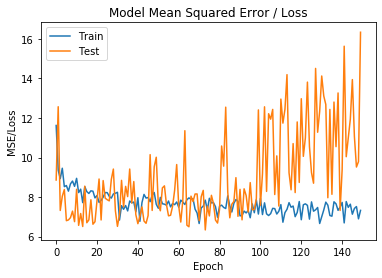

In [17]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Mean Squared Error / Loss')
plt.ylabel('MSE/Loss')
plt.xlabel('Epoch')
_= plt.legend(['Train', 'Test'], loc='upper left')

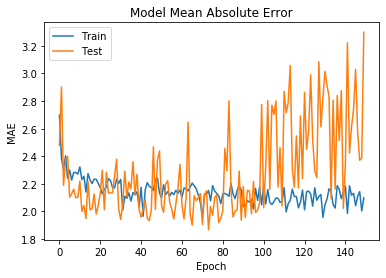

In [18]:
plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_mean_absolute_error'])
plt.title('Model Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
_= plt.legend(['Train', 'Test'], loc='upper left')

In [19]:
import gc
del train_gen
del valid_gen
del X_train
del y_train
del train_df
gc.collect()


6420

In [20]:
model.save_weights('./trained_model.h5', overwrite=True)

Load and normalize the test data

In [21]:
def load_test(ts_length = 150000):
    base_dir = 'input/test/'
    test_files = [f for f in listdir(base_dir) if isfile(join(base_dir, f))]

    ts = np.empty([len(test_files), ts_length])
    ids = []
    
    i = 0
    for f in tqdm_notebook(test_files):
        ids.append(splitext(f)[0])
        t_df = pd.read_csv(base_dir + f, dtype={"acoustic_data": np.int8})
        ts[i, :] = t_df['acoustic_data'].values
        i = i + 1

    return ts, ids

In [22]:
test_data, test_ids = load_test()

In [23]:
X_test = test_data
X_test = np.expand_dims(X_test, 2)
X_test.shape

(2624, 150000, 1)

Load best model and predict

In [24]:
y_pred = model.predict(X_test)

In [25]:
submission_df = pd.DataFrame({'seg_id': test_ids, 'time_to_failure': y_pred[:, 0]})

In [26]:
submission_df.to_csv("submission.csv", index=False)

<a href="submission.csv"> Download File </a>

